# Few Shot Image Classification with Similarity Pre-training

If only a few labeled training examples are available, it can often be beneficial to use pre-training, i.e., first train the neural network on an different task with more training data so that the weights of the network already capture e.g. basic image statistics, and then fine tune the network with the given labeled examples for the real task.

In the past it has been shown that, at least for image classification tasks, it is more helpful to use the labels of a different task when performing the pre-training than e.g. an unsupervised method such as Auto-Encoders, as only with labels the model is able to learn the distinction between important image patches (e.g. faces) and irrelevant pixels (see also [this blog post](http://karpathy.github.io/2014/07/03/feature-learning-escapades/)). This is no different when performing the pre-training with a SimEc, i.e., with a data driven similarity function such as a linear kernel, the pre-training is not very effective, while if a similarity function is available that captures class related differences (here simulated by computing a weighted average between the linear kernel and the class based similarity matrix), then pre-training can be about as effective as with a classifier that was trained on other labels.

In this notebook we compare pre-training with a classifier (clf), an Auto-Encoder (AE) as well as a Similarity Encoder (SimEc) on the CIFAR10 dataset.

In [1]:
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import range
from time import time
from copy import deepcopy
import random
random.seed(28)
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import linear_kernel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
torch.manual_seed(28)
torch.cuda.manual_seed(28)
torch.backends.cudnn.deterministic = True
import torchvision
from torchvision import datasets, transforms

from simec_torch import SimilarityEncoder, Dense
from utils import check_similarity_match
from utils_plotting import get_colors
from utils_torch import examine_param_space

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
## basic CNN for classification
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)  # b x 3 x 32 x 32 --> b x 16 x 32 x 32
        self.relu1 = nn.ReLU(True)
        self.maxp1 = nn.MaxPool2d(2, return_indices=True)  #           --> b x 16 x 16 x 16
        self.mp1id = None
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1)  #                 --> b x 8 x 16 x 16
        self.relu2 = nn.ReLU(True)
        self.maxp2 = nn.MaxPool2d(2, return_indices=True)  #           --> b x 8 x 8 x 8
        self.mp2id = None
        self.nonlin1 = Dense(512, 512, activation=torch.tanh)
        self.nonlin2 = Dense(512, 512, activation=torch.tanh)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x, self.mp1id = self.maxp1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x, self.mp2id = self.maxp2(x)
        x = x.view(-1, 512)
        x = self.nonlin1(x)
        x = self.nonlin2(x)
        return x

## classifier based on CNN
class CLF(nn.Module):
    def __init__(self, cnn, n_classes=10):
        super(CLF, self).__init__()
        self.cnn = cnn
        self.lastlayer = nn.Sequential(
            nn.Linear(512, n_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.lastlayer(x)
        return x

## AE based on CNN
class AE(nn.Module):
    def __init__(self, cnn):
        super(AE, self).__init__()
        self.encoder = cnn
        self.nonlin1 = Dense(512, 512, activation=torch.tanh)
        self.nonlin2 = Dense(512, 512, activation=torch.tanh)
        self.maxup2 = nn.MaxUnpool2d(2)  #         b x 8 x 8 x 8 --> b x 8 x 16 x 16
        self.convt2 = nn.ConvTranspose2d(8, 16, 3, padding=1)  # --> b x 16 x 16 x 16
        self.relu2 = nn.ReLU(True)
        self.maxup1 = nn.MaxUnpool2d(2)  #                       --> b x 16 x 32 x 32
        self.convt1 = nn.ConvTranspose2d(16, 3, 5, padding=2)  # --> b x 3 x 32 x 32 

    def forward(self, x):
        x = self.encoder(x)
        x = self.nonlin1(x)
        x = self.nonlin2(x)
        x = x.view(-1, 8, 8, 8)
        x = self.maxup2(x, self.encoder.mp2id)
        x = self.convt2(x)
        x = self.relu2(x)
        x = self.maxup1(x, self.encoder.mp1id)
        x = self.convt1(x)
        return x


## AE with only a single linear layer
class AE1L(nn.Module):
    def __init__(self, cnn):
        super(AE1L, self).__init__()
        self.encoder = cnn
        self.lastlayer = nn.Linear(512, 3*32*32)

    def forward(self, x):
        x = self.encoder(x)
        x = self.lastlayer(x)
        x = x.view(-1, 3, 32, 32)
        return x
    
def compare_state_dicts(sd1, sd2):
    # check if the state dicts of two models are the same
    is_equal = True
    for p in sd1:
        if not torch.all(torch.eq(sd1[p], sd2[p])):
            is_equal = False
            break
    print(is_equal)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

img_transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                        std=[0.2023, 0.1994, 0.2010])
])

# load the data
train_dataset = datasets.CIFAR10('./data/cifar10', train=True, download=True, transform=img_transform)
test_dataset = datasets.CIFAR10('./data/cifar10', train=False, transform=img_transform)

# get indices for training, validation, and test data
n_valid = 5000
np.random.seed(15)
indices = np.random.permutation(len(train_dataset))
indices, indices_val = indices[:-n_valid], indices[-n_valid:]
indices_test = np.random.permutation(len(test_dataset))

# get some loaders
train_loader_all = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, sampler=SubsetRandomSampler(indices), **kwargs
)
valid_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, sampler=SubsetRandomSampler(indices_val), **kwargs
)
test_loader_all = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, sampler=SubsetRandomSampler(indices_test), **kwargs
)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '       horse              dog             deer             ship             deer    ')

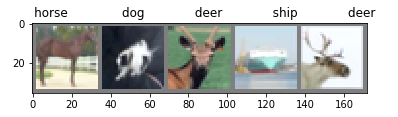

In [4]:
def imshow(img):
    img = img / 5 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# get some random training images
dataiter = iter(train_loader_all)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:5]))
# print labels
plt.title(' '.join('%12s    ' % classes[labels[j]] for j in range(5)))

### Training a regular classifier with more and more data

In [5]:
n_training_examples = [25, 50, 100, 250, 500, 750, 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000]

def train_clf(model, epoch, train_loader, optimizer, lr_scheduler):
    criterion = nn.NLLLoss()
    model.train()
    running_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        # for t1 the loss still expects the labels to be between 0 and 4
        if target.min() > 4:
            target -= 5
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('[epoch %d] loss: %.7f' % (epoch + 1, running_loss / (batch_idx + 1)))
    lr_scheduler.step(running_loss)

    
def test_clf(model, test_loader):
    criterion = nn.NLLLoss(reduction="sum")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if target.min() > 4:
                target -= 5
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.sampler)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.sampler),
        100. * correct / len(test_loader.sampler)))
    return correct / len(test_loader.sampler)


def clf_with_ntrain(n_train, cnn_dict=None, frozen=False):
    test_accs = []
    for seed in [11, 12, 13]:
        print("## seed:", seed)
        # get train_loader with specific number of training examples
        np.random.seed(seed)
        tindices = np.random.permutation(indices)
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=32, sampler=SubsetRandomSampler(tindices[:n_train]), **kwargs
        )
        # pretrained cnn?
        cnn = CNN()
        if cnn_dict is not None:
            cnn.load_state_dict(cnn_dict)
        if frozen:
            for p in cnn.parameters():
                p.requires_grad = False    
        model = CLF(cnn).to(device)
        print("Validation accuracy before training:")
        _ = test_clf(model, valid_loader)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, eps=0., verbose=True)

        best_acc = 0
        best_model = None

        for epoch in range(50):
            train_clf(model, epoch, train_loader, optimizer, lr_scheduler)
            val_acc = test_clf(model, valid_loader)
            if val_acc >= best_acc:
                best_acc = val_acc
                best_model = deepcopy(model.state_dict())
        model.load_state_dict(best_model)

        print("Validation:")
        _ = test_clf(model, valid_loader)
        print("Test")
        test_accs.append(test_clf(model, test_loader_all))
    return np.mean(test_accs), np.std(test_accs)

In [6]:
# CLF without pretraining
test_accuracies_clf = []
for n_train in n_training_examples:
    print(n_train)
    test_accuracies_clf.append(clf_with_ntrain(n_train))

25
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3131, Accuracy: 361/5000 (7%)
[epoch 1] loss: 2.3259628
Test set: Average loss: 2.3548, Accuracy: 589/5000 (12%)
[epoch 2] loss: 2.0239921
Test set: Average loss: 2.5436, Accuracy: 563/5000 (11%)
[epoch 3] loss: 1.8023823
Test set: Average loss: 2.6773, Accuracy: 741/5000 (15%)
[epoch 4] loss: 1.5832568
Test set: Average loss: 2.6831, Accuracy: 835/5000 (17%)
[epoch 5] loss: 1.3261188
Test set: Average loss: 2.6736, Accuracy: 792/5000 (16%)
[epoch 6] loss: 1.0498534
Test set: Average loss: 2.7315, Accuracy: 725/5000 (14%)
[epoch 7] loss: 0.7848161
Test set: Average loss: 2.8717, Accuracy: 724/5000 (14%)
[epoch 8] loss: 0.5575764
Test set: Average loss: 3.0718, Accuracy: 701/5000 (14%)
[epoch 9] loss: 0.3745236
Test set: Average loss: 3.3395, Accuracy: 713/5000 (14%)
[epoch 10] loss: 0.2431545
Test set: Average loss: 3.6719, Accuracy: 751/5000 (15%)
[epoch 11] loss: 0.1573123
Test set: Average loss: 4.0251, Ac

[epoch 45] loss: 0.0001479
Test set: Average loss: 6.6948, Accuracy: 758/5000 (15%)
[epoch 46] loss: 0.0001413
Test set: Average loss: 6.7147, Accuracy: 758/5000 (15%)
[epoch 47] loss: 0.0001353
Test set: Average loss: 6.7334, Accuracy: 758/5000 (15%)
[epoch 48] loss: 0.0001299
Test set: Average loss: 6.7512, Accuracy: 758/5000 (15%)
[epoch 49] loss: 0.0001249
Test set: Average loss: 6.7679, Accuracy: 758/5000 (15%)
[epoch 50] loss: 0.0001203
Test set: Average loss: 6.7838, Accuracy: 757/5000 (15%)
Validation:
Test set: Average loss: 3.0414, Accuracy: 804/5000 (16%)
Test
Test set: Average loss: 3.0349, Accuracy: 1617/10000 (16%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3016, Accuracy: 581/5000 (12%)
[epoch 1] loss: 2.2725379
Test set: Average loss: 2.3834, Accuracy: 531/5000 (11%)
[epoch 2] loss: 1.9128057
Test set: Average loss: 2.6608, Accuracy: 545/5000 (11%)
[epoch 3] loss: 1.7305446
Test set: Average loss: 2.7070, Accuracy: 688/5000 (14%)
[epoch 4

[epoch 35] loss: 0.0007334
Epoch    34: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 5.8700, Accuracy: 1022/5000 (20%)
[epoch 36] loss: 0.0007299
Epoch    35: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 5.8700, Accuracy: 1022/5000 (20%)
[epoch 37] loss: 0.0007828
Epoch    36: reducing learning rate of group 0 to 1.0000e-09.
Test set: Average loss: 5.8700, Accuracy: 1022/5000 (20%)
[epoch 38] loss: 0.0008023
Epoch    37: reducing learning rate of group 0 to 1.0000e-10.
Test set: Average loss: 5.8700, Accuracy: 1022/5000 (20%)
[epoch 39] loss: 0.0007909
Epoch    38: reducing learning rate of group 0 to 1.0000e-11.
Test set: Average loss: 5.8700, Accuracy: 1022/5000 (20%)
[epoch 40] loss: 0.0007410
Epoch    39: reducing learning rate of group 0 to 1.0000e-12.
Test set: Average loss: 5.8700, Accuracy: 1022/5000 (20%)
[epoch 41] loss: 0.0008111
Epoch    40: reducing learning rate of group 0 to 1.0000e-13.
Test set: Average loss: 5.870

Test set: Average loss: 4.1796, Accuracy: 927/5000 (19%)
[epoch 13] loss: 0.0575246
Test set: Average loss: 4.1794, Accuracy: 924/5000 (18%)
[epoch 14] loss: 0.0612658
Epoch    13: reducing learning rate of group 0 to 1.0000e-05.
Test set: Average loss: 4.1798, Accuracy: 930/5000 (19%)
[epoch 15] loss: 0.0556489
Test set: Average loss: 4.1799, Accuracy: 928/5000 (19%)
[epoch 16] loss: 0.0551203
Test set: Average loss: 4.1800, Accuracy: 926/5000 (19%)
[epoch 17] loss: 0.0566353
Epoch    16: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 4.1801, Accuracy: 926/5000 (19%)
[epoch 18] loss: 0.0602593
Epoch    17: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 4.1801, Accuracy: 927/5000 (19%)
[epoch 19] loss: 0.0514205
Test set: Average loss: 4.1801, Accuracy: 927/5000 (19%)
[epoch 20] loss: 0.0504181
Test set: Average loss: 4.1801, Accuracy: 927/5000 (19%)
[epoch 21] loss: 0.0497206
Test set: Average loss: 4.1801, Accuracy: 927/5000 (19%)
[

Test set: Average loss: 2.9632, Accuracy: 1031/5000 (21%)
[epoch 25] loss: 0.5946286
Epoch    24: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 2.9632, Accuracy: 1031/5000 (21%)
[epoch 26] loss: 0.7573260
Epoch    25: reducing learning rate of group 0 to 1.0000e-19.
Test set: Average loss: 2.9632, Accuracy: 1031/5000 (21%)
[epoch 27] loss: 0.5777168
Epoch    26: reducing learning rate of group 0 to 1.0000e-20.
Test set: Average loss: 2.9632, Accuracy: 1031/5000 (21%)
[epoch 28] loss: 0.6565621
Epoch    27: reducing learning rate of group 0 to 1.0000e-21.
Test set: Average loss: 2.9632, Accuracy: 1031/5000 (21%)
[epoch 29] loss: 0.6805914
Epoch    28: reducing learning rate of group 0 to 1.0000e-22.
Test set: Average loss: 2.9632, Accuracy: 1031/5000 (21%)
[epoch 30] loss: 0.7662243
Epoch    29: reducing learning rate of group 0 to 1.0000e-23.
Test set: Average loss: 2.9632, Accuracy: 1031/5000 (21%)
[epoch 31] loss: 0.6448515
Epoch    30: reducing learning ra

Test set: Average loss: 2.2463, Accuracy: 1025/5000 (20%)
[epoch 32] loss: 1.7210010
Epoch    31: reducing learning rate of group 0 to 1.0000e-29.
Test set: Average loss: 2.2463, Accuracy: 1025/5000 (20%)
[epoch 33] loss: 1.5749112
Test set: Average loss: 2.2463, Accuracy: 1025/5000 (20%)
[epoch 34] loss: 1.9035912
Epoch    33: reducing learning rate of group 0 to 1.0000e-30.
Test set: Average loss: 2.2463, Accuracy: 1025/5000 (20%)
[epoch 35] loss: 1.7108397
Epoch    34: reducing learning rate of group 0 to 1.0000e-31.
Test set: Average loss: 2.2463, Accuracy: 1025/5000 (20%)
[epoch 36] loss: 1.7523423
Epoch    35: reducing learning rate of group 0 to 1.0000e-32.
Test set: Average loss: 2.2463, Accuracy: 1025/5000 (20%)
[epoch 37] loss: 1.8015946
Epoch    36: reducing learning rate of group 0 to 1.0000e-33.
Test set: Average loss: 2.2463, Accuracy: 1025/5000 (20%)
[epoch 38] loss: 1.9468872
Epoch    37: reducing learning rate of group 0 to 1.0000e-34.
Test set: Average loss: 2.2463, A

Test set: Average loss: 3.4189, Accuracy: 1086/5000 (22%)
[epoch 45] loss: 0.1716197
Epoch    44: reducing learning rate of group 0 to 1.0000e-29.
Test set: Average loss: 3.4189, Accuracy: 1086/5000 (22%)
[epoch 46] loss: 0.1505568
Epoch    45: reducing learning rate of group 0 to 1.0000e-30.
Test set: Average loss: 3.4189, Accuracy: 1086/5000 (22%)
[epoch 47] loss: 0.1150223
Epoch    46: reducing learning rate of group 0 to 1.0000e-31.
Test set: Average loss: 3.4189, Accuracy: 1086/5000 (22%)
[epoch 48] loss: 0.1226595
Epoch    47: reducing learning rate of group 0 to 1.0000e-32.
Test set: Average loss: 3.4189, Accuracy: 1086/5000 (22%)
[epoch 49] loss: 0.1330352
Epoch    48: reducing learning rate of group 0 to 1.0000e-33.
Test set: Average loss: 3.4189, Accuracy: 1086/5000 (22%)
[epoch 50] loss: 0.1443941
Epoch    49: reducing learning rate of group 0 to 1.0000e-34.
Test set: Average loss: 3.4189, Accuracy: 1086/5000 (22%)
Validation:
Test set: Average loss: 2.7985, Accuracy: 1106/5

[epoch 31] loss: 0.0030468
Test set: Average loss: 4.0759, Accuracy: 1564/5000 (31%)
[epoch 32] loss: 0.0028666
Test set: Average loss: 4.0983, Accuracy: 1559/5000 (31%)
[epoch 33] loss: 0.0027137
Test set: Average loss: 4.1219, Accuracy: 1560/5000 (31%)
[epoch 34] loss: 0.0025546
Test set: Average loss: 4.1344, Accuracy: 1564/5000 (31%)
[epoch 35] loss: 0.0024468
Test set: Average loss: 4.1563, Accuracy: 1560/5000 (31%)
[epoch 36] loss: 0.0023086
Test set: Average loss: 4.1786, Accuracy: 1551/5000 (31%)
[epoch 37] loss: 0.0021914
Test set: Average loss: 4.1952, Accuracy: 1554/5000 (31%)
[epoch 38] loss: 0.0020728
Test set: Average loss: 4.2076, Accuracy: 1558/5000 (31%)
[epoch 39] loss: 0.0019807
Test set: Average loss: 4.2211, Accuracy: 1553/5000 (31%)
[epoch 40] loss: 0.0018929
Test set: Average loss: 4.2406, Accuracy: 1548/5000 (31%)
[epoch 41] loss: 0.0018123
Test set: Average loss: 4.2574, Accuracy: 1551/5000 (31%)
[epoch 42] loss: 0.0017294
Test set: Average loss: 4.2760, Accura

[epoch 22] loss: 0.0054497
Test set: Average loss: 4.1314, Accuracy: 1701/5000 (34%)
[epoch 23] loss: 0.0049183
Test set: Average loss: 4.1857, Accuracy: 1697/5000 (34%)
[epoch 24] loss: 0.0043999
Test set: Average loss: 4.2086, Accuracy: 1696/5000 (34%)
[epoch 25] loss: 0.0040907
Test set: Average loss: 4.2567, Accuracy: 1685/5000 (34%)
[epoch 26] loss: 0.0037571
Test set: Average loss: 4.2874, Accuracy: 1690/5000 (34%)
[epoch 27] loss: 0.0034286
Test set: Average loss: 4.3167, Accuracy: 1689/5000 (34%)
[epoch 28] loss: 0.0031706
Test set: Average loss: 4.3425, Accuracy: 1691/5000 (34%)
[epoch 29] loss: 0.0029440
Test set: Average loss: 4.3765, Accuracy: 1687/5000 (34%)
[epoch 30] loss: 0.0027504
Test set: Average loss: 4.4019, Accuracy: 1685/5000 (34%)
[epoch 31] loss: 0.0025931
Test set: Average loss: 4.4250, Accuracy: 1687/5000 (34%)
[epoch 32] loss: 0.0024326
Test set: Average loss: 4.4507, Accuracy: 1685/5000 (34%)
[epoch 33] loss: 0.0022930
Test set: Average loss: 4.4785, Accura

[epoch 13] loss: 0.1566315
Test set: Average loss: 3.3324, Accuracy: 1660/5000 (33%)
[epoch 14] loss: 0.0927795
Test set: Average loss: 3.4029, Accuracy: 1739/5000 (35%)
[epoch 15] loss: 0.0644883
Test set: Average loss: 3.7022, Accuracy: 1671/5000 (33%)
[epoch 16] loss: 0.0391438
Test set: Average loss: 3.8290, Accuracy: 1702/5000 (34%)
[epoch 17] loss: 0.0244912
Test set: Average loss: 3.8177, Accuracy: 1739/5000 (35%)
[epoch 18] loss: 0.0151069
Test set: Average loss: 3.9172, Accuracy: 1737/5000 (35%)
[epoch 19] loss: 0.0091509
Test set: Average loss: 3.9669, Accuracy: 1757/5000 (35%)
[epoch 20] loss: 0.0069617
Test set: Average loss: 4.0305, Accuracy: 1744/5000 (35%)
[epoch 21] loss: 0.0059597
Test set: Average loss: 4.0794, Accuracy: 1746/5000 (35%)
[epoch 22] loss: 0.0050751
Test set: Average loss: 4.1174, Accuracy: 1753/5000 (35%)
[epoch 23] loss: 0.0045038
Test set: Average loss: 4.1631, Accuracy: 1752/5000 (35%)
[epoch 24] loss: 0.0040954
Test set: Average loss: 4.1914, Accura

[epoch 4] loss: 1.2302463
Test set: Average loss: 1.9840, Accuracy: 1680/5000 (34%)
[epoch 5] loss: 1.0275507
Test set: Average loss: 1.9978, Accuracy: 1855/5000 (37%)
[epoch 6] loss: 0.7870050
Test set: Average loss: 2.2506, Accuracy: 1738/5000 (35%)
[epoch 7] loss: 0.6746248
Test set: Average loss: 2.2507, Accuracy: 1918/5000 (38%)
[epoch 8] loss: 0.4878711
Test set: Average loss: 2.4134, Accuracy: 1911/5000 (38%)
[epoch 9] loss: 0.3405696
Test set: Average loss: 2.6650, Accuracy: 1854/5000 (37%)
[epoch 10] loss: 0.2543207
Test set: Average loss: 2.8086, Accuracy: 1905/5000 (38%)
[epoch 11] loss: 0.2181538
Test set: Average loss: 3.1976, Accuracy: 1792/5000 (36%)
[epoch 12] loss: 0.1560949
Test set: Average loss: 3.4043, Accuracy: 1876/5000 (38%)
[epoch 13] loss: 0.1368562
Test set: Average loss: 3.4591, Accuracy: 1866/5000 (37%)
[epoch 14] loss: 0.0684452
Test set: Average loss: 3.5498, Accuracy: 1888/5000 (38%)
[epoch 15] loss: 0.0324701
Test set: Average loss: 3.6999, Accuracy: 18

[epoch 48] loss: 0.0007659
Test set: Average loss: 5.1921, Accuracy: 1714/5000 (34%)
[epoch 49] loss: 0.0007331
Test set: Average loss: 5.2082, Accuracy: 1716/5000 (34%)
[epoch 50] loss: 0.0007095
Test set: Average loss: 5.2279, Accuracy: 1715/5000 (34%)
Validation:
Test set: Average loss: 1.9175, Accuracy: 1793/5000 (36%)
Test
Test set: Average loss: 1.9040, Accuracy: 3690/10000 (37%)
1000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3047, Accuracy: 536/5000 (11%)
[epoch 1] loss: 2.1509524
Test set: Average loss: 1.9068, Accuracy: 1469/5000 (29%)
[epoch 2] loss: 1.7460171
Test set: Average loss: 1.9435, Accuracy: 1582/5000 (32%)
[epoch 3] loss: 1.5340505
Test set: Average loss: 1.8204, Accuracy: 1838/5000 (37%)
[epoch 4] loss: 1.3793775
Test set: Average loss: 1.8877, Accuracy: 1756/5000 (35%)
[epoch 5] loss: 1.1582444
Test set: Average loss: 1.8949, Accuracy: 1859/5000 (37%)
[epoch 6] loss: 0.9427042
Test set: Average loss: 1.9923, Accuracy: 1869/5000 (3

Test set: Average loss: 4.7605, Accuracy: 1881/5000 (38%)
[epoch 39] loss: 0.0016204
Test set: Average loss: 4.7818, Accuracy: 1867/5000 (37%)
[epoch 40] loss: 0.0015801
Test set: Average loss: 4.8034, Accuracy: 1872/5000 (37%)
[epoch 41] loss: 0.0014729
Test set: Average loss: 4.8313, Accuracy: 1871/5000 (37%)
[epoch 42] loss: 0.0014074
Test set: Average loss: 4.8507, Accuracy: 1871/5000 (37%)
[epoch 43] loss: 0.0012968
Test set: Average loss: 4.8721, Accuracy: 1875/5000 (38%)
[epoch 44] loss: 0.0012544
Test set: Average loss: 4.8918, Accuracy: 1873/5000 (37%)
[epoch 45] loss: 0.0011785
Test set: Average loss: 4.9150, Accuracy: 1870/5000 (37%)
[epoch 46] loss: 0.0011273
Test set: Average loss: 4.9305, Accuracy: 1869/5000 (37%)
[epoch 47] loss: 0.0010893
Test set: Average loss: 4.9499, Accuracy: 1877/5000 (38%)
[epoch 48] loss: 0.0010378
Test set: Average loss: 4.9704, Accuracy: 1869/5000 (37%)
[epoch 49] loss: 0.0009985
Test set: Average loss: 4.9876, Accuracy: 1877/5000 (38%)
[epoch 

Test set: Average loss: 3.0064, Accuracy: 2157/5000 (43%)
[epoch 28] loss: 0.1137747
Epoch    27: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 3.0091, Accuracy: 2163/5000 (43%)
[epoch 29] loss: 0.1094251
Test set: Average loss: 3.0094, Accuracy: 2161/5000 (43%)
[epoch 30] loss: 0.1087687
Test set: Average loss: 3.0097, Accuracy: 2162/5000 (43%)
[epoch 31] loss: 0.1084672
Test set: Average loss: 3.0099, Accuracy: 2162/5000 (43%)
[epoch 32] loss: 0.1085452
Epoch    31: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 3.0102, Accuracy: 2162/5000 (43%)
[epoch 33] loss: 0.1083823
Test set: Average loss: 3.0102, Accuracy: 2162/5000 (43%)
[epoch 34] loss: 0.1085666
Epoch    33: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 3.0102, Accuracy: 2162/5000 (43%)
[epoch 35] loss: 0.1105626
Epoch    34: reducing learning rate of group 0 to 1.0000e-09.
Test set: Average loss: 3.0102, Accuracy: 2162/5000 (43%)
[epoch 36] los

[epoch 41] loss: 0.4292694
Epoch    40: reducing learning rate of group 0 to 1.0000e-29.
Test set: Average loss: 2.0450, Accuracy: 2126/5000 (43%)
[epoch 42] loss: 0.4278388
Test set: Average loss: 2.0450, Accuracy: 2126/5000 (43%)
[epoch 43] loss: 0.4365440
Epoch    42: reducing learning rate of group 0 to 1.0000e-30.
Test set: Average loss: 2.0450, Accuracy: 2126/5000 (43%)
[epoch 44] loss: 0.4324439
Epoch    43: reducing learning rate of group 0 to 1.0000e-31.
Test set: Average loss: 2.0450, Accuracy: 2126/5000 (43%)
[epoch 45] loss: 0.4295075
Epoch    44: reducing learning rate of group 0 to 1.0000e-32.
Test set: Average loss: 2.0450, Accuracy: 2126/5000 (43%)
[epoch 46] loss: 0.4326724
Epoch    45: reducing learning rate of group 0 to 1.0000e-33.
Test set: Average loss: 2.0450, Accuracy: 2126/5000 (43%)
[epoch 47] loss: 0.4300230
Epoch    46: reducing learning rate of group 0 to 1.0000e-34.
Test set: Average loss: 2.0450, Accuracy: 2126/5000 (43%)
[epoch 48] loss: 0.5277142
Epoch 

[epoch 12] loss: 0.8499185
Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.7157, Accuracy: 2355/5000 (47%)
[epoch 13] loss: 0.5711470
Test set: Average loss: 1.6844, Accuracy: 2461/5000 (49%)
[epoch 14] loss: 0.5255892
Test set: Average loss: 1.7164, Accuracy: 2517/5000 (50%)
[epoch 15] loss: 0.5052647
Test set: Average loss: 1.7601, Accuracy: 2500/5000 (50%)
[epoch 16] loss: 0.4903286
Test set: Average loss: 1.7888, Accuracy: 2466/5000 (49%)
[epoch 17] loss: 0.4784777
Test set: Average loss: 1.8238, Accuracy: 2480/5000 (50%)
[epoch 18] loss: 0.4647348
Test set: Average loss: 1.8583, Accuracy: 2490/5000 (50%)
[epoch 19] loss: 0.4560466
Test set: Average loss: 1.8942, Accuracy: 2469/5000 (49%)
[epoch 20] loss: 0.4426196
Test set: Average loss: 1.9123, Accuracy: 2458/5000 (49%)
[epoch 21] loss: 0.4291826
Test set: Average loss: 1.9556, Accuracy: 2470/5000 (49%)
[epoch 22] loss: 0.4172327
Test set: Average loss: 1.9831, Accuracy: 2468/5000 (49%)
[ep

[epoch 2] loss: 1.5344319
Test set: Average loss: 1.5372, Accuracy: 2172/5000 (43%)
[epoch 3] loss: 1.3935257
Test set: Average loss: 1.5051, Accuracy: 2319/5000 (46%)
[epoch 4] loss: 1.2884919
Test set: Average loss: 1.4974, Accuracy: 2317/5000 (46%)
[epoch 5] loss: 1.1919094
Test set: Average loss: 1.5251, Accuracy: 2368/5000 (47%)
[epoch 6] loss: 1.1267279
Test set: Average loss: 1.4923, Accuracy: 2423/5000 (48%)
[epoch 7] loss: 1.0659531
Test set: Average loss: 1.5182, Accuracy: 2436/5000 (49%)
[epoch 8] loss: 1.0143983
Test set: Average loss: 1.6293, Accuracy: 2333/5000 (47%)
[epoch 9] loss: 0.9493852
Test set: Average loss: 1.6355, Accuracy: 2401/5000 (48%)
[epoch 10] loss: 0.8922359
Test set: Average loss: 1.7334, Accuracy: 2338/5000 (47%)
[epoch 11] loss: 0.8515866
Test set: Average loss: 1.6917, Accuracy: 2408/5000 (48%)
[epoch 12] loss: 0.8160420
Test set: Average loss: 1.7506, Accuracy: 2399/5000 (48%)
[epoch 13] loss: 0.7652865
Test set: Average loss: 1.8406, Accuracy: 2338

[epoch 46] loss: 0.0000463
Test set: Average loss: 3.7131, Accuracy: 2720/5000 (54%)
[epoch 47] loss: 0.0000379
Test set: Average loss: 3.7592, Accuracy: 2726/5000 (55%)
[epoch 48] loss: 0.0000309
Test set: Average loss: 3.8120, Accuracy: 2727/5000 (55%)
[epoch 49] loss: 0.0000252
Test set: Average loss: 3.8652, Accuracy: 2718/5000 (54%)
[epoch 50] loss: 0.0000207
Test set: Average loss: 3.9156, Accuracy: 2713/5000 (54%)
Validation:
Test set: Average loss: 2.3757, Accuracy: 2747/5000 (55%)
Test
Test set: Average loss: 2.2885, Accuracy: 5613/10000 (56%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.3033, Accuracy: 367/5000 (7%)
[epoch 1] loss: 1.6915732
Test set: Average loss: 1.5732, Accuracy: 2107/5000 (42%)
[epoch 2] loss: 1.4231346
Test set: Average loss: 1.4983, Accuracy: 2325/5000 (46%)
[epoch 3] loss: 1.3058738
Test set: Average loss: 1.3584, Accuracy: 2566/5000 (51%)
[epoch 4] loss: 1.2254850
Test set: Average loss: 1.4191, Accuracy: 2504/5000 (50%)


[epoch 19] loss: 0.2190271
Test set: Average loss: 1.8531, Accuracy: 2696/5000 (54%)
[epoch 20] loss: 0.1465736
Test set: Average loss: 1.9266, Accuracy: 2732/5000 (55%)
[epoch 21] loss: 0.1052896
Test set: Average loss: 2.0731, Accuracy: 2710/5000 (54%)
[epoch 22] loss: 0.0852391
Test set: Average loss: 2.1519, Accuracy: 2747/5000 (55%)
[epoch 23] loss: 0.0362808
Test set: Average loss: 2.1699, Accuracy: 2791/5000 (56%)
[epoch 24] loss: 0.0396568
Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 2.3645, Accuracy: 2728/5000 (55%)
[epoch 25] loss: 0.0165675
Test set: Average loss: 2.2680, Accuracy: 2790/5000 (56%)
[epoch 26] loss: 0.0096784
Test set: Average loss: 2.2755, Accuracy: 2798/5000 (56%)
[epoch 27] loss: 0.0080827
Test set: Average loss: 2.2871, Accuracy: 2801/5000 (56%)
[epoch 28] loss: 0.0070763
Test set: Average loss: 2.2982, Accuracy: 2805/5000 (56%)
[epoch 29] loss: 0.0063021
Test set: Average loss: 2.3142, Accuracy: 2804/5000 (56%)
[ep

[epoch 9] loss: 0.9355420
Test set: Average loss: 1.2728, Accuracy: 2873/5000 (57%)
[epoch 10] loss: 0.8920042
Test set: Average loss: 1.2587, Accuracy: 2922/5000 (58%)
[epoch 11] loss: 0.8216602
Test set: Average loss: 1.3006, Accuracy: 2868/5000 (57%)
[epoch 12] loss: 0.7499757
Test set: Average loss: 1.3190, Accuracy: 2906/5000 (58%)
[epoch 13] loss: 0.6690566
Test set: Average loss: 1.3370, Accuracy: 2952/5000 (59%)
[epoch 14] loss: 0.5778443
Test set: Average loss: 1.4014, Accuracy: 2916/5000 (58%)
[epoch 15] loss: 0.4845432
Test set: Average loss: 1.4621, Accuracy: 2895/5000 (58%)
[epoch 16] loss: 0.3788987
Test set: Average loss: 1.5064, Accuracy: 2967/5000 (59%)
[epoch 17] loss: 0.2719559
Test set: Average loss: 1.6195, Accuracy: 2898/5000 (58%)
[epoch 18] loss: 0.1903385
Test set: Average loss: 1.7404, Accuracy: 2921/5000 (58%)
[epoch 19] loss: 0.1269999
Test set: Average loss: 1.8383, Accuracy: 2920/5000 (58%)
[epoch 20] loss: 0.0708443
Test set: Average loss: 1.9116, Accurac

Test set: Average loss: 2.3302, Accuracy: 6159/10000 (62%)
20000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.2947, Accuracy: 702/5000 (14%)
[epoch 1] loss: 1.6368277
Test set: Average loss: 1.4937, Accuracy: 2317/5000 (46%)
[epoch 2] loss: 1.3553355
Test set: Average loss: 1.4091, Accuracy: 2463/5000 (49%)
[epoch 3] loss: 1.2471182
Test set: Average loss: 1.2899, Accuracy: 2682/5000 (54%)
[epoch 4] loss: 1.1787716
Test set: Average loss: 1.2751, Accuracy: 2766/5000 (55%)
[epoch 5] loss: 1.1216909
Test set: Average loss: 1.2959, Accuracy: 2683/5000 (54%)
[epoch 6] loss: 1.0749202
Test set: Average loss: 1.1970, Accuracy: 2908/5000 (58%)
[epoch 7] loss: 1.0272085
Test set: Average loss: 1.2652, Accuracy: 2838/5000 (57%)
[epoch 8] loss: 0.9757226
Test set: Average loss: 1.2434, Accuracy: 2865/5000 (57%)
[epoch 9] loss: 0.9169928
Test set: Average loss: 1.1985, Accuracy: 2943/5000 (59%)
[epoch 10] loss: 0.8579117
Test set: Average loss: 1.2073, Accuracy: 2937

Test set: Average loss: 2.5205, Accuracy: 3059/5000 (61%)
[epoch 42] loss: 0.0001497
Test set: Average loss: 2.5663, Accuracy: 3067/5000 (61%)
[epoch 43] loss: 0.0001126
Test set: Average loss: 2.6177, Accuracy: 3066/5000 (61%)
[epoch 44] loss: 0.0000842
Test set: Average loss: 2.6703, Accuracy: 3064/5000 (61%)
[epoch 45] loss: 0.0000627
Test set: Average loss: 2.7235, Accuracy: 3061/5000 (61%)
[epoch 46] loss: 0.0000468
Test set: Average loss: 2.7746, Accuracy: 3066/5000 (61%)
[epoch 47] loss: 0.0000348
Test set: Average loss: 2.8261, Accuracy: 3072/5000 (61%)
[epoch 48] loss: 0.0000257
Test set: Average loss: 2.8858, Accuracy: 3063/5000 (61%)
[epoch 49] loss: 0.0000191
Test set: Average loss: 2.9389, Accuracy: 3066/5000 (61%)
[epoch 50] loss: 0.0000141
Test set: Average loss: 2.9925, Accuracy: 3057/5000 (61%)
Validation:
Test set: Average loss: 2.8261, Accuracy: 3072/5000 (61%)
Test
Test set: Average loss: 2.8172, Accuracy: 6192/10000 (62%)
## seed: 13
Validation accuracy before trai

[epoch 31] loss: 0.0012970
Test set: Average loss: 2.1920, Accuracy: 3149/5000 (63%)
[epoch 32] loss: 0.0009680
Test set: Average loss: 2.2227, Accuracy: 3153/5000 (63%)
[epoch 33] loss: 0.0007194
Test set: Average loss: 2.2644, Accuracy: 3149/5000 (63%)
[epoch 34] loss: 0.0005288
Test set: Average loss: 2.3040, Accuracy: 3155/5000 (63%)
[epoch 35] loss: 0.0003864
Test set: Average loss: 2.3459, Accuracy: 3164/5000 (63%)
[epoch 36] loss: 0.0002796
Test set: Average loss: 2.3930, Accuracy: 3168/5000 (63%)
[epoch 37] loss: 0.0002008
Test set: Average loss: 2.4421, Accuracy: 3171/5000 (63%)
[epoch 38] loss: 0.0001434
Test set: Average loss: 2.4888, Accuracy: 3161/5000 (63%)
[epoch 39] loss: 0.0001012
Test set: Average loss: 2.5417, Accuracy: 3173/5000 (63%)
[epoch 40] loss: 0.0000716
Test set: Average loss: 2.5936, Accuracy: 3173/5000 (63%)
[epoch 41] loss: 0.0000504
Test set: Average loss: 2.6502, Accuracy: 3182/5000 (64%)
[epoch 42] loss: 0.0000352
Test set: Average loss: 2.7093, Accura

Test set: Average loss: 2.1178, Accuracy: 2982/5000 (60%)
[epoch 22] loss: 0.1446031
Epoch    21: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 2.0514, Accuracy: 3058/5000 (61%)
[epoch 23] loss: 0.0451832
Test set: Average loss: 1.9051, Accuracy: 3159/5000 (63%)
[epoch 24] loss: 0.0137800
Test set: Average loss: 1.9115, Accuracy: 3159/5000 (63%)
[epoch 25] loss: 0.0087114
Test set: Average loss: 1.9235, Accuracy: 3176/5000 (64%)
[epoch 26] loss: 0.0062574
Test set: Average loss: 1.9393, Accuracy: 3182/5000 (64%)
[epoch 27] loss: 0.0046785
Test set: Average loss: 1.9565, Accuracy: 3188/5000 (64%)
[epoch 28] loss: 0.0035473
Test set: Average loss: 1.9754, Accuracy: 3194/5000 (64%)
[epoch 29] loss: 0.0027001
Test set: Average loss: 2.0051, Accuracy: 3203/5000 (64%)
[epoch 30] loss: 0.0020336
Test set: Average loss: 2.0390, Accuracy: 3212/5000 (64%)
[epoch 31] loss: 0.0015336
Test set: Average loss: 2.0703, Accuracy: 3213/5000 (64%)
[epoch 32] loss: 0.0011454
Tes

[epoch 11] loss: 0.6660076
Test set: Average loss: 1.1956, Accuracy: 3049/5000 (61%)
[epoch 12] loss: 0.5677293
Test set: Average loss: 1.1816, Accuracy: 3123/5000 (62%)
[epoch 13] loss: 0.4737629
Test set: Average loss: 1.2259, Accuracy: 3128/5000 (63%)
[epoch 14] loss: 0.3710905
Test set: Average loss: 1.2911, Accuracy: 3154/5000 (63%)
[epoch 15] loss: 0.2783268
Test set: Average loss: 1.3913, Accuracy: 3130/5000 (63%)
[epoch 16] loss: 0.2069162
Test set: Average loss: 1.4847, Accuracy: 3129/5000 (63%)
[epoch 17] loss: 0.1779403
Test set: Average loss: 1.6321, Accuracy: 3123/5000 (62%)
[epoch 18] loss: 0.1471177
Test set: Average loss: 1.7189, Accuracy: 3135/5000 (63%)
[epoch 19] loss: 0.1423009
Test set: Average loss: 1.8341, Accuracy: 3108/5000 (62%)
[epoch 20] loss: 0.1344248
Test set: Average loss: 1.8326, Accuracy: 3103/5000 (62%)
[epoch 21] loss: 0.1191497
Test set: Average loss: 1.8801, Accuracy: 3119/5000 (62%)
[epoch 22] loss: 0.1404960
Epoch    21: reducing learning rate of

Test set: Average loss: 2.3049, Accuracy: 551/5000 (11%)
[epoch 1] loss: 1.5117683
Test set: Average loss: 1.3584, Accuracy: 2550/5000 (51%)
[epoch 2] loss: 1.2504555
Test set: Average loss: 1.2999, Accuracy: 2718/5000 (54%)
[epoch 3] loss: 1.1465520
Test set: Average loss: 1.1620, Accuracy: 2924/5000 (58%)
[epoch 4] loss: 1.0711618
Test set: Average loss: 1.1344, Accuracy: 3025/5000 (60%)
[epoch 5] loss: 1.0052880
Test set: Average loss: 1.1104, Accuracy: 3070/5000 (61%)
[epoch 6] loss: 0.9467859
Test set: Average loss: 1.1052, Accuracy: 3058/5000 (61%)
[epoch 7] loss: 0.8888623
Test set: Average loss: 1.1117, Accuracy: 3071/5000 (61%)
[epoch 8] loss: 0.8263773
Test set: Average loss: 1.0927, Accuracy: 3149/5000 (63%)
[epoch 9] loss: 0.7479835
Test set: Average loss: 1.0628, Accuracy: 3214/5000 (64%)
[epoch 10] loss: 0.6718677
Test set: Average loss: 1.0865, Accuracy: 3182/5000 (64%)
[epoch 11] loss: 0.5784373
Test set: Average loss: 1.1433, Accuracy: 3206/5000 (64%)
[epoch 12] loss: 

[epoch 43] loss: 0.0000024
Test set: Average loss: 2.9203, Accuracy: 3300/5000 (66%)
[epoch 44] loss: 0.0000015
Test set: Average loss: 2.9995, Accuracy: 3286/5000 (66%)
[epoch 45] loss: 0.0000009
Test set: Average loss: 3.0598, Accuracy: 3283/5000 (66%)
[epoch 46] loss: 0.0000006
Test set: Average loss: 3.0966, Accuracy: 3294/5000 (66%)
[epoch 47] loss: 0.0000004
Test set: Average loss: 3.1200, Accuracy: 3284/5000 (66%)
[epoch 48] loss: 0.0004615
Epoch    47: reducing learning rate of group 0 to 1.0000e-05.
Test set: Average loss: 3.2385, Accuracy: 3228/5000 (65%)
[epoch 49] loss: 0.0006889
Epoch    48: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 3.1944, Accuracy: 3262/5000 (65%)
[epoch 50] loss: 0.0000741
Epoch    49: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 3.1935, Accuracy: 3264/5000 (65%)
Validation:
Test set: Average loss: 1.8022, Accuracy: 3321/5000 (66%)
Test
Test set: Average loss: 1.8373, Accuracy: 6535/10000 (65%)


Test set: Average loss: 1.8459, Accuracy: 3362/5000 (67%)
[epoch 31] loss: 0.0021538
Test set: Average loss: 1.8828, Accuracy: 3360/5000 (67%)
[epoch 32] loss: 0.0014189
Test set: Average loss: 1.9341, Accuracy: 3372/5000 (67%)
[epoch 33] loss: 0.0009067
Test set: Average loss: 1.9886, Accuracy: 3381/5000 (68%)
[epoch 34] loss: 0.0005795
Test set: Average loss: 2.0497, Accuracy: 3387/5000 (68%)
[epoch 35] loss: 0.0003678
Test set: Average loss: 2.1163, Accuracy: 3388/5000 (68%)
[epoch 36] loss: 0.0002315
Test set: Average loss: 2.1685, Accuracy: 3393/5000 (68%)
[epoch 37] loss: 0.0001453
Test set: Average loss: 2.2509, Accuracy: 3381/5000 (68%)
[epoch 38] loss: 0.0000899
Test set: Average loss: 2.3129, Accuracy: 3387/5000 (68%)
[epoch 39] loss: 0.0000555
Test set: Average loss: 2.3764, Accuracy: 3387/5000 (68%)
[epoch 40] loss: 0.0000340
Test set: Average loss: 2.4504, Accuracy: 3390/5000 (68%)
[epoch 41] loss: 0.0000208
Test set: Average loss: 2.5340, Accuracy: 3383/5000 (68%)
[epoch 

[epoch 21] loss: 0.1774753
Epoch    20: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.7879, Accuracy: 3175/5000 (64%)
[epoch 22] loss: 0.0654311
Test set: Average loss: 1.6653, Accuracy: 3316/5000 (66%)
[epoch 23] loss: 0.0226304
Test set: Average loss: 1.6763, Accuracy: 3317/5000 (66%)
[epoch 24] loss: 0.0125069
Test set: Average loss: 1.7018, Accuracy: 3317/5000 (66%)
[epoch 25] loss: 0.0081161
Test set: Average loss: 1.7321, Accuracy: 3335/5000 (67%)
[epoch 26] loss: 0.0053732
Test set: Average loss: 1.7759, Accuracy: 3344/5000 (67%)
[epoch 27] loss: 0.0035613
Test set: Average loss: 1.8196, Accuracy: 3335/5000 (67%)
[epoch 28] loss: 0.0023226
Test set: Average loss: 1.8783, Accuracy: 3342/5000 (67%)
[epoch 29] loss: 0.0015095
Test set: Average loss: 1.9330, Accuracy: 3337/5000 (67%)
[epoch 30] loss: 0.0009630
Test set: Average loss: 1.9831, Accuracy: 3361/5000 (67%)
[epoch 31] loss: 0.0006042
Test set: Average loss: 2.0541, Accuracy: 3347/5000 (67%)
[ep

Test set: Average loss: 1.0108, Accuracy: 3266/5000 (65%)
[epoch 9] loss: 0.7446944
Test set: Average loss: 0.9952, Accuracy: 3327/5000 (67%)
[epoch 10] loss: 0.6784031
Test set: Average loss: 1.0974, Accuracy: 3200/5000 (64%)
[epoch 11] loss: 0.6114726
Test set: Average loss: 1.0634, Accuracy: 3340/5000 (67%)
[epoch 12] loss: 0.5318478
Test set: Average loss: 1.0807, Accuracy: 3339/5000 (67%)
[epoch 13] loss: 0.4615470
Test set: Average loss: 1.1773, Accuracy: 3256/5000 (65%)
[epoch 14] loss: 0.3929105
Test set: Average loss: 1.2404, Accuracy: 3254/5000 (65%)
[epoch 15] loss: 0.3439654
Test set: Average loss: 1.2966, Accuracy: 3299/5000 (66%)
[epoch 16] loss: 0.2965317
Test set: Average loss: 1.3148, Accuracy: 3292/5000 (66%)
[epoch 17] loss: 0.2564313
Test set: Average loss: 1.6173, Accuracy: 3150/5000 (63%)
[epoch 18] loss: 0.2522118
Test set: Average loss: 1.4532, Accuracy: 3291/5000 (66%)
[epoch 19] loss: 0.2091790
Test set: Average loss: 1.5300, Accuracy: 3298/5000 (66%)
[epoch 2

Test set: Average loss: 3.2086, Accuracy: 3301/5000 (66%)
[epoch 50] loss: 0.0000102
Epoch    49: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 3.2086, Accuracy: 3301/5000 (66%)
Validation:
Test set: Average loss: 2.6663, Accuracy: 3372/5000 (67%)
Test
Test set: Average loss: 2.6275, Accuracy: 6748/10000 (67%)


In [7]:
# CLF pretraining on actual task
cnn = CNN()
model = CLF(cnn).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, eps=0., verbose=True)
for epoch in range(50):
    train_clf(model, epoch, train_loader_all, optimizer, lr_scheduler)
test_acc = test_clf(model, test_loader_all)
# save the cnn state
cnn_dict = deepcopy(model.cnn.state_dict())
test_accuracies_clf_pt = []
for n_train in n_training_examples:
    print(n_train)
    test_accuracies_clf_pt.append(clf_with_ntrain(n_train, cnn_dict))

[epoch 1] loss: 1.4454981
[epoch 2] loss: 1.2212617
[epoch 3] loss: 1.1181397
[epoch 4] loss: 1.0538822
[epoch 5] loss: 0.9856029
[epoch 6] loss: 0.9331732
[epoch 7] loss: 0.8780911
[epoch 8] loss: 0.8181462
[epoch 9] loss: 0.7465368
[epoch 10] loss: 0.6757347
[epoch 11] loss: 0.6025199
[epoch 12] loss: 0.5288562
[epoch 13] loss: 0.4501681
[epoch 14] loss: 0.3848621
[epoch 15] loss: 0.3314582
[epoch 16] loss: 0.2860832
[epoch 17] loss: 0.2456506
[epoch 18] loss: 0.2355626
[epoch 19] loss: 0.2053205
[epoch 20] loss: 0.2009631
[epoch 21] loss: 0.2054669
Epoch    20: reducing learning rate of group 0 to 1.0000e-04.
[epoch 22] loss: 0.0807047
[epoch 23] loss: 0.0286470
[epoch 24] loss: 0.0158217
[epoch 25] loss: 0.0099141
[epoch 26] loss: 0.0063574
[epoch 27] loss: 0.0040761
[epoch 28] loss: 0.0025702
[epoch 29] loss: 0.0015967
[epoch 30] loss: 0.0009818
[epoch 31] loss: 0.0005992
[epoch 32] loss: 0.0003624
[epoch 33] loss: 0.0002164
[epoch 34] loss: 0.0001285
[epoch 35] loss: 0.0000751
[e

[epoch 25] loss: 0.0119451
Test set: Average loss: 1.9857, Accuracy: 1860/5000 (37%)
[epoch 26] loss: 0.0109966
Test set: Average loss: 1.9890, Accuracy: 1859/5000 (37%)
[epoch 27] loss: 0.0101791
Test set: Average loss: 1.9923, Accuracy: 1863/5000 (37%)
[epoch 28] loss: 0.0094711
Test set: Average loss: 1.9956, Accuracy: 1867/5000 (37%)
[epoch 29] loss: 0.0088550
Test set: Average loss: 1.9989, Accuracy: 1871/5000 (37%)
[epoch 30] loss: 0.0083156
Test set: Average loss: 2.0020, Accuracy: 1870/5000 (37%)
[epoch 31] loss: 0.0078402
Test set: Average loss: 2.0051, Accuracy: 1874/5000 (37%)
[epoch 32] loss: 0.0074189
Test set: Average loss: 2.0081, Accuracy: 1873/5000 (37%)
[epoch 33] loss: 0.0070436
Test set: Average loss: 2.0110, Accuracy: 1873/5000 (37%)
[epoch 34] loss: 0.0067078
Test set: Average loss: 2.0137, Accuracy: 1875/5000 (38%)
[epoch 35] loss: 0.0064064
Test set: Average loss: 2.0164, Accuracy: 1878/5000 (38%)
[epoch 36] loss: 0.0061351
Test set: Average loss: 2.0189, Accura

[epoch 16] loss: 0.0373196
Test set: Average loss: 1.6407, Accuracy: 2132/5000 (43%)
[epoch 17] loss: 0.0323341
Test set: Average loss: 1.6386, Accuracy: 2139/5000 (43%)
[epoch 18] loss: 0.0292754
Test set: Average loss: 1.6372, Accuracy: 2146/5000 (43%)
[epoch 19] loss: 0.0270954
Test set: Average loss: 1.6365, Accuracy: 2160/5000 (43%)
[epoch 20] loss: 0.0241164
Test set: Average loss: 1.6360, Accuracy: 2161/5000 (43%)
[epoch 21] loss: 0.0223833
Test set: Average loss: 1.6360, Accuracy: 2161/5000 (43%)
[epoch 22] loss: 0.0217443
Test set: Average loss: 1.6364, Accuracy: 2165/5000 (43%)
[epoch 23] loss: 0.0193364
Test set: Average loss: 1.6366, Accuracy: 2171/5000 (43%)
[epoch 24] loss: 0.0179647
Test set: Average loss: 1.6371, Accuracy: 2181/5000 (44%)
[epoch 25] loss: 0.0177871
Test set: Average loss: 1.6373, Accuracy: 2185/5000 (44%)
[epoch 26] loss: 0.0163408
Test set: Average loss: 1.6377, Accuracy: 2191/5000 (44%)
[epoch 27] loss: 0.0156019
Test set: Average loss: 1.6380, Accura

Test set: Average loss: 1.5579, Accuracy: 2378/5000 (48%)
[epoch 49] loss: 0.0094276
Epoch    48: reducing learning rate of group 0 to 1.0000e-12.
Test set: Average loss: 1.5579, Accuracy: 2378/5000 (48%)
[epoch 50] loss: 0.0091216
Test set: Average loss: 1.5579, Accuracy: 2378/5000 (48%)
Validation:
Test set: Average loss: 1.5492, Accuracy: 2384/5000 (48%)
Test
Test set: Average loss: 1.5241, Accuracy: 4810/10000 (48%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3608, Accuracy: 667/5000 (13%)
[epoch 1] loss: 2.4061157
Test set: Average loss: 2.1775, Accuracy: 1060/5000 (21%)
[epoch 2] loss: 1.5359423
Test set: Average loss: 2.0365, Accuracy: 1454/5000 (29%)
[epoch 3] loss: 0.9820428
Test set: Average loss: 1.9340, Accuracy: 1700/5000 (34%)
[epoch 4] loss: 0.6589474
Test set: Average loss: 1.8623, Accuracy: 1766/5000 (35%)
[epoch 5] loss: 0.4545093
Test set: Average loss: 1.8127, Accuracy: 1822/5000 (36%)
[epoch 6] loss: 0.3069997
Test set: Average loss: 

[epoch 28] loss: 0.0474439
Epoch    27: reducing learning rate of group 0 to 1.0000e-11.
Test set: Average loss: 1.4592, Accuracy: 2434/5000 (49%)
[epoch 29] loss: 0.0351953
Epoch    28: reducing learning rate of group 0 to 1.0000e-12.
Test set: Average loss: 1.4592, Accuracy: 2434/5000 (49%)
[epoch 30] loss: 0.0324059
Epoch    29: reducing learning rate of group 0 to 1.0000e-13.
Test set: Average loss: 1.4592, Accuracy: 2434/5000 (49%)
[epoch 31] loss: 0.0328699
Epoch    30: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 1.4592, Accuracy: 2434/5000 (49%)
[epoch 32] loss: 0.0346958
Epoch    31: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 1.4592, Accuracy: 2434/5000 (49%)
[epoch 33] loss: 1.7289691
Epoch    32: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 1.4592, Accuracy: 2434/5000 (49%)
[epoch 34] loss: 0.0340168
Epoch    33: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 1.459

Test set: Average loss: 1.4096, Accuracy: 2627/5000 (53%)
[epoch 36] loss: 0.2285787
Epoch    35: reducing learning rate of group 0 to 1.0000e-32.
Test set: Average loss: 1.4096, Accuracy: 2627/5000 (53%)
[epoch 37] loss: 0.2315280
Epoch    36: reducing learning rate of group 0 to 1.0000e-33.
Test set: Average loss: 1.4096, Accuracy: 2627/5000 (53%)
[epoch 38] loss: 0.2357167
Epoch    37: reducing learning rate of group 0 to 1.0000e-34.
Test set: Average loss: 1.4096, Accuracy: 2627/5000 (53%)
[epoch 39] loss: 0.2440481
Epoch    38: reducing learning rate of group 0 to 1.0000e-35.
Test set: Average loss: 1.4096, Accuracy: 2627/5000 (53%)
[epoch 40] loss: 1.5880951
Epoch    39: reducing learning rate of group 0 to 1.0000e-36.
Test set: Average loss: 1.4096, Accuracy: 2627/5000 (53%)
[epoch 41] loss: 0.2320045
Epoch    40: reducing learning rate of group 0 to 1.0000e-37.
Test set: Average loss: 1.4096, Accuracy: 2627/5000 (53%)
[epoch 42] loss: 0.2371680
Epoch    41: reducing learning ra

Test set: Average loss: 1.4992, Accuracy: 2285/5000 (46%)
[epoch 46] loss: 0.0768691
Epoch    45: reducing learning rate of group 0 to 1.0000e-36.
Test set: Average loss: 1.4992, Accuracy: 2285/5000 (46%)
[epoch 47] loss: 0.0851082
Epoch    46: reducing learning rate of group 0 to 1.0000e-37.
Test set: Average loss: 1.4992, Accuracy: 2285/5000 (46%)
[epoch 48] loss: 0.0763561
Epoch    47: reducing learning rate of group 0 to 1.0000e-38.
Test set: Average loss: 1.4992, Accuracy: 2285/5000 (46%)
[epoch 49] loss: 0.0767393
Epoch    48: reducing learning rate of group 0 to 1.0000e-39.
Test set: Average loss: 1.4992, Accuracy: 2285/5000 (46%)
[epoch 50] loss: 0.0737572
Epoch    49: reducing learning rate of group 0 to 1.0000e-40.
Test set: Average loss: 1.4992, Accuracy: 2285/5000 (46%)
Validation:
Test set: Average loss: 1.4993, Accuracy: 2286/5000 (46%)
Test
Test set: Average loss: 1.5147, Accuracy: 4509/10000 (45%)
250
## seed: 11
Validation accuracy before training:
Test set: Average lo

[epoch 33] loss: 0.0068672
Test set: Average loss: 1.2333, Accuracy: 3066/5000 (61%)
[epoch 34] loss: 0.0065443
Test set: Average loss: 1.2358, Accuracy: 3066/5000 (61%)
[epoch 35] loss: 0.0062360
Test set: Average loss: 1.2384, Accuracy: 3065/5000 (61%)
[epoch 36] loss: 0.0060029
Test set: Average loss: 1.2405, Accuracy: 3068/5000 (61%)
[epoch 37] loss: 0.0057176
Test set: Average loss: 1.2430, Accuracy: 3066/5000 (61%)
[epoch 38] loss: 0.0054950
Test set: Average loss: 1.2454, Accuracy: 3067/5000 (61%)
[epoch 39] loss: 0.0052170
Test set: Average loss: 1.2478, Accuracy: 3068/5000 (61%)
[epoch 40] loss: 0.0050394
Test set: Average loss: 1.2500, Accuracy: 3066/5000 (61%)
[epoch 41] loss: 0.0048713
Test set: Average loss: 1.2522, Accuracy: 3064/5000 (61%)
[epoch 42] loss: 0.0046527
Test set: Average loss: 1.2549, Accuracy: 3066/5000 (61%)
[epoch 43] loss: 0.0045288
Test set: Average loss: 1.2572, Accuracy: 3064/5000 (61%)
[epoch 44] loss: 0.0043591
Test set: Average loss: 1.2595, Accura

[epoch 24] loss: 0.0065151
Test set: Average loss: 1.1751, Accuracy: 3158/5000 (63%)
[epoch 25] loss: 0.0061205
Test set: Average loss: 1.1782, Accuracy: 3160/5000 (63%)
[epoch 26] loss: 0.0056573
Test set: Average loss: 1.1819, Accuracy: 3158/5000 (63%)
[epoch 27] loss: 0.0053163
Test set: Average loss: 1.1854, Accuracy: 3157/5000 (63%)
[epoch 28] loss: 0.0049751
Test set: Average loss: 1.1892, Accuracy: 3157/5000 (63%)
[epoch 29] loss: 0.0046986
Test set: Average loss: 1.1925, Accuracy: 3159/5000 (63%)
[epoch 30] loss: 0.0044330
Test set: Average loss: 1.1956, Accuracy: 3159/5000 (63%)
[epoch 31] loss: 0.0041946
Test set: Average loss: 1.1986, Accuracy: 3162/5000 (63%)
[epoch 32] loss: 0.0039760
Test set: Average loss: 1.2018, Accuracy: 3163/5000 (63%)
[epoch 33] loss: 0.0037836
Test set: Average loss: 1.2049, Accuracy: 3166/5000 (63%)
[epoch 34] loss: 0.0035882
Test set: Average loss: 1.2073, Accuracy: 3164/5000 (63%)
[epoch 35] loss: 0.0033806
Test set: Average loss: 1.2106, Accura

[epoch 15] loss: 0.0155884
Test set: Average loss: 1.1520, Accuracy: 3146/5000 (63%)
[epoch 16] loss: 0.0139649
Test set: Average loss: 1.1566, Accuracy: 3149/5000 (63%)
[epoch 17] loss: 0.0126669
Test set: Average loss: 1.1618, Accuracy: 3147/5000 (63%)
[epoch 18] loss: 0.0114234
Test set: Average loss: 1.1675, Accuracy: 3145/5000 (63%)
[epoch 19] loss: 0.0103021
Test set: Average loss: 1.1718, Accuracy: 3144/5000 (63%)
[epoch 20] loss: 0.0094148
Test set: Average loss: 1.1771, Accuracy: 3146/5000 (63%)
[epoch 21] loss: 0.0086974
Test set: Average loss: 1.1824, Accuracy: 3144/5000 (63%)
[epoch 22] loss: 0.0080211
Test set: Average loss: 1.1858, Accuracy: 3147/5000 (63%)
[epoch 23] loss: 0.0073675
Test set: Average loss: 1.1900, Accuracy: 3148/5000 (63%)
[epoch 24] loss: 0.0069205
Test set: Average loss: 1.1952, Accuracy: 3147/5000 (63%)
[epoch 25] loss: 0.0063951
Test set: Average loss: 1.1979, Accuracy: 3151/5000 (63%)
[epoch 26] loss: 0.0059870
Test set: Average loss: 1.2027, Accura

[epoch 6] loss: 0.0565510
Test set: Average loss: 1.0904, Accuracy: 3180/5000 (64%)
[epoch 7] loss: 0.0411499
Test set: Average loss: 1.0998, Accuracy: 3186/5000 (64%)
[epoch 8] loss: 0.0315376
Test set: Average loss: 1.1101, Accuracy: 3179/5000 (64%)
[epoch 9] loss: 0.0251262
Test set: Average loss: 1.1230, Accuracy: 3187/5000 (64%)
[epoch 10] loss: 0.0209145
Test set: Average loss: 1.1325, Accuracy: 3187/5000 (64%)
[epoch 11] loss: 0.0172123
Test set: Average loss: 1.1419, Accuracy: 3189/5000 (64%)
[epoch 12] loss: 0.0147266
Test set: Average loss: 1.1521, Accuracy: 3190/5000 (64%)
[epoch 13] loss: 0.0128524
Test set: Average loss: 1.1601, Accuracy: 3193/5000 (64%)
[epoch 14] loss: 0.0110642
Test set: Average loss: 1.1680, Accuracy: 3192/5000 (64%)
[epoch 15] loss: 0.0098260
Test set: Average loss: 1.1756, Accuracy: 3185/5000 (64%)
[epoch 16] loss: 0.0087810
Test set: Average loss: 1.1831, Accuracy: 3193/5000 (64%)
[epoch 17] loss: 0.0078714
Test set: Average loss: 1.1903, Accuracy: 

[epoch 50] loss: 0.0012840
Test set: Average loss: 1.2905, Accuracy: 3191/5000 (64%)
Validation:
Test set: Average loss: 1.1264, Accuracy: 3196/5000 (64%)
Test
Test set: Average loss: 1.1189, Accuracy: 6398/10000 (64%)
1000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.5160, Accuracy: 395/5000 (8%)
[epoch 1] loss: 1.4462136
Test set: Average loss: 1.1432, Accuracy: 3013/5000 (60%)
[epoch 2] loss: 0.5699476
Test set: Average loss: 1.0667, Accuracy: 3161/5000 (63%)
[epoch 3] loss: 0.2758760
Test set: Average loss: 1.0423, Accuracy: 3218/5000 (64%)
[epoch 4] loss: 0.1385920
Test set: Average loss: 1.0547, Accuracy: 3234/5000 (65%)
[epoch 5] loss: 0.0770199
Test set: Average loss: 1.0673, Accuracy: 3245/5000 (65%)
[epoch 6] loss: 0.0497765
Test set: Average loss: 1.0787, Accuracy: 3253/5000 (65%)
[epoch 7] loss: 0.0352557
Test set: Average loss: 1.0933, Accuracy: 3236/5000 (65%)
[epoch 8] loss: 0.0267338
Test set: Average loss: 1.1056, Accuracy: 3243/5000 (65%)

[epoch 41] loss: 0.0011696
Test set: Average loss: 1.2965, Accuracy: 3265/5000 (65%)
[epoch 42] loss: 0.0011126
Test set: Average loss: 1.2998, Accuracy: 3265/5000 (65%)
[epoch 43] loss: 0.0010539
Test set: Average loss: 1.3032, Accuracy: 3268/5000 (65%)
[epoch 44] loss: 0.0010142
Test set: Average loss: 1.3065, Accuracy: 3270/5000 (65%)
[epoch 45] loss: 0.0009627
Test set: Average loss: 1.3102, Accuracy: 3270/5000 (65%)
[epoch 46] loss: 0.0009484
Test set: Average loss: 1.3134, Accuracy: 3268/5000 (65%)
[epoch 47] loss: 0.0008993
Test set: Average loss: 1.3167, Accuracy: 3271/5000 (65%)
[epoch 48] loss: 0.0008601
Test set: Average loss: 1.3195, Accuracy: 3271/5000 (65%)
[epoch 49] loss: 0.0008192
Test set: Average loss: 1.3229, Accuracy: 3271/5000 (65%)
[epoch 50] loss: 0.0007835
Test set: Average loss: 1.3258, Accuracy: 3267/5000 (65%)
Validation:
Test set: Average loss: 1.3229, Accuracy: 3271/5000 (65%)
Test
Test set: Average loss: 1.2953, Accuracy: 6559/10000 (66%)
## seed: 13
Vali

Test set: Average loss: 1.2282, Accuracy: 3301/5000 (66%)
[epoch 24] loss: 0.0078633
Epoch    23: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 1.2282, Accuracy: 3301/5000 (66%)
[epoch 25] loss: 0.0078244
Epoch    24: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 1.2282, Accuracy: 3301/5000 (66%)
[epoch 26] loss: 0.0078291
Epoch    25: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 1.2282, Accuracy: 3301/5000 (66%)
[epoch 27] loss: 0.0078986
Epoch    26: reducing learning rate of group 0 to 1.0000e-19.
Test set: Average loss: 1.2282, Accuracy: 3301/5000 (66%)
[epoch 28] loss: 0.0078548
Epoch    27: reducing learning rate of group 0 to 1.0000e-20.
Test set: Average loss: 1.2282, Accuracy: 3301/5000 (66%)
[epoch 29] loss: 0.0078732
Epoch    28: reducing learning rate of group 0 to 1.0000e-21.
Test set: Average loss: 1.2282, Accuracy: 3301/5000 (66%)
[epoch 30] loss: 0.0078664
Epoch    29: reducing learning ra

[epoch 35] loss: 0.0047128
Epoch    34: reducing learning rate of group 0 to 1.0000e-21.
Test set: Average loss: 1.2883, Accuracy: 3267/5000 (65%)
[epoch 36] loss: 0.0046630
Epoch    35: reducing learning rate of group 0 to 1.0000e-22.
Test set: Average loss: 1.2883, Accuracy: 3267/5000 (65%)
[epoch 37] loss: 0.0046465
Epoch    36: reducing learning rate of group 0 to 1.0000e-23.
Test set: Average loss: 1.2883, Accuracy: 3267/5000 (65%)
[epoch 38] loss: 0.0047397
Epoch    37: reducing learning rate of group 0 to 1.0000e-24.
Test set: Average loss: 1.2883, Accuracy: 3267/5000 (65%)
[epoch 39] loss: 0.0047236
Epoch    38: reducing learning rate of group 0 to 1.0000e-25.
Test set: Average loss: 1.2883, Accuracy: 3267/5000 (65%)
[epoch 40] loss: 0.0046489
Epoch    39: reducing learning rate of group 0 to 1.0000e-26.
Test set: Average loss: 1.2883, Accuracy: 3267/5000 (65%)
[epoch 41] loss: 0.0046418
Epoch    40: reducing learning rate of group 0 to 1.0000e-27.
Test set: Average loss: 1.288

[epoch 47] loss: 0.0049292
Epoch    46: reducing learning rate of group 0 to 1.0000e-32.
Test set: Average loss: 1.2676, Accuracy: 3280/5000 (66%)
[epoch 48] loss: 0.0049394
Epoch    47: reducing learning rate of group 0 to 1.0000e-33.
Test set: Average loss: 1.2676, Accuracy: 3280/5000 (66%)
[epoch 49] loss: 0.0049639
Epoch    48: reducing learning rate of group 0 to 1.0000e-34.
Test set: Average loss: 1.2676, Accuracy: 3280/5000 (66%)
[epoch 50] loss: 0.0049131
Epoch    49: reducing learning rate of group 0 to 1.0000e-35.
Test set: Average loss: 1.2676, Accuracy: 3280/5000 (66%)
Validation:
Test set: Average loss: 1.1069, Accuracy: 3321/5000 (66%)
Test
Test set: Average loss: 1.0970, Accuracy: 6705/10000 (67%)
5000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.4389, Accuracy: 540/5000 (11%)
[epoch 1] loss: 0.7650790
Test set: Average loss: 1.0155, Accuracy: 3258/5000 (65%)
[epoch 2] loss: 0.1948188
Test set: Average loss: 1.0462, Accuracy: 3338/5000 (67%)

[epoch 35] loss: 0.0001137
Test set: Average loss: 1.6085, Accuracy: 3348/5000 (67%)
[epoch 36] loss: 0.0001035
Test set: Average loss: 1.6182, Accuracy: 3345/5000 (67%)
[epoch 37] loss: 0.0000943
Test set: Average loss: 1.6282, Accuracy: 3350/5000 (67%)
[epoch 38] loss: 0.0000858
Test set: Average loss: 1.6374, Accuracy: 3343/5000 (67%)
[epoch 39] loss: 0.0000783
Test set: Average loss: 1.6478, Accuracy: 3342/5000 (67%)
[epoch 40] loss: 0.1171942
Epoch    39: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.9894, Accuracy: 3082/5000 (62%)
[epoch 41] loss: 0.0139432
Epoch    40: reducing learning rate of group 0 to 1.0000e-05.
Test set: Average loss: 1.6095, Accuracy: 3317/5000 (66%)
[epoch 42] loss: 0.0015766
Epoch    41: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 1.6093, Accuracy: 3323/5000 (66%)
[epoch 43] loss: 0.0014336
Epoch    42: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 1.6093, Accuracy: 332

[epoch 18] loss: 0.0001713
Test set: Average loss: 1.6873, Accuracy: 3345/5000 (67%)
[epoch 19] loss: 0.0001420
Test set: Average loss: 1.7089, Accuracy: 3339/5000 (67%)
[epoch 20] loss: 0.0001180
Test set: Average loss: 1.7335, Accuracy: 3336/5000 (67%)
[epoch 21] loss: 0.0000983
Test set: Average loss: 1.7555, Accuracy: 3337/5000 (67%)
[epoch 22] loss: 0.0000818
Test set: Average loss: 1.7781, Accuracy: 3334/5000 (67%)
[epoch 23] loss: 0.0000685
Test set: Average loss: 1.8002, Accuracy: 3334/5000 (67%)
[epoch 24] loss: 0.0000573
Test set: Average loss: 1.8223, Accuracy: 3336/5000 (67%)
[epoch 25] loss: 0.0000479
Test set: Average loss: 1.8439, Accuracy: 3336/5000 (67%)
[epoch 26] loss: 0.0000402
Test set: Average loss: 1.8685, Accuracy: 3337/5000 (67%)
[epoch 27] loss: 0.0000337
Test set: Average loss: 1.8875, Accuracy: 3337/5000 (67%)
[epoch 28] loss: 0.0000283
Test set: Average loss: 1.9085, Accuracy: 3338/5000 (67%)
[epoch 29] loss: 0.0000238
Test set: Average loss: 1.9318, Accura

[epoch 9] loss: 0.0012380
Test set: Average loss: 1.4522, Accuracy: 3324/5000 (66%)
[epoch 10] loss: 0.0009602
Test set: Average loss: 1.4799, Accuracy: 3328/5000 (67%)
[epoch 11] loss: 0.0007547
Test set: Average loss: 1.5087, Accuracy: 3329/5000 (67%)
[epoch 12] loss: 0.0006012
Test set: Average loss: 1.5338, Accuracy: 3328/5000 (67%)
[epoch 13] loss: 0.0004838
Test set: Average loss: 1.5594, Accuracy: 3330/5000 (67%)
[epoch 14] loss: 0.0003924
Test set: Average loss: 1.5849, Accuracy: 3331/5000 (67%)
[epoch 15] loss: 0.0003196
Test set: Average loss: 1.6075, Accuracy: 3327/5000 (67%)
[epoch 16] loss: 0.0002624
Test set: Average loss: 1.6329, Accuracy: 3327/5000 (67%)
[epoch 17] loss: 0.0002157
Test set: Average loss: 1.6585, Accuracy: 3318/5000 (66%)
[epoch 18] loss: 0.0001783
Test set: Average loss: 1.6789, Accuracy: 3325/5000 (66%)
[epoch 19] loss: 0.0001477
Test set: Average loss: 1.7020, Accuracy: 3317/5000 (66%)
[epoch 20] loss: 0.0001228
Test set: Average loss: 1.7265, Accurac

[epoch 50] loss: 0.5099953
Epoch    49: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 1.7151, Accuracy: 2997/5000 (60%)
Validation:
Test set: Average loss: 1.3503, Accuracy: 3399/5000 (68%)
Test
Test set: Average loss: 1.3270, Accuracy: 6874/10000 (69%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.5495, Accuracy: 391/5000 (8%)
[epoch 1] loss: 0.4507175
Test set: Average loss: 1.0698, Accuracy: 3335/5000 (67%)
[epoch 2] loss: 0.0622353
Test set: Average loss: 1.2032, Accuracy: 3347/5000 (67%)
[epoch 3] loss: 0.0126972
Test set: Average loss: 1.2914, Accuracy: 3360/5000 (67%)
[epoch 4] loss: 0.0044759
Test set: Average loss: 1.3543, Accuracy: 3357/5000 (67%)
[epoch 5] loss: 0.0025621
Test set: Average loss: 1.4090, Accuracy: 3357/5000 (67%)
[epoch 6] loss: 0.0016838
Test set: Average loss: 1.4587, Accuracy: 3359/5000 (67%)
[epoch 7] loss: 0.0011606
Test set: Average loss: 1.4963, Accuracy: 3359/5000 (67%)
[epoch 8] loss: 0.0008273


[epoch 37] loss: 0.0000003
Test set: Average loss: 2.4562, Accuracy: 3327/5000 (67%)
[epoch 38] loss: 0.0000002
Test set: Average loss: 2.4587, Accuracy: 3318/5000 (66%)
[epoch 39] loss: 0.0000002
Test set: Average loss: 2.4919, Accuracy: 3309/5000 (66%)
[epoch 40] loss: 0.0000002
Test set: Average loss: 2.4609, Accuracy: 3325/5000 (66%)
[epoch 41] loss: 0.0000002
Test set: Average loss: 2.4601, Accuracy: 3315/5000 (66%)
[epoch 42] loss: 0.0000002
Test set: Average loss: 2.4717, Accuracy: 3305/5000 (66%)
[epoch 43] loss: 0.0000001
Test set: Average loss: 2.4812, Accuracy: 3309/5000 (66%)
[epoch 44] loss: 0.0000001
Test set: Average loss: 2.4859, Accuracy: 3326/5000 (67%)
[epoch 45] loss: 0.0000001
Test set: Average loss: 2.5069, Accuracy: 3309/5000 (66%)
[epoch 46] loss: 0.4887257
Epoch    45: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.7967, Accuracy: 2790/5000 (56%)
[epoch 47] loss: 0.7763953
Epoch    46: reducing learning rate of group 0 to 1.0000e-05.

Test set: Average loss: 1.5788, Accuracy: 3349/5000 (67%)
[epoch 12] loss: 0.0015942
Test set: Average loss: 1.6096, Accuracy: 3347/5000 (67%)
[epoch 13] loss: 0.0012280
Test set: Average loss: 1.6384, Accuracy: 3352/5000 (67%)
[epoch 14] loss: 0.0009400
Test set: Average loss: 1.6716, Accuracy: 3353/5000 (67%)
[epoch 15] loss: 0.0007141
Test set: Average loss: 1.7060, Accuracy: 3354/5000 (67%)
[epoch 16] loss: 0.0005399
Test set: Average loss: 1.7405, Accuracy: 3359/5000 (67%)
[epoch 17] loss: 0.0004057
Test set: Average loss: 1.7790, Accuracy: 3360/5000 (67%)
[epoch 18] loss: 0.0003032
Test set: Average loss: 1.8190, Accuracy: 3360/5000 (67%)
[epoch 19] loss: 0.0002258
Test set: Average loss: 1.8576, Accuracy: 3356/5000 (67%)
[epoch 20] loss: 0.0001675
Test set: Average loss: 1.8947, Accuracy: 3357/5000 (67%)
[epoch 21] loss: 0.0001239
Test set: Average loss: 1.9368, Accuracy: 3360/5000 (67%)
[epoch 22] loss: 0.0000914
Test set: Average loss: 1.9785, Accuracy: 3349/5000 (67%)
[epoch 

Test set: Average loss: 1.3461, Accuracy: 3018/5000 (60%)
[epoch 47] loss: 0.6278334
Epoch    46: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 1.3461, Accuracy: 3018/5000 (60%)
[epoch 48] loss: 0.6278334
Epoch    47: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 1.3461, Accuracy: 3018/5000 (60%)
[epoch 49] loss: 0.6278334
Epoch    48: reducing learning rate of group 0 to 1.0000e-19.
Test set: Average loss: 1.3461, Accuracy: 3018/5000 (60%)
[epoch 50] loss: 0.6278334
Epoch    49: reducing learning rate of group 0 to 1.0000e-20.
Test set: Average loss: 1.3461, Accuracy: 3018/5000 (60%)
Validation:
Test set: Average loss: 2.1662, Accuracy: 3355/5000 (67%)
Test
Test set: Average loss: 2.1233, Accuracy: 6780/10000 (68%)
25000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3672, Accuracy: 602/5000 (12%)
[epoch 1] loss: 0.3324539
Test set: Average loss: 1.1919, Accuracy: 3302/5000 (66%)
[epoch 2] loss: 0.074734

Test set: Average loss: 2.7080, Accuracy: 3348/5000 (67%)
[epoch 33] loss: 0.0000005
Test set: Average loss: 2.7376, Accuracy: 3349/5000 (67%)
[epoch 34] loss: 0.0000003
Test set: Average loss: 2.7519, Accuracy: 3352/5000 (67%)
[epoch 35] loss: 0.0000002
Test set: Average loss: 2.7567, Accuracy: 3355/5000 (67%)
[epoch 36] loss: 0.0000002
Test set: Average loss: 2.7615, Accuracy: 3341/5000 (67%)
[epoch 37] loss: 0.0000002
Test set: Average loss: 2.7721, Accuracy: 3339/5000 (67%)
[epoch 38] loss: 0.0000002
Test set: Average loss: 2.7811, Accuracy: 3335/5000 (67%)
[epoch 39] loss: 0.0000001
Test set: Average loss: 2.7939, Accuracy: 3332/5000 (67%)
[epoch 40] loss: 0.0000001
Test set: Average loss: 2.7916, Accuracy: 3337/5000 (67%)
[epoch 41] loss: 0.0000001
Test set: Average loss: 2.8145, Accuracy: 3338/5000 (67%)
[epoch 42] loss: 0.0000001
Test set: Average loss: 2.8270, Accuracy: 3331/5000 (67%)
[epoch 43] loss: 0.0398651
Epoch    42: reducing learning rate of group 0 to 1.0000e-05.
Tes

Test set: Average loss: 1.9629, Accuracy: 3367/5000 (67%)
[epoch 16] loss: 0.0001913
Test set: Average loss: 2.0311, Accuracy: 3375/5000 (68%)
[epoch 17] loss: 0.0001240
Test set: Average loss: 2.0877, Accuracy: 3373/5000 (67%)
[epoch 18] loss: 0.0000796
Test set: Average loss: 2.1506, Accuracy: 3372/5000 (67%)
[epoch 19] loss: 0.0000512
Test set: Average loss: 2.2200, Accuracy: 3367/5000 (67%)
[epoch 20] loss: 0.0000327
Test set: Average loss: 2.2902, Accuracy: 3360/5000 (67%)
[epoch 21] loss: 0.0000209
Test set: Average loss: 2.3481, Accuracy: 3368/5000 (67%)
[epoch 22] loss: 0.0000133
Test set: Average loss: 2.4163, Accuracy: 3371/5000 (67%)
[epoch 23] loss: 0.0000085
Test set: Average loss: 2.4865, Accuracy: 3374/5000 (67%)
[epoch 24] loss: 0.0000054
Test set: Average loss: 2.5522, Accuracy: 3369/5000 (67%)
[epoch 25] loss: 0.0000034
Test set: Average loss: 2.6205, Accuracy: 3368/5000 (67%)
[epoch 26] loss: 0.0000022
Test set: Average loss: 2.6832, Accuracy: 3369/5000 (67%)
[epoch 

Test set: Average loss: 3.0834, Accuracy: 3298/5000 (66%)
[epoch 50] loss: 0.0000000
Epoch    49: reducing learning rate of group 0 to 1.0000e-11.
Test set: Average loss: 3.0834, Accuracy: 3298/5000 (66%)
Validation:
Test set: Average loss: 2.6586, Accuracy: 3353/5000 (67%)
Test
Test set: Average loss: 2.5655, Accuracy: 6781/10000 (68%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3851, Accuracy: 664/5000 (13%)
[epoch 1] loss: 0.3126852
Test set: Average loss: 1.2399, Accuracy: 3307/5000 (66%)
[epoch 2] loss: 0.1025225
Test set: Average loss: 1.5605, Accuracy: 3221/5000 (64%)
[epoch 3] loss: 0.1461914
Epoch     2: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.5630, Accuracy: 3223/5000 (64%)
[epoch 4] loss: 0.0440816
Test set: Average loss: 1.4953, Accuracy: 3315/5000 (66%)
[epoch 5] loss: 0.0147308
Test set: Average loss: 1.5155, Accuracy: 3328/5000 (67%)
[epoch 6] loss: 0.0091705
Test set: Average loss: 1.5403, Accuracy: 3324/

[epoch 33] loss: 0.0000001
Test set: Average loss: 3.0322, Accuracy: 3349/5000 (67%)
[epoch 34] loss: 0.0000001
Test set: Average loss: 3.0599, Accuracy: 3350/5000 (67%)
[epoch 35] loss: 0.0000001
Test set: Average loss: 3.0768, Accuracy: 3337/5000 (67%)
[epoch 36] loss: 0.0000001
Test set: Average loss: 3.1060, Accuracy: 3343/5000 (67%)
[epoch 37] loss: 0.0000001
Test set: Average loss: 3.1247, Accuracy: 3346/5000 (67%)
[epoch 38] loss: 0.0000001
Test set: Average loss: 3.1384, Accuracy: 3340/5000 (67%)
[epoch 39] loss: 0.0000001
Epoch    38: reducing learning rate of group 0 to 1.0000e-05.
Test set: Average loss: 3.1875, Accuracy: 3341/5000 (67%)
[epoch 40] loss: 0.0000000
Test set: Average loss: 3.1427, Accuracy: 3336/5000 (67%)
[epoch 41] loss: 0.0000000
Epoch    40: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 3.1343, Accuracy: 3322/5000 (66%)
[epoch 42] loss: 0.0000000
Epoch    41: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss

[epoch 7] loss: 0.0059375
Test set: Average loss: 1.6058, Accuracy: 3350/5000 (67%)
[epoch 8] loss: 0.0039956
Test set: Average loss: 1.6527, Accuracy: 3343/5000 (67%)
[epoch 9] loss: 0.0026590
Test set: Average loss: 1.7044, Accuracy: 3357/5000 (67%)
[epoch 10] loss: 0.0017434
Test set: Average loss: 1.7622, Accuracy: 3366/5000 (67%)
[epoch 11] loss: 0.0011152
Test set: Average loss: 1.8188, Accuracy: 3363/5000 (67%)
[epoch 12] loss: 0.0007051
Test set: Average loss: 1.8873, Accuracy: 3360/5000 (67%)
[epoch 13] loss: 0.0004406
Test set: Average loss: 1.9600, Accuracy: 3366/5000 (67%)
[epoch 14] loss: 0.0002722
Test set: Average loss: 2.0282, Accuracy: 3356/5000 (67%)
[epoch 15] loss: 0.0001661
Test set: Average loss: 2.1000, Accuracy: 3363/5000 (67%)
[epoch 16] loss: 0.0001015
Test set: Average loss: 2.1754, Accuracy: 3359/5000 (67%)
[epoch 17] loss: 0.0000614
Test set: Average loss: 2.2589, Accuracy: 3357/5000 (67%)
[epoch 18] loss: 0.0000370
Test set: Average loss: 2.3308, Accuracy:

[epoch 35] loss: 0.0000364
Epoch    34: reducing learning rate of group 0 to 1.0000e-13.
Test set: Average loss: 3.0877, Accuracy: 3346/5000 (67%)
[epoch 36] loss: 0.0000364
Epoch    35: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 3.0877, Accuracy: 3346/5000 (67%)
[epoch 37] loss: 0.0000364
Epoch    36: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 3.0877, Accuracy: 3346/5000 (67%)
[epoch 38] loss: 0.0000364
Epoch    37: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 3.0877, Accuracy: 3346/5000 (67%)
[epoch 39] loss: 0.0000364
Epoch    38: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 3.0877, Accuracy: 3346/5000 (67%)
[epoch 40] loss: 0.0000364
Epoch    39: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 3.0877, Accuracy: 3346/5000 (67%)
[epoch 41] loss: 0.0000364
Epoch    40: reducing learning rate of group 0 to 1.0000e-19.
Test set: Average loss: 3.087

[epoch 4] loss: 0.1352412
Test set: Average loss: 1.7140, Accuracy: 3227/5000 (65%)
[epoch 5] loss: 0.1418447
Epoch     4: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.7766, Accuracy: 3223/5000 (64%)
[epoch 6] loss: 0.0532027
Test set: Average loss: 1.6777, Accuracy: 3283/5000 (66%)
[epoch 7] loss: 0.0161599
Test set: Average loss: 1.7035, Accuracy: 3289/5000 (66%)
[epoch 8] loss: 0.0087312
Test set: Average loss: 1.7281, Accuracy: 3299/5000 (66%)
[epoch 9] loss: 0.0055680
Test set: Average loss: 1.7590, Accuracy: 3295/5000 (66%)
[epoch 10] loss: 0.0036175
Test set: Average loss: 1.8061, Accuracy: 3312/5000 (66%)
[epoch 11] loss: 0.0023189
Test set: Average loss: 1.8579, Accuracy: 3317/5000 (66%)
[epoch 12] loss: 0.0014520
Test set: Average loss: 1.9111, Accuracy: 3325/5000 (66%)
[epoch 13] loss: 0.0008958
Test set: Average loss: 1.9730, Accuracy: 3338/5000 (67%)
[epoch 14] loss: 0.0005414
Test set: Average loss: 2.0369, Accuracy: 3338/5000 (67%)
[epoch 15

[epoch 37] loss: 0.0000000
Epoch    36: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 3.3017, Accuracy: 3306/5000 (66%)
[epoch 38] loss: 0.0000000
Epoch    37: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 3.2959, Accuracy: 3302/5000 (66%)
[epoch 39] loss: 0.0000000
Epoch    38: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 3.2956, Accuracy: 3303/5000 (66%)
[epoch 40] loss: 0.0000000
Epoch    39: reducing learning rate of group 0 to 1.0000e-09.
Test set: Average loss: 3.2956, Accuracy: 3303/5000 (66%)
[epoch 41] loss: 0.0000000
Epoch    40: reducing learning rate of group 0 to 1.0000e-10.
Test set: Average loss: 3.2956, Accuracy: 3303/5000 (66%)
[epoch 42] loss: 0.0000000
Epoch    41: reducing learning rate of group 0 to 1.0000e-11.
Test set: Average loss: 3.2956, Accuracy: 3303/5000 (66%)
[epoch 43] loss: 0.0000000
Epoch    42: reducing learning rate of group 0 to 1.0000e-12.
Test set: Average loss: 3.295

[epoch 5] loss: 0.0188949
Test set: Average loss: 1.5695, Accuracy: 3342/5000 (67%)
[epoch 6] loss: 0.0104141
Test set: Average loss: 1.6134, Accuracy: 3337/5000 (67%)
[epoch 7] loss: 0.0063080
Test set: Average loss: 1.6572, Accuracy: 3344/5000 (67%)
[epoch 8] loss: 0.0038454
Test set: Average loss: 1.7200, Accuracy: 3355/5000 (67%)
[epoch 9] loss: 0.0022934
Test set: Average loss: 1.7857, Accuracy: 3364/5000 (67%)
[epoch 10] loss: 0.0013349
Test set: Average loss: 1.8572, Accuracy: 3363/5000 (67%)
[epoch 11] loss: 0.0007694
Test set: Average loss: 1.9445, Accuracy: 3364/5000 (67%)
[epoch 12] loss: 0.0004350
Test set: Average loss: 2.0285, Accuracy: 3377/5000 (68%)
[epoch 13] loss: 0.0002417
Test set: Average loss: 2.1257, Accuracy: 3367/5000 (67%)
[epoch 14] loss: 0.0001336
Test set: Average loss: 2.2246, Accuracy: 3366/5000 (67%)
[epoch 15] loss: 0.0000729
Test set: Average loss: 2.3167, Accuracy: 3373/5000 (67%)
[epoch 16] loss: 0.0000398
Test set: Average loss: 2.4151, Accuracy: 3

### Pretraining with an Autoencoder

[epoch 1] loss: 0.3634853
[epoch 2] loss: 0.1982109
[epoch 3] loss: 0.1617943
[epoch 4] loss: 0.1370626
[epoch 5] loss: 0.1230806
[epoch 6] loss: 0.1145815
[epoch 7] loss: 0.1076624
[epoch 8] loss: 0.1029501
[epoch 9] loss: 0.0981396
[epoch 10] loss: 0.0949685
[epoch 11] loss: 0.0930394
[epoch 12] loss: 0.0907666
[epoch 13] loss: 0.0898418
[epoch 14] loss: 0.0904966
Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
[epoch 15] loss: 0.0793299
[epoch 16] loss: 0.0781145
[epoch 17] loss: 0.0775784
[epoch 18] loss: 0.0780930
Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
[epoch 19] loss: 0.0770422
[epoch 20] loss: 0.0768268
[epoch 21] loss: 0.0766996
[epoch 22] loss: 0.0766409
[epoch 23] loss: 0.0765794
[epoch 24] loss: 0.0766285
Epoch    23: reducing learning rate of group 0 to 1.0000e-06.
[epoch 25] loss: 0.0765190
[epoch 26] loss: 0.0764977
[epoch 27] loss: 0.0764860
[epoch 28] loss: 0.0764847
Epoch    27: reducing learning rate of group 0 to 1.0000e-07.
[epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3059, Accuracy: 496/5000 (10%)
[epoch 1] loss: 2.2917123
Test set: Average loss: 2.3051, Accuracy: 481/5000 (10%)
[epoch 2] loss: 2.2075548
Test set: Average loss: 2.3172, Accuracy: 479/5000 (10%)
[epoch 3] loss: 2.0966527
Test set: Average loss: 2.3695, Accuracy: 478/5000 (10%)
[epoch 4] loss: 1.9452251
Test set: Average loss: 2.5162, Accuracy: 482/5000 (10%)
[epoch 5] loss: 1.7895703
Test set: Average loss: 2.6490, Accuracy: 614/5000 (12%)
[epoch 6] loss: 1.6138104
Test set: Average loss: 2.6823, Accuracy: 722/5000 (14%)
[epoch 7] loss: 1.3870378
Test set: Average loss: 2.6961, Accuracy: 767/5000 (15%)
[epoch 8] loss: 1.1505725
Test set: Average loss: 2.7468, Accuracy: 774/5000 (15%)
[epoch 9] loss: 0.9184383
Test set: Average loss: 2.8699, Accuracy: 767/5000 (15%)
[epoch 10] loss: 0.6989800
Test set: Average loss: 3.0777, Accuracy: 742/5000 (15%)
[epoch 11] loss: 0.5116541
Test set: Average loss: 3.3306, A

[epoch 45] loss: 0.0002518
Test set: Average loss: 6.2881, Accuracy: 723/5000 (14%)
[epoch 46] loss: 0.0002400
Test set: Average loss: 6.3023, Accuracy: 719/5000 (14%)
[epoch 47] loss: 0.0002293
Test set: Average loss: 6.3155, Accuracy: 719/5000 (14%)
[epoch 48] loss: 0.0002195
Test set: Average loss: 6.3278, Accuracy: 722/5000 (14%)
[epoch 49] loss: 0.0002106
Test set: Average loss: 6.3394, Accuracy: 721/5000 (14%)
[epoch 50] loss: 0.0002024
Test set: Average loss: 6.3503, Accuracy: 722/5000 (14%)
Validation:
Test set: Average loss: 3.3905, Accuracy: 792/5000 (16%)
Test
Test set: Average loss: 3.3748, Accuracy: 1595/10000 (16%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3036, Accuracy: 497/5000 (10%)
[epoch 1] loss: 2.3096452
Test set: Average loss: 2.2994, Accuracy: 536/5000 (11%)
[epoch 2] loss: 2.2074974
Test set: Average loss: 2.3068, Accuracy: 524/5000 (10%)
[epoch 3] loss: 2.0572615
Test set: Average loss: 2.3844, Accuracy: 525/5000 (10%)
[epoch 4

Test set: Average loss: 5.4498, Accuracy: 924/5000 (18%)
[epoch 37] loss: 0.0019403
Epoch    36: reducing learning rate of group 0 to 1.0000e-05.
Test set: Average loss: 5.4504, Accuracy: 925/5000 (18%)
[epoch 38] loss: 0.0019843
Epoch    37: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 5.4505, Accuracy: 925/5000 (18%)
[epoch 39] loss: 0.0019854
Epoch    38: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 5.4505, Accuracy: 925/5000 (18%)
[epoch 40] loss: 0.0019311
Epoch    39: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 5.4505, Accuracy: 925/5000 (18%)
[epoch 41] loss: 0.0020768
Epoch    40: reducing learning rate of group 0 to 1.0000e-09.
Test set: Average loss: 5.4505, Accuracy: 925/5000 (18%)
[epoch 42] loss: 0.0019458
Epoch    41: reducing learning rate of group 0 to 1.0000e-10.
Test set: Average loss: 5.4505, Accuracy: 925/5000 (18%)
[epoch 43] loss: 0.0018922
Epoch    42: reducing learning rate of g

[epoch 16] loss: 0.0509269
Test set: Average loss: 4.2404, Accuracy: 829/5000 (17%)
[epoch 17] loss: 0.0406451
Test set: Average loss: 4.3279, Accuracy: 828/5000 (17%)
[epoch 18] loss: 0.0315960
Test set: Average loss: 4.3906, Accuracy: 852/5000 (17%)
[epoch 19] loss: 0.0205197
Test set: Average loss: 4.4613, Accuracy: 870/5000 (17%)
[epoch 20] loss: 0.0165192
Test set: Average loss: 4.5516, Accuracy: 874/5000 (17%)
[epoch 21] loss: 0.0125650
Test set: Average loss: 4.6480, Accuracy: 860/5000 (17%)
[epoch 22] loss: 0.0087711
Test set: Average loss: 4.7427, Accuracy: 849/5000 (17%)
[epoch 23] loss: 0.0069239
Test set: Average loss: 4.8265, Accuracy: 833/5000 (17%)
[epoch 24] loss: 0.0059612
Test set: Average loss: 4.8940, Accuracy: 828/5000 (17%)
[epoch 25] loss: 0.0055322
Test set: Average loss: 4.9479, Accuracy: 834/5000 (17%)
[epoch 26] loss: 0.0043496
Test set: Average loss: 4.9864, Accuracy: 846/5000 (17%)
[epoch 27] loss: 0.0035770
Test set: Average loss: 5.0135, Accuracy: 861/500

[epoch 37] loss: 0.8056628
Epoch    36: reducing learning rate of group 0 to 1.0000e-28.
Test set: Average loss: 2.8417, Accuracy: 1004/5000 (20%)
[epoch 38] loss: 0.6218529
Epoch    37: reducing learning rate of group 0 to 1.0000e-29.
Test set: Average loss: 2.8417, Accuracy: 1004/5000 (20%)
[epoch 39] loss: 0.6609363
Epoch    38: reducing learning rate of group 0 to 1.0000e-30.
Test set: Average loss: 2.8417, Accuracy: 1004/5000 (20%)
[epoch 40] loss: 0.8553853
Epoch    39: reducing learning rate of group 0 to 1.0000e-31.
Test set: Average loss: 2.8417, Accuracy: 1004/5000 (20%)
[epoch 41] loss: 0.6020503
Test set: Average loss: 2.8417, Accuracy: 1004/5000 (20%)
[epoch 42] loss: 1.2928261
Epoch    41: reducing learning rate of group 0 to 1.0000e-32.
Test set: Average loss: 2.8417, Accuracy: 1004/5000 (20%)
[epoch 43] loss: 0.6264711
Epoch    42: reducing learning rate of group 0 to 1.0000e-33.
Test set: Average loss: 2.8417, Accuracy: 1004/5000 (20%)
[epoch 44] loss: 0.7235898
Epoch 

Test set: Average loss: 2.5796, Accuracy: 1047/5000 (21%)
[epoch 47] loss: 0.6219604
Epoch    46: reducing learning rate of group 0 to 1.0000e-39.
Test set: Average loss: 2.5796, Accuracy: 1047/5000 (21%)
[epoch 48] loss: 0.5438552
Epoch    47: reducing learning rate of group 0 to 1.0000e-40.
Test set: Average loss: 2.5796, Accuracy: 1047/5000 (21%)
[epoch 49] loss: 1.5948865
Epoch    48: reducing learning rate of group 0 to 1.0000e-41.
Test set: Average loss: 2.5796, Accuracy: 1047/5000 (21%)
[epoch 50] loss: 0.5549078
Epoch    49: reducing learning rate of group 0 to 1.0000e-42.
Test set: Average loss: 2.5796, Accuracy: 1047/5000 (21%)
Validation:
Test set: Average loss: 2.2507, Accuracy: 1141/5000 (23%)
Test
Test set: Average loss: 2.2266, Accuracy: 2302/10000 (23%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.2973, Accuracy: 652/5000 (13%)
[epoch 1] loss: 2.2593339
Test set: Average loss: 2.3247, Accuracy: 532/5000 (11%)
[epoch 2] loss: 1.9945492
Test 

[epoch 6] loss: 1.0352123
Test set: Average loss: 2.3364, Accuracy: 1386/5000 (28%)
[epoch 7] loss: 0.8438072
Test set: Average loss: 2.4880, Accuracy: 1319/5000 (26%)
[epoch 8] loss: 0.5898284
Test set: Average loss: 2.5820, Accuracy: 1359/5000 (27%)
[epoch 9] loss: 0.4003368
Test set: Average loss: 2.7635, Accuracy: 1350/5000 (27%)
[epoch 10] loss: 0.2576897
Test set: Average loss: 3.0475, Accuracy: 1328/5000 (27%)
[epoch 11] loss: 0.1687444
Test set: Average loss: 3.1379, Accuracy: 1361/5000 (27%)
[epoch 12] loss: 0.0935444
Test set: Average loss: 3.4567, Accuracy: 1251/5000 (25%)
[epoch 13] loss: 0.0748737
Test set: Average loss: 3.4007, Accuracy: 1403/5000 (28%)
[epoch 14] loss: 0.0467472
Test set: Average loss: 3.5611, Accuracy: 1345/5000 (27%)
[epoch 15] loss: 0.0263284
Test set: Average loss: 3.6209, Accuracy: 1343/5000 (27%)
[epoch 16] loss: 0.0162935
Test set: Average loss: 3.6275, Accuracy: 1364/5000 (27%)
[epoch 17] loss: 0.0138683
Test set: Average loss: 3.7077, Accuracy: 

[epoch 50] loss: 0.0009675
Test set: Average loss: 3.9868, Accuracy: 1558/5000 (31%)
Validation:
Test set: Average loss: 2.8636, Accuracy: 1580/5000 (32%)
Test
Test set: Average loss: 2.8154, Accuracy: 3238/10000 (32%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3039, Accuracy: 434/5000 (9%)
[epoch 1] loss: 2.2758804
Test set: Average loss: 2.2120, Accuracy: 891/5000 (18%)
[epoch 2] loss: 2.0534900
Test set: Average loss: 2.1147, Accuracy: 1152/5000 (23%)
[epoch 3] loss: 1.8345903
Test set: Average loss: 2.0970, Accuracy: 1237/5000 (25%)
[epoch 4] loss: 1.6826785
Test set: Average loss: 1.9981, Accuracy: 1498/5000 (30%)
[epoch 5] loss: 1.4193366
Test set: Average loss: 2.0270, Accuracy: 1451/5000 (29%)
[epoch 6] loss: 1.1554305
Test set: Average loss: 2.0855, Accuracy: 1553/5000 (31%)
[epoch 7] loss: 0.9444771
Test set: Average loss: 2.2880, Accuracy: 1570/5000 (31%)
[epoch 8] loss: 0.7351140
Test set: Average loss: 2.4356, Accuracy: 1444/5000 (29%)
[epoc

[epoch 41] loss: 0.0021242
Test set: Average loss: 4.1370, Accuracy: 1737/5000 (35%)
[epoch 42] loss: 0.0020078
Test set: Average loss: 4.1582, Accuracy: 1732/5000 (35%)
[epoch 43] loss: 0.0018996
Test set: Average loss: 4.1730, Accuracy: 1734/5000 (35%)
[epoch 44] loss: 0.0018188
Test set: Average loss: 4.1859, Accuracy: 1736/5000 (35%)
[epoch 45] loss: 0.0017202
Test set: Average loss: 4.2017, Accuracy: 1730/5000 (35%)
[epoch 46] loss: 0.0016514
Test set: Average loss: 4.2166, Accuracy: 1732/5000 (35%)
[epoch 47] loss: 0.0015923
Test set: Average loss: 4.2344, Accuracy: 1731/5000 (35%)
[epoch 48] loss: 0.0015275
Test set: Average loss: 4.2486, Accuracy: 1732/5000 (35%)
[epoch 49] loss: 0.0014510
Test set: Average loss: 4.2615, Accuracy: 1724/5000 (34%)
[epoch 50] loss: 0.0013935
Test set: Average loss: 4.2766, Accuracy: 1726/5000 (35%)
Validation:
Test set: Average loss: 2.4879, Accuracy: 1803/5000 (36%)
Test
Test set: Average loss: 2.4735, Accuracy: 3551/10000 (36%)
## seed: 12
Vali

Test set: Average loss: 3.7084, Accuracy: 1717/5000 (34%)
[epoch 22] loss: 0.0072081
Test set: Average loss: 3.7358, Accuracy: 1721/5000 (34%)
[epoch 23] loss: 0.0062972
Test set: Average loss: 3.7681, Accuracy: 1721/5000 (34%)
[epoch 24] loss: 0.0056025
Test set: Average loss: 3.8056, Accuracy: 1723/5000 (34%)
[epoch 25] loss: 0.0049683
Test set: Average loss: 3.8293, Accuracy: 1720/5000 (34%)
[epoch 26] loss: 0.0045755
Test set: Average loss: 3.8540, Accuracy: 1721/5000 (34%)
[epoch 27] loss: 0.0041375
Test set: Average loss: 3.8809, Accuracy: 1718/5000 (34%)
[epoch 28] loss: 0.0037901
Test set: Average loss: 3.9089, Accuracy: 1709/5000 (34%)
[epoch 29] loss: 0.0035525
Test set: Average loss: 3.9302, Accuracy: 1712/5000 (34%)
[epoch 30] loss: 0.0032490
Test set: Average loss: 3.9477, Accuracy: 1709/5000 (34%)
[epoch 31] loss: 0.0029875
Test set: Average loss: 3.9776, Accuracy: 1701/5000 (34%)
[epoch 32] loss: 0.0028154
Test set: Average loss: 3.9885, Accuracy: 1697/5000 (34%)
[epoch 

Test set: Average loss: 2.6785, Accuracy: 1931/5000 (39%)
[epoch 13] loss: 0.2210308
Test set: Average loss: 2.8561, Accuracy: 1881/5000 (38%)
[epoch 14] loss: 0.1504212
Test set: Average loss: 2.9638, Accuracy: 1880/5000 (38%)
[epoch 15] loss: 0.1149496
Test set: Average loss: 3.1178, Accuracy: 1845/5000 (37%)
[epoch 16] loss: 0.0734043
Test set: Average loss: 3.1870, Accuracy: 1863/5000 (37%)
[epoch 17] loss: 0.0447170
Test set: Average loss: 3.2544, Accuracy: 1869/5000 (37%)
[epoch 18] loss: 0.0314960
Test set: Average loss: 3.3300, Accuracy: 1868/5000 (37%)
[epoch 19] loss: 0.0240471
Test set: Average loss: 3.3753, Accuracy: 1874/5000 (37%)
[epoch 20] loss: 0.0160165
Test set: Average loss: 3.4353, Accuracy: 1875/5000 (38%)
[epoch 21] loss: 0.0136311
Test set: Average loss: 3.5066, Accuracy: 1863/5000 (37%)
[epoch 22] loss: 0.0112717
Test set: Average loss: 3.5438, Accuracy: 1884/5000 (38%)
[epoch 23] loss: 0.0101731
Test set: Average loss: 3.5755, Accuracy: 1864/5000 (37%)
[epoch 

Test set: Average loss: 1.8356, Accuracy: 1729/5000 (35%)
[epoch 4] loss: 1.4609020
Test set: Average loss: 1.7733, Accuracy: 1834/5000 (37%)
[epoch 5] loss: 1.3164370
Test set: Average loss: 1.8130, Accuracy: 1877/5000 (38%)
[epoch 6] loss: 1.1618007
Test set: Average loss: 2.0391, Accuracy: 1850/5000 (37%)
[epoch 7] loss: 1.0644188
Test set: Average loss: 1.9771, Accuracy: 1774/5000 (35%)
[epoch 8] loss: 0.8522450
Test set: Average loss: 2.1521, Accuracy: 1860/5000 (37%)
[epoch 9] loss: 0.7372243
Test set: Average loss: 2.3438, Accuracy: 1746/5000 (35%)
[epoch 10] loss: 0.6067937
Test set: Average loss: 2.4257, Accuracy: 1846/5000 (37%)
[epoch 11] loss: 0.4949984
Test set: Average loss: 2.6669, Accuracy: 1813/5000 (36%)
[epoch 12] loss: 0.4055929
Test set: Average loss: 2.8164, Accuracy: 1806/5000 (36%)
[epoch 13] loss: 0.2800089
Test set: Average loss: 2.9869, Accuracy: 1830/5000 (37%)
[epoch 14] loss: 0.1675204
Test set: Average loss: 3.1352, Accuracy: 1856/5000 (37%)
[epoch 15] lo

Test set: Average loss: 4.0387, Accuracy: 1947/5000 (39%)
[epoch 48] loss: 0.0014074
Test set: Average loss: 4.0540, Accuracy: 1946/5000 (39%)
[epoch 49] loss: 0.0013363
Test set: Average loss: 4.0690, Accuracy: 1950/5000 (39%)
[epoch 50] loss: 0.0012730
Test set: Average loss: 4.0837, Accuracy: 1950/5000 (39%)
Validation:
Test set: Average loss: 2.0382, Accuracy: 2008/5000 (40%)
Test
Test set: Average loss: 2.0145, Accuracy: 4006/10000 (40%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3052, Accuracy: 450/5000 (9%)
[epoch 1] loss: 2.1794646
Test set: Average loss: 1.9386, Accuracy: 1504/5000 (30%)
[epoch 2] loss: 1.8288536
Test set: Average loss: 1.8261, Accuracy: 1737/5000 (35%)
[epoch 3] loss: 1.7021227
Test set: Average loss: 1.7861, Accuracy: 1813/5000 (36%)
[epoch 4] loss: 1.5925632
Test set: Average loss: 1.7787, Accuracy: 1823/5000 (36%)
[epoch 5] loss: 1.4524863
Test set: Average loss: 1.8363, Accuracy: 1817/5000 (36%)
[epoch 6] loss: 1.3873933
Te

Test set: Average loss: 1.9347, Accuracy: 2313/5000 (46%)
[epoch 34] loss: 0.4540794
Epoch    33: reducing learning rate of group 0 to 1.0000e-11.
Test set: Average loss: 1.9347, Accuracy: 2313/5000 (46%)
[epoch 35] loss: 0.4569353
Epoch    34: reducing learning rate of group 0 to 1.0000e-12.
Test set: Average loss: 1.9347, Accuracy: 2313/5000 (46%)
[epoch 36] loss: 0.5554179
Epoch    35: reducing learning rate of group 0 to 1.0000e-13.
Test set: Average loss: 1.9347, Accuracy: 2313/5000 (46%)
[epoch 37] loss: 0.4446374
Epoch    36: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 1.9347, Accuracy: 2313/5000 (46%)
[epoch 38] loss: 0.4391829
Test set: Average loss: 1.9347, Accuracy: 2313/5000 (46%)
[epoch 39] loss: 0.4430277
Epoch    38: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 1.9347, Accuracy: 2313/5000 (46%)
[epoch 40] loss: 0.4435831
Epoch    39: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 1.9347, A

Test set: Average loss: 1.6321, Accuracy: 2330/5000 (47%)
Test
Test set: Average loss: 1.6146, Accuracy: 4634/10000 (46%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3006, Accuracy: 575/5000 (12%)
[epoch 1] loss: 2.0500319
Test set: Average loss: 1.7931, Accuracy: 1761/5000 (35%)
[epoch 2] loss: 1.7204392
Test set: Average loss: 1.6073, Accuracy: 2151/5000 (43%)
[epoch 3] loss: 1.5920902
Test set: Average loss: 1.6183, Accuracy: 2098/5000 (42%)
[epoch 4] loss: 1.4725471
Test set: Average loss: 1.7279, Accuracy: 1849/5000 (37%)
[epoch 5] loss: 1.3669465
Test set: Average loss: 1.5924, Accuracy: 2196/5000 (44%)
[epoch 6] loss: 1.2721339
Test set: Average loss: 1.5874, Accuracy: 2207/5000 (44%)
[epoch 7] loss: 1.1818690
Test set: Average loss: 1.5942, Accuracy: 2262/5000 (45%)
[epoch 8] loss: 1.0862190
Test set: Average loss: 1.8114, Accuracy: 2127/5000 (43%)
[epoch 9] loss: 1.0505467
Test set: Average loss: 1.7630, Accuracy: 2174/5000 (43%)
[epoch 10] loss:

[epoch 40] loss: 0.0034837
Test set: Average loss: 2.7881, Accuracy: 2523/5000 (50%)
[epoch 41] loss: 0.0033626
Test set: Average loss: 2.7963, Accuracy: 2526/5000 (51%)
[epoch 42] loss: 0.0032372
Test set: Average loss: 2.8048, Accuracy: 2526/5000 (51%)
[epoch 43] loss: 0.0031280
Test set: Average loss: 2.8168, Accuracy: 2527/5000 (51%)
[epoch 44] loss: 0.0030050
Test set: Average loss: 2.8279, Accuracy: 2529/5000 (51%)
[epoch 45] loss: 0.0028798
Test set: Average loss: 2.8402, Accuracy: 2531/5000 (51%)
[epoch 46] loss: 0.0027702
Test set: Average loss: 2.8509, Accuracy: 2528/5000 (51%)
[epoch 47] loss: 0.0026628
Test set: Average loss: 2.8623, Accuracy: 2528/5000 (51%)
[epoch 48] loss: 0.0025447
Test set: Average loss: 2.8770, Accuracy: 2536/5000 (51%)
[epoch 49] loss: 0.0024238
Test set: Average loss: 2.8891, Accuracy: 2533/5000 (51%)
[epoch 50] loss: 0.0023129
Test set: Average loss: 2.9034, Accuracy: 2528/5000 (51%)
Validation:
Test set: Average loss: 2.4731, Accuracy: 2547/5000 (

[epoch 31] loss: 0.0022442
Test set: Average loss: 2.8225, Accuracy: 2478/5000 (50%)
[epoch 32] loss: 0.0019649
Test set: Average loss: 2.8592, Accuracy: 2480/5000 (50%)
[epoch 33] loss: 0.0017378
Test set: Average loss: 2.8912, Accuracy: 2486/5000 (50%)
[epoch 34] loss: 0.0015312
Test set: Average loss: 2.9257, Accuracy: 2479/5000 (50%)
[epoch 35] loss: 0.0013546
Test set: Average loss: 2.9610, Accuracy: 2484/5000 (50%)
[epoch 36] loss: 0.0011984
Test set: Average loss: 2.9900, Accuracy: 2484/5000 (50%)
[epoch 37] loss: 0.0010675
Test set: Average loss: 3.0193, Accuracy: 2484/5000 (50%)
[epoch 38] loss: 0.0009536
Test set: Average loss: 3.0568, Accuracy: 2481/5000 (50%)
[epoch 39] loss: 0.0008532
Test set: Average loss: 3.0880, Accuracy: 2476/5000 (50%)
[epoch 40] loss: 0.0007646
Test set: Average loss: 3.1173, Accuracy: 2483/5000 (50%)
[epoch 41] loss: 0.0006813
Test set: Average loss: 3.1435, Accuracy: 2483/5000 (50%)
[epoch 42] loss: 0.0006084
Test set: Average loss: 3.1850, Accura

Test set: Average loss: 1.8506, Accuracy: 2824/5000 (56%)
[epoch 22] loss: 0.0398978
Epoch    21: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 1.8471, Accuracy: 2824/5000 (56%)
[epoch 23] loss: 0.0378418
Epoch    22: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 1.8471, Accuracy: 2824/5000 (56%)
[epoch 24] loss: 0.0377432
Epoch    23: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 1.8471, Accuracy: 2824/5000 (56%)
[epoch 25] loss: 0.0376730
Epoch    24: reducing learning rate of group 0 to 1.0000e-09.
Test set: Average loss: 1.8471, Accuracy: 2824/5000 (56%)
[epoch 26] loss: 0.0376190
Epoch    25: reducing learning rate of group 0 to 1.0000e-10.
Test set: Average loss: 1.8471, Accuracy: 2824/5000 (56%)
[epoch 27] loss: 0.0376641
Epoch    26: reducing learning rate of group 0 to 1.0000e-11.
Test set: Average loss: 1.8471, Accuracy: 2824/5000 (56%)
[epoch 28] loss: 0.0376282
Epoch    27: reducing learning ra

[epoch 44] loss: 0.0000701
Test set: Average loss: 3.0515, Accuracy: 2800/5000 (56%)
[epoch 45] loss: 0.0000578
Test set: Average loss: 3.0977, Accuracy: 2789/5000 (56%)
[epoch 46] loss: 0.0000480
Test set: Average loss: 3.1370, Accuracy: 2791/5000 (56%)
[epoch 47] loss: 0.0000397
Test set: Average loss: 3.1855, Accuracy: 2789/5000 (56%)
[epoch 48] loss: 0.0000329
Test set: Average loss: 3.2165, Accuracy: 2790/5000 (56%)
[epoch 49] loss: 0.0000270
Test set: Average loss: 3.2584, Accuracy: 2797/5000 (56%)
[epoch 50] loss: 0.0000226
Test set: Average loss: 3.3023, Accuracy: 2802/5000 (56%)
Validation:
Test set: Average loss: 2.4489, Accuracy: 2816/5000 (56%)
Test
Test set: Average loss: 2.4201, Accuracy: 5690/10000 (57%)
15000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3051, Accuracy: 439/5000 (9%)
[epoch 1] loss: 1.6358257
Test set: Average loss: 1.4430, Accuracy: 2382/5000 (48%)
[epoch 2] loss: 1.3779657
Test set: Average loss: 1.3749, Accuracy: 2535/500

[epoch 28] loss: 0.0459699
Epoch    27: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 1.7737, Accuracy: 2872/5000 (57%)
[epoch 29] loss: 0.0459656
Epoch    28: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 1.7737, Accuracy: 2872/5000 (57%)
[epoch 30] loss: 0.0459832
Epoch    29: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 1.7737, Accuracy: 2872/5000 (57%)
[epoch 31] loss: 0.0459640
Epoch    30: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 1.7737, Accuracy: 2872/5000 (57%)
[epoch 32] loss: 0.0459878
Epoch    31: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 1.7737, Accuracy: 2872/5000 (57%)
[epoch 33] loss: 0.0459673
Epoch    32: reducing learning rate of group 0 to 1.0000e-19.
Test set: Average loss: 1.7737, Accuracy: 2872/5000 (57%)
[epoch 34] loss: 0.0459620
Epoch    33: reducing learning rate of group 0 to 1.0000e-20.
Test set: Average loss: 1.773

Test set: Average loss: 1.3119, Accuracy: 2601/5000 (52%)
[epoch 3] loss: 1.2684720
Test set: Average loss: 1.2863, Accuracy: 2708/5000 (54%)
[epoch 4] loss: 1.1902083
Test set: Average loss: 1.2704, Accuracy: 2759/5000 (55%)
[epoch 5] loss: 1.1264745
Test set: Average loss: 1.2100, Accuracy: 2849/5000 (57%)
[epoch 6] loss: 1.0566559
Test set: Average loss: 1.2718, Accuracy: 2806/5000 (56%)
[epoch 7] loss: 0.9887176
Test set: Average loss: 1.2259, Accuracy: 2867/5000 (57%)
[epoch 8] loss: 0.9220954
Test set: Average loss: 1.2044, Accuracy: 2906/5000 (58%)
[epoch 9] loss: 0.8287748
Test set: Average loss: 1.2061, Accuracy: 2967/5000 (59%)
[epoch 10] loss: 0.7577380
Test set: Average loss: 1.1891, Accuracy: 3020/5000 (60%)
[epoch 11] loss: 0.6620300
Test set: Average loss: 1.2777, Accuracy: 2938/5000 (59%)
[epoch 12] loss: 0.5676238
Test set: Average loss: 1.2785, Accuracy: 2996/5000 (60%)
[epoch 13] loss: 0.4513412
Test set: Average loss: 1.3611, Accuracy: 3009/5000 (60%)
[epoch 14] los

[epoch 45] loss: 0.0000234
Test set: Average loss: 2.8157, Accuracy: 3022/5000 (60%)
[epoch 46] loss: 0.0000174
Test set: Average loss: 2.8593, Accuracy: 3026/5000 (61%)
[epoch 47] loss: 0.0000130
Test set: Average loss: 2.9201, Accuracy: 3022/5000 (60%)
[epoch 48] loss: 0.0000097
Test set: Average loss: 2.9619, Accuracy: 3021/5000 (60%)
[epoch 49] loss: 0.0000072
Test set: Average loss: 3.0160, Accuracy: 3023/5000 (60%)
[epoch 50] loss: 0.0000053
Test set: Average loss: 3.0718, Accuracy: 3030/5000 (61%)
Validation:
Test set: Average loss: 2.6512, Accuracy: 3033/5000 (61%)
Test
Test set: Average loss: 2.6212, Accuracy: 6125/10000 (61%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3043, Accuracy: 486/5000 (10%)
[epoch 1] loss: 1.5704210
Test set: Average loss: 1.4326, Accuracy: 2382/5000 (48%)
[epoch 2] loss: 1.3357375
Test set: Average loss: 1.3258, Accuracy: 2624/5000 (52%)
[epoch 3] loss: 1.2357960
Test set: Average loss: 1.2653, Accuracy: 2719/5000 (54%

[epoch 35] loss: 0.0003130
Test set: Average loss: 2.2741, Accuracy: 3100/5000 (62%)
[epoch 36] loss: 0.0002307
Test set: Average loss: 2.3267, Accuracy: 3089/5000 (62%)
[epoch 37] loss: 0.0001666
Test set: Average loss: 2.3713, Accuracy: 3098/5000 (62%)
[epoch 38] loss: 0.0001199
Test set: Average loss: 2.4298, Accuracy: 3108/5000 (62%)
[epoch 39] loss: 0.0000870
Test set: Average loss: 2.4788, Accuracy: 3088/5000 (62%)
[epoch 40] loss: 0.0000626
Test set: Average loss: 2.5332, Accuracy: 3104/5000 (62%)
[epoch 41] loss: 0.0000449
Test set: Average loss: 2.5959, Accuracy: 3101/5000 (62%)
[epoch 42] loss: 0.0000324
Test set: Average loss: 2.6473, Accuracy: 3103/5000 (62%)
[epoch 43] loss: 0.0000230
Test set: Average loss: 2.7015, Accuracy: 3105/5000 (62%)
[epoch 44] loss: 0.0000164
Test set: Average loss: 2.7632, Accuracy: 3108/5000 (62%)
[epoch 45] loss: 0.0000117
Test set: Average loss: 2.8261, Accuracy: 3106/5000 (62%)
[epoch 46] loss: 0.0000083
Test set: Average loss: 2.8775, Accura

[epoch 23] loss: 0.0079250
Test set: Average loss: 1.7653, Accuracy: 3110/5000 (62%)
[epoch 24] loss: 0.0061521
Test set: Average loss: 1.7915, Accuracy: 3106/5000 (62%)
[epoch 25] loss: 0.0047566
Test set: Average loss: 1.8211, Accuracy: 3119/5000 (62%)
[epoch 26] loss: 0.0036780
Test set: Average loss: 1.8517, Accuracy: 3117/5000 (62%)
[epoch 27] loss: 0.0028145
Test set: Average loss: 1.8930, Accuracy: 3119/5000 (62%)
[epoch 28] loss: 0.0021319
Test set: Average loss: 1.9245, Accuracy: 3104/5000 (62%)
[epoch 29] loss: 0.0016168
Test set: Average loss: 1.9692, Accuracy: 3117/5000 (62%)
[epoch 30] loss: 0.0012101
Test set: Average loss: 2.0050, Accuracy: 3142/5000 (63%)
[epoch 31] loss: 0.0009015
Test set: Average loss: 2.0608, Accuracy: 3128/5000 (63%)
[epoch 32] loss: 0.0006657
Test set: Average loss: 2.0961, Accuracy: 3128/5000 (63%)
[epoch 33] loss: 0.0004922
Test set: Average loss: 2.1499, Accuracy: 3126/5000 (63%)
[epoch 34] loss: 0.0003588
Test set: Average loss: 2.2013, Accura

Test set: Average loss: 1.2970, Accuracy: 3165/5000 (63%)
[epoch 14] loss: 0.2696255
Test set: Average loss: 1.4005, Accuracy: 3068/5000 (61%)
[epoch 15] loss: 0.2134510
Test set: Average loss: 1.5216, Accuracy: 3035/5000 (61%)
[epoch 16] loss: 0.1761828
Test set: Average loss: 1.6340, Accuracy: 3053/5000 (61%)
[epoch 17] loss: 0.1470411
Test set: Average loss: 1.7256, Accuracy: 3006/5000 (60%)
[epoch 18] loss: 0.1593638
Epoch    17: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.7265, Accuracy: 3103/5000 (62%)
[epoch 19] loss: 0.0590825
Test set: Average loss: 1.6210, Accuracy: 3157/5000 (63%)
[epoch 20] loss: 0.0215334
Test set: Average loss: 1.6373, Accuracy: 3187/5000 (64%)
[epoch 21] loss: 0.0140092
Test set: Average loss: 1.6555, Accuracy: 3181/5000 (64%)
[epoch 22] loss: 0.0100722
Test set: Average loss: 1.6764, Accuracy: 3197/5000 (64%)
[epoch 23] loss: 0.0074578
Test set: Average loss: 1.6994, Accuracy: 3191/5000 (64%)
[epoch 24] loss: 0.0055179
Tes

[epoch 3] loss: 1.1267918
Test set: Average loss: 1.2024, Accuracy: 2890/5000 (58%)
[epoch 4] loss: 1.0441139
Test set: Average loss: 1.1159, Accuracy: 3005/5000 (60%)
[epoch 5] loss: 0.9740017
Test set: Average loss: 1.1083, Accuracy: 3096/5000 (62%)
[epoch 6] loss: 0.8977538
Test set: Average loss: 1.0979, Accuracy: 3121/5000 (62%)
[epoch 7] loss: 0.8311636
Test set: Average loss: 1.1018, Accuracy: 3103/5000 (62%)
[epoch 8] loss: 0.7497202
Test set: Average loss: 1.0996, Accuracy: 3185/5000 (64%)
[epoch 9] loss: 0.6714181
Test set: Average loss: 1.0927, Accuracy: 3203/5000 (64%)
[epoch 10] loss: 0.5804151
Test set: Average loss: 1.1701, Accuracy: 3148/5000 (63%)
[epoch 11] loss: 0.4859639
Test set: Average loss: 1.1960, Accuracy: 3199/5000 (64%)
[epoch 12] loss: 0.3985808
Test set: Average loss: 1.2451, Accuracy: 3180/5000 (64%)
[epoch 13] loss: 0.3200574
Test set: Average loss: 1.3526, Accuracy: 3121/5000 (62%)
[epoch 14] loss: 0.2697418
Test set: Average loss: 1.4813, Accuracy: 310

Test set: Average loss: 2.2087, Accuracy: 3202/5000 (64%)
[epoch 38] loss: 0.0002198
Test set: Average loss: 2.2133, Accuracy: 3203/5000 (64%)
[epoch 39] loss: 0.0002056
Test set: Average loss: 2.2198, Accuracy: 3204/5000 (64%)
[epoch 40] loss: 0.0001908
Test set: Average loss: 2.2265, Accuracy: 3204/5000 (64%)
[epoch 41] loss: 0.0001759
Test set: Average loss: 2.2368, Accuracy: 3205/5000 (64%)
[epoch 42] loss: 0.0001616
Test set: Average loss: 2.2446, Accuracy: 3209/5000 (64%)
[epoch 43] loss: 0.0001482
Test set: Average loss: 2.2565, Accuracy: 3208/5000 (64%)
[epoch 44] loss: 0.0001358
Test set: Average loss: 2.2680, Accuracy: 3206/5000 (64%)
[epoch 45] loss: 0.0001245
Test set: Average loss: 2.2774, Accuracy: 3211/5000 (64%)
[epoch 46] loss: 0.0001141
Test set: Average loss: 2.2912, Accuracy: 3212/5000 (64%)
[epoch 47] loss: 0.0001049
Test set: Average loss: 2.3016, Accuracy: 3211/5000 (64%)
[epoch 48] loss: 0.0000963
Test set: Average loss: 2.3128, Accuracy: 3210/5000 (64%)
[epoch 

[epoch 27] loss: 0.0036225
Test set: Average loss: 1.8380, Accuracy: 3285/5000 (66%)
[epoch 28] loss: 0.0024095
Test set: Average loss: 1.8765, Accuracy: 3297/5000 (66%)
[epoch 29] loss: 0.0016630
Test set: Average loss: 1.9215, Accuracy: 3297/5000 (66%)
[epoch 30] loss: 0.0011028
Test set: Average loss: 1.9733, Accuracy: 3292/5000 (66%)
[epoch 31] loss: 0.0007001
Test set: Average loss: 2.0147, Accuracy: 3309/5000 (66%)
[epoch 32] loss: 0.0004612
Test set: Average loss: 2.0717, Accuracy: 3295/5000 (66%)
[epoch 33] loss: 0.0002989
Test set: Average loss: 2.1418, Accuracy: 3311/5000 (66%)
[epoch 34] loss: 0.0001919
Test set: Average loss: 2.2031, Accuracy: 3302/5000 (66%)
[epoch 35] loss: 0.0001224
Test set: Average loss: 2.2681, Accuracy: 3294/5000 (66%)
[epoch 36] loss: 0.0000772
Test set: Average loss: 2.3381, Accuracy: 3291/5000 (66%)
[epoch 37] loss: 0.0000490
Test set: Average loss: 2.4083, Accuracy: 3289/5000 (66%)
[epoch 38] loss: 0.0000308
Test set: Average loss: 2.4754, Accura

Test set: Average loss: 1.6379, Accuracy: 3144/5000 (63%)
[epoch 18] loss: 0.1996577
Test set: Average loss: 1.6582, Accuracy: 3156/5000 (63%)
[epoch 19] loss: 0.1919950
Test set: Average loss: 1.7567, Accuracy: 3149/5000 (63%)
[epoch 20] loss: 0.1804294
Test set: Average loss: 1.7370, Accuracy: 3174/5000 (63%)
[epoch 21] loss: 0.1791644
Test set: Average loss: 1.8261, Accuracy: 3182/5000 (64%)
[epoch 22] loss: 0.1838061
Epoch    21: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.8449, Accuracy: 3113/5000 (62%)
[epoch 23] loss: 0.0709760
Test set: Average loss: 1.7354, Accuracy: 3226/5000 (65%)
[epoch 24] loss: 0.0227441
Test set: Average loss: 1.7377, Accuracy: 3244/5000 (65%)
[epoch 25] loss: 0.0127803
Test set: Average loss: 1.7627, Accuracy: 3245/5000 (65%)
[epoch 26] loss: 0.0083495
Test set: Average loss: 1.7788, Accuracy: 3254/5000 (65%)
[epoch 27] loss: 0.0056330
Test set: Average loss: 1.8166, Accuracy: 3278/5000 (66%)
[epoch 28] loss: 0.0038244
Tes

[epoch 1] loss: 1.4772524
Test set: Average loss: 1.3116, Accuracy: 2622/5000 (52%)
[epoch 2] loss: 1.2363826
Test set: Average loss: 1.1922, Accuracy: 2884/5000 (58%)
[epoch 3] loss: 1.1272796
Test set: Average loss: 1.1548, Accuracy: 2927/5000 (59%)
[epoch 4] loss: 1.0437555
Test set: Average loss: 1.1280, Accuracy: 2991/5000 (60%)
[epoch 5] loss: 0.9733307
Test set: Average loss: 1.1407, Accuracy: 2988/5000 (60%)
[epoch 6] loss: 0.9173340
Test set: Average loss: 1.0437, Accuracy: 3202/5000 (64%)
[epoch 7] loss: 0.8578837
Test set: Average loss: 1.0357, Accuracy: 3195/5000 (64%)
[epoch 8] loss: 0.7984637
Test set: Average loss: 1.0787, Accuracy: 3151/5000 (63%)
[epoch 9] loss: 0.7275570
Test set: Average loss: 1.0653, Accuracy: 3173/5000 (63%)
[epoch 10] loss: 0.6568033
Test set: Average loss: 1.0789, Accuracy: 3225/5000 (64%)
[epoch 11] loss: 0.5897492
Test set: Average loss: 1.1161, Accuracy: 3176/5000 (64%)
[epoch 12] loss: 0.5156526
Test set: Average loss: 1.1702, Accuracy: 3212/

[epoch 44] loss: 0.0000008
Test set: Average loss: 2.9613, Accuracy: 3345/5000 (67%)
[epoch 45] loss: 0.0000005
Test set: Average loss: 2.9953, Accuracy: 3338/5000 (67%)
[epoch 46] loss: 0.0000003
Test set: Average loss: 3.0101, Accuracy: 3344/5000 (67%)
[epoch 47] loss: 0.0000002
Test set: Average loss: 3.0243, Accuracy: 3339/5000 (67%)
[epoch 48] loss: 0.0000002
Test set: Average loss: 3.0307, Accuracy: 3339/5000 (67%)
[epoch 49] loss: 0.0000002
Test set: Average loss: 3.0431, Accuracy: 3337/5000 (67%)
[epoch 50] loss: 0.0000001
Test set: Average loss: 3.0690, Accuracy: 3336/5000 (67%)
Validation:
Test set: Average loss: 2.4481, Accuracy: 3351/5000 (67%)
Test
Test set: Average loss: 2.4256, Accuracy: 6772/10000 (68%)


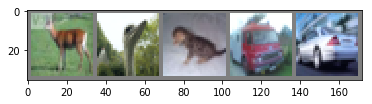

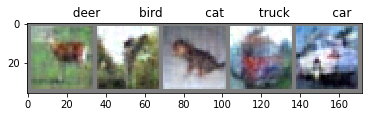

In [8]:
# train AE (on full train dataset)
t0 = time()
cnn = CNN()
model = AE(cnn).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, verbose=True)
criterion = nn.MSELoss()
model.train()
for epoch in range(50):
    running_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader_all):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('[epoch %d] loss: %.7f' % (epoch + 1, running_loss / (batch_idx + 1)))
    lr_scheduler.step(running_loss)
# save the cnn state
cnn_dict = deepcopy(model.encoder.state_dict())
t1 = time()
print("Took %.2d sec to train." % (t1 - t0))
# check how well some test images match
model.eval()
dataiter = iter(test_loader_all)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:5]))
images = images.to(device)
with torch.no_grad():
    reconstructed_images = model(images).cpu()
    imshow(torchvision.utils.make_grid(reconstructed_images[:5]))
plt.title(' '.join('%13s' % classes[labels[j]] for j in range(5)))
# use the pretrained model with the clf
test_accuracies_ae = []
for n_train in n_training_examples:
    print(n_train)
    test_accuracies_ae.append(clf_with_ntrain(n_train, cnn_dict))

[epoch 1] loss: 0.3140151
[epoch 2] loss: 0.1904510
[epoch 3] loss: 0.1650867
[epoch 4] loss: 0.1515929
[epoch 5] loss: 0.1440110
[epoch 6] loss: 0.1379243
[epoch 7] loss: 0.1343180
[epoch 8] loss: 0.1309230
[epoch 9] loss: 0.1283125
[epoch 10] loss: 0.1257787
[epoch 11] loss: 0.1235788
[epoch 12] loss: 0.1218627
[epoch 13] loss: 0.1199178
[epoch 14] loss: 0.1183935
[epoch 15] loss: 0.1170878
[epoch 16] loss: 0.1154505
[epoch 17] loss: 0.1139176
[epoch 18] loss: 0.1133424
[epoch 19] loss: 0.1120388
[epoch 20] loss: 0.1113448
[epoch 21] loss: 0.1101913
[epoch 22] loss: 0.1091934
[epoch 23] loss: 0.1087638
[epoch 24] loss: 0.1078929
[epoch 25] loss: 0.1073619
[epoch 26] loss: 0.1068852
[epoch 27] loss: 0.1060686
[epoch 28] loss: 0.1060049
[epoch 29] loss: 0.1050254
[epoch 30] loss: 0.1044404
[epoch 31] loss: 0.1042162
[epoch 32] loss: 0.1033754
[epoch 33] loss: 0.1023266
[epoch 34] loss: 0.1022135
[epoch 35] loss: 0.1020204
[epoch 36] loss: 0.1015543
[epoch 37] loss: 0.1012570
[epoch 38]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3124, Accuracy: 369/5000 (7%)
[epoch 1] loss: 2.3194385
Test set: Average loss: 2.3712, Accuracy: 482/5000 (10%)
[epoch 2] loss: 2.0320985
Test set: Average loss: 2.5460, Accuracy: 481/5000 (10%)
[epoch 3] loss: 1.8644969
Test set: Average loss: 2.6358, Accuracy: 523/5000 (10%)
[epoch 4] loss: 1.6967750
Test set: Average loss: 2.6303, Accuracy: 665/5000 (13%)
[epoch 5] loss: 1.4961116
Test set: Average loss: 2.6269, Accuracy: 665/5000 (13%)
[epoch 6] loss: 1.2814310
Test set: Average loss: 2.6580, Accuracy: 668/5000 (13%)
[epoch 7] loss: 1.0566111
Test set: Average loss: 2.7179, Accuracy: 678/5000 (14%)
[epoch 8] loss: 0.8253591
Test set: Average loss: 2.7996, Accuracy: 725/5000 (14%)
[epoch 9] loss: 0.6121258
Test set: Average loss: 2.9055, Accuracy: 752/5000 (15%)
[epoch 10] loss: 0.4349628
Test set: Average loss: 3.0385, Accuracy: 770/5000 (15%)
[epoch 11] loss: 0.2968901
Test set: Average loss: 3.1974, Ac

[epoch 45] loss: 0.0006046
Test set: Average loss: 5.4744, Accuracy: 764/5000 (15%)
[epoch 46] loss: 0.0005793
Test set: Average loss: 5.4874, Accuracy: 765/5000 (15%)
[epoch 47] loss: 0.0005564
Test set: Average loss: 5.4995, Accuracy: 766/5000 (15%)
[epoch 48] loss: 0.0005356
Test set: Average loss: 5.5109, Accuracy: 766/5000 (15%)
[epoch 49] loss: 0.0005167
Test set: Average loss: 5.5215, Accuracy: 765/5000 (15%)
[epoch 50] loss: 0.0004994
Test set: Average loss: 5.5316, Accuracy: 766/5000 (15%)
Validation:
Test set: Average loss: 2.9359, Accuracy: 800/5000 (16%)
Test
Test set: Average loss: 2.9390, Accuracy: 1645/10000 (16%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.2975, Accuracy: 583/5000 (12%)
[epoch 1] loss: 2.3010540
Test set: Average loss: 2.3784, Accuracy: 525/5000 (10%)
[epoch 2] loss: 1.9819212
Test set: Average loss: 2.5992, Accuracy: 525/5000 (10%)
[epoch 3] loss: 1.8244373
Test set: Average loss: 2.6642, Accuracy: 554/5000 (11%)
[epoch 4

[epoch 37] loss: 0.0027701
Test set: Average loss: 4.5967, Accuracy: 999/5000 (20%)
[epoch 38] loss: 0.0026401
Test set: Average loss: 4.6030, Accuracy: 1000/5000 (20%)
[epoch 39] loss: 0.0025995
Test set: Average loss: 4.6084, Accuracy: 1001/5000 (20%)
[epoch 40] loss: 0.0025320
Test set: Average loss: 4.6124, Accuracy: 996/5000 (20%)
[epoch 41] loss: 0.0025060
Test set: Average loss: 4.6151, Accuracy: 1000/5000 (20%)
[epoch 42] loss: 0.0023358
Test set: Average loss: 4.6178, Accuracy: 999/5000 (20%)
[epoch 43] loss: 0.0022761
Test set: Average loss: 4.6208, Accuracy: 1004/5000 (20%)
[epoch 44] loss: 0.0022390
Test set: Average loss: 4.6243, Accuracy: 1004/5000 (20%)
[epoch 45] loss: 0.0021354
Test set: Average loss: 4.6277, Accuracy: 1004/5000 (20%)
[epoch 46] loss: 0.0021531
Epoch    45: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 4.6313, Accuracy: 1003/5000 (20%)
[epoch 47] loss: 0.0020434
Test set: Average loss: 4.6317, Accuracy: 1003/5000 (20%)
[epoch

Test set: Average loss: 3.7602, Accuracy: 891/5000 (18%)
[epoch 23] loss: 0.0170633
Test set: Average loss: 3.8026, Accuracy: 890/5000 (18%)
[epoch 24] loss: 0.0130288
Test set: Average loss: 3.8276, Accuracy: 892/5000 (18%)
[epoch 25] loss: 0.0111180
Test set: Average loss: 3.8443, Accuracy: 900/5000 (18%)
[epoch 26] loss: 0.0090588
Test set: Average loss: 3.8590, Accuracy: 910/5000 (18%)
[epoch 27] loss: 0.0084035
Test set: Average loss: 3.8726, Accuracy: 911/5000 (18%)
[epoch 28] loss: 0.0074584
Test set: Average loss: 3.8889, Accuracy: 909/5000 (18%)
[epoch 29] loss: 0.0069630
Test set: Average loss: 3.9058, Accuracy: 913/5000 (18%)
[epoch 30] loss: 0.0063606
Test set: Average loss: 3.9256, Accuracy: 912/5000 (18%)
[epoch 31] loss: 0.0057706
Test set: Average loss: 3.9478, Accuracy: 913/5000 (18%)
[epoch 32] loss: 0.0053437
Test set: Average loss: 3.9714, Accuracy: 912/5000 (18%)
[epoch 33] loss: 0.0049119
Test set: Average loss: 3.9957, Accuracy: 911/5000 (18%)
[epoch 34] loss: 0.

[epoch 40] loss: 1.1873720
Epoch    39: reducing learning rate of group 0 to 1.0000e-32.
Test set: Average loss: 2.6008, Accuracy: 1001/5000 (20%)
[epoch 41] loss: 1.2065900
Epoch    40: reducing learning rate of group 0 to 1.0000e-33.
Test set: Average loss: 2.6008, Accuracy: 1001/5000 (20%)
[epoch 42] loss: 1.1425628
Epoch    41: reducing learning rate of group 0 to 1.0000e-34.
Test set: Average loss: 2.6008, Accuracy: 1001/5000 (20%)
[epoch 43] loss: 1.3096693
Epoch    42: reducing learning rate of group 0 to 1.0000e-35.
Test set: Average loss: 2.6008, Accuracy: 1001/5000 (20%)
[epoch 44] loss: 1.1794149
Epoch    43: reducing learning rate of group 0 to 1.0000e-36.
Test set: Average loss: 2.6008, Accuracy: 1001/5000 (20%)
[epoch 45] loss: 1.1820776
Epoch    44: reducing learning rate of group 0 to 1.0000e-37.
Test set: Average loss: 2.6008, Accuracy: 1001/5000 (20%)
[epoch 46] loss: 1.1988766
Epoch    45: reducing learning rate of group 0 to 1.0000e-38.
Test set: Average loss: 2.600

[epoch 50] loss: 0.7061369
Epoch    49: reducing learning rate of group 0 to 1.0000e-40.
Test set: Average loss: 2.3344, Accuracy: 1105/5000 (22%)
Validation:
Test set: Average loss: 2.3344, Accuracy: 1105/5000 (22%)
Test
Test set: Average loss: 2.3150, Accuracy: 2341/10000 (23%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3000, Accuracy: 530/5000 (11%)
[epoch 1] loss: 2.2807517
Test set: Average loss: 2.4343, Accuracy: 593/5000 (12%)
[epoch 2] loss: 2.1632782
Test set: Average loss: 2.3402, Accuracy: 816/5000 (16%)
[epoch 3] loss: 1.9547610
Test set: Average loss: 2.3812, Accuracy: 854/5000 (17%)
[epoch 4] loss: 1.4582514
Test set: Average loss: 2.5453, Accuracy: 881/5000 (18%)
[epoch 5] loss: 1.6308229
Epoch     4: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 2.6507, Accuracy: 872/5000 (17%)
[epoch 6] loss: 1.3445028
Test set: Average loss: 2.6368, Accuracy: 876/5000 (18%)
[epoch 7] loss: 1.3363495
Test set: Average loss: 2.6

Test set: Average loss: 2.7239, Accuracy: 1326/5000 (27%)
[epoch 14] loss: 0.0715899
Test set: Average loss: 2.7362, Accuracy: 1343/5000 (27%)
[epoch 15] loss: 0.0524533
Test set: Average loss: 2.8403, Accuracy: 1313/5000 (26%)
[epoch 16] loss: 0.0396060
Test set: Average loss: 2.8797, Accuracy: 1326/5000 (27%)
[epoch 17] loss: 0.0310588
Test set: Average loss: 2.8934, Accuracy: 1331/5000 (27%)
[epoch 18] loss: 0.0254651
Test set: Average loss: 2.9557, Accuracy: 1310/5000 (26%)
[epoch 19] loss: 0.0214350
Test set: Average loss: 2.9656, Accuracy: 1327/5000 (27%)
[epoch 20] loss: 0.0188835
Test set: Average loss: 2.9856, Accuracy: 1331/5000 (27%)
[epoch 21] loss: 0.0166719
Test set: Average loss: 3.0151, Accuracy: 1324/5000 (26%)
[epoch 22] loss: 0.0150948
Test set: Average loss: 3.0384, Accuracy: 1323/5000 (26%)
[epoch 23] loss: 0.0135792
Test set: Average loss: 3.0575, Accuracy: 1319/5000 (26%)
[epoch 24] loss: 0.0125080
Test set: Average loss: 3.0719, Accuracy: 1329/5000 (27%)
[epoch 

Test set: Average loss: 2.0137, Accuracy: 1437/5000 (29%)
[epoch 5] loss: 1.3590308
Test set: Average loss: 2.0393, Accuracy: 1438/5000 (29%)
[epoch 6] loss: 1.0912985
Test set: Average loss: 2.0902, Accuracy: 1437/5000 (29%)
[epoch 7] loss: 0.8826796
Test set: Average loss: 2.1701, Accuracy: 1529/5000 (31%)
[epoch 8] loss: 0.6415827
Test set: Average loss: 2.2635, Accuracy: 1520/5000 (30%)
[epoch 9] loss: 0.4755402
Test set: Average loss: 2.3519, Accuracy: 1493/5000 (30%)
[epoch 10] loss: 0.3202942
Test set: Average loss: 2.4578, Accuracy: 1518/5000 (30%)
[epoch 11] loss: 0.2146583
Test set: Average loss: 2.5491, Accuracy: 1479/5000 (30%)
[epoch 12] loss: 0.1522341
Test set: Average loss: 2.6394, Accuracy: 1542/5000 (31%)
[epoch 13] loss: 0.1000213
Test set: Average loss: 2.7203, Accuracy: 1476/5000 (30%)
[epoch 14] loss: 0.0698521
Test set: Average loss: 2.7928, Accuracy: 1508/5000 (30%)
[epoch 15] loss: 0.0521352
Test set: Average loss: 2.8196, Accuracy: 1498/5000 (30%)
[epoch 16] l

[epoch 48] loss: 0.0020749
Test set: Average loss: 3.3665, Accuracy: 1654/5000 (33%)
[epoch 49] loss: 0.0019643
Test set: Average loss: 3.3768, Accuracy: 1651/5000 (33%)
[epoch 50] loss: 0.0018900
Test set: Average loss: 3.3865, Accuracy: 1649/5000 (33%)
Validation:
Test set: Average loss: 1.9206, Accuracy: 1724/5000 (34%)
Test
Test set: Average loss: 1.8934, Accuracy: 3571/10000 (36%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.3102, Accuracy: 490/5000 (10%)
[epoch 1] loss: 2.2061688
Test set: Average loss: 2.1435, Accuracy: 1078/5000 (22%)
[epoch 2] loss: 1.9358703
Test set: Average loss: 2.0567, Accuracy: 1275/5000 (26%)
[epoch 3] loss: 1.6936746
Test set: Average loss: 1.9576, Accuracy: 1500/5000 (30%)
[epoch 4] loss: 1.4037769
Test set: Average loss: 1.9915, Accuracy: 1594/5000 (32%)
[epoch 5] loss: 1.2264269
Test set: Average loss: 1.9687, Accuracy: 1508/5000 (30%)
[epoch 6] loss: 0.9746718
Test set: Average loss: 2.0098, Accuracy: 1678/5000 (34%)
[

[epoch 39] loss: 0.0040370
Test set: Average loss: 3.1056, Accuracy: 1696/5000 (34%)
[epoch 40] loss: 0.0038028
Test set: Average loss: 3.1186, Accuracy: 1708/5000 (34%)
[epoch 41] loss: 0.0036291
Test set: Average loss: 3.1288, Accuracy: 1710/5000 (34%)
[epoch 42] loss: 0.0034621
Test set: Average loss: 3.1427, Accuracy: 1706/5000 (34%)
[epoch 43] loss: 0.0032759
Test set: Average loss: 3.1505, Accuracy: 1707/5000 (34%)
[epoch 44] loss: 0.0031434
Test set: Average loss: 3.1615, Accuracy: 1707/5000 (34%)
[epoch 45] loss: 0.0029757
Test set: Average loss: 3.1775, Accuracy: 1702/5000 (34%)
[epoch 46] loss: 0.0028349
Test set: Average loss: 3.1822, Accuracy: 1712/5000 (34%)
[epoch 47] loss: 0.0027152
Test set: Average loss: 3.1973, Accuracy: 1700/5000 (34%)
[epoch 48] loss: 0.0026078
Test set: Average loss: 3.2034, Accuracy: 1703/5000 (34%)
[epoch 49] loss: 0.0024890
Test set: Average loss: 3.2132, Accuracy: 1709/5000 (34%)
[epoch 50] loss: 0.0023960
Test set: Average loss: 3.2207, Accura

[epoch 30] loss: 0.0053688
Test set: Average loss: 3.0691, Accuracy: 1859/5000 (37%)
[epoch 31] loss: 0.0049442
Test set: Average loss: 3.0845, Accuracy: 1855/5000 (37%)
[epoch 32] loss: 0.0046496
Test set: Average loss: 3.1028, Accuracy: 1859/5000 (37%)
[epoch 33] loss: 0.0043066
Test set: Average loss: 3.1223, Accuracy: 1854/5000 (37%)
[epoch 34] loss: 0.0040383
Test set: Average loss: 3.1364, Accuracy: 1854/5000 (37%)
[epoch 35] loss: 0.0038391
Test set: Average loss: 3.1550, Accuracy: 1851/5000 (37%)
[epoch 36] loss: 0.0036107
Test set: Average loss: 3.1694, Accuracy: 1859/5000 (37%)
[epoch 37] loss: 0.0033972
Test set: Average loss: 3.1824, Accuracy: 1858/5000 (37%)
[epoch 38] loss: 0.0032042
Test set: Average loss: 3.1982, Accuracy: 1853/5000 (37%)
[epoch 39] loss: 0.0030075
Test set: Average loss: 3.2101, Accuracy: 1851/5000 (37%)
[epoch 40] loss: 0.0028690
Test set: Average loss: 3.2261, Accuracy: 1852/5000 (37%)
[epoch 41] loss: 0.0027324
Test set: Average loss: 3.2391, Accura

[epoch 21] loss: 0.0139637
Test set: Average loss: 2.8172, Accuracy: 1883/5000 (38%)
[epoch 22] loss: 0.0122667
Test set: Average loss: 2.8405, Accuracy: 1876/5000 (38%)
[epoch 23] loss: 0.0110488
Test set: Average loss: 2.8725, Accuracy: 1878/5000 (38%)
[epoch 24] loss: 0.0097418
Test set: Average loss: 2.8969, Accuracy: 1883/5000 (38%)
[epoch 25] loss: 0.0088431
Test set: Average loss: 2.9242, Accuracy: 1892/5000 (38%)
[epoch 26] loss: 0.0078495
Test set: Average loss: 2.9491, Accuracy: 1895/5000 (38%)
[epoch 27] loss: 0.0071876
Test set: Average loss: 2.9740, Accuracy: 1907/5000 (38%)
[epoch 28] loss: 0.0066264
Test set: Average loss: 2.9948, Accuracy: 1884/5000 (38%)
[epoch 29] loss: 0.0060298
Test set: Average loss: 3.0153, Accuracy: 1890/5000 (38%)
[epoch 30] loss: 0.0055976
Test set: Average loss: 3.0338, Accuracy: 1894/5000 (38%)
[epoch 31] loss: 0.0051892
Test set: Average loss: 3.0582, Accuracy: 1893/5000 (38%)
[epoch 32] loss: 0.0047537
Test set: Average loss: 3.0723, Accura

[epoch 12] loss: 0.2208507
Test set: Average loss: 2.2223, Accuracy: 1877/5000 (38%)
[epoch 13] loss: 0.1472036
Test set: Average loss: 2.2610, Accuracy: 1882/5000 (38%)
[epoch 14] loss: 0.0989269
Test set: Average loss: 2.3180, Accuracy: 1869/5000 (37%)
[epoch 15] loss: 0.0669840
Test set: Average loss: 2.3647, Accuracy: 1884/5000 (38%)
[epoch 16] loss: 0.0484193
Test set: Average loss: 2.3905, Accuracy: 1906/5000 (38%)
[epoch 17] loss: 0.0360009
Test set: Average loss: 2.4334, Accuracy: 1903/5000 (38%)
[epoch 18] loss: 0.0275110
Test set: Average loss: 2.4786, Accuracy: 1898/5000 (38%)
[epoch 19] loss: 0.0220406
Test set: Average loss: 2.5062, Accuracy: 1906/5000 (38%)
[epoch 20] loss: 0.0179743
Test set: Average loss: 2.5403, Accuracy: 1903/5000 (38%)
[epoch 21] loss: 0.0156443
Test set: Average loss: 2.5660, Accuracy: 1900/5000 (38%)
[epoch 22] loss: 0.0136377
Test set: Average loss: 2.5894, Accuracy: 1910/5000 (38%)
[epoch 23] loss: 0.0118186
Test set: Average loss: 2.6200, Accura

[epoch 42] loss: 0.0011023
Test set: Average loss: 2.9825, Accuracy: 2182/5000 (44%)
[epoch 43] loss: 0.0010280
Test set: Average loss: 2.9990, Accuracy: 2192/5000 (44%)
[epoch 44] loss: 0.0009694
Test set: Average loss: 3.0120, Accuracy: 2182/5000 (44%)
[epoch 45] loss: 0.0009094
Test set: Average loss: 3.0300, Accuracy: 2184/5000 (44%)
[epoch 46] loss: 0.0008562
Test set: Average loss: 3.0439, Accuracy: 2185/5000 (44%)
[epoch 47] loss: 0.0008010
Test set: Average loss: 3.0553, Accuracy: 2181/5000 (44%)
[epoch 48] loss: 0.0007557
Test set: Average loss: 3.0695, Accuracy: 2181/5000 (44%)
[epoch 49] loss: 0.0007105
Test set: Average loss: 3.0824, Accuracy: 2182/5000 (44%)
[epoch 50] loss: 0.0006678
Test set: Average loss: 3.0963, Accuracy: 2180/5000 (44%)
Validation:
Test set: Average loss: 1.5650, Accuracy: 2207/5000 (44%)
Test
Test set: Average loss: 1.5477, Accuracy: 4482/10000 (45%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.3012, Accuracy: 559/5000 (

[epoch 23] loss: 0.0256681
Test set: Average loss: 2.3338, Accuracy: 2218/5000 (44%)
[epoch 24] loss: 0.0256813
Epoch    23: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 2.3337, Accuracy: 2218/5000 (44%)
[epoch 25] loss: 0.1433697
Epoch    24: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 2.3337, Accuracy: 2218/5000 (44%)
[epoch 26] loss: 0.0254800
Test set: Average loss: 2.3337, Accuracy: 2218/5000 (44%)
[epoch 27] loss: 0.0255306
Epoch    26: reducing learning rate of group 0 to 1.0000e-09.
Test set: Average loss: 2.3337, Accuracy: 2218/5000 (44%)
[epoch 28] loss: 0.0257903
Epoch    27: reducing learning rate of group 0 to 1.0000e-10.
Test set: Average loss: 2.3337, Accuracy: 2218/5000 (44%)
[epoch 29] loss: 0.0255992
Epoch    28: reducing learning rate of group 0 to 1.0000e-11.
Test set: Average loss: 2.3337, Accuracy: 2218/5000 (44%)
[epoch 30] loss: 0.0256033
Epoch    29: reducing learning rate of group 0 to 1.0000e-12.
Test s

[epoch 48] loss: 0.0002182
Test set: Average loss: 2.8635, Accuracy: 2427/5000 (49%)
[epoch 49] loss: 0.0002000
Test set: Average loss: 2.8791, Accuracy: 2427/5000 (49%)
[epoch 50] loss: 0.0001815
Test set: Average loss: 2.8972, Accuracy: 2429/5000 (49%)
Validation:
Test set: Average loss: 2.1616, Accuracy: 2466/5000 (49%)
Test
Test set: Average loss: 2.1392, Accuracy: 4951/10000 (50%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.3100, Accuracy: 439/5000 (9%)
[epoch 1] loss: 1.8466471
Test set: Average loss: 1.6599, Accuracy: 1939/5000 (39%)
[epoch 2] loss: 1.5546721
Test set: Average loss: 1.5453, Accuracy: 2149/5000 (43%)
[epoch 3] loss: 1.4174728
Test set: Average loss: 1.4960, Accuracy: 2338/5000 (47%)
[epoch 4] loss: 1.2983458
Test set: Average loss: 1.5427, Accuracy: 2287/5000 (46%)
[epoch 5] loss: 1.1601628
Test set: Average loss: 1.5444, Accuracy: 2348/5000 (47%)
[epoch 6] loss: 1.0190125
Test set: Average loss: 1.5328, Accuracy: 2353/5000 (47%)
[e

[epoch 39] loss: 0.0005987
Test set: Average loss: 2.7533, Accuracy: 2369/5000 (47%)
[epoch 40] loss: 0.0005396
Test set: Average loss: 2.7744, Accuracy: 2357/5000 (47%)
[epoch 41] loss: 0.0004886
Test set: Average loss: 2.7933, Accuracy: 2376/5000 (48%)
[epoch 42] loss: 0.0004455
Test set: Average loss: 2.8131, Accuracy: 2366/5000 (47%)
[epoch 43] loss: 0.0004023
Test set: Average loss: 2.8396, Accuracy: 2356/5000 (47%)
[epoch 44] loss: 0.0003623
Test set: Average loss: 2.8560, Accuracy: 2370/5000 (47%)
[epoch 45] loss: 0.0003285
Test set: Average loss: 2.8716, Accuracy: 2368/5000 (47%)
[epoch 46] loss: 0.0002992
Test set: Average loss: 2.8946, Accuracy: 2358/5000 (47%)
[epoch 47] loss: 0.0002721
Test set: Average loss: 2.9138, Accuracy: 2362/5000 (47%)
[epoch 48] loss: 0.0002473
Test set: Average loss: 2.9312, Accuracy: 2362/5000 (47%)
[epoch 49] loss: 0.0002251
Test set: Average loss: 2.9508, Accuracy: 2357/5000 (47%)
[epoch 50] loss: 0.0002049
Test set: Average loss: 2.9782, Accura

[epoch 30] loss: 0.0003565
Test set: Average loss: 2.4266, Accuracy: 2677/5000 (54%)
[epoch 31] loss: 0.0002973
Test set: Average loss: 2.4601, Accuracy: 2669/5000 (53%)
[epoch 32] loss: 0.0002475
Test set: Average loss: 2.5025, Accuracy: 2684/5000 (54%)
[epoch 33] loss: 0.0002062
Test set: Average loss: 2.5333, Accuracy: 2689/5000 (54%)
[epoch 34] loss: 0.0001726
Test set: Average loss: 2.5595, Accuracy: 2676/5000 (54%)
[epoch 35] loss: 0.0001444
Test set: Average loss: 2.5943, Accuracy: 2679/5000 (54%)
[epoch 36] loss: 0.0001206
Test set: Average loss: 2.6208, Accuracy: 2683/5000 (54%)
[epoch 37] loss: 0.0001010
Test set: Average loss: 2.6599, Accuracy: 2678/5000 (54%)
[epoch 38] loss: 0.0000848
Test set: Average loss: 2.6936, Accuracy: 2674/5000 (53%)
[epoch 39] loss: 0.0000707
Test set: Average loss: 2.7233, Accuracy: 2669/5000 (53%)
[epoch 40] loss: 0.0000592
Test set: Average loss: 2.7535, Accuracy: 2663/5000 (53%)
[epoch 41] loss: 0.0000496
Test set: Average loss: 2.7858, Accura

[epoch 20] loss: 0.0104345
Test set: Average loss: 1.8671, Accuracy: 2768/5000 (55%)
[epoch 21] loss: 0.0098386
Test set: Average loss: 1.8690, Accuracy: 2770/5000 (55%)
[epoch 22] loss: 0.0092280
Test set: Average loss: 1.8714, Accuracy: 2776/5000 (56%)
[epoch 23] loss: 0.0086478
Test set: Average loss: 1.8749, Accuracy: 2778/5000 (56%)
[epoch 24] loss: 0.0080897
Test set: Average loss: 1.8777, Accuracy: 2774/5000 (55%)
[epoch 25] loss: 0.0075610
Test set: Average loss: 1.8830, Accuracy: 2786/5000 (56%)
[epoch 26] loss: 0.0070656
Test set: Average loss: 1.8872, Accuracy: 2782/5000 (56%)
[epoch 27] loss: 0.0066019
Test set: Average loss: 1.8920, Accuracy: 2784/5000 (56%)
[epoch 28] loss: 0.0061719
Test set: Average loss: 1.8970, Accuracy: 2782/5000 (56%)
[epoch 29] loss: 0.0057735
Test set: Average loss: 1.9030, Accuracy: 2782/5000 (56%)
[epoch 30] loss: 0.0054075
Test set: Average loss: 1.9103, Accuracy: 2782/5000 (56%)
[epoch 31] loss: 0.0050648
Test set: Average loss: 1.9166, Accura

Test set: Average loss: 1.7373, Accuracy: 2716/5000 (54%)
[epoch 44] loss: 0.0967610
Epoch    43: reducing learning rate of group 0 to 1.0000e-33.
Test set: Average loss: 1.7373, Accuracy: 2716/5000 (54%)
[epoch 45] loss: 0.0967424
Epoch    44: reducing learning rate of group 0 to 1.0000e-34.
Test set: Average loss: 1.7373, Accuracy: 2716/5000 (54%)
[epoch 46] loss: 0.0967494
Epoch    45: reducing learning rate of group 0 to 1.0000e-35.
Test set: Average loss: 1.7373, Accuracy: 2716/5000 (54%)
[epoch 47] loss: 0.0967614
Epoch    46: reducing learning rate of group 0 to 1.0000e-36.
Test set: Average loss: 1.7373, Accuracy: 2716/5000 (54%)
[epoch 48] loss: 0.0967752
Epoch    47: reducing learning rate of group 0 to 1.0000e-37.
Test set: Average loss: 1.7373, Accuracy: 2716/5000 (54%)
[epoch 49] loss: 0.0967468
Epoch    48: reducing learning rate of group 0 to 1.0000e-38.
Test set: Average loss: 1.7373, Accuracy: 2716/5000 (54%)
[epoch 50] loss: 0.0967564
Epoch    49: reducing learning ra

[epoch 29] loss: 0.0010043
Test set: Average loss: 2.1470, Accuracy: 2938/5000 (59%)
[epoch 30] loss: 0.0007824
Test set: Average loss: 2.1825, Accuracy: 2939/5000 (59%)
[epoch 31] loss: 0.0006123
Test set: Average loss: 2.2227, Accuracy: 2936/5000 (59%)
[epoch 32] loss: 0.0004751
Test set: Average loss: 2.2723, Accuracy: 2946/5000 (59%)
[epoch 33] loss: 0.0003660
Test set: Average loss: 2.3129, Accuracy: 2943/5000 (59%)
[epoch 34] loss: 0.0002831
Test set: Average loss: 2.3494, Accuracy: 2946/5000 (59%)
[epoch 35] loss: 0.0002177
Test set: Average loss: 2.3952, Accuracy: 2945/5000 (59%)
[epoch 36] loss: 0.0001671
Test set: Average loss: 2.4482, Accuracy: 2941/5000 (59%)
[epoch 37] loss: 0.0001281
Test set: Average loss: 2.4880, Accuracy: 2935/5000 (59%)
[epoch 38] loss: 0.0000976
Test set: Average loss: 2.5327, Accuracy: 2940/5000 (59%)
[epoch 39] loss: 0.0000746
Test set: Average loss: 2.5743, Accuracy: 2944/5000 (59%)
[epoch 40] loss: 0.0000569
Test set: Average loss: 2.6293, Accura

[epoch 18] loss: 0.0143881
Test set: Average loss: 1.7798, Accuracy: 2916/5000 (58%)
[epoch 19] loss: 0.0113193
Test set: Average loss: 1.7969, Accuracy: 2928/5000 (59%)
[epoch 20] loss: 0.0090202
Test set: Average loss: 1.8166, Accuracy: 2919/5000 (58%)
[epoch 21] loss: 0.0072656
Test set: Average loss: 1.8352, Accuracy: 2938/5000 (59%)
[epoch 22] loss: 0.0058601
Test set: Average loss: 1.8605, Accuracy: 2943/5000 (59%)
[epoch 23] loss: 0.0047042
Test set: Average loss: 1.8911, Accuracy: 2942/5000 (59%)
[epoch 24] loss: 0.0037842
Test set: Average loss: 1.9116, Accuracy: 2949/5000 (59%)
[epoch 25] loss: 0.0030274
Test set: Average loss: 1.9389, Accuracy: 2941/5000 (59%)
[epoch 26] loss: 0.0024033
Test set: Average loss: 1.9761, Accuracy: 2945/5000 (59%)
[epoch 27] loss: 0.0019043
Test set: Average loss: 2.0079, Accuracy: 2943/5000 (59%)
[epoch 28] loss: 0.0015017
Test set: Average loss: 2.0399, Accuracy: 2942/5000 (59%)
[epoch 29] loss: 0.0011773
Test set: Average loss: 2.0840, Accura

Test set: Average loss: 1.3230, Accuracy: 2914/5000 (58%)
[epoch 9] loss: 0.4154308
Test set: Average loss: 1.4611, Accuracy: 2839/5000 (57%)
[epoch 10] loss: 0.3076306
Test set: Average loss: 1.4585, Accuracy: 2968/5000 (59%)
[epoch 11] loss: 0.2191394
Test set: Average loss: 1.6026, Accuracy: 2909/5000 (58%)
[epoch 12] loss: 0.1923158
Test set: Average loss: 1.6802, Accuracy: 2921/5000 (58%)
[epoch 13] loss: 0.1626385
Test set: Average loss: 1.7827, Accuracy: 2848/5000 (57%)
[epoch 14] loss: 0.1509970
Test set: Average loss: 1.8902, Accuracy: 2840/5000 (57%)
[epoch 15] loss: 0.1830643
Epoch    14: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.8973, Accuracy: 2888/5000 (58%)
[epoch 16] loss: 0.0635882
Test set: Average loss: 1.7707, Accuracy: 3038/5000 (61%)
[epoch 17] loss: 0.0230351
Test set: Average loss: 1.7851, Accuracy: 3035/5000 (61%)
[epoch 18] loss: 0.0150403
Test set: Average loss: 1.7920, Accuracy: 3045/5000 (61%)
[epoch 19] loss: 0.0110265
Test

Test set: Average loss: 2.9787, Accuracy: 3050/5000 (61%)
Test
Test set: Average loss: 2.8915, Accuracy: 6129/10000 (61%)
30000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3002, Accuracy: 504/5000 (10%)
[epoch 1] loss: 1.5499709
Test set: Average loss: 1.3685, Accuracy: 2533/5000 (51%)
[epoch 2] loss: 1.3001422
Test set: Average loss: 1.2977, Accuracy: 2687/5000 (54%)
[epoch 3] loss: 1.1788254
Test set: Average loss: 1.2613, Accuracy: 2807/5000 (56%)
[epoch 4] loss: 1.0703500
Test set: Average loss: 1.2473, Accuracy: 2782/5000 (56%)
[epoch 5] loss: 0.9754728
Test set: Average loss: 1.2006, Accuracy: 2884/5000 (58%)
[epoch 6] loss: 0.8680903
Test set: Average loss: 1.2128, Accuracy: 2908/5000 (58%)
[epoch 7] loss: 0.7598117
Test set: Average loss: 1.2194, Accuracy: 2968/5000 (59%)
[epoch 8] loss: 0.6403886
Test set: Average loss: 1.2515, Accuracy: 2984/5000 (60%)
[epoch 9] loss: 0.5270382
Test set: Average loss: 1.3691, Accuracy: 2928/5000 (59%)
[epoch 10]

Test set: Average loss: 2.2189, Accuracy: 2891/5000 (58%)
[epoch 29] loss: 0.0038022
Test set: Average loss: 2.2418, Accuracy: 2896/5000 (58%)
[epoch 30] loss: 0.0028266
Test set: Average loss: 2.2666, Accuracy: 2897/5000 (58%)
[epoch 31] loss: 0.0021062
Test set: Average loss: 2.3008, Accuracy: 2908/5000 (58%)
[epoch 32] loss: 0.0015368
Test set: Average loss: 2.3296, Accuracy: 2901/5000 (58%)
[epoch 33] loss: 0.0011265
Test set: Average loss: 2.3587, Accuracy: 2906/5000 (58%)
[epoch 34] loss: 0.0008236
Test set: Average loss: 2.4025, Accuracy: 2910/5000 (58%)
[epoch 35] loss: 0.0005928
Test set: Average loss: 2.4428, Accuracy: 2904/5000 (58%)
[epoch 36] loss: 0.0004293
Test set: Average loss: 2.4952, Accuracy: 2898/5000 (58%)
[epoch 37] loss: 0.0003073
Test set: Average loss: 2.5385, Accuracy: 2911/5000 (58%)
[epoch 38] loss: 0.0002206
Test set: Average loss: 2.5874, Accuracy: 2902/5000 (58%)
[epoch 39] loss: 0.0001581
Test set: Average loss: 2.6424, Accuracy: 2909/5000 (58%)
[epoch 

[epoch 18] loss: 0.0109755
Test set: Average loss: 1.7660, Accuracy: 3072/5000 (61%)
[epoch 19] loss: 0.0078338
Test set: Average loss: 1.7937, Accuracy: 3080/5000 (62%)
[epoch 20] loss: 0.0055322
Test set: Average loss: 1.8331, Accuracy: 3080/5000 (62%)
[epoch 21] loss: 0.0038982
Test set: Average loss: 1.8716, Accuracy: 3085/5000 (62%)
[epoch 22] loss: 0.0027141
Test set: Average loss: 1.9210, Accuracy: 3082/5000 (62%)
[epoch 23] loss: 0.0018758
Test set: Average loss: 1.9637, Accuracy: 3078/5000 (62%)
[epoch 24] loss: 0.0012852
Test set: Average loss: 2.0114, Accuracy: 3084/5000 (62%)
[epoch 25] loss: 0.0008738
Test set: Average loss: 2.0730, Accuracy: 3094/5000 (62%)
[epoch 26] loss: 0.0005906
Test set: Average loss: 2.1228, Accuracy: 3102/5000 (62%)
[epoch 27] loss: 0.0004000
Test set: Average loss: 2.1871, Accuracy: 3093/5000 (62%)
[epoch 28] loss: 0.0002718
Test set: Average loss: 2.2484, Accuracy: 3101/5000 (62%)
[epoch 29] loss: 0.0001788
Test set: Average loss: 2.3216, Accura

Test set: Average loss: 1.2334, Accuracy: 2984/5000 (60%)
[epoch 9] loss: 0.5855128
Test set: Average loss: 1.3022, Accuracy: 2961/5000 (59%)
[epoch 10] loss: 0.4900215
Test set: Average loss: 1.3272, Accuracy: 2994/5000 (60%)
[epoch 11] loss: 0.3885712
Test set: Average loss: 1.4724, Accuracy: 2930/5000 (59%)
[epoch 12] loss: 0.3295723
Test set: Average loss: 1.5215, Accuracy: 2941/5000 (59%)
[epoch 13] loss: 0.2732831
Test set: Average loss: 1.5907, Accuracy: 2953/5000 (59%)
[epoch 14] loss: 0.2265396
Test set: Average loss: 1.7082, Accuracy: 2908/5000 (58%)
[epoch 15] loss: 0.2216848
Test set: Average loss: 1.7219, Accuracy: 2908/5000 (58%)
[epoch 16] loss: 0.2029570
Test set: Average loss: 1.8679, Accuracy: 2873/5000 (57%)
[epoch 17] loss: 0.1975786
Test set: Average loss: 1.8742, Accuracy: 2876/5000 (58%)
[epoch 18] loss: 0.1720291
Test set: Average loss: 1.9426, Accuracy: 2910/5000 (58%)
[epoch 19] loss: 0.1751042
Epoch    18: reducing learning rate of group 0 to 1.0000e-04.
Test

Test set: Average loss: 3.0699, Accuracy: 3110/5000 (62%)
Test
Test set: Average loss: 3.0383, Accuracy: 6239/10000 (62%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.3080, Accuracy: 475/5000 (10%)
[epoch 1] loss: 1.5078065
Test set: Average loss: 1.3221, Accuracy: 2666/5000 (53%)
[epoch 2] loss: 1.2552307
Test set: Average loss: 1.2502, Accuracy: 2731/5000 (55%)
[epoch 3] loss: 1.1215240
Test set: Average loss: 1.1651, Accuracy: 2938/5000 (59%)
[epoch 4] loss: 1.0188574
Test set: Average loss: 1.1491, Accuracy: 2971/5000 (59%)
[epoch 5] loss: 0.9343090
Test set: Average loss: 1.1077, Accuracy: 3052/5000 (61%)
[epoch 6] loss: 0.8547348
Test set: Average loss: 1.1360, Accuracy: 3040/5000 (61%)
[epoch 7] loss: 0.7679417
Test set: Average loss: 1.1119, Accuracy: 3094/5000 (62%)
[epoch 8] loss: 0.6923497
Test set: Average loss: 1.1375, Accuracy: 3160/5000 (63%)
[epoch 9] loss: 0.6049012
Test set: Average loss: 1.1989, Accuracy: 3101/5000 (62%)
[epoch 10] loss:

[epoch 35] loss: 0.0000540
Test set: Average loss: 2.5449, Accuracy: 3120/5000 (62%)
[epoch 36] loss: 0.0000349
Test set: Average loss: 2.6157, Accuracy: 3118/5000 (62%)
[epoch 37] loss: 0.0000225
Test set: Average loss: 2.6910, Accuracy: 3123/5000 (62%)
[epoch 38] loss: 0.0000145
Test set: Average loss: 2.7584, Accuracy: 3122/5000 (62%)
[epoch 39] loss: 0.0000093
Test set: Average loss: 2.8314, Accuracy: 3132/5000 (63%)
[epoch 40] loss: 0.0000060
Test set: Average loss: 2.9013, Accuracy: 3119/5000 (62%)
[epoch 41] loss: 0.0000038
Test set: Average loss: 2.9753, Accuracy: 3107/5000 (62%)
[epoch 42] loss: 0.0000024
Test set: Average loss: 3.0431, Accuracy: 3112/5000 (62%)
[epoch 43] loss: 0.0000015
Test set: Average loss: 3.1133, Accuracy: 3110/5000 (62%)
[epoch 44] loss: 0.0000009
Test set: Average loss: 3.1670, Accuracy: 3106/5000 (62%)
[epoch 45] loss: 0.0000006
Test set: Average loss: 3.1983, Accuracy: 3100/5000 (62%)
[epoch 46] loss: 0.0000004
Test set: Average loss: 3.2279, Accura

[epoch 24] loss: 0.0138926
Test set: Average loss: 1.7986, Accuracy: 3174/5000 (63%)
[epoch 25] loss: 0.0093009
Test set: Average loss: 1.8347, Accuracy: 3177/5000 (64%)
[epoch 26] loss: 0.0062472
Test set: Average loss: 1.8786, Accuracy: 3196/5000 (64%)
[epoch 27] loss: 0.0042404
Test set: Average loss: 1.9182, Accuracy: 3189/5000 (64%)
[epoch 28] loss: 0.0028452
Test set: Average loss: 1.9717, Accuracy: 3184/5000 (64%)
[epoch 29] loss: 0.0018783
Test set: Average loss: 2.0270, Accuracy: 3199/5000 (64%)
[epoch 30] loss: 0.0012303
Test set: Average loss: 2.0744, Accuracy: 3220/5000 (64%)
[epoch 31] loss: 0.0008198
Test set: Average loss: 2.1407, Accuracy: 3210/5000 (64%)
[epoch 32] loss: 0.0005338
Test set: Average loss: 2.2088, Accuracy: 3217/5000 (64%)
[epoch 33] loss: 0.0003462
Test set: Average loss: 2.2740, Accuracy: 3217/5000 (64%)
[epoch 34] loss: 0.0002234
Test set: Average loss: 2.3515, Accuracy: 3209/5000 (64%)
[epoch 35] loss: 0.0001423
Test set: Average loss: 2.4269, Accura

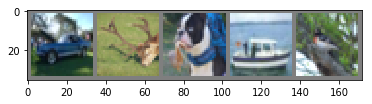

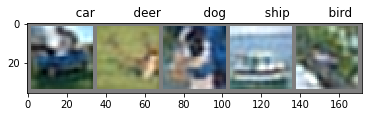

In [9]:
# train simplified 1 linear layer decoder AE
t0 = time()
cnn = CNN()
model = AE1L(cnn).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, verbose=True)
criterion = nn.MSELoss()
model.train()
for epoch in range(50):
    running_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader_all):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('[epoch %d] loss: %.7f' % (epoch + 1, running_loss / (batch_idx + 1)))
    lr_scheduler.step(running_loss)
# save the cnn state
cnn_dict = deepcopy(model.encoder.state_dict())
t1 = time()
print("Took %.2d sec to train." % (t1 - t0))
# check how well some test images match
model.eval()
dataiter = iter(test_loader_all)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:5]))
images = images.to(device)
with torch.no_grad():
    reconstructed_images = model(images).cpu()
    imshow(torchvision.utils.make_grid(reconstructed_images[:5]))
plt.title(' '.join('%13s' % classes[labels[j]] for j in range(5)))
# use the pretrained model with the clf
test_accuracies_ae1l = []
for n_train in n_training_examples:
    print(n_train)
    test_accuracies_ae1l.append(clf_with_ntrain(n_train, cnn_dict))

### Pretraining with SimEc (unsupervised (t1+t2) and supervised (t1))

In [10]:
# transform data into a numpy matrix by first applying the required transformations manually
n_targets = 3000
X = np.stack([train_dataset.transform(train_dataset.data[i]).numpy() for i in indices])
# compute similarity matrix for n_targets
X_flat = X.reshape(X.shape[0], 3*32*32)
S = linear_kernel(X_flat, X_flat[:n_targets])
S -= S.min()
S /= S.max()
S_ll = S[:n_targets, :]
del X_flat

In [11]:
# check what the similarity approximation *should* be
D, V = np.linalg.eig(S_ll)
D, V = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed = np.dot(V.real, np.diag(np.sqrt(np.abs(D.real))))
print(check_similarity_match(X_embed[:n_targets,:512], S_ll))

(5.1470783e-09, 0.9999974966064862, 0.9999981368566736)


In [12]:
# train the SimEc
t0 = time()
cnn = CNN()
model = SimilarityEncoder(cnn, 512, n_targets)
model.fit(X, S, epochs=50, lr=0.000001, s_ll_reg=100., S_ll=S_ll, orth_reg=0.1)
print(check_similarity_match(model.predict(X[:n_targets]), S_ll, X_embed_is_S_approx=True))
print(check_similarity_match(model.transform(X[:n_targets]), S_ll))
# save the cnn state
cnn_dict = deepcopy(model.model.embedding_net.state_dict())
t1 = time()
print("Took %.2d sec to train." % (t1 - t0))
# use the pretrained model with the clf
test_accuracies_se = []
for n_train in n_training_examples:
    print(n_train)
    test_accuracies_se.append(clf_with_ntrain(n_train, cnn_dict))

[epoch 1] loss: 0.1393181
[epoch 2] loss: 0.0329879
[epoch 3] loss: 0.0193295
[epoch 4] loss: 0.0131776
[epoch 5] loss: 0.0092021
[epoch 6] loss: 0.0067313
[epoch 7] loss: 0.0054195
[epoch 8] loss: 0.0047080
[epoch 9] loss: 0.0042391
[epoch 10] loss: 0.0038878
[epoch 11] loss: 0.0036100
[epoch 12] loss: 0.0033830
[epoch 13] loss: 0.0031934
[epoch 14] loss: 0.0030322
[epoch 15] loss: 0.0028943
[epoch 16] loss: 0.0027732
[epoch 17] loss: 0.0026661
[epoch 18] loss: 0.0025614
[epoch 19] loss: 0.0024557
[epoch 20] loss: 0.0023416
[epoch 21] loss: 0.0022039
[epoch 22] loss: 0.0020542
[epoch 23] loss: 0.0018843
[epoch 24] loss: 0.0015925
[epoch 25] loss: 0.0011582
[epoch 26] loss: 0.0008302
[epoch 27] loss: 0.0006890
[epoch 28] loss: 0.0006135
[epoch 29] loss: 0.0005397
[epoch 30] loss: 0.0004701
[epoch 31] loss: 0.0004066
[epoch 32] loss: 0.0003495
[epoch 33] loss: 0.0002999
[epoch 34] loss: 0.0002581
[epoch 35] loss: 0.0002223
[epoch 36] loss: 0.0001912
[epoch 37] loss: 0.0001649
[epoch 38]

Test set: Average loss: 6.5739, Accuracy: 731/5000 (15%)
[epoch 28] loss: 0.0017593
Test set: Average loss: 6.6974, Accuracy: 734/5000 (15%)
[epoch 29] loss: 0.0013926
Test set: Average loss: 6.8121, Accuracy: 723/5000 (14%)
[epoch 30] loss: 0.0011312
Test set: Average loss: 6.9183, Accuracy: 723/5000 (14%)
[epoch 31] loss: 0.0009433
Test set: Average loss: 7.0163, Accuracy: 723/5000 (14%)
[epoch 32] loss: 0.0008067
Test set: Average loss: 7.1063, Accuracy: 723/5000 (14%)
[epoch 33] loss: 0.0007058
Test set: Average loss: 7.1888, Accuracy: 725/5000 (14%)
[epoch 34] loss: 0.0006293
Test set: Average loss: 7.2641, Accuracy: 723/5000 (14%)
[epoch 35] loss: 0.0005690
Test set: Average loss: 7.3327, Accuracy: 716/5000 (14%)
[epoch 36] loss: 0.0005187
Test set: Average loss: 7.3950, Accuracy: 715/5000 (14%)
[epoch 37] loss: 0.0004750
Test set: Average loss: 7.4516, Accuracy: 714/5000 (14%)
[epoch 38] loss: 0.0004356
Test set: Average loss: 7.5029, Accuracy: 718/5000 (14%)
[epoch 39] loss: 0.

[epoch 20] loss: 0.0138861
Test set: Average loss: 5.6484, Accuracy: 973/5000 (19%)
[epoch 21] loss: 0.0097432
Test set: Average loss: 5.7713, Accuracy: 977/5000 (20%)
[epoch 22] loss: 0.0069699
Test set: Average loss: 5.8560, Accuracy: 981/5000 (20%)
[epoch 23] loss: 0.0055700
Test set: Average loss: 5.9152, Accuracy: 977/5000 (20%)
[epoch 24] loss: 0.0041432
Test set: Average loss: 5.9552, Accuracy: 985/5000 (20%)
[epoch 25] loss: 0.0032183
Test set: Average loss: 5.9956, Accuracy: 983/5000 (20%)
[epoch 26] loss: 0.0028812
Test set: Average loss: 6.0370, Accuracy: 989/5000 (20%)
[epoch 27] loss: 0.0023089
Test set: Average loss: 6.0806, Accuracy: 986/5000 (20%)
[epoch 28] loss: 0.0022959
Test set: Average loss: 6.1236, Accuracy: 989/5000 (20%)
[epoch 29] loss: 0.0019503
Test set: Average loss: 6.1662, Accuracy: 999/5000 (20%)
[epoch 30] loss: 0.0018351
Test set: Average loss: 6.2071, Accuracy: 995/5000 (20%)
[epoch 31] loss: 0.0016635
Test set: Average loss: 6.2446, Accuracy: 991/500

[epoch 5] loss: 1.5944341
Test set: Average loss: 2.3988, Accuracy: 853/5000 (17%)
[epoch 6] loss: 1.4699259
Test set: Average loss: 2.5587, Accuracy: 863/5000 (17%)
[epoch 7] loss: 1.2909182
Test set: Average loss: 2.8061, Accuracy: 897/5000 (18%)
[epoch 8] loss: 1.0940140
Test set: Average loss: 2.8518, Accuracy: 943/5000 (19%)
[epoch 9] loss: 0.9130111
Test set: Average loss: 2.8639, Accuracy: 932/5000 (19%)
[epoch 10] loss: 0.7529853
Test set: Average loss: 2.9441, Accuracy: 961/5000 (19%)
[epoch 11] loss: 0.6741250
Test set: Average loss: 3.2499, Accuracy: 887/5000 (18%)
[epoch 12] loss: 0.4419291
Test set: Average loss: 3.6690, Accuracy: 875/5000 (18%)
[epoch 13] loss: 0.4058663
Test set: Average loss: 3.7691, Accuracy: 899/5000 (18%)
[epoch 14] loss: 0.2469993
Test set: Average loss: 3.8651, Accuracy: 934/5000 (19%)
[epoch 15] loss: 0.2199968
Test set: Average loss: 3.9966, Accuracy: 953/5000 (19%)
[epoch 16] loss: 0.1592345
Test set: Average loss: 4.1569, Accuracy: 938/5000 (19

Test set: Average loss: 2.3521, Accuracy: 871/5000 (17%)
[epoch 27] loss: 1.6832741
Epoch    26: reducing learning rate of group 0 to 1.0000e-25.
Test set: Average loss: 2.3521, Accuracy: 871/5000 (17%)
[epoch 28] loss: 1.7442583
Epoch    27: reducing learning rate of group 0 to 1.0000e-26.
Test set: Average loss: 2.3521, Accuracy: 871/5000 (17%)
[epoch 29] loss: 1.9592626
Epoch    28: reducing learning rate of group 0 to 1.0000e-27.
Test set: Average loss: 2.3521, Accuracy: 871/5000 (17%)
[epoch 30] loss: 1.7364541
Epoch    29: reducing learning rate of group 0 to 1.0000e-28.
Test set: Average loss: 2.3521, Accuracy: 871/5000 (17%)
[epoch 31] loss: 1.8098247
Epoch    30: reducing learning rate of group 0 to 1.0000e-29.
Test set: Average loss: 2.3521, Accuracy: 871/5000 (17%)
[epoch 32] loss: 1.5612310
Epoch    31: reducing learning rate of group 0 to 1.0000e-30.
Test set: Average loss: 2.3521, Accuracy: 871/5000 (17%)
[epoch 33] loss: 1.7356646
Epoch    32: reducing learning rate of g

[epoch 35] loss: 1.7294502
Epoch    34: reducing learning rate of group 0 to 1.0000e-29.
Test set: Average loss: 2.2151, Accuracy: 1021/5000 (20%)
[epoch 36] loss: 1.7592334
Epoch    35: reducing learning rate of group 0 to 1.0000e-30.
Test set: Average loss: 2.2151, Accuracy: 1021/5000 (20%)
[epoch 37] loss: 1.7577040
Epoch    36: reducing learning rate of group 0 to 1.0000e-31.
Test set: Average loss: 2.2151, Accuracy: 1021/5000 (20%)
[epoch 38] loss: 1.7106058
Epoch    37: reducing learning rate of group 0 to 1.0000e-32.
Test set: Average loss: 2.2151, Accuracy: 1021/5000 (20%)
[epoch 39] loss: 1.8040525
Epoch    38: reducing learning rate of group 0 to 1.0000e-33.
Test set: Average loss: 2.2151, Accuracy: 1021/5000 (20%)
[epoch 40] loss: 1.7359855
Epoch    39: reducing learning rate of group 0 to 1.0000e-34.
Test set: Average loss: 2.2151, Accuracy: 1021/5000 (20%)
[epoch 41] loss: 1.7196858
Epoch    40: reducing learning rate of group 0 to 1.0000e-35.
Test set: Average loss: 2.215

Test set: Average loss: 3.1466, Accuracy: 941/5000 (19%)
[epoch 46] loss: 0.7780232
Epoch    45: reducing learning rate of group 0 to 1.0000e-35.
Test set: Average loss: 3.1466, Accuracy: 941/5000 (19%)
[epoch 47] loss: 0.8901805
Epoch    46: reducing learning rate of group 0 to 1.0000e-36.
Test set: Average loss: 3.1466, Accuracy: 941/5000 (19%)
[epoch 48] loss: 0.9221103
Epoch    47: reducing learning rate of group 0 to 1.0000e-37.
Test set: Average loss: 3.1466, Accuracy: 941/5000 (19%)
[epoch 49] loss: 0.8810097
Epoch    48: reducing learning rate of group 0 to 1.0000e-38.
Test set: Average loss: 3.1466, Accuracy: 941/5000 (19%)
[epoch 50] loss: 0.8942665
Epoch    49: reducing learning rate of group 0 to 1.0000e-39.
Test set: Average loss: 3.1466, Accuracy: 941/5000 (19%)
Validation:
Test set: Average loss: 2.5742, Accuracy: 1053/5000 (21%)
Test
Test set: Average loss: 2.5864, Accuracy: 2083/10000 (21%)
250
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.

[epoch 33] loss: 0.0039814
Test set: Average loss: 4.2366, Accuracy: 1557/5000 (31%)
[epoch 34] loss: 0.0038053
Test set: Average loss: 4.2577, Accuracy: 1558/5000 (31%)
[epoch 35] loss: 0.0035414
Test set: Average loss: 4.2746, Accuracy: 1569/5000 (31%)
[epoch 36] loss: 0.0033888
Test set: Average loss: 4.2940, Accuracy: 1572/5000 (31%)
[epoch 37] loss: 0.0031668
Test set: Average loss: 4.3261, Accuracy: 1561/5000 (31%)
[epoch 38] loss: 0.0029827
Test set: Average loss: 4.3421, Accuracy: 1565/5000 (31%)
[epoch 39] loss: 0.0028026
Test set: Average loss: 4.3619, Accuracy: 1570/5000 (31%)
[epoch 40] loss: 0.0026942
Test set: Average loss: 4.3779, Accuracy: 1565/5000 (31%)
[epoch 41] loss: 0.0025151
Test set: Average loss: 4.4042, Accuracy: 1566/5000 (31%)
[epoch 42] loss: 0.0024095
Test set: Average loss: 4.4216, Accuracy: 1569/5000 (31%)
[epoch 43] loss: 0.0023152
Test set: Average loss: 4.4374, Accuracy: 1572/5000 (31%)
[epoch 44] loss: 0.0021951
Test set: Average loss: 4.4550, Accura

[epoch 24] loss: 0.0048706
Test set: Average loss: 4.2268, Accuracy: 1695/5000 (34%)
[epoch 25] loss: 0.0044653
Test set: Average loss: 4.2691, Accuracy: 1694/5000 (34%)
[epoch 26] loss: 0.0040495
Test set: Average loss: 4.2954, Accuracy: 1700/5000 (34%)
[epoch 27] loss: 0.0037611
Test set: Average loss: 4.3341, Accuracy: 1694/5000 (34%)
[epoch 28] loss: 0.0034523
Test set: Average loss: 4.3646, Accuracy: 1704/5000 (34%)
[epoch 29] loss: 0.0031765
Test set: Average loss: 4.4016, Accuracy: 1697/5000 (34%)
[epoch 30] loss: 0.0029661
Test set: Average loss: 4.4322, Accuracy: 1705/5000 (34%)
[epoch 31] loss: 0.0027269
Test set: Average loss: 4.4539, Accuracy: 1696/5000 (34%)
[epoch 32] loss: 0.0025819
Test set: Average loss: 4.4845, Accuracy: 1695/5000 (34%)
[epoch 33] loss: 0.0024198
Test set: Average loss: 4.5100, Accuracy: 1695/5000 (34%)
[epoch 34] loss: 0.0022847
Test set: Average loss: 4.5361, Accuracy: 1704/5000 (34%)
[epoch 35] loss: 0.0021340
Test set: Average loss: 4.5558, Accura

[epoch 15] loss: 0.1081534
Test set: Average loss: 3.6640, Accuracy: 1581/5000 (32%)
[epoch 16] loss: 0.0599617
Test set: Average loss: 3.8779, Accuracy: 1611/5000 (32%)
[epoch 17] loss: 0.0484078
Test set: Average loss: 4.0082, Accuracy: 1595/5000 (32%)
[epoch 18] loss: 0.0349047
Test set: Average loss: 4.0678, Accuracy: 1633/5000 (33%)
[epoch 19] loss: 0.0199189
Test set: Average loss: 4.1613, Accuracy: 1601/5000 (32%)
[epoch 20] loss: 0.0118822
Test set: Average loss: 4.1772, Accuracy: 1637/5000 (33%)
[epoch 21] loss: 0.0082746
Test set: Average loss: 4.2499, Accuracy: 1648/5000 (33%)
[epoch 22] loss: 0.0063438
Test set: Average loss: 4.3162, Accuracy: 1637/5000 (33%)
[epoch 23] loss: 0.0056944
Test set: Average loss: 4.3579, Accuracy: 1643/5000 (33%)
[epoch 24] loss: 0.0048702
Test set: Average loss: 4.4055, Accuracy: 1655/5000 (33%)
[epoch 25] loss: 0.0043879
Test set: Average loss: 4.4475, Accuracy: 1661/5000 (33%)
[epoch 26] loss: 0.0039862
Test set: Average loss: 4.4790, Accura

Test set: Average loss: 1.8263, Accuracy: 1848/5000 (37%)
[epoch 6] loss: 1.0922105
Test set: Average loss: 1.9738, Accuracy: 1761/5000 (35%)
[epoch 7] loss: 0.9158391
Test set: Average loss: 1.9964, Accuracy: 1821/5000 (36%)
[epoch 8] loss: 0.7094809
Test set: Average loss: 2.1721, Accuracy: 1794/5000 (36%)
[epoch 9] loss: 0.5538845
Test set: Average loss: 2.4227, Accuracy: 1793/5000 (36%)
[epoch 10] loss: 0.4255312
Test set: Average loss: 2.6551, Accuracy: 1799/5000 (36%)
[epoch 11] loss: 0.3038804
Test set: Average loss: 2.7944, Accuracy: 1817/5000 (36%)
[epoch 12] loss: 0.2196652
Test set: Average loss: 3.0156, Accuracy: 1798/5000 (36%)
[epoch 13] loss: 0.1786976
Test set: Average loss: 3.1952, Accuracy: 1836/5000 (37%)
[epoch 14] loss: 0.1010638
Test set: Average loss: 3.5507, Accuracy: 1701/5000 (34%)
[epoch 15] loss: 0.0884476
Test set: Average loss: 3.5969, Accuracy: 1746/5000 (35%)
[epoch 16] loss: 0.0622691
Test set: Average loss: 3.6415, Accuracy: 1794/5000 (36%)
[epoch 17] 

Test set: Average loss: 4.4288, Accuracy: 1671/5000 (33%)
[epoch 49] loss: 0.0082936
Test set: Average loss: 4.4412, Accuracy: 1672/5000 (33%)
[epoch 50] loss: 0.0079589
Test set: Average loss: 4.4532, Accuracy: 1672/5000 (33%)
Validation:
Test set: Average loss: 1.8164, Accuracy: 1804/5000 (36%)
Test
Test set: Average loss: 1.7960, Accuracy: 3707/10000 (37%)
1000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3030, Accuracy: 497/5000 (10%)
[epoch 1] loss: 2.1872876
Test set: Average loss: 2.0485, Accuracy: 1162/5000 (23%)
[epoch 2] loss: 1.8971221
Test set: Average loss: 1.8565, Accuracy: 1456/5000 (29%)
[epoch 3] loss: 1.6725991
Test set: Average loss: 1.8067, Accuracy: 1814/5000 (36%)
[epoch 4] loss: 1.4814238
Test set: Average loss: 1.7184, Accuracy: 1923/5000 (38%)
[epoch 5] loss: 1.3066226
Test set: Average loss: 1.7852, Accuracy: 1924/5000 (38%)
[epoch 6] loss: 1.1452485
Test set: Average loss: 1.9676, Accuracy: 1772/5000 (35%)
[epoch 7] loss: 1.05292

Test set: Average loss: 4.9026, Accuracy: 1830/5000 (37%)
[epoch 40] loss: 0.0015705
Test set: Average loss: 4.9246, Accuracy: 1829/5000 (37%)
[epoch 41] loss: 0.0014708
Test set: Average loss: 4.9508, Accuracy: 1828/5000 (37%)
[epoch 42] loss: 0.0014160
Test set: Average loss: 4.9722, Accuracy: 1821/5000 (36%)
[epoch 43] loss: 0.0013510
Test set: Average loss: 4.9956, Accuracy: 1827/5000 (37%)
[epoch 44] loss: 0.0012792
Test set: Average loss: 5.0150, Accuracy: 1823/5000 (36%)
[epoch 45] loss: 0.0012043
Test set: Average loss: 5.0336, Accuracy: 1829/5000 (37%)
[epoch 46] loss: 0.0011759
Test set: Average loss: 5.0593, Accuracy: 1824/5000 (36%)
[epoch 47] loss: 0.0011443
Test set: Average loss: 5.0759, Accuracy: 1830/5000 (37%)
[epoch 48] loss: 0.0010657
Test set: Average loss: 5.0954, Accuracy: 1822/5000 (36%)
[epoch 49] loss: 0.0010288
Test set: Average loss: 5.1147, Accuracy: 1824/5000 (36%)
[epoch 50] loss: 0.0009826
Test set: Average loss: 5.1344, Accuracy: 1823/5000 (36%)
Validat

Test set: Average loss: 1.7926, Accuracy: 2298/5000 (46%)
[epoch 27] loss: 0.6338845
Epoch    26: reducing learning rate of group 0 to 1.0000e-10.
Test set: Average loss: 1.7926, Accuracy: 2298/5000 (46%)
[epoch 28] loss: 0.6373043
Epoch    27: reducing learning rate of group 0 to 1.0000e-11.
Test set: Average loss: 1.7926, Accuracy: 2298/5000 (46%)
[epoch 29] loss: 0.6330968
Epoch    28: reducing learning rate of group 0 to 1.0000e-12.
Test set: Average loss: 1.7926, Accuracy: 2298/5000 (46%)
[epoch 30] loss: 0.6321018
Epoch    29: reducing learning rate of group 0 to 1.0000e-13.
Test set: Average loss: 1.7926, Accuracy: 2298/5000 (46%)
[epoch 31] loss: 0.6332426
Epoch    30: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 1.7926, Accuracy: 2298/5000 (46%)
[epoch 32] loss: 0.6331544
Epoch    31: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 1.7926, Accuracy: 2298/5000 (46%)
[epoch 33] loss: 0.6324980
Epoch    32: reducing learning ra

[epoch 45] loss: 0.0741400
Test set: Average loss: 3.3786, Accuracy: 1990/5000 (40%)
[epoch 46] loss: 0.0741575
Epoch    45: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 3.3786, Accuracy: 1990/5000 (40%)
[epoch 47] loss: 0.0748714
Epoch    46: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 3.3786, Accuracy: 1990/5000 (40%)
[epoch 48] loss: 0.0742730
Epoch    47: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 3.3786, Accuracy: 1990/5000 (40%)
[epoch 49] loss: 0.0769940
Epoch    48: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 3.3786, Accuracy: 1990/5000 (40%)
[epoch 50] loss: 0.0740775
Test set: Average loss: 3.3786, Accuracy: 1990/5000 (40%)
Validation:
Test set: Average loss: 1.6392, Accuracy: 2124/5000 (42%)
Test
Test set: Average loss: 1.6264, Accuracy: 4295/10000 (43%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3040, Accuracy: 486/5000 (10%)
[e

[epoch 17] loss: 0.6524401
Test set: Average loss: 1.9415, Accuracy: 2351/5000 (47%)
[epoch 18] loss: 0.6049088
Test set: Average loss: 1.9174, Accuracy: 2364/5000 (47%)
[epoch 19] loss: 0.5315130
Test set: Average loss: 2.0469, Accuracy: 2373/5000 (47%)
[epoch 20] loss: 0.4995761
Test set: Average loss: 2.0948, Accuracy: 2345/5000 (47%)
[epoch 21] loss: 0.4539828
Test set: Average loss: 2.2768, Accuracy: 2333/5000 (47%)
[epoch 22] loss: 0.3935965
Test set: Average loss: 2.2245, Accuracy: 2332/5000 (47%)
[epoch 23] loss: 0.3057930
Test set: Average loss: 2.4530, Accuracy: 2287/5000 (46%)
[epoch 24] loss: 0.2429926
Test set: Average loss: 2.4868, Accuracy: 2307/5000 (46%)
[epoch 25] loss: 0.2063135
Test set: Average loss: 2.5915, Accuracy: 2322/5000 (46%)
[epoch 26] loss: 0.1543474
Test set: Average loss: 2.7216, Accuracy: 2339/5000 (47%)
[epoch 27] loss: 0.1218773
Test set: Average loss: 2.8081, Accuracy: 2334/5000 (47%)
[epoch 28] loss: 0.1193935
Test set: Average loss: 2.8747, Accura

[epoch 8] loss: 1.1004019
Test set: Average loss: 1.4999, Accuracy: 2382/5000 (48%)
[epoch 9] loss: 1.0421512
Test set: Average loss: 1.5808, Accuracy: 2354/5000 (47%)
[epoch 10] loss: 0.9789803
Test set: Average loss: 1.5886, Accuracy: 2319/5000 (46%)
[epoch 11] loss: 0.9637881
Test set: Average loss: 1.6042, Accuracy: 2358/5000 (47%)
[epoch 12] loss: 0.8829410
Test set: Average loss: 1.6539, Accuracy: 2320/5000 (46%)
[epoch 13] loss: 0.8488935
Test set: Average loss: 1.7044, Accuracy: 2333/5000 (47%)
[epoch 14] loss: 0.8175933
Test set: Average loss: 1.7095, Accuracy: 2368/5000 (47%)
[epoch 15] loss: 0.7539788
Test set: Average loss: 1.7756, Accuracy: 2390/5000 (48%)
[epoch 16] loss: 0.7222058
Test set: Average loss: 1.8288, Accuracy: 2360/5000 (47%)
[epoch 17] loss: 0.6612949
Test set: Average loss: 1.9077, Accuracy: 2346/5000 (47%)
[epoch 18] loss: 0.5962623
Test set: Average loss: 1.9609, Accuracy: 2344/5000 (47%)
[epoch 19] loss: 0.5573652
Test set: Average loss: 2.0499, Accuracy

Test set: Average loss: 2.3542, Accuracy: 2753/5000 (55%)
Test
Test set: Average loss: 2.4179, Accuracy: 5484/10000 (55%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.3034, Accuracy: 525/5000 (10%)
[epoch 1] loss: 1.7374573
Test set: Average loss: 1.5433, Accuracy: 2201/5000 (44%)
[epoch 2] loss: 1.4790787
Test set: Average loss: 1.4880, Accuracy: 2277/5000 (46%)
[epoch 3] loss: 1.3755470
Test set: Average loss: 1.4645, Accuracy: 2384/5000 (48%)
[epoch 4] loss: 1.2955861
Test set: Average loss: 1.4328, Accuracy: 2455/5000 (49%)
[epoch 5] loss: 1.2256747
Test set: Average loss: 1.4124, Accuracy: 2503/5000 (50%)
[epoch 6] loss: 1.1853369
Test set: Average loss: 1.4664, Accuracy: 2437/5000 (49%)
[epoch 7] loss: 1.1402322
Test set: Average loss: 1.4602, Accuracy: 2482/5000 (50%)
[epoch 8] loss: 1.1051138
Test set: Average loss: 1.4388, Accuracy: 2500/5000 (50%)
[epoch 9] loss: 1.0686325
Test set: Average loss: 1.4383, Accuracy: 2509/5000 (50%)
[epoch 10] loss:

Test set: Average loss: 2.1359, Accuracy: 2637/5000 (53%)
[epoch 26] loss: 0.0532197
Test set: Average loss: 2.2358, Accuracy: 2694/5000 (54%)
[epoch 27] loss: 0.0204876
Test set: Average loss: 2.3072, Accuracy: 2649/5000 (53%)
[epoch 28] loss: 0.0098769
Test set: Average loss: 2.3814, Accuracy: 2696/5000 (54%)
[epoch 29] loss: 0.0065764
Test set: Average loss: 2.4570, Accuracy: 2686/5000 (54%)
[epoch 30] loss: 0.0048822
Test set: Average loss: 2.5301, Accuracy: 2696/5000 (54%)
[epoch 31] loss: 0.0037324
Test set: Average loss: 2.5968, Accuracy: 2702/5000 (54%)
[epoch 32] loss: 0.0029229
Test set: Average loss: 2.6564, Accuracy: 2697/5000 (54%)
[epoch 33] loss: 0.0023040
Test set: Average loss: 2.7328, Accuracy: 2694/5000 (54%)
[epoch 34] loss: 0.0018256
Test set: Average loss: 2.7880, Accuracy: 2700/5000 (54%)
[epoch 35] loss: 0.0014517
Test set: Average loss: 2.8554, Accuracy: 2712/5000 (54%)
[epoch 36] loss: 0.0011574
Test set: Average loss: 2.9146, Accuracy: 2692/5000 (54%)
[epoch 

[epoch 16] loss: 0.5848531
Test set: Average loss: 1.4270, Accuracy: 2860/5000 (57%)
[epoch 17] loss: 0.4885046
Test set: Average loss: 1.4798, Accuracy: 2891/5000 (58%)
[epoch 18] loss: 0.4000900
Test set: Average loss: 1.5453, Accuracy: 2889/5000 (58%)
[epoch 19] loss: 0.2979641
Test set: Average loss: 1.5801, Accuracy: 2896/5000 (58%)
[epoch 20] loss: 0.2194469
Test set: Average loss: 1.7470, Accuracy: 2829/5000 (57%)
[epoch 21] loss: 0.1472863
Test set: Average loss: 1.7931, Accuracy: 2877/5000 (58%)
[epoch 22] loss: 0.0868291
Test set: Average loss: 1.9118, Accuracy: 2884/5000 (58%)
[epoch 23] loss: 0.0408156
Test set: Average loss: 2.0070, Accuracy: 2860/5000 (57%)
[epoch 24] loss: 0.0274090
Test set: Average loss: 2.1286, Accuracy: 2863/5000 (57%)
[epoch 25] loss: 0.2929735
Epoch    24: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 2.0407, Accuracy: 2720/5000 (54%)
[epoch 26] loss: 0.1258739
Epoch    25: reducing learning rate of group 0 to 1.0000e-05.

[epoch 41] loss: 0.0000414
Test set: Average loss: 3.0438, Accuracy: 2910/5000 (58%)
[epoch 42] loss: 0.0000312
Test set: Average loss: 3.1072, Accuracy: 2926/5000 (59%)
[epoch 43] loss: 0.0000234
Test set: Average loss: 3.1653, Accuracy: 2925/5000 (58%)
[epoch 44] loss: 0.0000175
Test set: Average loss: 3.2340, Accuracy: 2907/5000 (58%)
[epoch 45] loss: 0.0000132
Test set: Average loss: 3.2948, Accuracy: 2925/5000 (58%)
[epoch 46] loss: 0.0000099
Test set: Average loss: 3.3490, Accuracy: 2916/5000 (58%)
[epoch 47] loss: 0.0000075
Test set: Average loss: 3.4128, Accuracy: 2913/5000 (58%)
[epoch 48] loss: 0.0000056
Test set: Average loss: 3.4645, Accuracy: 2919/5000 (58%)
[epoch 49] loss: 0.0000042
Test set: Average loss: 3.5292, Accuracy: 2924/5000 (58%)
[epoch 50] loss: 0.0000032
Test set: Average loss: 3.5824, Accuracy: 2914/5000 (58%)
Validation:
Test set: Average loss: 3.1072, Accuracy: 2926/5000 (59%)
Test
Test set: Average loss: 3.0803, Accuracy: 5939/10000 (59%)
20000
## seed: 1

[epoch 31] loss: 0.0066733
Test set: Average loss: 2.0381, Accuracy: 2993/5000 (60%)
[epoch 32] loss: 0.0053811
Test set: Average loss: 2.0615, Accuracy: 3008/5000 (60%)
[epoch 33] loss: 0.0043879
Test set: Average loss: 2.0808, Accuracy: 2999/5000 (60%)
[epoch 34] loss: 0.0035732
Test set: Average loss: 2.1071, Accuracy: 2997/5000 (60%)
[epoch 35] loss: 0.0029072
Test set: Average loss: 2.1342, Accuracy: 3011/5000 (60%)
[epoch 36] loss: 0.0023529
Test set: Average loss: 2.1646, Accuracy: 2998/5000 (60%)
[epoch 37] loss: 0.0018831
Test set: Average loss: 2.1885, Accuracy: 3007/5000 (60%)
[epoch 38] loss: 0.0015094
Test set: Average loss: 2.2223, Accuracy: 3009/5000 (60%)
[epoch 39] loss: 0.0011936
Test set: Average loss: 2.2559, Accuracy: 3013/5000 (60%)
[epoch 40] loss: 0.0009422
Test set: Average loss: 2.2965, Accuracy: 3018/5000 (60%)
[epoch 41] loss: 0.0007381
Test set: Average loss: 2.3320, Accuracy: 3007/5000 (60%)
[epoch 42] loss: 0.0005762
Test set: Average loss: 2.3676, Accura

Test set: Average loss: 1.7992, Accuracy: 3016/5000 (60%)
[epoch 22] loss: 0.0577431
Test set: Average loss: 1.7117, Accuracy: 3084/5000 (62%)
[epoch 23] loss: 0.0230327
Test set: Average loss: 1.7232, Accuracy: 3104/5000 (62%)
[epoch 24] loss: 0.0156290
Test set: Average loss: 1.7376, Accuracy: 3119/5000 (62%)
[epoch 25] loss: 0.0115759
Test set: Average loss: 1.7550, Accuracy: 3134/5000 (63%)
[epoch 26] loss: 0.0088360
Test set: Average loss: 1.7794, Accuracy: 3135/5000 (63%)
[epoch 27] loss: 0.0068081
Test set: Average loss: 1.8065, Accuracy: 3140/5000 (63%)
[epoch 28] loss: 0.0051989
Test set: Average loss: 1.8393, Accuracy: 3142/5000 (63%)
[epoch 29] loss: 0.0039907
Test set: Average loss: 1.8675, Accuracy: 3153/5000 (63%)
[epoch 30] loss: 0.0030309
Test set: Average loss: 1.9054, Accuracy: 3151/5000 (63%)
[epoch 31] loss: 0.0022865
Test set: Average loss: 1.9427, Accuracy: 3163/5000 (63%)
[epoch 32] loss: 0.0017015
Test set: Average loss: 1.9934, Accuracy: 3160/5000 (63%)
[epoch 

[epoch 12] loss: 0.6740442
Test set: Average loss: 1.1994, Accuracy: 3082/5000 (62%)
[epoch 13] loss: 0.5783347
Test set: Average loss: 1.2064, Accuracy: 3130/5000 (63%)
[epoch 14] loss: 0.4860236
Test set: Average loss: 1.2998, Accuracy: 3061/5000 (61%)
[epoch 15] loss: 0.3792097
Test set: Average loss: 1.3612, Accuracy: 3099/5000 (62%)
[epoch 16] loss: 0.2833918
Test set: Average loss: 1.4394, Accuracy: 3131/5000 (63%)
[epoch 17] loss: 0.2166678
Test set: Average loss: 1.6092, Accuracy: 3007/5000 (60%)
[epoch 18] loss: 0.1513794
Test set: Average loss: 1.6517, Accuracy: 3060/5000 (61%)
[epoch 19] loss: 0.1519116
Epoch    18: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.7155, Accuracy: 3089/5000 (62%)
[epoch 20] loss: 0.0472277
Test set: Average loss: 1.6477, Accuracy: 3181/5000 (64%)
[epoch 21] loss: 0.0203819
Test set: Average loss: 1.6589, Accuracy: 3183/5000 (64%)
[epoch 22] loss: 0.0142244
Test set: Average loss: 1.6788, Accuracy: 3192/5000 (64%)
[ep

Test set: Average loss: 2.5932, Accuracy: 3200/5000 (64%)
Test
Test set: Average loss: 2.5324, Accuracy: 6324/10000 (63%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.3033, Accuracy: 543/5000 (11%)
[epoch 1] loss: 1.5626112
Test set: Average loss: 1.4420, Accuracy: 2414/5000 (48%)
[epoch 2] loss: 1.3267922
Test set: Average loss: 1.3377, Accuracy: 2596/5000 (52%)
[epoch 3] loss: 1.2316753
Test set: Average loss: 1.2967, Accuracy: 2713/5000 (54%)
[epoch 4] loss: 1.1574505
Test set: Average loss: 1.2760, Accuracy: 2777/5000 (56%)
[epoch 5] loss: 1.1074558
Test set: Average loss: 1.2134, Accuracy: 2868/5000 (57%)
[epoch 6] loss: 1.0485820
Test set: Average loss: 1.1886, Accuracy: 2911/5000 (58%)
[epoch 7] loss: 0.9941756
Test set: Average loss: 1.1518, Accuracy: 2974/5000 (59%)
[epoch 8] loss: 0.9419779
Test set: Average loss: 1.1394, Accuracy: 3055/5000 (61%)
[epoch 9] loss: 0.8835581
Test set: Average loss: 1.1652, Accuracy: 3002/5000 (60%)
[epoch 10] loss:

[epoch 41] loss: 0.0000134
Test set: Average loss: 2.7024, Accuracy: 3244/5000 (65%)
[epoch 42] loss: 0.0000087
Test set: Average loss: 2.7701, Accuracy: 3245/5000 (65%)
[epoch 43] loss: 0.0000057
Test set: Average loss: 2.8373, Accuracy: 3244/5000 (65%)
[epoch 44] loss: 0.0000037
Test set: Average loss: 2.9048, Accuracy: 3234/5000 (65%)
[epoch 45] loss: 0.0000024
Test set: Average loss: 2.9700, Accuracy: 3245/5000 (65%)
[epoch 46] loss: 0.0000015
Test set: Average loss: 3.0307, Accuracy: 3239/5000 (65%)
[epoch 47] loss: 0.0000010
Test set: Average loss: 3.0906, Accuracy: 3241/5000 (65%)
[epoch 48] loss: 0.0000006
Test set: Average loss: 3.1284, Accuracy: 3244/5000 (65%)
[epoch 49] loss: 0.0000004
Test set: Average loss: 3.1483, Accuracy: 3232/5000 (65%)
[epoch 50] loss: 0.0000003
Test set: Average loss: 3.1509, Accuracy: 3236/5000 (65%)
Validation:
Test set: Average loss: 1.8348, Accuracy: 3267/5000 (65%)
Test
Test set: Average loss: 1.7960, Accuracy: 6599/10000 (66%)
35000
## seed: 1

[epoch 31] loss: 0.0010878
Test set: Average loss: 2.0790, Accuracy: 3266/5000 (65%)
[epoch 32] loss: 0.0007196
Test set: Average loss: 2.1396, Accuracy: 3277/5000 (66%)
[epoch 33] loss: 0.0004715
Test set: Average loss: 2.1946, Accuracy: 3270/5000 (65%)
[epoch 34] loss: 0.0003072
Test set: Average loss: 2.2555, Accuracy: 3274/5000 (65%)
[epoch 35] loss: 0.0001985
Test set: Average loss: 2.3276, Accuracy: 3261/5000 (65%)
[epoch 36] loss: 0.0001271
Test set: Average loss: 2.3891, Accuracy: 3290/5000 (66%)
[epoch 37] loss: 0.0000809
Test set: Average loss: 2.4662, Accuracy: 3283/5000 (66%)
[epoch 38] loss: 0.0000513
Test set: Average loss: 2.5395, Accuracy: 3281/5000 (66%)
[epoch 39] loss: 0.0000324
Test set: Average loss: 2.6092, Accuracy: 3279/5000 (66%)
[epoch 40] loss: 0.0000203
Test set: Average loss: 2.6856, Accuracy: 3282/5000 (66%)
[epoch 41] loss: 0.0000128
Test set: Average loss: 2.7584, Accuracy: 3277/5000 (66%)
[epoch 42] loss: 0.0000079
Test set: Average loss: 2.8313, Accura

Test set: Average loss: 1.7300, Accuracy: 3069/5000 (61%)
[epoch 22] loss: 0.1712955
Test set: Average loss: 1.8501, Accuracy: 3046/5000 (61%)
[epoch 23] loss: 0.1759076
Epoch    22: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.9217, Accuracy: 3060/5000 (61%)
[epoch 24] loss: 0.0657794
Test set: Average loss: 1.7911, Accuracy: 3148/5000 (63%)
[epoch 25] loss: 0.0217568
Test set: Average loss: 1.8048, Accuracy: 3177/5000 (64%)
[epoch 26] loss: 0.0128344
Test set: Average loss: 1.8235, Accuracy: 3165/5000 (63%)
[epoch 27] loss: 0.0084342
Test set: Average loss: 1.8519, Accuracy: 3186/5000 (64%)
[epoch 28] loss: 0.0057109
Test set: Average loss: 1.8939, Accuracy: 3182/5000 (64%)
[epoch 29] loss: 0.0038575
Test set: Average loss: 1.9417, Accuracy: 3188/5000 (64%)
[epoch 30] loss: 0.0025835
Test set: Average loss: 1.9804, Accuracy: 3197/5000 (64%)
[epoch 31] loss: 0.0017068
Test set: Average loss: 2.0413, Accuracy: 3197/5000 (64%)
[epoch 32] loss: 0.0011090
Tes

[epoch 11] loss: 0.6083695
Test set: Average loss: 1.1386, Accuracy: 3189/5000 (64%)
[epoch 12] loss: 0.5214780
Test set: Average loss: 1.1647, Accuracy: 3293/5000 (66%)
[epoch 13] loss: 0.4321445
Test set: Average loss: 1.2251, Accuracy: 3189/5000 (64%)
[epoch 14] loss: 0.3537913
Test set: Average loss: 1.2755, Accuracy: 3223/5000 (64%)
[epoch 15] loss: 0.2951411
Test set: Average loss: 1.3681, Accuracy: 3203/5000 (64%)
[epoch 16] loss: 0.2486654
Test set: Average loss: 1.5161, Accuracy: 3211/5000 (64%)
[epoch 17] loss: 0.2024631
Test set: Average loss: 1.5817, Accuracy: 3245/5000 (65%)
[epoch 18] loss: 0.2018724
Test set: Average loss: 1.6549, Accuracy: 3203/5000 (64%)
[epoch 19] loss: 0.1881144
Test set: Average loss: 1.7172, Accuracy: 3147/5000 (63%)
[epoch 20] loss: 0.1810047
Test set: Average loss: 1.7849, Accuracy: 3172/5000 (63%)
[epoch 21] loss: 0.1532005
Test set: Average loss: 1.8086, Accuracy: 3190/5000 (64%)
[epoch 22] loss: 0.1723676
Epoch    21: reducing learning rate of

Test set: Average loss: 2.3027, Accuracy: 493/5000 (10%)
[epoch 1] loss: 1.4745490
Test set: Average loss: 1.3106, Accuracy: 2657/5000 (53%)
[epoch 2] loss: 1.2273912
Test set: Average loss: 1.2023, Accuracy: 2891/5000 (58%)
[epoch 3] loss: 1.1254647
Test set: Average loss: 1.2163, Accuracy: 2920/5000 (58%)
[epoch 4] loss: 1.0544912
Test set: Average loss: 1.1261, Accuracy: 3024/5000 (60%)
[epoch 5] loss: 0.9898524
Test set: Average loss: 1.1946, Accuracy: 2947/5000 (59%)
[epoch 6] loss: 0.9326719
Test set: Average loss: 1.0775, Accuracy: 3113/5000 (62%)
[epoch 7] loss: 0.8758070
Test set: Average loss: 1.0376, Accuracy: 3206/5000 (64%)
[epoch 8] loss: 0.8059601
Test set: Average loss: 1.0266, Accuracy: 3265/5000 (65%)
[epoch 9] loss: 0.7375646
Test set: Average loss: 0.9967, Accuracy: 3314/5000 (66%)
[epoch 10] loss: 0.6635323
Test set: Average loss: 1.0282, Accuracy: 3325/5000 (66%)
[epoch 11] loss: 0.6019562
Test set: Average loss: 1.0439, Accuracy: 3341/5000 (67%)
[epoch 12] loss: 

[epoch 43] loss: 0.0000010
Test set: Average loss: 3.0630, Accuracy: 3334/5000 (67%)
[epoch 44] loss: 0.0000006
Test set: Average loss: 3.1218, Accuracy: 3339/5000 (67%)
[epoch 45] loss: 0.0000004
Test set: Average loss: 3.1422, Accuracy: 3341/5000 (67%)
[epoch 46] loss: 0.0000003
Test set: Average loss: 3.1634, Accuracy: 3328/5000 (67%)
[epoch 47] loss: 0.0013147
Epoch    46: reducing learning rate of group 0 to 1.0000e-05.
Test set: Average loss: 3.2719, Accuracy: 3298/5000 (66%)
[epoch 48] loss: 0.0002467
Epoch    47: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 3.2467, Accuracy: 3290/5000 (66%)
[epoch 49] loss: 0.0000494
Epoch    48: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 3.2462, Accuracy: 3289/5000 (66%)
[epoch 50] loss: 0.0000479
Epoch    49: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 3.2462, Accuracy: 3289/5000 (66%)
Validation:
Test set: Average loss: 2.3730, Accuracy: 3345/5000 (67%)
Te

In [13]:
# compute supervised simmat for T1
X = np.stack([train_dataset.transform(train_dataset.data[i]).numpy() for i in indices])
X_flat = X.reshape(X.shape[0], 3*32*32)
S_lin = linear_kernel(X_flat, X_flat[:n_targets])
del X_flat
S_lin -= S_lin.min()
S_lin /= S_lin.max()
y = np.stack([train_dataset.targets[i] for i in indices])
Y = np.tile(y[:n_targets], (len(y), 1))
YT =  np.tile(np.array([y]).T, (1, n_targets))
S_class = np.array(Y==YT, dtype=float)
S = S_class
S_ll = S[:n_targets, :]

In [14]:
# check what the similarity approximation *should* be
D, V = np.linalg.eig(S_ll)
D, V = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed = np.dot(V.real, np.diag(np.sqrt(np.abs(D.real))))
print(check_similarity_match(X_embed[:n_targets,:512], S_ll))

(2.1905550312906126e-05, 0.9997627882102682, 0.5204542648105146)


In [15]:
# train the SimEc
t0 = time()
cnn = CNN()
model = SimilarityEncoder(cnn, 512, n_targets)
model.fit(X, S, epochs=50, lr=0.0001, s_ll_reg=100., S_ll=S_ll, orth_reg=1.)
print(check_similarity_match(model.predict(X[:n_targets]), S_ll, X_embed_is_S_approx=True))
print(check_similarity_match(model.transform(X[:n_targets]), S_ll))
# save the cnn state
cnn_dict = deepcopy(model.model.embedding_net.state_dict())
t1 = time()
print("Took %.2d sec to train." % (t1 - t0))
# use the pretrained model with the clf
test_accuracies_se_t1 = []
for n_train in n_training_examples:
    print(n_train)
    test_accuracies_se_t1.append(clf_with_ntrain(n_train, cnn_dict))

[epoch 1] loss: 0.0751050
[epoch 2] loss: 0.0697562
[epoch 3] loss: 0.0678466
[epoch 4] loss: 0.0665919
[epoch 5] loss: 0.0656834
[epoch 6] loss: 0.0649082
[epoch 7] loss: 0.0642564
[epoch 8] loss: 0.0637431
[epoch 9] loss: 0.0632920
[epoch 10] loss: 0.0629243
[epoch 11] loss: 0.0626229
[epoch 12] loss: 0.0623169
[epoch 13] loss: 0.0620236
[epoch 14] loss: 0.0618103
[epoch 15] loss: 0.0616050
[epoch 16] loss: 0.0613579
[epoch 17] loss: 0.0611213
[epoch 18] loss: 0.0608967
[epoch 19] loss: 0.0612758
[epoch 20] loss: 0.0605431
[epoch 21] loss: 0.0601227
[epoch 22] loss: 0.0598974
[epoch 23] loss: 0.0596721
[epoch 24] loss: 0.0595029
[epoch 25] loss: 0.0594033
[epoch 26] loss: 0.0592993
[epoch 27] loss: 0.0592249
[epoch 28] loss: 0.0591504
[epoch 29] loss: 0.0590719
[epoch 30] loss: 0.0589968
[epoch 31] loss: 0.0589297
[epoch 32] loss: 0.0588516
[epoch 33] loss: 0.0588130
[epoch 34] loss: 0.0587213
[epoch 35] loss: 0.0587021
[epoch 36] loss: 0.0586322
[epoch 37] loss: 0.0585578
[epoch 38]

Test set: Average loss: 4.2474, Accuracy: 1416/5000 (28%)
[epoch 27] loss: 0.0012493
Test set: Average loss: 4.3281, Accuracy: 1403/5000 (28%)
[epoch 28] loss: 0.0010377
Test set: Average loss: 4.4039, Accuracy: 1402/5000 (28%)
[epoch 29] loss: 0.0008750
Test set: Average loss: 4.4749, Accuracy: 1405/5000 (28%)
[epoch 30] loss: 0.0007489
Test set: Average loss: 4.5414, Accuracy: 1396/5000 (28%)
[epoch 31] loss: 0.0006504
Test set: Average loss: 4.6036, Accuracy: 1393/5000 (28%)
[epoch 32] loss: 0.0005723
Test set: Average loss: 4.6616, Accuracy: 1389/5000 (28%)
[epoch 33] loss: 0.0005099
Test set: Average loss: 4.7156, Accuracy: 1385/5000 (28%)
[epoch 34] loss: 0.0004592
Test set: Average loss: 4.7658, Accuracy: 1386/5000 (28%)
[epoch 35] loss: 0.0004177
Test set: Average loss: 4.8125, Accuracy: 1383/5000 (28%)
[epoch 36] loss: 0.0003833
Test set: Average loss: 4.8558, Accuracy: 1384/5000 (28%)
[epoch 37] loss: 0.0003543
Test set: Average loss: 4.8959, Accuracy: 1377/5000 (28%)
[epoch 

[epoch 18] loss: 0.0055939
Test set: Average loss: 3.1067, Accuracy: 1608/5000 (32%)
[epoch 19] loss: 0.0049586
Test set: Average loss: 3.1738, Accuracy: 1604/5000 (32%)
[epoch 20] loss: 0.0037074
Test set: Average loss: 3.2263, Accuracy: 1603/5000 (32%)
[epoch 21] loss: 0.0031038
Test set: Average loss: 3.2694, Accuracy: 1613/5000 (32%)
[epoch 22] loss: 0.0026253
Test set: Average loss: 3.3067, Accuracy: 1619/5000 (32%)
[epoch 23] loss: 0.0020299
Test set: Average loss: 3.3410, Accuracy: 1608/5000 (32%)
[epoch 24] loss: 0.0017792
Test set: Average loss: 3.3725, Accuracy: 1608/5000 (32%)
[epoch 25] loss: 0.0015364
Test set: Average loss: 3.4009, Accuracy: 1613/5000 (32%)
[epoch 26] loss: 0.0013215
Test set: Average loss: 3.4281, Accuracy: 1606/5000 (32%)
[epoch 27] loss: 0.0012437
Test set: Average loss: 3.4542, Accuracy: 1615/5000 (32%)
[epoch 28] loss: 0.0011308
Test set: Average loss: 3.4775, Accuracy: 1608/5000 (32%)
[epoch 29] loss: 0.0010543
Test set: Average loss: 3.4987, Accura

Test set: Average loss: 2.9726, Accuracy: 1875/5000 (38%)
[epoch 48] loss: 0.0013612
Epoch    47: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 2.9726, Accuracy: 1875/5000 (38%)
[epoch 49] loss: 0.0013008
Test set: Average loss: 2.9726, Accuracy: 1875/5000 (38%)
[epoch 50] loss: 0.0013095
Epoch    49: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 2.9726, Accuracy: 1875/5000 (38%)
Validation:
Test set: Average loss: 1.7765, Accuracy: 1989/5000 (40%)
Test
Test set: Average loss: 1.7519, Accuracy: 3982/10000 (40%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3024, Accuracy: 414/5000 (8%)
[epoch 1] loss: 2.2646482
Test set: Average loss: 2.2192, Accuracy: 1109/5000 (22%)
[epoch 2] loss: 1.9539912
Test set: Average loss: 2.2381, Accuracy: 918/5000 (18%)
[epoch 3] loss: 1.7322221
Test set: Average loss: 2.2176, Accuracy: 1098/5000 (22%)
[epoch 4] loss: 1.3949410
Test set: Average loss: 2.0866, Accuracy: 1402/

Test set: Average loss: 1.8543, Accuracy: 1810/5000 (36%)
[epoch 20] loss: 0.5715927
Test set: Average loss: 1.8543, Accuracy: 1810/5000 (36%)
[epoch 21] loss: 0.6813467
Epoch    20: reducing learning rate of group 0 to 1.0000e-12.
Test set: Average loss: 1.8543, Accuracy: 1810/5000 (36%)
[epoch 22] loss: 0.5776930
Epoch    21: reducing learning rate of group 0 to 1.0000e-13.
Test set: Average loss: 1.8543, Accuracy: 1810/5000 (36%)
[epoch 23] loss: 0.6115133
Epoch    22: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 1.8543, Accuracy: 1810/5000 (36%)
[epoch 24] loss: 0.6306419
Epoch    23: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 1.8543, Accuracy: 1810/5000 (36%)
[epoch 25] loss: 0.5863997
Epoch    24: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 1.8543, Accuracy: 1810/5000 (36%)
[epoch 26] loss: 0.6462186
Epoch    25: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 1.8543, A

Test set: Average loss: 1.6215, Accuracy: 2307/5000 (46%)
[epoch 32] loss: 0.2635345
Epoch    31: reducing learning rate of group 0 to 1.0000e-19.
Test set: Average loss: 1.6215, Accuracy: 2307/5000 (46%)
[epoch 33] loss: 0.2523970
Epoch    32: reducing learning rate of group 0 to 1.0000e-20.
Test set: Average loss: 1.6215, Accuracy: 2307/5000 (46%)
[epoch 34] loss: 0.3122954
Epoch    33: reducing learning rate of group 0 to 1.0000e-21.
Test set: Average loss: 1.6215, Accuracy: 2307/5000 (46%)
[epoch 35] loss: 0.2421206
Epoch    34: reducing learning rate of group 0 to 1.0000e-22.
Test set: Average loss: 1.6215, Accuracy: 2307/5000 (46%)
[epoch 36] loss: 0.3479204
Epoch    35: reducing learning rate of group 0 to 1.0000e-23.
Test set: Average loss: 1.6215, Accuracy: 2307/5000 (46%)
[epoch 37] loss: 0.2972672
Epoch    36: reducing learning rate of group 0 to 1.0000e-24.
Test set: Average loss: 1.6215, Accuracy: 2307/5000 (46%)
[epoch 38] loss: 0.2740450
Epoch    37: reducing learning ra

[epoch 41] loss: 0.5750871
Epoch    40: reducing learning rate of group 0 to 1.0000e-32.
Test set: Average loss: 1.8935, Accuracy: 1825/5000 (36%)
[epoch 42] loss: 0.6725064
Epoch    41: reducing learning rate of group 0 to 1.0000e-33.
Test set: Average loss: 1.8935, Accuracy: 1825/5000 (36%)
[epoch 43] loss: 0.6584657
Epoch    42: reducing learning rate of group 0 to 1.0000e-34.
Test set: Average loss: 1.8935, Accuracy: 1825/5000 (36%)
[epoch 44] loss: 0.5413758
Epoch    43: reducing learning rate of group 0 to 1.0000e-35.
Test set: Average loss: 1.8935, Accuracy: 1825/5000 (36%)
[epoch 45] loss: 0.6288292
Epoch    44: reducing learning rate of group 0 to 1.0000e-36.
Test set: Average loss: 1.8935, Accuracy: 1825/5000 (36%)
[epoch 46] loss: 0.7521723
Epoch    45: reducing learning rate of group 0 to 1.0000e-37.
Test set: Average loss: 1.8935, Accuracy: 1825/5000 (36%)
[epoch 47] loss: 0.5805819
Epoch    46: reducing learning rate of group 0 to 1.0000e-38.
Test set: Average loss: 1.893

[epoch 25] loss: 0.0040933
Test set: Average loss: 2.3032, Accuracy: 2535/5000 (51%)
[epoch 26] loss: 0.0037656
Test set: Average loss: 2.3141, Accuracy: 2538/5000 (51%)
[epoch 27] loss: 0.0034954
Test set: Average loss: 2.3377, Accuracy: 2531/5000 (51%)
[epoch 28] loss: 0.0032810
Test set: Average loss: 2.3553, Accuracy: 2533/5000 (51%)
[epoch 29] loss: 0.0030977
Test set: Average loss: 2.3671, Accuracy: 2532/5000 (51%)
[epoch 30] loss: 0.0028542
Test set: Average loss: 2.3804, Accuracy: 2528/5000 (51%)
[epoch 31] loss: 0.0027169
Test set: Average loss: 2.3897, Accuracy: 2535/5000 (51%)
[epoch 32] loss: 0.0025798
Test set: Average loss: 2.3998, Accuracy: 2540/5000 (51%)
[epoch 33] loss: 0.0024280
Test set: Average loss: 2.4207, Accuracy: 2533/5000 (51%)
[epoch 34] loss: 0.0023105
Test set: Average loss: 2.4385, Accuracy: 2527/5000 (51%)
[epoch 35] loss: 0.0021837
Test set: Average loss: 2.4428, Accuracy: 2531/5000 (51%)
[epoch 36] loss: 0.0020753
Test set: Average loss: 2.4525, Accura

Test set: Average loss: 2.3249, Accuracy: 2584/5000 (52%)
[epoch 16] loss: 0.0234129
Test set: Average loss: 2.3206, Accuracy: 2582/5000 (52%)
[epoch 17] loss: 0.0221947
Test set: Average loss: 2.3153, Accuracy: 2580/5000 (52%)
[epoch 18] loss: 0.0213166
Test set: Average loss: 2.3107, Accuracy: 2590/5000 (52%)
[epoch 19] loss: 0.0204052
Test set: Average loss: 2.3074, Accuracy: 2598/5000 (52%)
[epoch 20] loss: 0.0195626
Test set: Average loss: 2.3044, Accuracy: 2604/5000 (52%)
[epoch 21] loss: 0.0188164
Test set: Average loss: 2.3019, Accuracy: 2608/5000 (52%)
[epoch 22] loss: 0.0189291
Epoch    21: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 2.3001, Accuracy: 2604/5000 (52%)
[epoch 23] loss: 0.0184476
Test set: Average loss: 2.2999, Accuracy: 2604/5000 (52%)
[epoch 24] loss: 0.0181720
Test set: Average loss: 2.2998, Accuracy: 2606/5000 (52%)
[epoch 25] loss: 0.0179149
Test set: Average loss: 2.2996, Accuracy: 2606/5000 (52%)
[epoch 26] loss: 0.0180838
Epo

[epoch 41] loss: 0.0011648
Test set: Average loss: 2.7200, Accuracy: 2649/5000 (53%)
[epoch 42] loss: 0.0011122
Test set: Average loss: 2.7321, Accuracy: 2651/5000 (53%)
[epoch 43] loss: 0.0010572
Test set: Average loss: 2.7421, Accuracy: 2646/5000 (53%)
[epoch 44] loss: 0.0010254
Test set: Average loss: 2.7528, Accuracy: 2653/5000 (53%)
[epoch 45] loss: 0.0009777
Test set: Average loss: 2.7623, Accuracy: 2646/5000 (53%)
[epoch 46] loss: 0.0009399
Test set: Average loss: 2.7713, Accuracy: 2649/5000 (53%)
[epoch 47] loss: 0.0008953
Test set: Average loss: 2.7807, Accuracy: 2646/5000 (53%)
[epoch 48] loss: 0.0008718
Test set: Average loss: 2.7914, Accuracy: 2652/5000 (53%)
[epoch 49] loss: 0.0008424
Test set: Average loss: 2.7999, Accuracy: 2644/5000 (53%)
[epoch 50] loss: 0.0008073
Test set: Average loss: 2.8098, Accuracy: 2648/5000 (53%)
Validation:
Test set: Average loss: 1.4084, Accuracy: 2761/5000 (55%)
Test
Test set: Average loss: 1.3418, Accuracy: 5666/10000 (57%)
## seed: 13
Vali

[epoch 32] loss: 0.0017293
Test set: Average loss: 3.0445, Accuracy: 2626/5000 (53%)
[epoch 33] loss: 0.0016196
Test set: Average loss: 3.0362, Accuracy: 2631/5000 (53%)
[epoch 34] loss: 0.0015374
Test set: Average loss: 3.0556, Accuracy: 2632/5000 (53%)
[epoch 35] loss: 0.0014684
Test set: Average loss: 3.0720, Accuracy: 2628/5000 (53%)
[epoch 36] loss: 0.0013829
Test set: Average loss: 3.0878, Accuracy: 2632/5000 (53%)
[epoch 37] loss: 0.0013228
Test set: Average loss: 3.1003, Accuracy: 2632/5000 (53%)
[epoch 38] loss: 0.0012500
Test set: Average loss: 3.1187, Accuracy: 2629/5000 (53%)
[epoch 39] loss: 0.0011705
Test set: Average loss: 3.1327, Accuracy: 2629/5000 (53%)
[epoch 40] loss: 0.0011239
Test set: Average loss: 3.1468, Accuracy: 2626/5000 (53%)
[epoch 41] loss: 0.0011002
Test set: Average loss: 3.1612, Accuracy: 2632/5000 (53%)
[epoch 42] loss: 0.0010227
Test set: Average loss: 3.1942, Accuracy: 2616/5000 (52%)
[epoch 43] loss: 0.0009912
Test set: Average loss: 3.1885, Accura

[epoch 23] loss: 0.0039214
Test set: Average loss: 2.8774, Accuracy: 2580/5000 (52%)
[epoch 24] loss: 0.0036243
Test set: Average loss: 2.9100, Accuracy: 2563/5000 (51%)
[epoch 25] loss: 0.0032668
Test set: Average loss: 2.9137, Accuracy: 2575/5000 (52%)
[epoch 26] loss: 0.0030159
Test set: Average loss: 2.9361, Accuracy: 2574/5000 (51%)
[epoch 27] loss: 0.0028316
Test set: Average loss: 2.9626, Accuracy: 2569/5000 (51%)
[epoch 28] loss: 0.0025812
Test set: Average loss: 2.9829, Accuracy: 2582/5000 (52%)
[epoch 29] loss: 0.0023973
Test set: Average loss: 3.0020, Accuracy: 2574/5000 (51%)
[epoch 30] loss: 0.0022141
Test set: Average loss: 3.0209, Accuracy: 2577/5000 (52%)
[epoch 31] loss: 0.0020834
Test set: Average loss: 3.0390, Accuracy: 2573/5000 (51%)
[epoch 32] loss: 0.0019573
Test set: Average loss: 3.0633, Accuracy: 2577/5000 (52%)
[epoch 33] loss: 0.0018316
Test set: Average loss: 3.0759, Accuracy: 2574/5000 (51%)
[epoch 34] loss: 0.0017347
Test set: Average loss: 3.0915, Accura

[epoch 6] loss: 0.5507393
Test set: Average loss: 1.6269, Accuracy: 2656/5000 (53%)
[epoch 7] loss: 0.4530261
Test set: Average loss: 1.6875, Accuracy: 2705/5000 (54%)
[epoch 8] loss: 0.3231098
Test set: Average loss: 1.7884, Accuracy: 2660/5000 (53%)
[epoch 9] loss: 0.2485080
Test set: Average loss: 1.9387, Accuracy: 2739/5000 (55%)
[epoch 10] loss: 0.1708199
Test set: Average loss: 2.1133, Accuracy: 2682/5000 (54%)
[epoch 11] loss: 0.0962673
Test set: Average loss: 2.1969, Accuracy: 2678/5000 (54%)
[epoch 12] loss: 0.0650962
Test set: Average loss: 2.3680, Accuracy: 2696/5000 (54%)
[epoch 13] loss: 0.0673623
Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 2.4891, Accuracy: 2692/5000 (54%)
[epoch 14] loss: 0.0257675
Test set: Average loss: 2.4263, Accuracy: 2705/5000 (54%)
[epoch 15] loss: 0.0186782
Test set: Average loss: 2.4347, Accuracy: 2695/5000 (54%)
[epoch 16] loss: 0.0162056
Test set: Average loss: 2.4404, Accuracy: 2704/5000 (54%)
[epoch 

[epoch 32] loss: 0.0522721
Test set: Average loss: 2.1433, Accuracy: 2644/5000 (53%)
[epoch 33] loss: 0.0528134
Epoch    32: reducing learning rate of group 0 to 1.0000e-10.
Test set: Average loss: 2.1433, Accuracy: 2644/5000 (53%)
[epoch 34] loss: 0.0523772
Epoch    33: reducing learning rate of group 0 to 1.0000e-11.
Test set: Average loss: 2.1433, Accuracy: 2644/5000 (53%)
[epoch 35] loss: 0.0531128
Epoch    34: reducing learning rate of group 0 to 1.0000e-12.
Test set: Average loss: 2.1433, Accuracy: 2644/5000 (53%)
[epoch 36] loss: 0.0526515
Epoch    35: reducing learning rate of group 0 to 1.0000e-13.
Test set: Average loss: 2.1433, Accuracy: 2644/5000 (53%)
[epoch 37] loss: 0.0528962
Epoch    36: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 2.1433, Accuracy: 2644/5000 (53%)
[epoch 38] loss: 0.0531870
Epoch    37: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 2.1433, Accuracy: 2644/5000 (53%)
[epoch 39] loss: 0.0533283
Epoch 

Test set: Average loss: 2.3067, Accuracy: 340/5000 (7%)
[epoch 1] loss: 1.4333202
Test set: Average loss: 1.2492, Accuracy: 2771/5000 (55%)
[epoch 2] loss: 1.1550177
Test set: Average loss: 1.3426, Accuracy: 2680/5000 (54%)
[epoch 3] loss: 1.0233547
Test set: Average loss: 1.3335, Accuracy: 2674/5000 (53%)
[epoch 4] loss: 0.9506217
Test set: Average loss: 1.2826, Accuracy: 2834/5000 (57%)
[epoch 5] loss: 0.8973037
Test set: Average loss: 1.3417, Accuracy: 2801/5000 (56%)
[epoch 6] loss: 0.7469074
Test set: Average loss: 1.4963, Accuracy: 2649/5000 (53%)
[epoch 7] loss: 0.7646396
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.6197, Accuracy: 2528/5000 (51%)
[epoch 8] loss: 0.5108852
Test set: Average loss: 1.4042, Accuracy: 2833/5000 (57%)
[epoch 9] loss: 0.4068872
Test set: Average loss: 1.4407, Accuracy: 2838/5000 (57%)
[epoch 10] loss: 0.3662443
Test set: Average loss: 1.4571, Accuracy: 2874/5000 (57%)
[epoch 11] loss: 0.3516995
Test set: Aver

Test set: Average loss: 2.5937, Accuracy: 2532/5000 (51%)
[epoch 28] loss: 0.0689613
Test set: Average loss: 2.5846, Accuracy: 2542/5000 (51%)
[epoch 29] loss: 0.0621409
Test set: Average loss: 2.5792, Accuracy: 2534/5000 (51%)
[epoch 30] loss: 0.0605537
Test set: Average loss: 2.5788, Accuracy: 2545/5000 (51%)
[epoch 31] loss: 0.0618850
Epoch    30: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 2.5805, Accuracy: 2546/5000 (51%)
[epoch 32] loss: 0.0594969
Test set: Average loss: 2.5807, Accuracy: 2547/5000 (51%)
[epoch 33] loss: 0.0588159
Test set: Average loss: 2.5810, Accuracy: 2547/5000 (51%)
[epoch 34] loss: 0.0592420
Epoch    33: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 2.5814, Accuracy: 2547/5000 (51%)
[epoch 35] loss: 0.0586949
Test set: Average loss: 2.5814, Accuracy: 2547/5000 (51%)
[epoch 36] loss: 0.0591485
Epoch    35: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 2.5814, Accuracy: 2546/50

[epoch 6] loss: 0.8768251
Test set: Average loss: 1.3891, Accuracy: 2723/5000 (54%)
[epoch 7] loss: 0.8552993
Test set: Average loss: 1.5463, Accuracy: 2658/5000 (53%)
[epoch 8] loss: 0.8414942
Test set: Average loss: 1.3812, Accuracy: 2831/5000 (57%)
[epoch 9] loss: 0.7497247
Test set: Average loss: 1.4564, Accuracy: 2776/5000 (56%)
[epoch 10] loss: 0.7425719
Test set: Average loss: 1.4937, Accuracy: 2722/5000 (54%)
[epoch 11] loss: 0.6833941
Test set: Average loss: 1.6541, Accuracy: 2643/5000 (53%)
[epoch 12] loss: 0.7205392
Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.5087, Accuracy: 2705/5000 (54%)
[epoch 13] loss: 0.4654074
Test set: Average loss: 1.4311, Accuracy: 2829/5000 (57%)
[epoch 14] loss: 0.4169489
Test set: Average loss: 1.4671, Accuracy: 2856/5000 (57%)
[epoch 15] loss: 0.3965796
Test set: Average loss: 1.4921, Accuracy: 2858/5000 (57%)
[epoch 16] loss: 0.3854538
Test set: Average loss: 1.5465, Accuracy: 2843/5000 (57%)
[epoch 

Test set: Average loss: 2.0339, Accuracy: 2776/5000 (56%)
[epoch 43] loss: 0.1755493
Epoch    42: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 2.0339, Accuracy: 2776/5000 (56%)
[epoch 44] loss: 0.1754360
Test set: Average loss: 2.0339, Accuracy: 2776/5000 (56%)
[epoch 45] loss: 0.1764439
Epoch    44: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 2.0339, Accuracy: 2776/5000 (56%)
[epoch 46] loss: 0.1758437
Epoch    45: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 2.0339, Accuracy: 2776/5000 (56%)
[epoch 47] loss: 0.1753841
Test set: Average loss: 2.0339, Accuracy: 2776/5000 (56%)
[epoch 48] loss: 0.1763951
Epoch    47: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 2.0339, Accuracy: 2776/5000 (56%)
[epoch 49] loss: 0.1774543
Epoch    48: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 2.0339, Accuracy: 2776/5000 (56%)
[epoch 50] loss: 0.1758448
Epoch    4

Test set: Average loss: 1.9503, Accuracy: 2950/5000 (59%)
[epoch 29] loss: 0.0399139
Test set: Average loss: 1.9164, Accuracy: 2979/5000 (60%)
[epoch 30] loss: 0.0246050
Test set: Average loss: 1.9231, Accuracy: 2985/5000 (60%)
[epoch 31] loss: 0.0201549
Test set: Average loss: 1.9402, Accuracy: 2993/5000 (60%)
[epoch 32] loss: 0.0174557
Test set: Average loss: 1.9577, Accuracy: 3005/5000 (60%)
[epoch 33] loss: 0.0154578
Test set: Average loss: 1.9698, Accuracy: 3007/5000 (60%)
[epoch 34] loss: 0.0138274
Test set: Average loss: 1.9890, Accuracy: 3000/5000 (60%)
[epoch 35] loss: 0.0124559
Test set: Average loss: 2.0057, Accuracy: 2999/5000 (60%)
[epoch 36] loss: 0.0112787
Test set: Average loss: 2.0261, Accuracy: 3002/5000 (60%)
[epoch 37] loss: 0.0101822
Test set: Average loss: 2.0449, Accuracy: 2998/5000 (60%)
[epoch 38] loss: 0.0092092
Test set: Average loss: 2.0655, Accuracy: 2994/5000 (60%)
[epoch 39] loss: 0.0083221
Test set: Average loss: 2.0893, Accuracy: 3006/5000 (60%)
[epoch 

Test set: Average loss: 1.3755, Accuracy: 3072/5000 (61%)
[epoch 20] loss: 0.3458257
Test set: Average loss: 1.4590, Accuracy: 3037/5000 (61%)
[epoch 21] loss: 0.3065528
Test set: Average loss: 1.5270, Accuracy: 3015/5000 (60%)
[epoch 22] loss: 0.2210184
Test set: Average loss: 1.5258, Accuracy: 3085/5000 (62%)
[epoch 23] loss: 0.1833101
Test set: Average loss: 1.6758, Accuracy: 2977/5000 (60%)
[epoch 24] loss: 0.1382976
Test set: Average loss: 1.7963, Accuracy: 2983/5000 (60%)
[epoch 25] loss: 0.0898698
Test set: Average loss: 1.7645, Accuracy: 3073/5000 (61%)
[epoch 26] loss: 0.1009071
Epoch    25: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.9363, Accuracy: 3014/5000 (60%)
[epoch 27] loss: 0.0433209
Test set: Average loss: 1.8050, Accuracy: 3103/5000 (62%)
[epoch 28] loss: 0.0203607
Test set: Average loss: 1.8095, Accuracy: 3110/5000 (62%)
[epoch 29] loss: 0.0154477
Test set: Average loss: 1.8154, Accuracy: 3122/5000 (62%)
[epoch 30] loss: 0.0125646
Tes

[epoch 9] loss: 0.8807069
Test set: Average loss: 1.1587, Accuracy: 3044/5000 (61%)
[epoch 10] loss: 0.8532133
Test set: Average loss: 1.1576, Accuracy: 3072/5000 (61%)
[epoch 11] loss: 0.8174056
Test set: Average loss: 1.2117, Accuracy: 3040/5000 (61%)
[epoch 12] loss: 0.7775286
Test set: Average loss: 1.2019, Accuracy: 3030/5000 (61%)
[epoch 13] loss: 0.7334440
Test set: Average loss: 1.1903, Accuracy: 3057/5000 (61%)
[epoch 14] loss: 0.6878932
Test set: Average loss: 1.2383, Accuracy: 3012/5000 (60%)
[epoch 15] loss: 0.6528123
Test set: Average loss: 1.2388, Accuracy: 3078/5000 (62%)
[epoch 16] loss: 0.6122807
Test set: Average loss: 1.3014, Accuracy: 2994/5000 (60%)
[epoch 17] loss: 0.5527043
Test set: Average loss: 1.2661, Accuracy: 3052/5000 (61%)
[epoch 18] loss: 0.4950798
Test set: Average loss: 1.3505, Accuracy: 3037/5000 (61%)
[epoch 19] loss: 0.4336506
Test set: Average loss: 1.4352, Accuracy: 3036/5000 (61%)
[epoch 20] loss: 0.3763011
Test set: Average loss: 1.4337, Accurac

Test set: Average loss: 2.5352, Accuracy: 3281/5000 (66%)
Test
Test set: Average loss: 2.3830, Accuracy: 6560/10000 (66%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.3093, Accuracy: 265/5000 (5%)
[epoch 1] loss: 1.1907520
Test set: Average loss: 1.2280, Accuracy: 2868/5000 (57%)
[epoch 2] loss: 1.0701252
Test set: Average loss: 1.2089, Accuracy: 2848/5000 (57%)
[epoch 3] loss: 1.0338359
Test set: Average loss: 1.1348, Accuracy: 2990/5000 (60%)
[epoch 4] loss: 0.9951345
Test set: Average loss: 1.1148, Accuracy: 3069/5000 (61%)
[epoch 5] loss: 0.9726244
Test set: Average loss: 1.1645, Accuracy: 2981/5000 (60%)
[epoch 6] loss: 0.9450652
Test set: Average loss: 1.1061, Accuracy: 3119/5000 (62%)
[epoch 7] loss: 0.9143583
Test set: Average loss: 1.1038, Accuracy: 3112/5000 (62%)
[epoch 8] loss: 0.8881080
Test set: Average loss: 1.1095, Accuracy: 3074/5000 (61%)
[epoch 9] loss: 0.8591706
Test set: Average loss: 1.1074, Accuracy: 3071/5000 (61%)
[epoch 10] loss: 

[epoch 41] loss: 0.0005456
Test set: Average loss: 2.1578, Accuracy: 3237/5000 (65%)
[epoch 42] loss: 0.0004215
Test set: Average loss: 2.1959, Accuracy: 3243/5000 (65%)
[epoch 43] loss: 0.0003251
Test set: Average loss: 2.2389, Accuracy: 3228/5000 (65%)
[epoch 44] loss: 0.0002488
Test set: Average loss: 2.2859, Accuracy: 3232/5000 (65%)
[epoch 45] loss: 0.0001898
Test set: Average loss: 2.3300, Accuracy: 3247/5000 (65%)
[epoch 46] loss: 0.0001436
Test set: Average loss: 2.3809, Accuracy: 3240/5000 (65%)
[epoch 47] loss: 0.0001096
Test set: Average loss: 2.4223, Accuracy: 3240/5000 (65%)
[epoch 48] loss: 0.0000830
Test set: Average loss: 2.4768, Accuracy: 3238/5000 (65%)
[epoch 49] loss: 0.0000626
Test set: Average loss: 2.5159, Accuracy: 3244/5000 (65%)
[epoch 50] loss: 0.0000470
Test set: Average loss: 2.5746, Accuracy: 3248/5000 (65%)
Validation:
Test set: Average loss: 2.5746, Accuracy: 3248/5000 (65%)
Test
Test set: Average loss: 2.4296, Accuracy: 6639/10000 (66%)
25000
## seed: 1

[epoch 31] loss: 0.0044336
Test set: Average loss: 1.8974, Accuracy: 3286/5000 (66%)
[epoch 32] loss: 0.0034019
Test set: Average loss: 1.9177, Accuracy: 3297/5000 (66%)
[epoch 33] loss: 0.0026180
Test set: Average loss: 1.9426, Accuracy: 3305/5000 (66%)
[epoch 34] loss: 0.0020067
Test set: Average loss: 1.9629, Accuracy: 3315/5000 (66%)
[epoch 35] loss: 0.0015283
Test set: Average loss: 1.9960, Accuracy: 3318/5000 (66%)
[epoch 36] loss: 0.0011645
Test set: Average loss: 2.0237, Accuracy: 3331/5000 (67%)
[epoch 37] loss: 0.0008728
Test set: Average loss: 2.0558, Accuracy: 3330/5000 (67%)
[epoch 38] loss: 0.0006496
Test set: Average loss: 2.0932, Accuracy: 3329/5000 (67%)
[epoch 39] loss: 0.0004828
Test set: Average loss: 2.1276, Accuracy: 3336/5000 (67%)
[epoch 40] loss: 0.0003532
Test set: Average loss: 2.1712, Accuracy: 3342/5000 (67%)
[epoch 41] loss: 0.0002579
Test set: Average loss: 2.2122, Accuracy: 3342/5000 (67%)
[epoch 42] loss: 0.0001865
Test set: Average loss: 2.2551, Accura

Test set: Average loss: 1.6428, Accuracy: 3234/5000 (65%)
[epoch 22] loss: 0.1353704
Test set: Average loss: 1.6881, Accuracy: 3266/5000 (65%)
[epoch 23] loss: 0.1351358
Test set: Average loss: 1.8397, Accuracy: 3135/5000 (63%)
[epoch 24] loss: 0.1341805
Test set: Average loss: 1.8594, Accuracy: 3169/5000 (63%)
[epoch 25] loss: 0.1142721
Test set: Average loss: 1.8171, Accuracy: 3247/5000 (65%)
[epoch 26] loss: 0.0938150
Test set: Average loss: 1.8891, Accuracy: 3226/5000 (65%)
[epoch 27] loss: 0.1334842
Epoch    26: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 2.0290, Accuracy: 3137/5000 (63%)
[epoch 28] loss: 0.0496456
Test set: Average loss: 1.8335, Accuracy: 3287/5000 (66%)
[epoch 29] loss: 0.0128706
Test set: Average loss: 1.8363, Accuracy: 3306/5000 (66%)
[epoch 30] loss: 0.0074311
Test set: Average loss: 1.8543, Accuracy: 3303/5000 (66%)
[epoch 31] loss: 0.0051420
Test set: Average loss: 1.8679, Accuracy: 3296/5000 (66%)
[epoch 32] loss: 0.0037059
Tes

[epoch 11] loss: 0.7469133
Test set: Average loss: 1.0543, Accuracy: 3269/5000 (65%)
[epoch 12] loss: 0.6929779
Test set: Average loss: 1.1413, Accuracy: 3149/5000 (63%)
[epoch 13] loss: 0.6395784
Test set: Average loss: 1.1983, Accuracy: 3176/5000 (64%)
[epoch 14] loss: 0.5733712
Test set: Average loss: 1.1282, Accuracy: 3229/5000 (65%)
[epoch 15] loss: 0.4979061
Test set: Average loss: 1.1551, Accuracy: 3261/5000 (65%)
[epoch 16] loss: 0.4197518
Test set: Average loss: 1.1633, Accuracy: 3269/5000 (65%)
[epoch 17] loss: 0.3410590
Test set: Average loss: 1.3429, Accuracy: 3206/5000 (64%)
[epoch 18] loss: 0.2724401
Test set: Average loss: 1.3708, Accuracy: 3250/5000 (65%)
[epoch 19] loss: 0.2059767
Test set: Average loss: 1.4845, Accuracy: 3249/5000 (65%)
[epoch 20] loss: 0.1659108
Test set: Average loss: 1.5206, Accuracy: 3249/5000 (65%)
[epoch 21] loss: 0.1602145
Test set: Average loss: 1.5761, Accuracy: 3229/5000 (65%)
[epoch 22] loss: 0.1350338
Test set: Average loss: 1.7288, Accura

Test set: Average loss: 2.3060, Accuracy: 469/5000 (9%)
[epoch 1] loss: 1.1667321
Test set: Average loss: 1.1187, Accuracy: 3084/5000 (62%)
[epoch 2] loss: 1.0654656
Test set: Average loss: 1.1316, Accuracy: 3030/5000 (61%)
[epoch 3] loss: 1.0245323
Test set: Average loss: 1.0976, Accuracy: 3108/5000 (62%)
[epoch 4] loss: 1.0000837
Test set: Average loss: 1.1100, Accuracy: 3037/5000 (61%)
[epoch 5] loss: 0.9588711
Test set: Average loss: 1.0861, Accuracy: 3077/5000 (62%)
[epoch 6] loss: 0.9227042
Test set: Average loss: 1.0199, Accuracy: 3193/5000 (64%)
[epoch 7] loss: 0.8908707
Test set: Average loss: 1.0327, Accuracy: 3224/5000 (64%)
[epoch 8] loss: 0.8538172
Test set: Average loss: 1.0367, Accuracy: 3209/5000 (64%)
[epoch 9] loss: 0.8168554
Test set: Average loss: 1.0133, Accuracy: 3264/5000 (65%)
[epoch 10] loss: 0.7710329
Test set: Average loss: 1.0122, Accuracy: 3320/5000 (66%)
[epoch 11] loss: 0.7221883
Test set: Average loss: 1.0513, Accuracy: 3275/5000 (66%)
[epoch 12] loss: 0

[epoch 43] loss: 0.0000285
Test set: Average loss: 2.4207, Accuracy: 3402/5000 (68%)
[epoch 44] loss: 0.0000181
Test set: Average loss: 2.4945, Accuracy: 3395/5000 (68%)
[epoch 45] loss: 0.0000115
Test set: Average loss: 2.5506, Accuracy: 3401/5000 (68%)
[epoch 46] loss: 0.0000072
Test set: Average loss: 2.6319, Accuracy: 3408/5000 (68%)
[epoch 47] loss: 0.0000045
Test set: Average loss: 2.6893, Accuracy: 3415/5000 (68%)
[epoch 48] loss: 0.0000028
Test set: Average loss: 2.7570, Accuracy: 3408/5000 (68%)
[epoch 49] loss: 0.0000018
Test set: Average loss: 2.8185, Accuracy: 3403/5000 (68%)
[epoch 50] loss: 0.0000011
Test set: Average loss: 2.8807, Accuracy: 3396/5000 (68%)
Validation:
Test set: Average loss: 2.6893, Accuracy: 3415/5000 (68%)
Test
Test set: Average loss: 2.6056, Accuracy: 6844/10000 (68%)
40000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.2969, Accuracy: 643/5000 (13%)
[epoch 1] loss: 1.1645654
Test set: Average loss: 1.1679, Accuracy: 2934/5

[epoch 33] loss: 0.0004295
Test set: Average loss: 1.9140, Accuracy: 3468/5000 (69%)
[epoch 34] loss: 0.0002719
Test set: Average loss: 1.9762, Accuracy: 3481/5000 (70%)
[epoch 35] loss: 0.0001699
Test set: Average loss: 2.0449, Accuracy: 3487/5000 (70%)
[epoch 36] loss: 0.0001050
Test set: Average loss: 2.1137, Accuracy: 3484/5000 (70%)
[epoch 37] loss: 0.0000654
Test set: Average loss: 2.1828, Accuracy: 3480/5000 (70%)
[epoch 38] loss: 0.0000398
Test set: Average loss: 2.2574, Accuracy: 3481/5000 (70%)
[epoch 39] loss: 0.0000243
Test set: Average loss: 2.3274, Accuracy: 3479/5000 (70%)
[epoch 40] loss: 0.0000147
Test set: Average loss: 2.3958, Accuracy: 3489/5000 (70%)
[epoch 41] loss: 0.0000089
Test set: Average loss: 2.4742, Accuracy: 3469/5000 (69%)
[epoch 42] loss: 0.0000053
Test set: Average loss: 2.5581, Accuracy: 3482/5000 (70%)
[epoch 43] loss: 0.0000032
Test set: Average loss: 2.6262, Accuracy: 3468/5000 (69%)
[epoch 44] loss: 0.0000019
Test set: Average loss: 2.7057, Accura

[epoch 23] loss: 0.0667668
Test set: Average loss: 1.5258, Accuracy: 3399/5000 (68%)
[epoch 24] loss: 0.0252962
Test set: Average loss: 1.5484, Accuracy: 3396/5000 (68%)
[epoch 25] loss: 0.0143851
Test set: Average loss: 1.5766, Accuracy: 3401/5000 (68%)
[epoch 26] loss: 0.0091508
Test set: Average loss: 1.6129, Accuracy: 3416/5000 (68%)
[epoch 27] loss: 0.0059238
Test set: Average loss: 1.6622, Accuracy: 3429/5000 (69%)
[epoch 28] loss: 0.0038509
Test set: Average loss: 1.7061, Accuracy: 3412/5000 (68%)
[epoch 29] loss: 0.0024414
Test set: Average loss: 1.7601, Accuracy: 3432/5000 (69%)
[epoch 30] loss: 0.0015323
Test set: Average loss: 1.8224, Accuracy: 3430/5000 (69%)
[epoch 31] loss: 0.0009611
Test set: Average loss: 1.8897, Accuracy: 3437/5000 (69%)
[epoch 32] loss: 0.0005920
Test set: Average loss: 1.9534, Accuracy: 3433/5000 (69%)
[epoch 33] loss: 0.0003606
Test set: Average loss: 2.0207, Accuracy: 3427/5000 (69%)
[epoch 34] loss: 0.0002187
Test set: Average loss: 2.0823, Accura

Test set: Average loss: 1.0754, Accuracy: 3343/5000 (67%)
[epoch 14] loss: 0.4542731
Test set: Average loss: 1.1330, Accuracy: 3334/5000 (67%)
[epoch 15] loss: 0.3907823
Test set: Average loss: 1.1556, Accuracy: 3332/5000 (67%)
[epoch 16] loss: 0.3306141
Test set: Average loss: 1.1748, Accuracy: 3380/5000 (68%)
[epoch 17] loss: 0.2867362
Test set: Average loss: 1.3531, Accuracy: 3296/5000 (66%)
[epoch 18] loss: 0.2462284
Test set: Average loss: 1.3550, Accuracy: 3329/5000 (67%)
[epoch 19] loss: 0.2168716
Test set: Average loss: 1.4711, Accuracy: 3281/5000 (66%)
[epoch 20] loss: 0.2091541
Test set: Average loss: 1.4987, Accuracy: 3302/5000 (66%)
[epoch 21] loss: 0.1864722
Test set: Average loss: 1.6107, Accuracy: 3287/5000 (66%)
[epoch 22] loss: 0.1828960
Test set: Average loss: 1.6056, Accuracy: 3315/5000 (66%)
[epoch 23] loss: 0.1831578
Epoch    22: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.7778, Accuracy: 3221/5000 (64%)
[epoch 24] loss: 0.0640309
Tes

In [16]:
# train the SimEc
w = 0.95
S = w*S_lin + (1.-w)*S_class
S_ll = S[:n_targets, :]
t0 = time()
cnn = CNN()
model = SimilarityEncoder(cnn, 512, n_targets)
model.fit(X, S, epochs=50, lr=0.0001, s_ll_reg=100., S_ll=S_ll, orth_reg=0.1)
print(check_similarity_match(model.predict(X[:n_targets]), S_ll, X_embed_is_S_approx=True))
print(check_similarity_match(model.transform(X[:n_targets]), S_ll))
# save the cnn state
cnn_dict = deepcopy(model.model.embedding_net.state_dict())
t1 = time()
print("Took %.2d sec to train." % (t1 - t0))
# use the pretrained model with the clf
test_accuracies_se_t1_mix = []
for n_train in n_training_examples:
    print(n_train)
    test_accuracies_se_t1_mix.append(clf_with_ntrain(n_train, cnn_dict))

[epoch 1] loss: 0.0046220
[epoch 2] loss: 0.0004711
[epoch 3] loss: 0.0003020
[epoch 4] loss: 0.0002519
[epoch 5] loss: 0.0002275
[epoch 6] loss: 0.0002145
[epoch 7] loss: 0.0002051
[epoch 8] loss: 0.0002005
[epoch 9] loss: 0.0001930
[epoch 10] loss: 0.0001919
[epoch 11] loss: 0.0001876
[epoch 12] loss: 0.0001858
[epoch 13] loss: 0.0001834
[epoch 14] loss: 0.0001829
[epoch 15] loss: 0.0001809
[epoch 16] loss: 0.0001790
[epoch 17] loss: 0.0001786
[epoch 18] loss: 0.0001772
[epoch 19] loss: 0.0001793
[epoch 20] loss: 0.0001950
[epoch 21] loss: 0.0001842
[epoch 22] loss: 0.0001774
[epoch 23] loss: 0.0001740
[epoch 24] loss: 0.0001726
[epoch 25] loss: 0.0001713
[epoch 26] loss: 0.0001700
[epoch 27] loss: 0.0001693
[epoch 28] loss: 0.0001686
[epoch 29] loss: 0.0001682
[epoch 30] loss: 0.0001674
[epoch 31] loss: 0.0001672
[epoch 32] loss: 0.0001665
[epoch 33] loss: 0.0001661
[epoch 34] loss: 0.0001657
[epoch 35] loss: 0.0001653
[epoch 36] loss: 0.0001649
[epoch 37] loss: 0.0001646
[epoch 38]

[epoch 27] loss: 0.0032226
Test set: Average loss: 6.6232, Accuracy: 855/5000 (17%)
[epoch 28] loss: 0.0024881
Test set: Average loss: 6.7565, Accuracy: 863/5000 (17%)
[epoch 29] loss: 0.0019659
Test set: Average loss: 6.8770, Accuracy: 865/5000 (17%)
[epoch 30] loss: 0.0015863
Test set: Average loss: 6.9858, Accuracy: 853/5000 (17%)
[epoch 31] loss: 0.0013050
Test set: Average loss: 7.0838, Accuracy: 855/5000 (17%)
[epoch 32] loss: 0.0010932
Test set: Average loss: 7.1722, Accuracy: 852/5000 (17%)
[epoch 33] loss: 0.0009317
Test set: Average loss: 7.2518, Accuracy: 854/5000 (17%)
[epoch 34] loss: 0.0008064
Test set: Average loss: 7.3236, Accuracy: 851/5000 (17%)
[epoch 35] loss: 0.0007081
Test set: Average loss: 7.3885, Accuracy: 851/5000 (17%)
[epoch 36] loss: 0.0006298
Test set: Average loss: 7.4473, Accuracy: 847/5000 (17%)
[epoch 37] loss: 0.0005664
Test set: Average loss: 7.5004, Accuracy: 845/5000 (17%)
[epoch 38] loss: 0.0005147
Test set: Average loss: 7.5487, Accuracy: 845/500

[epoch 19] loss: 0.0170357
Test set: Average loss: 4.6299, Accuracy: 1209/5000 (24%)
[epoch 20] loss: 0.0112788
Test set: Average loss: 4.6805, Accuracy: 1213/5000 (24%)
[epoch 21] loss: 0.0090632
Test set: Average loss: 4.7582, Accuracy: 1246/5000 (25%)
[epoch 22] loss: 0.0081850
Test set: Average loss: 4.8490, Accuracy: 1231/5000 (25%)
[epoch 23] loss: 0.0059580
Test set: Average loss: 4.9413, Accuracy: 1226/5000 (25%)
[epoch 24] loss: 0.0046117
Test set: Average loss: 5.0289, Accuracy: 1217/5000 (24%)
[epoch 25] loss: 0.0039706
Test set: Average loss: 5.1080, Accuracy: 1214/5000 (24%)
[epoch 26] loss: 0.0034053
Test set: Average loss: 5.1786, Accuracy: 1209/5000 (24%)
[epoch 27] loss: 0.0024258
Test set: Average loss: 5.2408, Accuracy: 1195/5000 (24%)
[epoch 28] loss: 0.0024105
Test set: Average loss: 5.2957, Accuracy: 1184/5000 (24%)
[epoch 29] loss: 0.0019077
Test set: Average loss: 5.3410, Accuracy: 1179/5000 (24%)
[epoch 30] loss: 0.0017580
Test set: Average loss: 5.3789, Accura

[epoch 48] loss: 0.0011898
Epoch    47: reducing learning rate of group 0 to 1.0000e-10.
Test set: Average loss: 5.3608, Accuracy: 1046/5000 (21%)
[epoch 49] loss: 0.0012445
Epoch    48: reducing learning rate of group 0 to 1.0000e-11.
Test set: Average loss: 5.3608, Accuracy: 1046/5000 (21%)
[epoch 50] loss: 0.0012488
Epoch    49: reducing learning rate of group 0 to 1.0000e-12.
Test set: Average loss: 5.3608, Accuracy: 1046/5000 (21%)
Validation:
Test set: Average loss: 2.4302, Accuracy: 1208/5000 (24%)
Test
Test set: Average loss: 2.3928, Accuracy: 2484/10000 (25%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3026, Accuracy: 449/5000 (9%)
[epoch 1] loss: 2.2796789
Test set: Average loss: 2.2746, Accuracy: 676/5000 (14%)
[epoch 2] loss: 2.1206574
Test set: Average loss: 2.3155, Accuracy: 661/5000 (13%)
[epoch 3] loss: 1.8313761
Test set: Average loss: 2.4265, Accuracy: 795/5000 (16%)
[epoch 4] loss: 1.7032738
Test set: Average loss: 2.3918, Accuracy: 975

Test set: Average loss: 2.3391, Accuracy: 1120/5000 (22%)
[epoch 14] loss: 1.3340791
Epoch    13: reducing learning rate of group 0 to 1.0000e-10.
Test set: Average loss: 2.3391, Accuracy: 1120/5000 (22%)
[epoch 15] loss: 1.3403592
Epoch    14: reducing learning rate of group 0 to 1.0000e-11.
Test set: Average loss: 2.3391, Accuracy: 1120/5000 (22%)
[epoch 16] loss: 1.3272743
Epoch    15: reducing learning rate of group 0 to 1.0000e-12.
Test set: Average loss: 2.3391, Accuracy: 1120/5000 (22%)
[epoch 17] loss: 1.3548774
Epoch    16: reducing learning rate of group 0 to 1.0000e-13.
Test set: Average loss: 2.3391, Accuracy: 1120/5000 (22%)
[epoch 18] loss: 1.3149621
Epoch    17: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 2.3391, Accuracy: 1120/5000 (22%)
[epoch 19] loss: 1.3723938
Epoch    18: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 2.3391, Accuracy: 1120/5000 (22%)
[epoch 20] loss: 1.3222989
Epoch    19: reducing learning ra

Test set: Average loss: 2.0542, Accuracy: 1535/5000 (31%)
[epoch 22] loss: 1.0816958
Epoch    21: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 2.0542, Accuracy: 1535/5000 (31%)
[epoch 23] loss: 1.0878182
Epoch    22: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 2.0542, Accuracy: 1535/5000 (31%)
[epoch 24] loss: 1.0069055
Epoch    23: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 2.0542, Accuracy: 1535/5000 (31%)
[epoch 25] loss: 1.0587448
Epoch    24: reducing learning rate of group 0 to 1.0000e-19.
Test set: Average loss: 2.0542, Accuracy: 1535/5000 (31%)
[epoch 26] loss: 1.9269958
Epoch    25: reducing learning rate of group 0 to 1.0000e-20.
Test set: Average loss: 2.0542, Accuracy: 1535/5000 (31%)
[epoch 27] loss: 1.1527358
Epoch    26: reducing learning rate of group 0 to 1.0000e-21.
Test set: Average loss: 2.0542, Accuracy: 1535/5000 (31%)
[epoch 28] loss: 0.9568482
Test set: Average loss: 2.0542, A

Test set: Average loss: 2.5239, Accuracy: 1214/5000 (24%)
[epoch 32] loss: 0.7351909
Epoch    31: reducing learning rate of group 0 to 1.0000e-23.
Test set: Average loss: 2.5239, Accuracy: 1214/5000 (24%)
[epoch 33] loss: 0.7408829
Epoch    32: reducing learning rate of group 0 to 1.0000e-24.
Test set: Average loss: 2.5239, Accuracy: 1214/5000 (24%)
[epoch 34] loss: 1.9559238
Epoch    33: reducing learning rate of group 0 to 1.0000e-25.
Test set: Average loss: 2.5239, Accuracy: 1214/5000 (24%)
[epoch 35] loss: 0.9797100
Epoch    34: reducing learning rate of group 0 to 1.0000e-26.
Test set: Average loss: 2.5239, Accuracy: 1214/5000 (24%)
[epoch 36] loss: 0.8348322
Epoch    35: reducing learning rate of group 0 to 1.0000e-27.
Test set: Average loss: 2.5239, Accuracy: 1214/5000 (24%)
[epoch 37] loss: 0.7133179
Epoch    36: reducing learning rate of group 0 to 1.0000e-28.
Test set: Average loss: 2.5239, Accuracy: 1214/5000 (24%)
[epoch 38] loss: 0.8409694
Epoch    37: reducing learning ra

[epoch 9] loss: 0.6150771
Test set: Average loss: 2.2134, Accuracy: 1883/5000 (38%)
[epoch 10] loss: 0.4688181
Test set: Average loss: 2.2416, Accuracy: 1956/5000 (39%)
[epoch 11] loss: 0.3683440
Test set: Average loss: 2.4658, Accuracy: 1834/5000 (37%)
[epoch 12] loss: 0.2746635
Test set: Average loss: 2.4360, Accuracy: 1889/5000 (38%)
[epoch 13] loss: 0.2228677
Test set: Average loss: 2.6201, Accuracy: 1867/5000 (37%)
[epoch 14] loss: 0.1880078
Test set: Average loss: 2.7522, Accuracy: 1845/5000 (37%)
[epoch 15] loss: 0.1292660
Test set: Average loss: 2.8555, Accuracy: 1908/5000 (38%)
[epoch 16] loss: 0.0712127
Test set: Average loss: 2.9281, Accuracy: 1838/5000 (37%)
[epoch 17] loss: 0.0521869
Test set: Average loss: 3.0212, Accuracy: 1920/5000 (38%)
[epoch 18] loss: 0.0414844
Test set: Average loss: 3.1345, Accuracy: 1856/5000 (37%)
[epoch 19] loss: 0.0336079
Test set: Average loss: 3.1956, Accuracy: 1908/5000 (38%)
[epoch 20] loss: 0.0284848
Test set: Average loss: 3.3256, Accurac

[epoch 48] loss: 0.0019860
Test set: Average loss: 3.7986, Accuracy: 1919/5000 (38%)
[epoch 49] loss: 0.0018991
Test set: Average loss: 3.8147, Accuracy: 1913/5000 (38%)
[epoch 50] loss: 0.0018480
Test set: Average loss: 3.8279, Accuracy: 1917/5000 (38%)
Validation:
Test set: Average loss: 1.9252, Accuracy: 2018/5000 (40%)
Test
Test set: Average loss: 1.9403, Accuracy: 3974/10000 (40%)
500
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3034, Accuracy: 388/5000 (8%)
[epoch 1] loss: 2.1174745
Test set: Average loss: 1.9513, Accuracy: 1382/5000 (28%)
[epoch 2] loss: 1.7523537
Test set: Average loss: 1.7559, Accuracy: 1778/5000 (36%)
[epoch 3] loss: 1.5209778
Test set: Average loss: 1.6538, Accuracy: 2061/5000 (41%)
[epoch 4] loss: 1.2889066
Test set: Average loss: 1.6318, Accuracy: 2107/5000 (42%)
[epoch 5] loss: 1.1627238
Test set: Average loss: 1.7091, Accuracy: 2065/5000 (41%)
[epoch 6] loss: 1.0331610
Test set: Average loss: 1.6571, Accuracy: 2218/5000 (44%

[epoch 39] loss: 0.0018403
Test set: Average loss: 3.6310, Accuracy: 2117/5000 (42%)
[epoch 40] loss: 0.0017644
Test set: Average loss: 3.6455, Accuracy: 2116/5000 (42%)
[epoch 41] loss: 0.0016813
Test set: Average loss: 3.6595, Accuracy: 2121/5000 (42%)
[epoch 42] loss: 0.0016165
Test set: Average loss: 3.6789, Accuracy: 2121/5000 (42%)
[epoch 43] loss: 0.0015167
Test set: Average loss: 3.6968, Accuracy: 2116/5000 (42%)
[epoch 44] loss: 0.0014639
Test set: Average loss: 3.7092, Accuracy: 2117/5000 (42%)
[epoch 45] loss: 0.0013971
Test set: Average loss: 3.7261, Accuracy: 2114/5000 (42%)
[epoch 46] loss: 0.0013253
Test set: Average loss: 3.7414, Accuracy: 2106/5000 (42%)
[epoch 47] loss: 0.0012595
Test set: Average loss: 3.7528, Accuracy: 2115/5000 (42%)
[epoch 48] loss: 0.0012332
Test set: Average loss: 3.7665, Accuracy: 2114/5000 (42%)
[epoch 49] loss: 0.0011794
Test set: Average loss: 3.7837, Accuracy: 2116/5000 (42%)
[epoch 50] loss: 0.0011330
Test set: Average loss: 3.7972, Accura

[epoch 29] loss: 0.0069221
Test set: Average loss: 3.3359, Accuracy: 2199/5000 (44%)
[epoch 30] loss: 0.0066244
Test set: Average loss: 3.3433, Accuracy: 2198/5000 (44%)
[epoch 31] loss: 0.0065307
Test set: Average loss: 3.3506, Accuracy: 2194/5000 (44%)
[epoch 32] loss: 0.0063312
Test set: Average loss: 3.3580, Accuracy: 2198/5000 (44%)
[epoch 33] loss: 0.0061715
Test set: Average loss: 3.3670, Accuracy: 2202/5000 (44%)
[epoch 34] loss: 0.0059348
Test set: Average loss: 3.3728, Accuracy: 2200/5000 (44%)
[epoch 35] loss: 0.0057869
Test set: Average loss: 3.3801, Accuracy: 2204/5000 (44%)
[epoch 36] loss: 0.0057170
Test set: Average loss: 3.3867, Accuracy: 2202/5000 (44%)
[epoch 37] loss: 0.0055257
Test set: Average loss: 3.3948, Accuracy: 2197/5000 (44%)
[epoch 38] loss: 0.0055260
Epoch    37: reducing learning rate of group 0 to 1.0000e-05.
Test set: Average loss: 3.3991, Accuracy: 2206/5000 (44%)
[epoch 39] loss: 0.0053856
Test set: Average loss: 3.4000, Accuracy: 2204/5000 (44%)
[ep

[epoch 14] loss: 0.1816327
Test set: Average loss: 2.8553, Accuracy: 2135/5000 (43%)
[epoch 15] loss: 0.1617810
Test set: Average loss: 2.8899, Accuracy: 2197/5000 (44%)
[epoch 16] loss: 0.1303688
Test set: Average loss: 3.1224, Accuracy: 2129/5000 (43%)
[epoch 17] loss: 0.0821031
Test set: Average loss: 3.0778, Accuracy: 2239/5000 (45%)
[epoch 18] loss: 0.0732617
Test set: Average loss: 3.3977, Accuracy: 2132/5000 (43%)
[epoch 19] loss: 0.0546257
Test set: Average loss: 3.4519, Accuracy: 2134/5000 (43%)
[epoch 20] loss: 0.0298933
Test set: Average loss: 3.5505, Accuracy: 2150/5000 (43%)
[epoch 21] loss: 0.0338860
Epoch    20: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 3.6339, Accuracy: 2128/5000 (43%)
[epoch 22] loss: 0.0219076
Test set: Average loss: 3.5031, Accuracy: 2174/5000 (43%)
[epoch 23] loss: 0.0087770
Test set: Average loss: 3.5019, Accuracy: 2190/5000 (44%)
[epoch 24] loss: 0.0078223
Test set: Average loss: 3.5064, Accuracy: 2193/5000 (44%)
[ep

Test set: Average loss: 3.2211, Accuracy: 2268/5000 (45%)
[epoch 44] loss: 0.0143884
Epoch    43: reducing learning rate of group 0 to 1.0000e-13.
Test set: Average loss: 3.2211, Accuracy: 2268/5000 (45%)
[epoch 45] loss: 0.0141921
Epoch    44: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 3.2211, Accuracy: 2268/5000 (45%)
[epoch 46] loss: 0.0143198
Epoch    45: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 3.2211, Accuracy: 2268/5000 (45%)
[epoch 47] loss: 0.0140557
Test set: Average loss: 3.2211, Accuracy: 2268/5000 (45%)
[epoch 48] loss: 0.0147497
Epoch    47: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 3.2211, Accuracy: 2268/5000 (45%)
[epoch 49] loss: 0.0144489
Epoch    48: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 3.2211, Accuracy: 2268/5000 (45%)
[epoch 50] loss: 0.0142613
Epoch    49: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 3.2211, A

[epoch 29] loss: 0.0070372
Test set: Average loss: 3.6400, Accuracy: 2203/5000 (44%)
[epoch 30] loss: 0.0068335
Test set: Average loss: 3.6464, Accuracy: 2209/5000 (44%)
[epoch 31] loss: 0.0066198
Test set: Average loss: 3.6507, Accuracy: 2210/5000 (44%)
[epoch 32] loss: 0.0061747
Test set: Average loss: 3.6570, Accuracy: 2213/5000 (44%)
[epoch 33] loss: 0.0059804
Test set: Average loss: 3.6639, Accuracy: 2215/5000 (44%)
[epoch 34] loss: 0.0058688
Test set: Average loss: 3.6688, Accuracy: 2221/5000 (44%)
[epoch 35] loss: 0.0054642
Test set: Average loss: 3.6731, Accuracy: 2217/5000 (44%)
[epoch 36] loss: 0.0054101
Test set: Average loss: 3.6801, Accuracy: 2216/5000 (44%)
[epoch 37] loss: 0.0051941
Test set: Average loss: 3.6866, Accuracy: 2216/5000 (44%)
[epoch 38] loss: 0.0050682
Test set: Average loss: 3.6927, Accuracy: 2214/5000 (44%)
[epoch 39] loss: 0.0049101
Test set: Average loss: 3.6989, Accuracy: 2214/5000 (44%)
[epoch 40] loss: 0.0047707
Test set: Average loss: 3.7040, Accura

[epoch 6] loss: 0.9112714
Test set: Average loss: 1.5111, Accuracy: 2520/5000 (50%)
[epoch 7] loss: 0.9249437
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.6085, Accuracy: 2400/5000 (48%)
[epoch 8] loss: 0.6714940
Test set: Average loss: 1.4893, Accuracy: 2620/5000 (52%)
[epoch 9] loss: 0.5263359
Test set: Average loss: 1.5100, Accuracy: 2635/5000 (53%)
[epoch 10] loss: 0.5009726
Test set: Average loss: 1.5305, Accuracy: 2634/5000 (53%)
[epoch 11] loss: 0.4850300
Test set: Average loss: 1.5526, Accuracy: 2649/5000 (53%)
[epoch 12] loss: 0.4608110
Test set: Average loss: 1.5711, Accuracy: 2656/5000 (53%)
[epoch 13] loss: 0.4500763
Test set: Average loss: 1.5897, Accuracy: 2671/5000 (53%)
[epoch 14] loss: 0.4358906
Test set: Average loss: 1.6200, Accuracy: 2661/5000 (53%)
[epoch 15] loss: 0.4105182
Test set: Average loss: 1.6403, Accuracy: 2653/5000 (53%)
[epoch 16] loss: 0.3952551
Test set: Average loss: 1.6719, Accuracy: 2629/5000 (53%)
[epoch 

[epoch 29] loss: 0.2354360
Test set: Average loss: 2.0380, Accuracy: 2515/5000 (50%)
[epoch 30] loss: 0.2355420
Epoch    29: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 2.0441, Accuracy: 2514/5000 (50%)
[epoch 31] loss: 0.2316684
Test set: Average loss: 2.0443, Accuracy: 2517/5000 (50%)
[epoch 32] loss: 0.3738849
Epoch    31: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 2.0448, Accuracy: 2517/5000 (50%)
[epoch 33] loss: 0.2342664
Epoch    32: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 2.0448, Accuracy: 2518/5000 (50%)
[epoch 34] loss: 0.2328844
Epoch    33: reducing learning rate of group 0 to 1.0000e-09.
Test set: Average loss: 2.0448, Accuracy: 2518/5000 (50%)
[epoch 35] loss: 0.2308013
Test set: Average loss: 2.0448, Accuracy: 2518/5000 (50%)
[epoch 36] loss: 0.2318342
Epoch    35: reducing learning rate of group 0 to 1.0000e-10.
Test set: Average loss: 2.0448, Accuracy: 2518/5000 (50%)
[epoch 37]

[epoch 6] loss: 0.9668877
Test set: Average loss: 1.4476, Accuracy: 2609/5000 (52%)
[epoch 7] loss: 0.9276199
Test set: Average loss: 1.4665, Accuracy: 2619/5000 (52%)
[epoch 8] loss: 0.9146127
Test set: Average loss: 1.5182, Accuracy: 2585/5000 (52%)
[epoch 9] loss: 0.8627147
Test set: Average loss: 1.4823, Accuracy: 2599/5000 (52%)
[epoch 10] loss: 0.8330985
Test set: Average loss: 1.4997, Accuracy: 2597/5000 (52%)
[epoch 11] loss: 0.8041991
Test set: Average loss: 1.6077, Accuracy: 2558/5000 (51%)
[epoch 12] loss: 0.7302567
Test set: Average loss: 1.6734, Accuracy: 2516/5000 (50%)
[epoch 13] loss: 0.7722592
Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.6134, Accuracy: 2589/5000 (52%)
[epoch 14] loss: 0.5280551
Test set: Average loss: 1.5407, Accuracy: 2709/5000 (54%)
[epoch 15] loss: 0.4688451
Test set: Average loss: 1.5719, Accuracy: 2702/5000 (54%)
[epoch 16] loss: 0.4497731
Test set: Average loss: 1.6107, Accuracy: 2700/5000 (54%)
[epoch 

Test set: Average loss: 2.6039, Accuracy: 2603/5000 (52%)
[epoch 49] loss: 0.1695100
Test set: Average loss: 2.6350, Accuracy: 2616/5000 (52%)
[epoch 50] loss: 0.2642801
Epoch    49: reducing learning rate of group 0 to 1.0000e-05.
Test set: Average loss: 2.7077, Accuracy: 2581/5000 (52%)
Validation:
Test set: Average loss: 1.3785, Accuracy: 2750/5000 (55%)
Test
Test set: Average loss: 1.3512, Accuracy: 5604/10000 (56%)
10000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3038, Accuracy: 426/5000 (9%)
[epoch 1] loss: 1.4921930
Test set: Average loss: 1.3790, Accuracy: 2588/5000 (52%)
[epoch 2] loss: 1.2516219
Test set: Average loss: 1.3112, Accuracy: 2655/5000 (53%)
[epoch 3] loss: 1.1463255
Test set: Average loss: 1.3139, Accuracy: 2736/5000 (55%)
[epoch 4] loss: 1.0884192
Test set: Average loss: 1.2650, Accuracy: 2772/5000 (55%)
[epoch 5] loss: 1.0408898
Test set: Average loss: 1.3029, Accuracy: 2707/5000 (54%)
[epoch 6] loss: 1.0050410
Test set: Average l

[epoch 35] loss: 0.0454488
Epoch    34: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 1.9405, Accuracy: 2924/5000 (58%)
[epoch 36] loss: 0.0454622
Epoch    35: reducing learning rate of group 0 to 1.0000e-09.
Test set: Average loss: 1.9405, Accuracy: 2924/5000 (58%)
[epoch 37] loss: 0.0454142
Epoch    36: reducing learning rate of group 0 to 1.0000e-10.
Test set: Average loss: 1.9405, Accuracy: 2924/5000 (58%)
[epoch 38] loss: 0.0454459
Epoch    37: reducing learning rate of group 0 to 1.0000e-11.
Test set: Average loss: 1.9405, Accuracy: 2924/5000 (58%)
[epoch 39] loss: 0.0454339
Epoch    38: reducing learning rate of group 0 to 1.0000e-12.
Test set: Average loss: 1.9405, Accuracy: 2924/5000 (58%)
[epoch 40] loss: 0.0455068
Epoch    39: reducing learning rate of group 0 to 1.0000e-13.
Test set: Average loss: 1.9405, Accuracy: 2924/5000 (58%)
[epoch 41] loss: 0.0455026
Epoch    40: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 1.940

[epoch 14] loss: 0.7394423
Test set: Average loss: 1.2516, Accuracy: 2979/5000 (60%)
[epoch 15] loss: 0.6957958
Test set: Average loss: 1.2511, Accuracy: 2953/5000 (59%)
[epoch 16] loss: 0.6575450
Test set: Average loss: 1.2358, Accuracy: 3052/5000 (61%)
[epoch 17] loss: 0.5993034
Test set: Average loss: 1.3088, Accuracy: 3023/5000 (60%)
[epoch 18] loss: 0.5441050
Test set: Average loss: 1.3471, Accuracy: 3001/5000 (60%)
[epoch 19] loss: 0.4809720
Test set: Average loss: 1.3672, Accuracy: 2978/5000 (60%)
[epoch 20] loss: 0.4079790
Test set: Average loss: 1.3868, Accuracy: 3039/5000 (61%)
[epoch 21] loss: 0.3326457
Test set: Average loss: 1.5591, Accuracy: 2964/5000 (59%)
[epoch 22] loss: 0.2790687
Test set: Average loss: 1.5399, Accuracy: 2984/5000 (60%)
[epoch 23] loss: 0.2150497
Test set: Average loss: 1.6675, Accuracy: 2939/5000 (59%)
[epoch 24] loss: 0.1719430
Test set: Average loss: 1.6775, Accuracy: 2997/5000 (60%)
[epoch 25] loss: 0.1241899
Test set: Average loss: 1.7087, Accura

[epoch 4] loss: 1.0777144
Test set: Average loss: 1.2583, Accuracy: 2795/5000 (56%)
[epoch 5] loss: 1.0360381
Test set: Average loss: 1.1683, Accuracy: 2933/5000 (59%)
[epoch 6] loss: 1.0052871
Test set: Average loss: 1.2571, Accuracy: 2858/5000 (57%)
[epoch 7] loss: 0.9731643
Test set: Average loss: 1.1720, Accuracy: 2980/5000 (60%)
[epoch 8] loss: 0.9471110
Test set: Average loss: 1.1579, Accuracy: 2957/5000 (59%)
[epoch 9] loss: 0.9158756
Test set: Average loss: 1.1686, Accuracy: 2975/5000 (60%)
[epoch 10] loss: 0.8925338
Test set: Average loss: 1.1781, Accuracy: 2980/5000 (60%)
[epoch 11] loss: 0.8668986
Test set: Average loss: 1.2100, Accuracy: 2933/5000 (59%)
[epoch 12] loss: 0.8193792
Test set: Average loss: 1.1876, Accuracy: 2999/5000 (60%)
[epoch 13] loss: 0.7814900
Test set: Average loss: 1.1823, Accuracy: 3015/5000 (60%)
[epoch 14] loss: 0.7353413
Test set: Average loss: 1.1971, Accuracy: 3019/5000 (60%)
[epoch 15] loss: 0.6874860
Test set: Average loss: 1.2711, Accuracy: 29

Test set: Average loss: 2.3233, Accuracy: 3198/5000 (64%)
[epoch 47] loss: 0.0001675
Test set: Average loss: 2.3727, Accuracy: 3199/5000 (64%)
[epoch 48] loss: 0.0001281
Test set: Average loss: 2.4099, Accuracy: 3203/5000 (64%)
[epoch 49] loss: 0.0000972
Test set: Average loss: 2.4615, Accuracy: 3203/5000 (64%)
[epoch 50] loss: 0.0000735
Test set: Average loss: 2.5056, Accuracy: 3212/5000 (64%)
Validation:
Test set: Average loss: 2.5056, Accuracy: 3212/5000 (64%)
Test
Test set: Average loss: 2.5255, Accuracy: 6445/10000 (64%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.3031, Accuracy: 490/5000 (10%)
[epoch 1] loss: 1.3881583
Test set: Average loss: 1.2375, Accuracy: 2777/5000 (56%)
[epoch 2] loss: 1.1768016
Test set: Average loss: 1.2373, Accuracy: 2819/5000 (56%)
[epoch 3] loss: 1.1088812
Test set: Average loss: 1.1724, Accuracy: 2946/5000 (59%)
[epoch 4] loss: 1.0642860
Test set: Average loss: 1.2061, Accuracy: 2828/5000 (57%)
[epoch 5] loss: 1.0288284


[epoch 36] loss: 0.0028392
Test set: Average loss: 1.9534, Accuracy: 3192/5000 (64%)
[epoch 37] loss: 0.0022755
Test set: Average loss: 1.9948, Accuracy: 3192/5000 (64%)
[epoch 38] loss: 0.0018032
Test set: Average loss: 2.0265, Accuracy: 3189/5000 (64%)
[epoch 39] loss: 0.0014231
Test set: Average loss: 2.0690, Accuracy: 3185/5000 (64%)
[epoch 40] loss: 0.0011111
Test set: Average loss: 2.1098, Accuracy: 3193/5000 (64%)
[epoch 41] loss: 0.0008701
Test set: Average loss: 2.1593, Accuracy: 3192/5000 (64%)
[epoch 42] loss: 0.0006735
Test set: Average loss: 2.1954, Accuracy: 3190/5000 (64%)
[epoch 43] loss: 0.0005203
Test set: Average loss: 2.2426, Accuracy: 3189/5000 (64%)
[epoch 44] loss: 0.0004014
Test set: Average loss: 2.2888, Accuracy: 3192/5000 (64%)
[epoch 45] loss: 0.0003088
Test set: Average loss: 2.3340, Accuracy: 3182/5000 (64%)
[epoch 46] loss: 0.0002358
Test set: Average loss: 2.3838, Accuracy: 3184/5000 (64%)
[epoch 47] loss: 0.0001806
Test set: Average loss: 2.4292, Accura

Test set: Average loss: 1.9225, Accuracy: 3104/5000 (62%)
[epoch 27] loss: 0.1047833
Test set: Average loss: 2.0085, Accuracy: 3069/5000 (61%)
[epoch 28] loss: 0.1045640
Test set: Average loss: 2.0020, Accuracy: 3162/5000 (63%)
[epoch 29] loss: 0.0861002
Test set: Average loss: 1.9828, Accuracy: 3112/5000 (62%)
[epoch 30] loss: 0.1239352
Epoch    29: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 2.0469, Accuracy: 3143/5000 (63%)
[epoch 31] loss: 0.0289474
Test set: Average loss: 1.9752, Accuracy: 3194/5000 (64%)
[epoch 32] loss: 0.0089136
Test set: Average loss: 1.9754, Accuracy: 3206/5000 (64%)
[epoch 33] loss: 0.0058428
Test set: Average loss: 1.9849, Accuracy: 3200/5000 (64%)
[epoch 34] loss: 0.0043099
Test set: Average loss: 1.9975, Accuracy: 3221/5000 (64%)
[epoch 35] loss: 0.0032742
Test set: Average loss: 2.0109, Accuracy: 3221/5000 (64%)
[epoch 36] loss: 0.0025299
Test set: Average loss: 2.0315, Accuracy: 3233/5000 (65%)
[epoch 37] loss: 0.0019644
Tes

[epoch 16] loss: 0.4813258
Test set: Average loss: 1.2319, Accuracy: 3164/5000 (63%)
[epoch 17] loss: 0.4109644
Test set: Average loss: 1.2381, Accuracy: 3196/5000 (64%)
[epoch 18] loss: 0.3219767
Test set: Average loss: 1.2915, Accuracy: 3233/5000 (65%)
[epoch 19] loss: 0.2608319
Test set: Average loss: 1.3598, Accuracy: 3205/5000 (64%)
[epoch 20] loss: 0.1990271
Test set: Average loss: 1.4792, Accuracy: 3215/5000 (64%)
[epoch 21] loss: 0.1722899
Test set: Average loss: 1.5224, Accuracy: 3226/5000 (65%)
[epoch 22] loss: 0.1601819
Test set: Average loss: 1.6982, Accuracy: 3210/5000 (64%)
[epoch 23] loss: 0.1510573
Test set: Average loss: 1.7763, Accuracy: 3117/5000 (62%)
[epoch 24] loss: 0.1584747
Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.8178, Accuracy: 3166/5000 (63%)
[epoch 25] loss: 0.0466694
Test set: Average loss: 1.6580, Accuracy: 3285/5000 (66%)
[epoch 26] loss: 0.0172890
Test set: Average loss: 1.6695, Accuracy: 3289/5000 (66%)
[ep

[epoch 6] loss: 0.9785415
Test set: Average loss: 1.1257, Accuracy: 3036/5000 (61%)
[epoch 7] loss: 0.9462890
Test set: Average loss: 1.1609, Accuracy: 2989/5000 (60%)
[epoch 8] loss: 0.9110113
Test set: Average loss: 1.0786, Accuracy: 3104/5000 (62%)
[epoch 9] loss: 0.8713597
Test set: Average loss: 1.0709, Accuracy: 3107/5000 (62%)
[epoch 10] loss: 0.8315276
Test set: Average loss: 1.1259, Accuracy: 3090/5000 (62%)
[epoch 11] loss: 0.7826066
Test set: Average loss: 1.1221, Accuracy: 3115/5000 (62%)
[epoch 12] loss: 0.7459944
Test set: Average loss: 1.1120, Accuracy: 3122/5000 (62%)
[epoch 13] loss: 0.6904158
Test set: Average loss: 1.1309, Accuracy: 3129/5000 (63%)
[epoch 14] loss: 0.6284663
Test set: Average loss: 1.1123, Accuracy: 3206/5000 (64%)
[epoch 15] loss: 0.5581560
Test set: Average loss: 1.1962, Accuracy: 3179/5000 (64%)
[epoch 16] loss: 0.4942400
Test set: Average loss: 1.1886, Accuracy: 3191/5000 (64%)
[epoch 17] loss: 0.4160166
Test set: Average loss: 1.2684, Accuracy: 

Test set: Average loss: 2.8316, Accuracy: 3384/5000 (68%)
[epoch 49] loss: 0.0000009
Test set: Average loss: 2.8787, Accuracy: 3387/5000 (68%)
[epoch 50] loss: 0.0000006
Test set: Average loss: 2.9215, Accuracy: 3379/5000 (68%)
Validation:
Test set: Average loss: 1.7663, Accuracy: 3404/5000 (68%)
Test
Test set: Average loss: 1.7702, Accuracy: 6758/10000 (68%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.3046, Accuracy: 354/5000 (7%)
[epoch 1] loss: 1.3147328
Test set: Average loss: 1.2534, Accuracy: 2711/5000 (54%)
[epoch 2] loss: 1.1467396
Test set: Average loss: 1.1362, Accuracy: 2966/5000 (59%)
[epoch 3] loss: 1.0892227
Test set: Average loss: 1.2003, Accuracy: 2934/5000 (59%)
[epoch 4] loss: 1.0426340
Test set: Average loss: 1.1406, Accuracy: 2987/5000 (60%)
[epoch 5] loss: 0.9996174
Test set: Average loss: 1.1568, Accuracy: 3000/5000 (60%)
[epoch 6] loss: 0.9708641
Test set: Average loss: 1.0634, Accuracy: 3191/5000 (64%)
[epoch 7] loss: 0.9260560
Tes

[epoch 38] loss: 0.0001179
Test set: Average loss: 2.2754, Accuracy: 3326/5000 (67%)
[epoch 39] loss: 0.0000766
Test set: Average loss: 2.3350, Accuracy: 3330/5000 (67%)
[epoch 40] loss: 0.0000492
Test set: Average loss: 2.4147, Accuracy: 3325/5000 (66%)
[epoch 41] loss: 0.0000318
Test set: Average loss: 2.4813, Accuracy: 3315/5000 (66%)
[epoch 42] loss: 0.0000202
Test set: Average loss: 2.5515, Accuracy: 3327/5000 (67%)
[epoch 43] loss: 0.0000129
Test set: Average loss: 2.6335, Accuracy: 3309/5000 (66%)
[epoch 44] loss: 0.0000082
Test set: Average loss: 2.7002, Accuracy: 3321/5000 (66%)
[epoch 45] loss: 0.0000052
Test set: Average loss: 2.7697, Accuracy: 3319/5000 (66%)
[epoch 46] loss: 0.0000033
Test set: Average loss: 2.8440, Accuracy: 3322/5000 (66%)
[epoch 47] loss: 0.0000021
Test set: Average loss: 2.9140, Accuracy: 3313/5000 (66%)
[epoch 48] loss: 0.0000013
Test set: Average loss: 2.9811, Accuracy: 3306/5000 (66%)
[epoch 49] loss: 0.0000008
Test set: Average loss: 3.0355, Accura

[epoch 28] loss: 0.0102378
Test set: Average loss: 1.7568, Accuracy: 3314/5000 (66%)
[epoch 29] loss: 0.0068296
Test set: Average loss: 1.7781, Accuracy: 3321/5000 (66%)
[epoch 30] loss: 0.0046266
Test set: Average loss: 1.8035, Accuracy: 3330/5000 (67%)
[epoch 31] loss: 0.0031058
Test set: Average loss: 1.8452, Accuracy: 3335/5000 (67%)
[epoch 32] loss: 0.0020624
Test set: Average loss: 1.8975, Accuracy: 3350/5000 (67%)
[epoch 33] loss: 0.0013601
Test set: Average loss: 1.9368, Accuracy: 3331/5000 (67%)
[epoch 34] loss: 0.0008839
Test set: Average loss: 1.9917, Accuracy: 3344/5000 (67%)
[epoch 35] loss: 0.0005637
Test set: Average loss: 2.0512, Accuracy: 3341/5000 (67%)
[epoch 36] loss: 0.0003626
Test set: Average loss: 2.1084, Accuracy: 3347/5000 (67%)
[epoch 37] loss: 0.0002298
Test set: Average loss: 2.1700, Accuracy: 3334/5000 (67%)
[epoch 38] loss: 0.0001452
Test set: Average loss: 2.2301, Accuracy: 3345/5000 (67%)
[epoch 39] loss: 0.0000894
Test set: Average loss: 2.3012, Accura

Test set: Average loss: 1.4307, Accuracy: 3259/5000 (65%)
[epoch 19] loss: 0.2465054
Test set: Average loss: 1.4147, Accuracy: 3259/5000 (65%)
[epoch 20] loss: 0.2250004
Test set: Average loss: 1.5296, Accuracy: 3273/5000 (65%)
[epoch 21] loss: 0.2164890
Test set: Average loss: 1.5952, Accuracy: 3232/5000 (65%)
[epoch 22] loss: 0.2048990
Test set: Average loss: 1.5983, Accuracy: 3252/5000 (65%)
[epoch 23] loss: 0.1827957
Test set: Average loss: 1.7176, Accuracy: 3250/5000 (65%)
[epoch 24] loss: 0.1838864
Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.7225, Accuracy: 3211/5000 (64%)
[epoch 25] loss: 0.0660674
Test set: Average loss: 1.6362, Accuracy: 3340/5000 (67%)
[epoch 26] loss: 0.0232534
Test set: Average loss: 1.6519, Accuracy: 3322/5000 (66%)
[epoch 27] loss: 0.0132852
Test set: Average loss: 1.6866, Accuracy: 3357/5000 (67%)
[epoch 28] loss: 0.0085070
Test set: Average loss: 1.7205, Accuracy: 3356/5000 (67%)
[epoch 29] loss: 0.0055472
Tes

[epoch 8] loss: 0.8696416
Test set: Average loss: 1.0573, Accuracy: 3177/5000 (64%)
[epoch 9] loss: 0.8299842
Test set: Average loss: 1.0186, Accuracy: 3238/5000 (65%)
[epoch 10] loss: 0.7798368
Test set: Average loss: 0.9978, Accuracy: 3294/5000 (66%)
[epoch 11] loss: 0.7304824
Test set: Average loss: 1.0191, Accuracy: 3308/5000 (66%)
[epoch 12] loss: 0.6742038
Test set: Average loss: 1.0497, Accuracy: 3260/5000 (65%)
[epoch 13] loss: 0.6129200
Test set: Average loss: 1.0560, Accuracy: 3320/5000 (66%)
[epoch 14] loss: 0.5491705
Test set: Average loss: 1.1304, Accuracy: 3227/5000 (65%)
[epoch 15] loss: 0.4805577
Test set: Average loss: 1.1210, Accuracy: 3322/5000 (66%)
[epoch 16] loss: 0.4114386
Test set: Average loss: 1.1864, Accuracy: 3290/5000 (66%)
[epoch 17] loss: 0.3474767
Test set: Average loss: 1.2697, Accuracy: 3244/5000 (65%)
[epoch 18] loss: 0.3009560
Test set: Average loss: 1.3319, Accuracy: 3276/5000 (66%)
[epoch 19] loss: 0.2493153
Test set: Average loss: 1.3395, Accuracy

In [17]:
# train the SimEc
w = 0.5
S = w*S_lin + (1.-w)*S_class
S_ll = S[:n_targets, :]
t0 = time()
cnn = CNN()
model = SimilarityEncoder(cnn, 512, n_targets)
model.fit(X, S, epochs=50, lr=0.0001, s_ll_reg=100., S_ll=S_ll, orth_reg=0.1)
print(check_similarity_match(model.predict(X[:n_targets]), S_ll, X_embed_is_S_approx=True))
print(check_similarity_match(model.transform(X[:n_targets]), S_ll))
# save the cnn state
cnn_dict = deepcopy(model.model.embedding_net.state_dict())
t1 = time()
print("Took %.2d sec to train." % (t1 - t0))
# use the pretrained model with the clf
test_accuracies_se_t1_mix5 = []
for n_train in n_training_examples:
    print(n_train)
    test_accuracies_se_t1_mix5.append(clf_with_ntrain(n_train, cnn_dict))

[epoch 1] loss: 0.0212869
[epoch 2] loss: 0.0178506
[epoch 3] loss: 0.0173304
[epoch 4] loss: 0.0170199
[epoch 5] loss: 0.0167998
[epoch 6] loss: 0.0165886
[epoch 7] loss: 0.0164149
[epoch 8] loss: 0.0162663
[epoch 9] loss: 0.0161405
[epoch 10] loss: 0.0160343
[epoch 11] loss: 0.0159257
[epoch 12] loss: 0.0158190
[epoch 13] loss: 0.0157384
[epoch 14] loss: 0.0156508
[epoch 15] loss: 0.0155637
[epoch 16] loss: 0.0154621
[epoch 17] loss: 0.0153636
[epoch 18] loss: 0.0153789
[epoch 19] loss: 0.0153846
[epoch 20] loss: 0.0152942
[epoch 21] loss: 0.0152669
[epoch 22] loss: 0.0152116
[epoch 23] loss: 0.0151483
[epoch 24] loss: 0.0150844
[epoch 25] loss: 0.0149888
[epoch 26] loss: 0.0149111
[epoch 27] loss: 0.0148627
[epoch 28] loss: 0.0148186
[epoch 29] loss: 0.0147908
[epoch 30] loss: 0.0147568
[epoch 31] loss: 0.0147276
[epoch 32] loss: 0.0146978
[epoch 33] loss: 0.0146763
[epoch 34] loss: 0.0146659
[epoch 35] loss: 0.0146224
[epoch 36] loss: 0.0146036
[epoch 37] loss: 0.0145765
[epoch 38]

Test set: Average loss: 4.6248, Accuracy: 1183/5000 (24%)
[epoch 27] loss: 0.0018529
Test set: Average loss: 4.7154, Accuracy: 1182/5000 (24%)
[epoch 28] loss: 0.0014742
Test set: Average loss: 4.7976, Accuracy: 1172/5000 (23%)
[epoch 29] loss: 0.0011892
Test set: Average loss: 4.8720, Accuracy: 1171/5000 (23%)
[epoch 30] loss: 0.0009751
Test set: Average loss: 4.9395, Accuracy: 1162/5000 (23%)
[epoch 31] loss: 0.0008130
Test set: Average loss: 5.0008, Accuracy: 1159/5000 (23%)
[epoch 32] loss: 0.0006893
Test set: Average loss: 5.0566, Accuracy: 1156/5000 (23%)
[epoch 33] loss: 0.0005944
Test set: Average loss: 5.1077, Accuracy: 1154/5000 (23%)
[epoch 34] loss: 0.0005204
Test set: Average loss: 5.1546, Accuracy: 1156/5000 (23%)
[epoch 35] loss: 0.0004621
Test set: Average loss: 5.1978, Accuracy: 1155/5000 (23%)
[epoch 36] loss: 0.0004153
Test set: Average loss: 5.2377, Accuracy: 1147/5000 (23%)
[epoch 37] loss: 0.0003772
Test set: Average loss: 5.2746, Accuracy: 1143/5000 (23%)
[epoch 

[epoch 18] loss: 0.0219974
Test set: Average loss: 3.4521, Accuracy: 1468/5000 (29%)
[epoch 19] loss: 0.0137816
Test set: Average loss: 3.5279, Accuracy: 1493/5000 (30%)
[epoch 20] loss: 0.0097916
Test set: Average loss: 3.5978, Accuracy: 1506/5000 (30%)
[epoch 21] loss: 0.0091119
Test set: Average loss: 3.6548, Accuracy: 1514/5000 (30%)
[epoch 22] loss: 0.0060411
Test set: Average loss: 3.6982, Accuracy: 1509/5000 (30%)
[epoch 23] loss: 0.0043359
Test set: Average loss: 3.7417, Accuracy: 1511/5000 (30%)
[epoch 24] loss: 0.0034246
Test set: Average loss: 3.7864, Accuracy: 1514/5000 (30%)
[epoch 25] loss: 0.0027662
Test set: Average loss: 3.8350, Accuracy: 1496/5000 (30%)
[epoch 26] loss: 0.0025652
Test set: Average loss: 3.8811, Accuracy: 1482/5000 (30%)
[epoch 27] loss: 0.0023771
Test set: Average loss: 3.9218, Accuracy: 1471/5000 (29%)
[epoch 28] loss: 0.0022559
Test set: Average loss: 3.9563, Accuracy: 1476/5000 (30%)
[epoch 29] loss: 0.0020007
Test set: Average loss: 3.9824, Accura

Test set: Average loss: 3.3697, Accuracy: 1548/5000 (31%)
[epoch 49] loss: 0.0016097
Epoch    48: reducing learning rate of group 0 to 1.0000e-20.
Test set: Average loss: 3.3697, Accuracy: 1548/5000 (31%)
[epoch 50] loss: 0.0016065
Epoch    49: reducing learning rate of group 0 to 1.0000e-21.
Test set: Average loss: 3.3697, Accuracy: 1548/5000 (31%)
Validation:
Test set: Average loss: 1.8707, Accuracy: 1751/5000 (35%)
Test
Test set: Average loss: 1.8577, Accuracy: 3522/10000 (35%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3070, Accuracy: 340/5000 (7%)
[epoch 1] loss: 2.2849089
Test set: Average loss: 2.2440, Accuracy: 764/5000 (15%)
[epoch 2] loss: 2.0730821
Test set: Average loss: 2.2428, Accuracy: 865/5000 (17%)
[epoch 3] loss: 1.7643590
Test set: Average loss: 2.2675, Accuracy: 958/5000 (19%)
[epoch 4] loss: 1.4916601
Test set: Average loss: 2.1122, Accuracy: 1124/5000 (22%)
[epoch 5] loss: 1.2007732
Test set: Average loss: 2.0450, Accuracy: 1206/500

Test set: Average loss: 1.9620, Accuracy: 1459/5000 (29%)
[epoch 19] loss: 1.3773549
Epoch    18: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 1.9620, Accuracy: 1459/5000 (29%)
[epoch 20] loss: 1.3685596
Epoch    19: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 1.9620, Accuracy: 1459/5000 (29%)
[epoch 21] loss: 1.3112724
Epoch    20: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 1.9620, Accuracy: 1459/5000 (29%)
[epoch 22] loss: 1.3479680
Epoch    21: reducing learning rate of group 0 to 1.0000e-19.
Test set: Average loss: 1.9620, Accuracy: 1459/5000 (29%)
[epoch 23] loss: 1.4032910
Epoch    22: reducing learning rate of group 0 to 1.0000e-20.
Test set: Average loss: 1.9620, Accuracy: 1459/5000 (29%)
[epoch 24] loss: 1.3652563
Epoch    23: reducing learning rate of group 0 to 1.0000e-21.
Test set: Average loss: 1.9620, Accuracy: 1459/5000 (29%)
[epoch 25] loss: 1.3903635
Epoch    24: reducing learning ra

Test set: Average loss: 1.6743, Accuracy: 2152/5000 (43%)
[epoch 29] loss: 0.4384174
Epoch    28: reducing learning rate of group 0 to 1.0000e-20.
Test set: Average loss: 1.6743, Accuracy: 2152/5000 (43%)
[epoch 30] loss: 0.5032522
Epoch    29: reducing learning rate of group 0 to 1.0000e-21.
Test set: Average loss: 1.6743, Accuracy: 2152/5000 (43%)
[epoch 31] loss: 0.5194887
Epoch    30: reducing learning rate of group 0 to 1.0000e-22.
Test set: Average loss: 1.6743, Accuracy: 2152/5000 (43%)
[epoch 32] loss: 0.4911220
Epoch    31: reducing learning rate of group 0 to 1.0000e-23.
Test set: Average loss: 1.6743, Accuracy: 2152/5000 (43%)
[epoch 33] loss: 0.4862685
Epoch    32: reducing learning rate of group 0 to 1.0000e-24.
Test set: Average loss: 1.6743, Accuracy: 2152/5000 (43%)
[epoch 34] loss: 0.4551170
Epoch    33: reducing learning rate of group 0 to 1.0000e-25.
Test set: Average loss: 1.6743, Accuracy: 2152/5000 (43%)
[epoch 35] loss: 0.5398415
Epoch    34: reducing learning ra

[epoch 37] loss: 0.7898788
Epoch    36: reducing learning rate of group 0 to 1.0000e-31.
Test set: Average loss: 1.9430, Accuracy: 1648/5000 (33%)
[epoch 38] loss: 0.8055096
Epoch    37: reducing learning rate of group 0 to 1.0000e-32.
Test set: Average loss: 1.9430, Accuracy: 1648/5000 (33%)
[epoch 39] loss: 0.8342242
Epoch    38: reducing learning rate of group 0 to 1.0000e-33.
Test set: Average loss: 1.9430, Accuracy: 1648/5000 (33%)
[epoch 40] loss: 0.7650633
Epoch    39: reducing learning rate of group 0 to 1.0000e-34.
Test set: Average loss: 1.9430, Accuracy: 1648/5000 (33%)
[epoch 41] loss: 0.7009515
Test set: Average loss: 1.9430, Accuracy: 1648/5000 (33%)
[epoch 42] loss: 0.7626336
Epoch    41: reducing learning rate of group 0 to 1.0000e-35.
Test set: Average loss: 1.9430, Accuracy: 1648/5000 (33%)
[epoch 43] loss: 0.8341036
Epoch    42: reducing learning rate of group 0 to 1.0000e-36.
Test set: Average loss: 1.9430, Accuracy: 1648/5000 (33%)
[epoch 44] loss: 0.7152371
Epoch 

[epoch 19] loss: 0.0102181
Test set: Average loss: 2.3177, Accuracy: 2520/5000 (50%)
[epoch 20] loss: 0.0082632
Test set: Average loss: 2.3456, Accuracy: 2525/5000 (50%)
[epoch 21] loss: 0.0070281
Test set: Average loss: 2.3663, Accuracy: 2534/5000 (51%)
[epoch 22] loss: 0.0062042
Test set: Average loss: 2.4026, Accuracy: 2526/5000 (51%)
[epoch 23] loss: 0.0054810
Test set: Average loss: 2.4425, Accuracy: 2513/5000 (50%)
[epoch 24] loss: 0.0049200
Test set: Average loss: 2.4418, Accuracy: 2522/5000 (50%)
[epoch 25] loss: 0.0045454
Test set: Average loss: 2.4614, Accuracy: 2526/5000 (51%)
[epoch 26] loss: 0.0042101
Test set: Average loss: 2.4832, Accuracy: 2520/5000 (50%)
[epoch 27] loss: 0.0039001
Test set: Average loss: 2.5019, Accuracy: 2515/5000 (50%)
[epoch 28] loss: 0.0036229
Test set: Average loss: 2.5134, Accuracy: 2512/5000 (50%)
[epoch 29] loss: 0.0033979
Test set: Average loss: 2.5375, Accuracy: 2512/5000 (50%)
[epoch 30] loss: 0.0031847
Test set: Average loss: 2.5455, Accura

[epoch 10] loss: 0.2097858
Test set: Average loss: 1.8496, Accuracy: 2644/5000 (53%)
[epoch 11] loss: 0.1127658
Test set: Average loss: 1.9510, Accuracy: 2650/5000 (53%)
[epoch 12] loss: 0.0860719
Test set: Average loss: 2.0870, Accuracy: 2608/5000 (52%)
[epoch 13] loss: 0.0656841
Test set: Average loss: 2.0870, Accuracy: 2620/5000 (52%)
[epoch 14] loss: 0.0453766
Test set: Average loss: 2.1707, Accuracy: 2586/5000 (52%)
[epoch 15] loss: 0.0281410
Test set: Average loss: 2.2564, Accuracy: 2628/5000 (53%)
[epoch 16] loss: 0.0177527
Test set: Average loss: 2.3481, Accuracy: 2621/5000 (52%)
[epoch 17] loss: 0.0111741
Test set: Average loss: 2.3295, Accuracy: 2647/5000 (53%)
[epoch 18] loss: 0.0084135
Test set: Average loss: 2.4097, Accuracy: 2628/5000 (53%)
[epoch 19] loss: 0.0067350
Test set: Average loss: 2.3904, Accuracy: 2652/5000 (53%)
[epoch 20] loss: 0.0057876
Test set: Average loss: 2.4391, Accuracy: 2647/5000 (53%)
[epoch 21] loss: 0.0050952
Test set: Average loss: 2.4559, Accura

[epoch 1] loss: 1.8993311
Test set: Average loss: 1.6128, Accuracy: 2248/5000 (45%)
[epoch 2] loss: 1.3923686
Test set: Average loss: 1.4928, Accuracy: 2356/5000 (47%)
[epoch 3] loss: 1.1429076
Test set: Average loss: 1.4304, Accuracy: 2454/5000 (49%)
[epoch 4] loss: 0.9204458
Test set: Average loss: 1.4217, Accuracy: 2578/5000 (52%)
[epoch 5] loss: 0.7938167
Test set: Average loss: 1.4741, Accuracy: 2651/5000 (53%)
[epoch 6] loss: 0.5655709
Test set: Average loss: 1.5355, Accuracy: 2612/5000 (52%)
[epoch 7] loss: 0.4448568
Test set: Average loss: 1.6775, Accuracy: 2615/5000 (52%)
[epoch 8] loss: 0.3801883
Test set: Average loss: 1.7385, Accuracy: 2521/5000 (50%)
[epoch 9] loss: 0.2425431
Test set: Average loss: 1.8726, Accuracy: 2503/5000 (50%)
[epoch 10] loss: 0.1766215
Test set: Average loss: 1.9185, Accuracy: 2530/5000 (51%)
[epoch 11] loss: 0.1346159
Test set: Average loss: 2.0837, Accuracy: 2521/5000 (50%)
[epoch 12] loss: 0.0956751
Test set: Average loss: 2.1852, Accuracy: 2543/

[epoch 45] loss: 0.0009569
Test set: Average loss: 3.1072, Accuracy: 2622/5000 (52%)
[epoch 46] loss: 0.0009022
Test set: Average loss: 3.1256, Accuracy: 2620/5000 (52%)
[epoch 47] loss: 0.0008757
Test set: Average loss: 3.1330, Accuracy: 2628/5000 (53%)
[epoch 48] loss: 0.0008342
Test set: Average loss: 3.1402, Accuracy: 2629/5000 (53%)
[epoch 49] loss: 0.0008144
Test set: Average loss: 3.1550, Accuracy: 2625/5000 (52%)
[epoch 50] loss: 0.0007739
Test set: Average loss: 3.1664, Accuracy: 2622/5000 (52%)
Validation:
Test set: Average loss: 1.3277, Accuracy: 2784/5000 (56%)
Test
Test set: Average loss: 1.2911, Accuracy: 5777/10000 (58%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.3039, Accuracy: 429/5000 (9%)
[epoch 1] loss: 1.6867872
Test set: Average loss: 1.4107, Accuracy: 2532/5000 (51%)
[epoch 2] loss: 1.1360538
Test set: Average loss: 1.3888, Accuracy: 2559/5000 (51%)
[epoch 3] loss: 0.9175340
Test set: Average loss: 1.3624, Accuracy: 2681/5000 (54%)

[epoch 35] loss: 0.0015393
Test set: Average loss: 2.9787, Accuracy: 2569/5000 (51%)
[epoch 36] loss: 0.0014723
Test set: Average loss: 2.9952, Accuracy: 2571/5000 (51%)
[epoch 37] loss: 0.0013854
Test set: Average loss: 3.0076, Accuracy: 2574/5000 (51%)
[epoch 38] loss: 0.0012824
Test set: Average loss: 3.0283, Accuracy: 2574/5000 (51%)
[epoch 39] loss: 0.0012156
Test set: Average loss: 3.0383, Accuracy: 2566/5000 (51%)
[epoch 40] loss: 0.0011869
Test set: Average loss: 3.0575, Accuracy: 2570/5000 (51%)
[epoch 41] loss: 0.0011116
Test set: Average loss: 3.0701, Accuracy: 2569/5000 (51%)
[epoch 42] loss: 0.0010609
Test set: Average loss: 3.0840, Accuracy: 2573/5000 (51%)
[epoch 43] loss: 0.0010379
Test set: Average loss: 3.0977, Accuracy: 2565/5000 (51%)
[epoch 44] loss: 0.0009626
Test set: Average loss: 3.1126, Accuracy: 2568/5000 (51%)
[epoch 45] loss: 0.0009237
Test set: Average loss: 3.1232, Accuracy: 2570/5000 (51%)
[epoch 46] loss: 0.0008752
Test set: Average loss: 3.1372, Accura

[epoch 15] loss: 0.0615517
Test set: Average loss: 2.9818, Accuracy: 2389/5000 (48%)
[epoch 16] loss: 0.0481615
Test set: Average loss: 2.8787, Accuracy: 2492/5000 (50%)
[epoch 17] loss: 0.0406683
Test set: Average loss: 2.8490, Accuracy: 2580/5000 (52%)
[epoch 18] loss: 0.0286342
Test set: Average loss: 3.0863, Accuracy: 2502/5000 (50%)
[epoch 19] loss: 0.0185001
Test set: Average loss: 2.9747, Accuracy: 2546/5000 (51%)
[epoch 20] loss: 0.0131512
Test set: Average loss: 3.1170, Accuracy: 2526/5000 (51%)
[epoch 21] loss: 0.0123704
Test set: Average loss: 3.0794, Accuracy: 2518/5000 (50%)
[epoch 22] loss: 0.0039491
Test set: Average loss: 3.0705, Accuracy: 2580/5000 (52%)
[epoch 23] loss: 0.0028249
Test set: Average loss: 3.1097, Accuracy: 2550/5000 (51%)
[epoch 24] loss: 0.0022555
Test set: Average loss: 3.1240, Accuracy: 2574/5000 (51%)
[epoch 25] loss: 0.0018950
Test set: Average loss: 3.1498, Accuracy: 2560/5000 (51%)
[epoch 26] loss: 0.0017521
Test set: Average loss: 3.1752, Accura

Test set: Average loss: 2.3998, Accuracy: 2580/5000 (52%)
[epoch 45] loss: 0.0279648
Epoch    44: reducing learning rate of group 0 to 1.0000e-24.
Test set: Average loss: 2.3998, Accuracy: 2580/5000 (52%)
[epoch 46] loss: 0.0279462
Epoch    45: reducing learning rate of group 0 to 1.0000e-25.
Test set: Average loss: 2.3998, Accuracy: 2580/5000 (52%)
[epoch 47] loss: 0.0283523
Epoch    46: reducing learning rate of group 0 to 1.0000e-26.
Test set: Average loss: 2.3998, Accuracy: 2580/5000 (52%)
[epoch 48] loss: 0.0280403
Epoch    47: reducing learning rate of group 0 to 1.0000e-27.
Test set: Average loss: 2.3998, Accuracy: 2580/5000 (52%)
[epoch 49] loss: 0.0276038
Epoch    48: reducing learning rate of group 0 to 1.0000e-28.
Test set: Average loss: 2.3998, Accuracy: 2580/5000 (52%)
[epoch 50] loss: 0.0275940
Epoch    49: reducing learning rate of group 0 to 1.0000e-29.
Test set: Average loss: 2.3998, Accuracy: 2580/5000 (52%)
Validation:
Test set: Average loss: 1.4530, Accuracy: 2680/5

[epoch 16] loss: 0.3101294
Test set: Average loss: 1.5176, Accuracy: 2917/5000 (58%)
[epoch 17] loss: 0.3066812
Test set: Average loss: 1.5479, Accuracy: 2884/5000 (58%)
[epoch 18] loss: 0.2938339
Test set: Average loss: 1.5723, Accuracy: 2872/5000 (57%)
[epoch 19] loss: 0.2711112
Test set: Average loss: 1.6042, Accuracy: 2866/5000 (57%)
[epoch 20] loss: 0.2554359
Test set: Average loss: 1.6354, Accuracy: 2864/5000 (57%)
[epoch 21] loss: 0.2474213
Test set: Average loss: 1.6642, Accuracy: 2855/5000 (57%)
[epoch 22] loss: 0.2395923
Test set: Average loss: 1.6888, Accuracy: 2869/5000 (57%)
[epoch 23] loss: 0.2241495
Test set: Average loss: 1.7251, Accuracy: 2819/5000 (56%)
[epoch 24] loss: 0.2165975
Test set: Average loss: 1.7586, Accuracy: 2840/5000 (57%)
[epoch 25] loss: 0.2059961
Test set: Average loss: 1.8060, Accuracy: 2829/5000 (57%)
[epoch 26] loss: 0.1972919
Test set: Average loss: 1.8291, Accuracy: 2847/5000 (57%)
[epoch 27] loss: 0.1815652
Test set: Average loss: 1.8575, Accura

[epoch 5] loss: 0.9120078
Test set: Average loss: 1.3668, Accuracy: 2735/5000 (55%)
[epoch 6] loss: 0.8884452
Test set: Average loss: 1.3062, Accuracy: 2874/5000 (57%)
[epoch 7] loss: 0.8037715
Test set: Average loss: 1.3954, Accuracy: 2810/5000 (56%)
[epoch 8] loss: 0.7913685
Test set: Average loss: 1.4111, Accuracy: 2789/5000 (56%)
[epoch 9] loss: 0.7560288
Test set: Average loss: 1.4152, Accuracy: 2784/5000 (56%)
[epoch 10] loss: 0.7359562
Test set: Average loss: 1.5118, Accuracy: 2747/5000 (55%)
[epoch 11] loss: 0.7164264
Test set: Average loss: 1.4791, Accuracy: 2761/5000 (55%)
[epoch 12] loss: 0.6850907
Test set: Average loss: 1.5152, Accuracy: 2784/5000 (56%)
[epoch 13] loss: 0.6501547
Test set: Average loss: 1.6337, Accuracy: 2725/5000 (54%)
[epoch 14] loss: 0.6178790
Test set: Average loss: 1.5675, Accuracy: 2778/5000 (56%)
[epoch 15] loss: 0.6301985
Epoch    14: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.7098, Accuracy: 2631/5000 (53%)
[epoch 1

Test set: Average loss: 2.5677, Accuracy: 2788/5000 (56%)
[epoch 46] loss: 0.1334342
Test set: Average loss: 2.6242, Accuracy: 2792/5000 (56%)
[epoch 47] loss: 0.1311311
Test set: Average loss: 2.6552, Accuracy: 2776/5000 (56%)
[epoch 48] loss: 0.1231049
Test set: Average loss: 2.7033, Accuracy: 2775/5000 (56%)
[epoch 49] loss: 0.1172607
Test set: Average loss: 2.7417, Accuracy: 2768/5000 (55%)
[epoch 50] loss: 0.1128331
Test set: Average loss: 2.7793, Accuracy: 2775/5000 (56%)
Validation:
Test set: Average loss: 1.6077, Accuracy: 2920/5000 (58%)
Test
Test set: Average loss: 1.5655, Accuracy: 5907/10000 (59%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.2913, Accuracy: 887/5000 (18%)
[epoch 1] loss: 1.3391501
Test set: Average loss: 1.3085, Accuracy: 2775/5000 (56%)
[epoch 2] loss: 1.1143569
Test set: Average loss: 1.1841, Accuracy: 2893/5000 (58%)
[epoch 3] loss: 1.0468095
Test set: Average loss: 1.2864, Accuracy: 2774/5000 (55%)
[epoch 4] loss: 0.9803878

Test set: Average loss: 1.9961, Accuracy: 3029/5000 (61%)
[epoch 35] loss: 0.0147051
Test set: Average loss: 2.0155, Accuracy: 3035/5000 (61%)
[epoch 36] loss: 0.0128178
Test set: Average loss: 2.0348, Accuracy: 3045/5000 (61%)
[epoch 37] loss: 0.0112558
Test set: Average loss: 2.0519, Accuracy: 3048/5000 (61%)
[epoch 38] loss: 0.0099982
Test set: Average loss: 2.0729, Accuracy: 3059/5000 (61%)
[epoch 39] loss: 0.0088876
Test set: Average loss: 2.0904, Accuracy: 3060/5000 (61%)
[epoch 40] loss: 0.0079407
Test set: Average loss: 2.1101, Accuracy: 3061/5000 (61%)
[epoch 41] loss: 0.0070921
Test set: Average loss: 2.1311, Accuracy: 3058/5000 (61%)
[epoch 42] loss: 0.0063486
Test set: Average loss: 2.1545, Accuracy: 3063/5000 (61%)
[epoch 43] loss: 0.0056959
Test set: Average loss: 2.1818, Accuracy: 3070/5000 (61%)
[epoch 44] loss: 0.0050917
Test set: Average loss: 2.2023, Accuracy: 3063/5000 (61%)
[epoch 45] loss: 0.0045412
Test set: Average loss: 2.2257, Accuracy: 3057/5000 (61%)
[epoch 

[epoch 25] loss: 0.2000124
Test set: Average loss: 1.7613, Accuracy: 2945/5000 (59%)
[epoch 26] loss: 0.1581408
Test set: Average loss: 1.8770, Accuracy: 2930/5000 (59%)
[epoch 27] loss: 0.1378101
Test set: Average loss: 1.9006, Accuracy: 2909/5000 (58%)
[epoch 28] loss: 0.0760422
Test set: Average loss: 1.9305, Accuracy: 2975/5000 (60%)
[epoch 29] loss: 0.0549132
Test set: Average loss: 2.0250, Accuracy: 2961/5000 (59%)
[epoch 30] loss: 0.0320304
Test set: Average loss: 2.0783, Accuracy: 2970/5000 (59%)
[epoch 31] loss: 0.0110236
Test set: Average loss: 2.1325, Accuracy: 3008/5000 (60%)
[epoch 32] loss: 0.0057731
Test set: Average loss: 2.2055, Accuracy: 3039/5000 (61%)
[epoch 33] loss: 0.0040540
Test set: Average loss: 2.2536, Accuracy: 3036/5000 (61%)
[epoch 34] loss: 0.0032199
Test set: Average loss: 2.3145, Accuracy: 3036/5000 (61%)
[epoch 35] loss: 0.0026354
Test set: Average loss: 2.3591, Accuracy: 3031/5000 (61%)
[epoch 36] loss: 0.0021562
Test set: Average loss: 2.4094, Accura

[epoch 15] loss: 0.6570017
Test set: Average loss: 1.2408, Accuracy: 3039/5000 (61%)
[epoch 16] loss: 0.6116957
Test set: Average loss: 1.2408, Accuracy: 3047/5000 (61%)
[epoch 17] loss: 0.5496950
Test set: Average loss: 1.2523, Accuracy: 3095/5000 (62%)
[epoch 18] loss: 0.4785774
Test set: Average loss: 1.3279, Accuracy: 3032/5000 (61%)
[epoch 19] loss: 0.4232701
Test set: Average loss: 1.3103, Accuracy: 3099/5000 (62%)
[epoch 20] loss: 0.3549000
Test set: Average loss: 1.4176, Accuracy: 3025/5000 (60%)
[epoch 21] loss: 0.3005431
Test set: Average loss: 1.4788, Accuracy: 3025/5000 (60%)
[epoch 22] loss: 0.2252546
Test set: Average loss: 1.5581, Accuracy: 3005/5000 (60%)
[epoch 23] loss: 0.2008204
Test set: Average loss: 1.7590, Accuracy: 2925/5000 (58%)
[epoch 24] loss: 0.1844233
Test set: Average loss: 1.6226, Accuracy: 3061/5000 (61%)
[epoch 25] loss: 0.1018395
Test set: Average loss: 1.8214, Accuracy: 3024/5000 (60%)
[epoch 26] loss: 0.0569170
Test set: Average loss: 1.8053, Accura

[epoch 5] loss: 0.9739652
Test set: Average loss: 1.1017, Accuracy: 3105/5000 (62%)
[epoch 6] loss: 0.9437647
Test set: Average loss: 1.1155, Accuracy: 3081/5000 (62%)
[epoch 7] loss: 0.9223048
Test set: Average loss: 1.1373, Accuracy: 3043/5000 (61%)
[epoch 8] loss: 0.8889326
Test set: Average loss: 1.1167, Accuracy: 3098/5000 (62%)
[epoch 9] loss: 0.8656629
Test set: Average loss: 1.1277, Accuracy: 3086/5000 (62%)
[epoch 10] loss: 0.8270784
Test set: Average loss: 1.1183, Accuracy: 3090/5000 (62%)
[epoch 11] loss: 0.8005257
Test set: Average loss: 1.1249, Accuracy: 3076/5000 (62%)
[epoch 12] loss: 0.7572392
Test set: Average loss: 1.2055, Accuracy: 3032/5000 (61%)
[epoch 13] loss: 0.7098783
Test set: Average loss: 1.1308, Accuracy: 3152/5000 (63%)
[epoch 14] loss: 0.6670007
Test set: Average loss: 1.1541, Accuracy: 3150/5000 (63%)
[epoch 15] loss: 0.6145844
Test set: Average loss: 1.1248, Accuracy: 3173/5000 (63%)
[epoch 16] loss: 0.5587955
Test set: Average loss: 1.1801, Accuracy: 3

Test set: Average loss: 2.3520, Accuracy: 3287/5000 (66%)
[epoch 48] loss: 0.0001051
Test set: Average loss: 2.3950, Accuracy: 3273/5000 (65%)
[epoch 49] loss: 0.0000797
Test set: Average loss: 2.4354, Accuracy: 3277/5000 (66%)
[epoch 50] loss: 0.0000603
Test set: Average loss: 2.4852, Accuracy: 3288/5000 (66%)
Validation:
Test set: Average loss: 1.9097, Accuracy: 3289/5000 (66%)
Test
Test set: Average loss: 1.8824, Accuracy: 6650/10000 (66%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3228, Accuracy: 89/5000 (2%)
[epoch 1] loss: 1.2148007
Test set: Average loss: 1.2728, Accuracy: 2786/5000 (56%)
[epoch 2] loss: 1.0915782
Test set: Average loss: 1.1490, Accuracy: 2952/5000 (59%)
[epoch 3] loss: 1.0438684
Test set: Average loss: 1.1765, Accuracy: 2993/5000 (60%)
[epoch 4] loss: 1.0090522
Test set: Average loss: 1.1231, Accuracy: 3055/5000 (61%)
[epoch 5] loss: 0.9728257
Test set: Average loss: 1.1768, Accuracy: 2924/5000 (58%)
[epoch 6] loss: 0.9532322
Tes

[epoch 37] loss: 0.0012676
Test set: Average loss: 1.9573, Accuracy: 3296/5000 (66%)
[epoch 38] loss: 0.0009538
Test set: Average loss: 1.9965, Accuracy: 3291/5000 (66%)
[epoch 39] loss: 0.0007125
Test set: Average loss: 2.0323, Accuracy: 3280/5000 (66%)
[epoch 40] loss: 0.0005280
Test set: Average loss: 2.0713, Accuracy: 3299/5000 (66%)
[epoch 41] loss: 0.0003894
Test set: Average loss: 2.1120, Accuracy: 3290/5000 (66%)
[epoch 42] loss: 0.0002852
Test set: Average loss: 2.1601, Accuracy: 3304/5000 (66%)
[epoch 43] loss: 0.0002080
Test set: Average loss: 2.1978, Accuracy: 3287/5000 (66%)
[epoch 44] loss: 0.0001510
Test set: Average loss: 2.2433, Accuracy: 3293/5000 (66%)
[epoch 45] loss: 0.0001086
Test set: Average loss: 2.2961, Accuracy: 3293/5000 (66%)
[epoch 46] loss: 0.0000783
Test set: Average loss: 2.3427, Accuracy: 3295/5000 (66%)
[epoch 47] loss: 0.0000561
Test set: Average loss: 2.3880, Accuracy: 3283/5000 (66%)
[epoch 48] loss: 0.0000402
Test set: Average loss: 2.4435, Accura

[epoch 27] loss: 0.0110900
Test set: Average loss: 1.6505, Accuracy: 3308/5000 (66%)
[epoch 28] loss: 0.0082475
Test set: Average loss: 1.6633, Accuracy: 3301/5000 (66%)
[epoch 29] loss: 0.0063427
Test set: Average loss: 1.6878, Accuracy: 3294/5000 (66%)
[epoch 30] loss: 0.0049535
Test set: Average loss: 1.7144, Accuracy: 3305/5000 (66%)
[epoch 31] loss: 0.0038508
Test set: Average loss: 1.7380, Accuracy: 3301/5000 (66%)
[epoch 32] loss: 0.0029595
Test set: Average loss: 1.7694, Accuracy: 3312/5000 (66%)
[epoch 33] loss: 0.0022699
Test set: Average loss: 1.8046, Accuracy: 3300/5000 (66%)
[epoch 34] loss: 0.0017367
Test set: Average loss: 1.8386, Accuracy: 3315/5000 (66%)
[epoch 35] loss: 0.0013102
Test set: Average loss: 1.8861, Accuracy: 3322/5000 (66%)
[epoch 36] loss: 0.0009856
Test set: Average loss: 1.9261, Accuracy: 3317/5000 (66%)
[epoch 37] loss: 0.0007241
Test set: Average loss: 1.9673, Accuracy: 3302/5000 (66%)
[epoch 38] loss: 0.0005361
Test set: Average loss: 2.0076, Accura

Test set: Average loss: 1.2727, Accuracy: 3211/5000 (64%)
[epoch 18] loss: 0.3207957
Test set: Average loss: 1.3024, Accuracy: 3187/5000 (64%)
[epoch 19] loss: 0.2555984
Test set: Average loss: 1.4445, Accuracy: 3152/5000 (63%)
[epoch 20] loss: 0.2132095
Test set: Average loss: 1.4433, Accuracy: 3191/5000 (64%)
[epoch 21] loss: 0.1954669
Test set: Average loss: 1.5671, Accuracy: 3190/5000 (64%)
[epoch 22] loss: 0.1571785
Test set: Average loss: 1.6041, Accuracy: 3229/5000 (65%)
[epoch 23] loss: 0.1383203
Test set: Average loss: 1.6905, Accuracy: 3230/5000 (65%)
[epoch 24] loss: 0.1632593
Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.7512, Accuracy: 3167/5000 (63%)
[epoch 25] loss: 0.0462886
Test set: Average loss: 1.6312, Accuracy: 3265/5000 (65%)
[epoch 26] loss: 0.0180949
Test set: Average loss: 1.6395, Accuracy: 3293/5000 (66%)
[epoch 27] loss: 0.0116048
Test set: Average loss: 1.6606, Accuracy: 3288/5000 (66%)
[epoch 28] loss: 0.0082690
Tes

[epoch 7] loss: 0.8901825
Test set: Average loss: 1.0335, Accuracy: 3176/5000 (64%)
[epoch 8] loss: 0.8525471
Test set: Average loss: 1.0150, Accuracy: 3246/5000 (65%)
[epoch 9] loss: 0.8060799
Test set: Average loss: 1.0348, Accuracy: 3278/5000 (66%)
[epoch 10] loss: 0.7728787
Test set: Average loss: 1.0098, Accuracy: 3262/5000 (65%)
[epoch 11] loss: 0.7213630
Test set: Average loss: 1.0388, Accuracy: 3266/5000 (65%)
[epoch 12] loss: 0.6711809
Test set: Average loss: 1.0244, Accuracy: 3292/5000 (66%)
[epoch 13] loss: 0.6113543
Test set: Average loss: 1.0454, Accuracy: 3303/5000 (66%)
[epoch 14] loss: 0.5486338
Test set: Average loss: 1.1042, Accuracy: 3280/5000 (66%)
[epoch 15] loss: 0.4729168
Test set: Average loss: 1.1277, Accuracy: 3353/5000 (67%)
[epoch 16] loss: 0.4116965
Test set: Average loss: 1.1582, Accuracy: 3309/5000 (66%)
[epoch 17] loss: 0.3403639
Test set: Average loss: 1.2198, Accuracy: 3299/5000 (66%)
[epoch 18] loss: 0.2809695
Test set: Average loss: 1.2822, Accuracy:

Test set: Average loss: 2.8888, Accuracy: 3367/5000 (67%)
[epoch 50] loss: 0.0000008
Test set: Average loss: 2.9305, Accuracy: 3372/5000 (67%)
Validation:
Test set: Average loss: 2.8219, Accuracy: 3379/5000 (68%)
Test
Test set: Average loss: 2.6897, Accuracy: 6905/10000 (69%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3258, Accuracy: 70/5000 (1%)
[epoch 1] loss: 1.1698943
Test set: Average loss: 1.1531, Accuracy: 2927/5000 (59%)
[epoch 2] loss: 1.0728538
Test set: Average loss: 1.1256, Accuracy: 3025/5000 (60%)
[epoch 3] loss: 1.0293848
Test set: Average loss: 1.1107, Accuracy: 3085/5000 (62%)
[epoch 4] loss: 0.9865739
Test set: Average loss: 1.0656, Accuracy: 3116/5000 (62%)
[epoch 5] loss: 0.9597758
Test set: Average loss: 1.1015, Accuracy: 3119/5000 (62%)
[epoch 6] loss: 0.9252427
Test set: Average loss: 1.0546, Accuracy: 3161/5000 (63%)
[epoch 7] loss: 0.8904488
Test set: Average loss: 1.0632, Accuracy: 3148/5000 (63%)
[epoch 8] loss: 0.8530730
Test 

[epoch 39] loss: 0.0000586
Test set: Average loss: 2.2233, Accuracy: 3445/5000 (69%)
[epoch 40] loss: 0.0000366
Test set: Average loss: 2.2947, Accuracy: 3439/5000 (69%)
[epoch 41] loss: 0.0000227
Test set: Average loss: 2.3684, Accuracy: 3431/5000 (69%)
[epoch 42] loss: 0.0000141
Test set: Average loss: 2.4333, Accuracy: 3430/5000 (69%)
[epoch 43] loss: 0.0000086
Test set: Average loss: 2.5076, Accuracy: 3446/5000 (69%)
[epoch 44] loss: 0.0000053
Test set: Average loss: 2.5849, Accuracy: 3435/5000 (69%)
[epoch 45] loss: 0.0000032
Test set: Average loss: 2.6487, Accuracy: 3433/5000 (69%)
[epoch 46] loss: 0.0000019
Test set: Average loss: 2.7176, Accuracy: 3426/5000 (69%)
[epoch 47] loss: 0.0000012
Test set: Average loss: 2.7837, Accuracy: 3432/5000 (69%)
[epoch 48] loss: 0.0000007
Test set: Average loss: 2.8280, Accuracy: 3422/5000 (68%)
[epoch 49] loss: 0.0000004
Test set: Average loss: 2.8454, Accuracy: 3422/5000 (68%)
[epoch 50] loss: 0.0000003
Test set: Average loss: 2.8594, Accura

[epoch 29] loss: 0.0032838
Test set: Average loss: 1.7049, Accuracy: 3425/5000 (68%)
[epoch 30] loss: 0.0021774
Test set: Average loss: 1.7577, Accuracy: 3435/5000 (69%)
[epoch 31] loss: 0.0014561
Test set: Average loss: 1.8089, Accuracy: 3440/5000 (69%)
[epoch 32] loss: 0.0009447
Test set: Average loss: 1.8710, Accuracy: 3426/5000 (69%)
[epoch 33] loss: 0.0006175
Test set: Average loss: 1.9315, Accuracy: 3421/5000 (68%)
[epoch 34] loss: 0.0003979
Test set: Average loss: 1.9963, Accuracy: 3424/5000 (68%)
[epoch 35] loss: 0.0002545
Test set: Average loss: 2.0720, Accuracy: 3429/5000 (69%)
[epoch 36] loss: 0.0001617
Test set: Average loss: 2.1366, Accuracy: 3426/5000 (69%)
[epoch 37] loss: 0.0001024
Test set: Average loss: 2.2088, Accuracy: 3426/5000 (69%)
[epoch 38] loss: 0.0000643
Test set: Average loss: 2.2785, Accuracy: 3430/5000 (69%)
[epoch 39] loss: 0.0000404
Test set: Average loss: 2.3514, Accuracy: 3421/5000 (68%)
[epoch 40] loss: 0.0000248
Test set: Average loss: 2.4308, Accura

Test set: Average loss: 1.3810, Accuracy: 3279/5000 (66%)
[epoch 20] loss: 0.2319540
Test set: Average loss: 1.4674, Accuracy: 3256/5000 (65%)
[epoch 21] loss: 0.2166144
Test set: Average loss: 1.4324, Accuracy: 3293/5000 (66%)
[epoch 22] loss: 0.2180239
Epoch    21: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.6011, Accuracy: 3296/5000 (66%)
[epoch 23] loss: 0.0810489
Test set: Average loss: 1.4503, Accuracy: 3415/5000 (68%)
[epoch 24] loss: 0.0336200
Test set: Average loss: 1.4706, Accuracy: 3417/5000 (68%)
[epoch 25] loss: 0.0200033
Test set: Average loss: 1.5008, Accuracy: 3422/5000 (68%)
[epoch 26] loss: 0.0130380
Test set: Average loss: 1.5322, Accuracy: 3411/5000 (68%)
[epoch 27] loss: 0.0084933
Test set: Average loss: 1.5625, Accuracy: 3424/5000 (68%)
[epoch 28] loss: 0.0057385
Test set: Average loss: 1.6082, Accuracy: 3441/5000 (69%)
[epoch 29] loss: 0.0036987
Test set: Average loss: 1.6595, Accuracy: 3438/5000 (69%)
[epoch 30] loss: 0.0024432
Tes

In [18]:
# train the SimEc
w = 0.7
S = w*S_lin + (1.-w)*S_class
S_ll = S[:n_targets, :]
t0 = time()
cnn = CNN()
model = SimilarityEncoder(cnn, 512, n_targets)
model.fit(X, S, epochs=50, lr=0.0001, s_ll_reg=100., S_ll=S_ll, orth_reg=0.1)
print(check_similarity_match(model.predict(X[:n_targets]), S_ll, X_embed_is_S_approx=True))
print(check_similarity_match(model.transform(X[:n_targets]), S_ll))
# save the cnn state
cnn_dict = deepcopy(model.model.embedding_net.state_dict())
t1 = time()
print("Took %.2d sec to train." % (t1 - t0))
# use the pretrained model with the clf
test_accuracies_se_t1_mix7 = []
for n_train in n_training_examples:
    print(n_train)
    test_accuracies_se_t1_mix7.append(clf_with_ntrain(n_train, cnn_dict))

[epoch 1] loss: 0.0103360
[epoch 2] loss: 0.0067707
[epoch 3] loss: 0.0063620
[epoch 4] loss: 0.0061616
[epoch 5] loss: 0.0060465
[epoch 6] loss: 0.0059630
[epoch 7] loss: 0.0059066
[epoch 8] loss: 0.0058611
[epoch 9] loss: 0.0058208
[epoch 10] loss: 0.0057794
[epoch 11] loss: 0.0057469
[epoch 12] loss: 0.0057210
[epoch 13] loss: 0.0056944
[epoch 14] loss: 0.0056668
[epoch 15] loss: 0.0056407
[epoch 16] loss: 0.0056166
[epoch 17] loss: 0.0055997
[epoch 18] loss: 0.0055890
[epoch 19] loss: 0.0056346
[epoch 20] loss: 0.0055563
[epoch 21] loss: 0.0055257
[epoch 22] loss: 0.0055018
[epoch 23] loss: 0.0054815
[epoch 24] loss: 0.0054630
[epoch 25] loss: 0.0054495
[epoch 26] loss: 0.0054373
[epoch 27] loss: 0.0054262
[epoch 28] loss: 0.0054173
[epoch 29] loss: 0.0054056
[epoch 30] loss: 0.0053994
[epoch 31] loss: 0.0053888
[epoch 32] loss: 0.0053791
[epoch 33] loss: 0.0053698
[epoch 34] loss: 0.0053628
[epoch 35] loss: 0.0053548
[epoch 36] loss: 0.0053539
[epoch 37] loss: 0.0053410
[epoch 38]

Test set: Average loss: 5.2758, Accuracy: 1078/5000 (22%)
[epoch 27] loss: 0.0024082
Test set: Average loss: 5.3959, Accuracy: 1081/5000 (22%)
[epoch 28] loss: 0.0018307
Test set: Average loss: 5.5119, Accuracy: 1088/5000 (22%)
[epoch 29] loss: 0.0014474
Test set: Average loss: 5.6224, Accuracy: 1086/5000 (22%)
[epoch 30] loss: 0.0011831
Test set: Average loss: 5.7264, Accuracy: 1091/5000 (22%)
[epoch 31] loss: 0.0009904
Test set: Average loss: 5.8227, Accuracy: 1090/5000 (22%)
[epoch 32] loss: 0.0008411
Test set: Average loss: 5.9110, Accuracy: 1095/5000 (22%)
[epoch 33] loss: 0.0007206
Test set: Average loss: 5.9910, Accuracy: 1103/5000 (22%)
[epoch 34] loss: 0.0006220
Test set: Average loss: 6.0630, Accuracy: 1101/5000 (22%)
[epoch 35] loss: 0.0005415
Test set: Average loss: 6.1272, Accuracy: 1103/5000 (22%)
[epoch 36] loss: 0.0004766
Test set: Average loss: 6.1841, Accuracy: 1106/5000 (22%)
[epoch 37] loss: 0.0004244
Test set: Average loss: 6.2343, Accuracy: 1111/5000 (22%)
[epoch 

[epoch 18] loss: 0.0656708
Epoch    17: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 2.9165, Accuracy: 1424/5000 (28%)
[epoch 19] loss: 0.0391523
Test set: Average loss: 2.9228, Accuracy: 1424/5000 (28%)
[epoch 20] loss: 0.0397039
Epoch    19: reducing learning rate of group 0 to 1.0000e-05.
Test set: Average loss: 2.9223, Accuracy: 1436/5000 (29%)
[epoch 21] loss: 0.0343455
Test set: Average loss: 2.9219, Accuracy: 1441/5000 (29%)
[epoch 22] loss: 0.0375640
Epoch    21: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 2.9211, Accuracy: 1442/5000 (29%)
[epoch 23] loss: 0.0382562
Epoch    22: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 2.9209, Accuracy: 1442/5000 (29%)
[epoch 24] loss: 0.0320561
Test set: Average loss: 2.9209, Accuracy: 1442/5000 (29%)
[epoch 25] loss: 0.0324809
Epoch    24: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 2.9209, Accuracy: 1442/5000 (29%)
[epoch 26]

Test set: Average loss: 3.4075, Accuracy: 1428/5000 (29%)
[epoch 35] loss: 0.0075908
Epoch    34: reducing learning rate of group 0 to 1.0000e-13.
Test set: Average loss: 3.4075, Accuracy: 1428/5000 (29%)
[epoch 36] loss: 0.0074436
Epoch    35: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 3.4075, Accuracy: 1428/5000 (29%)
[epoch 37] loss: 0.0082435
Epoch    36: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 3.4075, Accuracy: 1428/5000 (29%)
[epoch 38] loss: 0.0070545
Epoch    37: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 3.4075, Accuracy: 1428/5000 (29%)
[epoch 39] loss: 0.0075694
Epoch    38: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 3.4075, Accuracy: 1428/5000 (29%)
[epoch 40] loss: 0.0074211
Epoch    39: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 3.4075, Accuracy: 1428/5000 (29%)
[epoch 41] loss: 0.0073495
Epoch    40: reducing learning ra

[epoch 50] loss: 0.0153904
Epoch    49: reducing learning rate of group 0 to 1.0000e-27.
Test set: Average loss: 3.7196, Accuracy: 1328/5000 (27%)
Validation:
Test set: Average loss: 2.0982, Accuracy: 1439/5000 (29%)
Test
Test set: Average loss: 2.0823, Accuracy: 2914/10000 (29%)
100
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3009, Accuracy: 387/5000 (8%)
[epoch 1] loss: 2.2666499
Test set: Average loss: 2.1779, Accuracy: 1056/5000 (21%)
[epoch 2] loss: 2.1322131
Test set: Average loss: 2.2251, Accuracy: 1040/5000 (21%)
[epoch 3] loss: 1.6766056
Test set: Average loss: 2.0394, Accuracy: 1301/5000 (26%)
[epoch 4] loss: 1.5589453
Test set: Average loss: 2.0796, Accuracy: 1293/5000 (26%)
[epoch 5] loss: 1.3608569
Test set: Average loss: 2.0817, Accuracy: 1453/5000 (29%)
[epoch 6] loss: 1.2773711
Test set: Average loss: 2.1663, Accuracy: 1317/5000 (26%)
[epoch 7] loss: 1.1812974
Test set: Average loss: 2.2173, Accuracy: 1357/5000 (27%)
[epoch 8] loss: 0.8805

[epoch 13] loss: 1.3435699
Epoch    12: reducing learning rate of group 0 to 1.0000e-10.
Test set: Average loss: 1.7855, Accuracy: 1870/5000 (37%)
[epoch 14] loss: 1.4245422
Epoch    13: reducing learning rate of group 0 to 1.0000e-11.
Test set: Average loss: 1.7855, Accuracy: 1870/5000 (37%)
[epoch 15] loss: 2.0503059
Epoch    14: reducing learning rate of group 0 to 1.0000e-12.
Test set: Average loss: 1.7855, Accuracy: 1870/5000 (37%)
[epoch 16] loss: 1.9393636
Epoch    15: reducing learning rate of group 0 to 1.0000e-13.
Test set: Average loss: 1.7855, Accuracy: 1870/5000 (37%)
[epoch 17] loss: 2.0101638
Epoch    16: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 1.7855, Accuracy: 1870/5000 (37%)
[epoch 18] loss: 1.3108086
Epoch    17: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 1.7855, Accuracy: 1870/5000 (37%)
[epoch 19] loss: 1.3591329
Epoch    18: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 1.785

[epoch 22] loss: 1.1062441
Test set: Average loss: 1.8973, Accuracy: 1526/5000 (31%)
[epoch 23] loss: 1.2267102
Epoch    22: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 1.8973, Accuracy: 1526/5000 (31%)
[epoch 24] loss: 1.1753308
Epoch    23: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 1.8973, Accuracy: 1526/5000 (31%)
[epoch 25] loss: 1.3643541
Epoch    24: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 1.8973, Accuracy: 1526/5000 (31%)
[epoch 26] loss: 1.1156972
Epoch    25: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 1.8973, Accuracy: 1526/5000 (31%)
[epoch 27] loss: 1.2499268
Epoch    26: reducing learning rate of group 0 to 1.0000e-19.
Test set: Average loss: 1.8973, Accuracy: 1526/5000 (31%)
[epoch 28] loss: 1.2552148
Epoch    27: reducing learning rate of group 0 to 1.0000e-20.
Test set: Average loss: 1.8973, Accuracy: 1526/5000 (31%)
[epoch 29] loss: 1.2774146
Epoch 

Test set: Average loss: 2.2465, Accuracy: 2338/5000 (47%)
[epoch 41] loss: 0.0125246
Epoch    40: reducing learning rate of group 0 to 1.0000e-12.
Test set: Average loss: 2.2465, Accuracy: 2338/5000 (47%)
[epoch 42] loss: 0.0125102
Test set: Average loss: 2.2465, Accuracy: 2338/5000 (47%)
[epoch 43] loss: 0.0125184
Epoch    42: reducing learning rate of group 0 to 1.0000e-13.
Test set: Average loss: 2.2465, Accuracy: 2338/5000 (47%)
[epoch 44] loss: 0.0124856
Test set: Average loss: 2.2465, Accuracy: 2338/5000 (47%)
[epoch 45] loss: 0.0125196
Epoch    44: reducing learning rate of group 0 to 1.0000e-14.
Test set: Average loss: 2.2465, Accuracy: 2338/5000 (47%)
[epoch 46] loss: 0.0124903
Epoch    45: reducing learning rate of group 0 to 1.0000e-15.
Test set: Average loss: 2.2465, Accuracy: 2338/5000 (47%)
[epoch 47] loss: 0.0126284
Epoch    46: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 2.2465, Accuracy: 2338/5000 (47%)
[epoch 48] loss: 0.0124961
Epoch    4

Test set: Average loss: 2.5687, Accuracy: 2354/5000 (47%)
[epoch 27] loss: 0.0041805
Test set: Average loss: 2.5843, Accuracy: 2365/5000 (47%)
[epoch 28] loss: 0.0038975
Test set: Average loss: 2.5995, Accuracy: 2362/5000 (47%)
[epoch 29] loss: 0.0036109
Test set: Average loss: 2.6167, Accuracy: 2361/5000 (47%)
[epoch 30] loss: 0.0034265
Test set: Average loss: 2.6330, Accuracy: 2361/5000 (47%)
[epoch 31] loss: 0.0032043
Test set: Average loss: 2.6457, Accuracy: 2356/5000 (47%)
[epoch 32] loss: 0.0030245
Test set: Average loss: 2.6689, Accuracy: 2359/5000 (47%)
[epoch 33] loss: 0.0028402
Test set: Average loss: 2.6770, Accuracy: 2352/5000 (47%)
[epoch 34] loss: 0.0026979
Test set: Average loss: 2.6855, Accuracy: 2354/5000 (47%)
[epoch 35] loss: 0.0025773
Test set: Average loss: 2.7033, Accuracy: 2356/5000 (47%)
[epoch 36] loss: 0.0024559
Test set: Average loss: 2.7167, Accuracy: 2348/5000 (47%)
[epoch 37] loss: 0.0023340
Test set: Average loss: 2.7266, Accuracy: 2348/5000 (47%)
[epoch 

[epoch 16] loss: 0.0391148
Test set: Average loss: 2.0138, Accuracy: 2617/5000 (52%)
[epoch 17] loss: 0.0351116
Test set: Average loss: 2.0107, Accuracy: 2625/5000 (52%)
[epoch 18] loss: 0.0328137
Test set: Average loss: 2.0152, Accuracy: 2617/5000 (52%)
[epoch 19] loss: 0.0307889
Test set: Average loss: 2.0247, Accuracy: 2619/5000 (52%)
[epoch 20] loss: 0.0296874
Test set: Average loss: 2.0311, Accuracy: 2620/5000 (52%)
[epoch 21] loss: 0.0277527
Test set: Average loss: 2.0383, Accuracy: 2618/5000 (52%)
[epoch 22] loss: 0.0268578
Test set: Average loss: 2.0458, Accuracy: 2625/5000 (52%)
[epoch 23] loss: 0.0256223
Test set: Average loss: 2.0532, Accuracy: 2622/5000 (52%)
[epoch 24] loss: 0.0244505
Test set: Average loss: 2.0628, Accuracy: 2632/5000 (53%)
[epoch 25] loss: 0.0233373
Test set: Average loss: 2.0703, Accuracy: 2633/5000 (53%)
[epoch 26] loss: 0.0230718
Test set: Average loss: 2.0763, Accuracy: 2634/5000 (53%)
[epoch 27] loss: 0.0220240
Test set: Average loss: 2.0876, Accura

[epoch 6] loss: 0.7093242
Test set: Average loss: 1.4857, Accuracy: 2646/5000 (53%)
[epoch 7] loss: 0.5817199
Test set: Average loss: 1.6272, Accuracy: 2589/5000 (52%)
[epoch 8] loss: 0.4632516
Test set: Average loss: 1.7601, Accuracy: 2657/5000 (53%)
[epoch 9] loss: 0.3538466
Test set: Average loss: 1.7882, Accuracy: 2630/5000 (53%)
[epoch 10] loss: 0.2790193
Test set: Average loss: 1.8552, Accuracy: 2702/5000 (54%)
[epoch 11] loss: 0.2636599
Test set: Average loss: 2.1582, Accuracy: 2468/5000 (49%)
[epoch 12] loss: 0.2494385
Test set: Average loss: 2.0971, Accuracy: 2560/5000 (51%)
[epoch 13] loss: 0.1342247
Test set: Average loss: 2.0992, Accuracy: 2648/5000 (53%)
[epoch 14] loss: 0.1900281
Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 2.4960, Accuracy: 2399/5000 (48%)
[epoch 15] loss: 0.1144292
Test set: Average loss: 2.2299, Accuracy: 2610/5000 (52%)
[epoch 16] loss: 0.0520080
Test set: Average loss: 2.1853, Accuracy: 2634/5000 (53%)
[epoch 

[epoch 49] loss: 0.0009003
Test set: Average loss: 3.2199, Accuracy: 2569/5000 (51%)
[epoch 50] loss: 0.0008562
Test set: Average loss: 3.2306, Accuracy: 2573/5000 (51%)
Validation:
Test set: Average loss: 1.7652, Accuracy: 2624/5000 (52%)
Test
Test set: Average loss: 1.7461, Accuracy: 5271/10000 (53%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3045, Accuracy: 447/5000 (9%)
[epoch 1] loss: 1.9410066
Test set: Average loss: 1.6560, Accuracy: 2033/5000 (41%)
[epoch 2] loss: 1.4130136
Test set: Average loss: 1.4405, Accuracy: 2441/5000 (49%)
[epoch 3] loss: 1.2097369
Test set: Average loss: 1.4766, Accuracy: 2480/5000 (50%)
[epoch 4] loss: 1.1214132
Test set: Average loss: 1.3937, Accuracy: 2620/5000 (52%)
[epoch 5] loss: 0.8669518
Test set: Average loss: 1.4129, Accuracy: 2583/5000 (52%)
[epoch 6] loss: 0.7533212
Test set: Average loss: 1.4497, Accuracy: 2616/5000 (52%)
[epoch 7] loss: 0.6354630
Test set: Average loss: 1.6020, Accuracy: 2564/5000 (51%)
[ep

[epoch 40] loss: 0.0011554
Test set: Average loss: 3.2370, Accuracy: 2627/5000 (53%)
[epoch 41] loss: 0.0011076
Test set: Average loss: 3.2518, Accuracy: 2622/5000 (52%)
[epoch 42] loss: 0.0010473
Test set: Average loss: 3.2686, Accuracy: 2623/5000 (52%)
[epoch 43] loss: 0.0009922
Test set: Average loss: 3.2810, Accuracy: 2622/5000 (52%)
[epoch 44] loss: 0.0009480
Test set: Average loss: 3.2988, Accuracy: 2625/5000 (52%)
[epoch 45] loss: 0.0009092
Test set: Average loss: 3.3110, Accuracy: 2622/5000 (52%)
[epoch 46] loss: 0.0008686
Test set: Average loss: 3.3238, Accuracy: 2624/5000 (52%)
[epoch 47] loss: 0.0008301
Test set: Average loss: 3.3390, Accuracy: 2621/5000 (52%)
[epoch 48] loss: 0.0007906
Test set: Average loss: 3.3533, Accuracy: 2618/5000 (52%)
[epoch 49] loss: 0.0007593
Test set: Average loss: 3.3641, Accuracy: 2622/5000 (52%)
[epoch 50] loss: 0.0007397
Test set: Average loss: 3.3776, Accuracy: 2627/5000 (53%)
Validation:
Test set: Average loss: 1.3610, Accuracy: 2785/5000 (

[epoch 12] loss: 0.2247909
Test set: Average loss: 2.3262, Accuracy: 2451/5000 (49%)
[epoch 13] loss: 0.3306723
Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 2.5489, Accuracy: 2297/5000 (46%)
[epoch 14] loss: 0.1430386
Test set: Average loss: 2.2297, Accuracy: 2497/5000 (50%)
[epoch 15] loss: 0.0742668
Test set: Average loss: 2.2182, Accuracy: 2528/5000 (51%)
[epoch 16] loss: 0.0628071
Test set: Average loss: 2.2369, Accuracy: 2545/5000 (51%)
[epoch 17] loss: 0.0558361
Test set: Average loss: 2.2570, Accuracy: 2544/5000 (51%)
[epoch 18] loss: 0.0510962
Test set: Average loss: 2.2753, Accuracy: 2547/5000 (51%)
[epoch 19] loss: 0.0474094
Test set: Average loss: 2.2922, Accuracy: 2543/5000 (51%)
[epoch 20] loss: 0.0432750
Test set: Average loss: 2.3107, Accuracy: 2552/5000 (51%)
[epoch 21] loss: 0.0398216
Test set: Average loss: 2.3299, Accuracy: 2542/5000 (51%)
[epoch 22] loss: 0.0379774
Test set: Average loss: 2.3485, Accuracy: 2551/5000 (51%)
[ep

Test set: Average loss: 1.7771, Accuracy: 2800/5000 (56%)
[epoch 42] loss: 0.2019504
Epoch    41: reducing learning rate of group 0 to 1.0000e-23.
Test set: Average loss: 1.7771, Accuracy: 2800/5000 (56%)
[epoch 43] loss: 0.2063951
Epoch    42: reducing learning rate of group 0 to 1.0000e-24.
Test set: Average loss: 1.7771, Accuracy: 2800/5000 (56%)
[epoch 44] loss: 0.2012184
Epoch    43: reducing learning rate of group 0 to 1.0000e-25.
Test set: Average loss: 1.7771, Accuracy: 2800/5000 (56%)
[epoch 45] loss: 0.2034715
Epoch    44: reducing learning rate of group 0 to 1.0000e-26.
Test set: Average loss: 1.7771, Accuracy: 2800/5000 (56%)
[epoch 46] loss: 0.2033508
Epoch    45: reducing learning rate of group 0 to 1.0000e-27.
Test set: Average loss: 1.7771, Accuracy: 2800/5000 (56%)
[epoch 47] loss: 0.2021997
Epoch    46: reducing learning rate of group 0 to 1.0000e-28.
Test set: Average loss: 1.7771, Accuracy: 2800/5000 (56%)
[epoch 48] loss: 0.2104719
Epoch    47: reducing learning ra

[epoch 20] loss: 0.3045327
Test set: Average loss: 1.6680, Accuracy: 2798/5000 (56%)
[epoch 21] loss: 0.2972226
Test set: Average loss: 1.7102, Accuracy: 2796/5000 (56%)
[epoch 22] loss: 0.2826548
Test set: Average loss: 1.7550, Accuracy: 2748/5000 (55%)
[epoch 23] loss: 0.2728512
Test set: Average loss: 1.7850, Accuracy: 2764/5000 (55%)
[epoch 24] loss: 0.2668958
Test set: Average loss: 1.7861, Accuracy: 2752/5000 (55%)
[epoch 25] loss: 0.3309388
Epoch    24: reducing learning rate of group 0 to 1.0000e-05.
Test set: Average loss: 1.8624, Accuracy: 2730/5000 (55%)
[epoch 26] loss: 0.2376382
Test set: Average loss: 1.8408, Accuracy: 2740/5000 (55%)
[epoch 27] loss: 0.3574350
Epoch    26: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 1.8375, Accuracy: 2753/5000 (55%)
[epoch 28] loss: 0.2143538
Test set: Average loss: 1.8380, Accuracy: 2746/5000 (55%)
[epoch 29] loss: 0.2140776
Test set: Average loss: 1.8380, Accuracy: 2747/5000 (55%)
[epoch 30] loss: 0.2124404

[epoch 47] loss: 0.1390978
Test set: Average loss: 2.4494, Accuracy: 2734/5000 (55%)
[epoch 48] loss: 0.1390581
Test set: Average loss: 2.4538, Accuracy: 2743/5000 (55%)
[epoch 49] loss: 0.1378203
Test set: Average loss: 2.4592, Accuracy: 2736/5000 (55%)
[epoch 50] loss: 0.1370278
Test set: Average loss: 2.4648, Accuracy: 2742/5000 (55%)
Validation:
Test set: Average loss: 1.2243, Accuracy: 2891/5000 (58%)
Test
Test set: Average loss: 1.1998, Accuracy: 5841/10000 (58%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.3004, Accuracy: 592/5000 (12%)
[epoch 1] loss: 1.4095518
Test set: Average loss: 1.3207, Accuracy: 2677/5000 (54%)
[epoch 2] loss: 1.1460913
Test set: Average loss: 1.2813, Accuracy: 2740/5000 (55%)
[epoch 3] loss: 1.0772910
Test set: Average loss: 1.2924, Accuracy: 2767/5000 (55%)
[epoch 4] loss: 1.0153792
Test set: Average loss: 1.2833, Accuracy: 2734/5000 (55%)
[epoch 5] loss: 0.9465462
Test set: Average loss: 1.3264, Accuracy: 2714/5000 (54%)


[epoch 28] loss: 0.2601129
Test set: Average loss: 1.9567, Accuracy: 2766/5000 (55%)
[epoch 29] loss: 0.2540870
Test set: Average loss: 1.9812, Accuracy: 2773/5000 (55%)
[epoch 30] loss: 0.2481414
Test set: Average loss: 2.0064, Accuracy: 2732/5000 (55%)
[epoch 31] loss: 0.2373581
Test set: Average loss: 2.0387, Accuracy: 2756/5000 (55%)
[epoch 32] loss: 0.2303051
Test set: Average loss: 2.0769, Accuracy: 2750/5000 (55%)
[epoch 33] loss: 0.2251599
Test set: Average loss: 2.1167, Accuracy: 2724/5000 (54%)
[epoch 34] loss: 0.2176207
Test set: Average loss: 2.1589, Accuracy: 2759/5000 (55%)
[epoch 35] loss: 0.2090079
Test set: Average loss: 2.1855, Accuracy: 2748/5000 (55%)
[epoch 36] loss: 0.1991589
Test set: Average loss: 2.2219, Accuracy: 2730/5000 (55%)
[epoch 37] loss: 0.1925959
Test set: Average loss: 2.2613, Accuracy: 2736/5000 (55%)
[epoch 38] loss: 0.1889870
Test set: Average loss: 2.2964, Accuracy: 2723/5000 (54%)
[epoch 39] loss: 0.1848565
Test set: Average loss: 2.3440, Accura

Test set: Average loss: 1.3950, Accuracy: 2928/5000 (59%)
[epoch 19] loss: 0.5876798
Test set: Average loss: 1.4907, Accuracy: 2830/5000 (57%)
[epoch 20] loss: 0.5211244
Test set: Average loss: 1.4546, Accuracy: 2898/5000 (58%)
[epoch 21] loss: 0.4703569
Test set: Average loss: 1.5383, Accuracy: 2886/5000 (58%)
[epoch 22] loss: 0.4486434
Test set: Average loss: 1.5274, Accuracy: 2910/5000 (58%)
[epoch 23] loss: 0.3829874
Test set: Average loss: 1.5575, Accuracy: 2936/5000 (59%)
[epoch 24] loss: 0.3321316
Test set: Average loss: 1.6326, Accuracy: 2991/5000 (60%)
[epoch 25] loss: 0.2673052
Test set: Average loss: 1.7312, Accuracy: 2923/5000 (58%)
[epoch 26] loss: 0.2311587
Test set: Average loss: 1.7835, Accuracy: 2836/5000 (57%)
[epoch 27] loss: 0.1884725
Test set: Average loss: 1.7611, Accuracy: 2940/5000 (59%)
[epoch 28] loss: 0.1611833
Test set: Average loss: 1.9257, Accuracy: 2856/5000 (57%)
[epoch 29] loss: 0.1135246
Test set: Average loss: 1.9347, Accuracy: 2944/5000 (59%)
[epoch 

[epoch 8] loss: 0.9178436
Test set: Average loss: 1.1637, Accuracy: 2999/5000 (60%)
[epoch 9] loss: 0.9033720
Test set: Average loss: 1.2181, Accuracy: 2969/5000 (59%)
[epoch 10] loss: 0.8712463
Test set: Average loss: 1.1584, Accuracy: 3061/5000 (61%)
[epoch 11] loss: 0.8353372
Test set: Average loss: 1.1316, Accuracy: 3052/5000 (61%)
[epoch 12] loss: 0.8013219
Test set: Average loss: 1.1694, Accuracy: 3057/5000 (61%)
[epoch 13] loss: 0.7693257
Test set: Average loss: 1.2174, Accuracy: 2995/5000 (60%)
[epoch 14] loss: 0.7549258
Test set: Average loss: 1.1887, Accuracy: 3096/5000 (62%)
[epoch 15] loss: 0.7070776
Test set: Average loss: 1.2094, Accuracy: 3050/5000 (61%)
[epoch 16] loss: 0.6593017
Test set: Average loss: 1.2608, Accuracy: 2999/5000 (60%)
[epoch 17] loss: 0.6111398
Test set: Average loss: 1.3282, Accuracy: 2965/5000 (59%)
[epoch 18] loss: 0.5585967
Test set: Average loss: 1.2652, Accuracy: 3051/5000 (61%)
[epoch 19] loss: 0.5050112
Test set: Average loss: 1.3216, Accuracy

Test set: Average loss: 2.3407, Accuracy: 3149/5000 (63%)
Validation:
Test set: Average loss: 2.2147, Accuracy: 3155/5000 (63%)
Test
Test set: Average loss: 2.1405, Accuracy: 6399/10000 (64%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3022, Accuracy: 541/5000 (11%)
[epoch 1] loss: 1.2656785
Test set: Average loss: 1.2758, Accuracy: 2843/5000 (57%)
[epoch 2] loss: 1.1415435
Test set: Average loss: 1.2044, Accuracy: 2924/5000 (58%)
[epoch 3] loss: 1.0930758
Test set: Average loss: 1.3076, Accuracy: 2742/5000 (55%)
[epoch 4] loss: 1.0516163
Test set: Average loss: 1.1438, Accuracy: 3028/5000 (61%)
[epoch 5] loss: 1.0145425
Test set: Average loss: 1.1962, Accuracy: 2945/5000 (59%)
[epoch 6] loss: 0.9832694
Test set: Average loss: 1.2113, Accuracy: 2920/5000 (58%)
[epoch 7] loss: 0.9634780
Test set: Average loss: 1.1894, Accuracy: 2980/5000 (60%)
[epoch 8] loss: 0.9393856
Test set: Average loss: 1.1138, Accuracy: 3069/5000 (61%)
[epoch 9] loss: 0.9118022
Test

[epoch 40] loss: 0.0011417
Test set: Average loss: 2.0208, Accuracy: 3250/5000 (65%)
[epoch 41] loss: 0.0008933
Test set: Average loss: 2.0650, Accuracy: 3249/5000 (65%)
[epoch 42] loss: 0.0006971
Test set: Average loss: 2.0963, Accuracy: 3258/5000 (65%)
[epoch 43] loss: 0.0005366
Test set: Average loss: 2.1403, Accuracy: 3258/5000 (65%)
[epoch 44] loss: 0.0004179
Test set: Average loss: 2.1780, Accuracy: 3268/5000 (65%)
[epoch 45] loss: 0.0003208
Test set: Average loss: 2.2255, Accuracy: 3258/5000 (65%)
[epoch 46] loss: 0.0002460
Test set: Average loss: 2.2726, Accuracy: 3270/5000 (65%)
[epoch 47] loss: 0.0001885
Test set: Average loss: 2.3142, Accuracy: 3256/5000 (65%)
[epoch 48] loss: 0.0001431
Test set: Average loss: 2.3586, Accuracy: 3266/5000 (65%)
[epoch 49] loss: 0.0001091
Test set: Average loss: 2.4108, Accuracy: 3269/5000 (65%)
[epoch 50] loss: 0.0000829
Test set: Average loss: 2.4528, Accuracy: 3261/5000 (65%)
Validation:
Test set: Average loss: 2.2726, Accuracy: 3270/5000 (

[epoch 30] loss: 0.0104733
Test set: Average loss: 1.7089, Accuracy: 3242/5000 (65%)
[epoch 31] loss: 0.0083890
Test set: Average loss: 1.7312, Accuracy: 3241/5000 (65%)
[epoch 32] loss: 0.0068071
Test set: Average loss: 1.7544, Accuracy: 3250/5000 (65%)
[epoch 33] loss: 0.0055841
Test set: Average loss: 1.7752, Accuracy: 3248/5000 (65%)
[epoch 34] loss: 0.0045454
Test set: Average loss: 1.8004, Accuracy: 3257/5000 (65%)
[epoch 35] loss: 0.0036878
Test set: Average loss: 1.8278, Accuracy: 3276/5000 (66%)
[epoch 36] loss: 0.0029693
Test set: Average loss: 1.8609, Accuracy: 3269/5000 (65%)
[epoch 37] loss: 0.0023867
Test set: Average loss: 1.8902, Accuracy: 3278/5000 (66%)
[epoch 38] loss: 0.0019003
Test set: Average loss: 1.9224, Accuracy: 3275/5000 (66%)
[epoch 39] loss: 0.0015016
Test set: Average loss: 1.9611, Accuracy: 3293/5000 (66%)
[epoch 40] loss: 0.0011808
Test set: Average loss: 2.0012, Accuracy: 3281/5000 (66%)
[epoch 41] loss: 0.0009238
Test set: Average loss: 2.0365, Accura

Test set: Average loss: 1.4372, Accuracy: 3127/5000 (63%)
[epoch 21] loss: 0.2116869
Test set: Average loss: 1.4639, Accuracy: 3202/5000 (64%)
[epoch 22] loss: 0.1601208
Test set: Average loss: 1.6272, Accuracy: 3150/5000 (63%)
[epoch 23] loss: 0.1576865
Test set: Average loss: 1.6734, Accuracy: 3117/5000 (62%)
[epoch 24] loss: 0.1231487
Test set: Average loss: 1.7180, Accuracy: 3157/5000 (63%)
[epoch 25] loss: 0.1285956
Epoch    24: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.8604, Accuracy: 3072/5000 (61%)
[epoch 26] loss: 0.0420291
Test set: Average loss: 1.7021, Accuracy: 3233/5000 (65%)
[epoch 27] loss: 0.0153627
Test set: Average loss: 1.7102, Accuracy: 3256/5000 (65%)
[epoch 28] loss: 0.0104601
Test set: Average loss: 1.7224, Accuracy: 3268/5000 (65%)
[epoch 29] loss: 0.0078142
Test set: Average loss: 1.7428, Accuracy: 3275/5000 (66%)
[epoch 30] loss: 0.0060494
Test set: Average loss: 1.7640, Accuracy: 3280/5000 (66%)
[epoch 31] loss: 0.0047279
Tes

[epoch 10] loss: 0.8173405
Test set: Average loss: 1.1078, Accuracy: 3128/5000 (63%)
[epoch 11] loss: 0.7769818
Test set: Average loss: 1.0381, Accuracy: 3263/5000 (65%)
[epoch 12] loss: 0.7362552
Test set: Average loss: 1.0913, Accuracy: 3192/5000 (64%)
[epoch 13] loss: 0.6894239
Test set: Average loss: 1.0695, Accuracy: 3231/5000 (65%)
[epoch 14] loss: 0.6290597
Test set: Average loss: 1.0817, Accuracy: 3246/5000 (65%)
[epoch 15] loss: 0.5655586
Test set: Average loss: 1.1173, Accuracy: 3230/5000 (65%)
[epoch 16] loss: 0.4897746
Test set: Average loss: 1.1820, Accuracy: 3218/5000 (64%)
[epoch 17] loss: 0.4236873
Test set: Average loss: 1.2315, Accuracy: 3231/5000 (65%)
[epoch 18] loss: 0.3433113
Test set: Average loss: 1.2355, Accuracy: 3269/5000 (65%)
[epoch 19] loss: 0.3016434
Test set: Average loss: 1.3387, Accuracy: 3219/5000 (64%)
[epoch 20] loss: 0.2188429
Test set: Average loss: 1.3678, Accuracy: 3252/5000 (65%)
[epoch 21] loss: 0.2009846
Test set: Average loss: 1.4453, Accura

Test set: Average loss: 2.3021, Accuracy: 526/5000 (11%)
[epoch 1] loss: 1.2246268
Test set: Average loss: 1.2266, Accuracy: 2841/5000 (57%)
[epoch 2] loss: 1.1066317
Test set: Average loss: 1.1688, Accuracy: 3008/5000 (60%)
[epoch 3] loss: 1.0575727
Test set: Average loss: 1.1277, Accuracy: 3023/5000 (60%)
[epoch 4] loss: 1.0256445
Test set: Average loss: 1.0797, Accuracy: 3125/5000 (62%)
[epoch 5] loss: 0.9903314
Test set: Average loss: 1.1406, Accuracy: 3007/5000 (60%)
[epoch 6] loss: 0.9649308
Test set: Average loss: 1.0684, Accuracy: 3090/5000 (62%)
[epoch 7] loss: 0.9309100
Test set: Average loss: 1.0853, Accuracy: 3138/5000 (63%)
[epoch 8] loss: 0.8967497
Test set: Average loss: 1.0755, Accuracy: 3108/5000 (62%)
[epoch 9] loss: 0.8621116
Test set: Average loss: 1.0715, Accuracy: 3150/5000 (63%)
[epoch 10] loss: 0.8263435
Test set: Average loss: 1.0723, Accuracy: 3194/5000 (64%)
[epoch 11] loss: 0.7816249
Test set: Average loss: 1.0556, Accuracy: 3251/5000 (65%)
[epoch 12] loss: 

[epoch 43] loss: 0.0000135
Test set: Average loss: 2.4657, Accuracy: 3432/5000 (69%)
[epoch 44] loss: 0.0000086
Test set: Average loss: 2.5259, Accuracy: 3427/5000 (69%)
[epoch 45] loss: 0.0000055
Test set: Average loss: 2.5944, Accuracy: 3435/5000 (69%)
[epoch 46] loss: 0.0000034
Test set: Average loss: 2.6697, Accuracy: 3426/5000 (69%)
[epoch 47] loss: 0.0000022
Test set: Average loss: 2.7242, Accuracy: 3432/5000 (69%)
[epoch 48] loss: 0.0000014
Test set: Average loss: 2.7839, Accuracy: 3426/5000 (69%)
[epoch 49] loss: 0.0000008
Test set: Average loss: 2.8334, Accuracy: 3422/5000 (68%)
[epoch 50] loss: 0.0000005
Test set: Average loss: 2.8700, Accuracy: 3414/5000 (68%)
Validation:
Test set: Average loss: 2.5944, Accuracy: 3435/5000 (69%)
Test
Test set: Average loss: 2.5128, Accuracy: 6949/10000 (69%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 2.3020, Accuracy: 485/5000 (10%)
[epoch 1] loss: 1.2233894
Test set: Average loss: 1.1531, Accuracy: 2981/5000 (6

[epoch 33] loss: 0.0012438
Test set: Average loss: 1.8386, Accuracy: 3386/5000 (68%)
[epoch 34] loss: 0.0008394
Test set: Average loss: 1.8881, Accuracy: 3401/5000 (68%)
[epoch 35] loss: 0.0005615
Test set: Average loss: 1.9512, Accuracy: 3384/5000 (68%)
[epoch 36] loss: 0.0003751
Test set: Average loss: 2.0079, Accuracy: 3393/5000 (68%)
[epoch 37] loss: 0.0002461
Test set: Average loss: 2.0641, Accuracy: 3393/5000 (68%)
[epoch 38] loss: 0.0001625
Test set: Average loss: 2.1220, Accuracy: 3391/5000 (68%)
[epoch 39] loss: 0.0001052
Test set: Average loss: 2.1875, Accuracy: 3402/5000 (68%)
[epoch 40] loss: 0.0000683
Test set: Average loss: 2.2548, Accuracy: 3403/5000 (68%)
[epoch 41] loss: 0.0000441
Test set: Average loss: 2.3111, Accuracy: 3406/5000 (68%)
[epoch 42] loss: 0.0000283
Test set: Average loss: 2.3886, Accuracy: 3391/5000 (68%)
[epoch 43] loss: 0.0000182
Test set: Average loss: 2.4499, Accuracy: 3407/5000 (68%)
[epoch 44] loss: 0.0000116
Test set: Average loss: 2.5188, Accura

Test set: Average loss: 1.6480, Accuracy: 3249/5000 (65%)
[epoch 24] loss: 0.1520080
Test set: Average loss: 1.6616, Accuracy: 3275/5000 (66%)
[epoch 25] loss: 0.1503092
Test set: Average loss: 1.7303, Accuracy: 3280/5000 (66%)
[epoch 26] loss: 0.1630289
Epoch    25: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.7306, Accuracy: 3313/5000 (66%)
[epoch 27] loss: 0.0536305
Test set: Average loss: 1.5994, Accuracy: 3403/5000 (68%)
[epoch 28] loss: 0.0170406
Test set: Average loss: 1.6218, Accuracy: 3410/5000 (68%)
[epoch 29] loss: 0.0095904
Test set: Average loss: 1.6479, Accuracy: 3409/5000 (68%)
[epoch 30] loss: 0.0063154
Test set: Average loss: 1.6653, Accuracy: 3420/5000 (68%)
[epoch 31] loss: 0.0042381
Test set: Average loss: 1.7026, Accuracy: 3421/5000 (68%)
[epoch 32] loss: 0.0028409
Test set: Average loss: 1.7457, Accuracy: 3425/5000 (68%)
[epoch 33] loss: 0.0018880
Test set: Average loss: 1.7812, Accuracy: 3436/5000 (69%)
[epoch 34] loss: 0.0012357
Tes

Test set: Average loss: 0.9723, Accuracy: 3404/5000 (68%)
[epoch 13] loss: 0.5878444
Test set: Average loss: 0.9984, Accuracy: 3380/5000 (68%)
[epoch 14] loss: 0.5310129
Test set: Average loss: 1.0753, Accuracy: 3348/5000 (67%)
[epoch 15] loss: 0.4650441
Test set: Average loss: 1.1190, Accuracy: 3332/5000 (67%)
[epoch 16] loss: 0.3996916
Test set: Average loss: 1.1480, Accuracy: 3342/5000 (67%)
[epoch 17] loss: 0.3473728
Test set: Average loss: 1.2057, Accuracy: 3355/5000 (67%)
[epoch 18] loss: 0.2887110
Test set: Average loss: 1.2565, Accuracy: 3354/5000 (67%)
[epoch 19] loss: 0.2507539
Test set: Average loss: 1.3398, Accuracy: 3366/5000 (67%)
[epoch 20] loss: 0.2319163
Test set: Average loss: 1.3903, Accuracy: 3303/5000 (66%)
[epoch 21] loss: 0.2015201
Test set: Average loss: 1.5108, Accuracy: 3328/5000 (67%)
[epoch 22] loss: 0.1964715
Test set: Average loss: 1.5603, Accuracy: 3277/5000 (66%)
[epoch 23] loss: 0.1882037
Test set: Average loss: 1.6261, Accuracy: 3266/5000 (65%)
[epoch 

Test set: Average loss: 2.8548, Accuracy: 3476/5000 (70%)
Validation:
Test set: Average loss: 2.7755, Accuracy: 3494/5000 (70%)
Test
Test set: Average loss: 2.8901, Accuracy: 6908/10000 (69%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.2990, Accuracy: 625/5000 (12%)
[epoch 1] loss: 1.1997830
Test set: Average loss: 1.2136, Accuracy: 2849/5000 (57%)
[epoch 2] loss: 1.0963409
Test set: Average loss: 1.0761, Accuracy: 3113/5000 (62%)
[epoch 3] loss: 1.0462990
Test set: Average loss: 1.1501, Accuracy: 2978/5000 (60%)
[epoch 4] loss: 1.0089930
Test set: Average loss: 1.0446, Accuracy: 3202/5000 (64%)
[epoch 5] loss: 0.9617132
Test set: Average loss: 1.0401, Accuracy: 3207/5000 (64%)
[epoch 6] loss: 0.9266410
Test set: Average loss: 1.0497, Accuracy: 3149/5000 (63%)
[epoch 7] loss: 0.8843064
Test set: Average loss: 1.0473, Accuracy: 3213/5000 (64%)
[epoch 8] loss: 0.8552520
Test set: Average loss: 1.0239, Accuracy: 3220/5000 (64%)
[epoch 9] loss: 0.8128253
Test

In [19]:
# train the SimEc
w = 0.9
S = w*S_lin + (1.-w)*S_class
S_ll = S[:n_targets, :]
t0 = time()
cnn = CNN()
model = SimilarityEncoder(cnn, 512, n_targets)
model.fit(X, S, epochs=50, lr=0.0001, s_ll_reg=100., S_ll=S_ll, orth_reg=0.1)
print(check_similarity_match(model.predict(X[:n_targets]), S_ll, X_embed_is_S_approx=True))
print(check_similarity_match(model.transform(X[:n_targets]), S_ll))
# save the cnn state
cnn_dict = deepcopy(model.model.embedding_net.state_dict())
t1 = time()
print("Took %.2d sec to train." % (t1 - t0))
# use the pretrained model with the clf
test_accuracies_se_t1_mix9 = []
for n_train in n_training_examples:
    print(n_train)
    test_accuracies_se_t1_mix9.append(clf_with_ntrain(n_train, cnn_dict))

[epoch 1] loss: 0.0051339
[epoch 2] loss: 0.0010615
[epoch 3] loss: 0.0008651
[epoch 4] loss: 0.0008000
[epoch 5] loss: 0.0007678
[epoch 6] loss: 0.0007464
[epoch 7] loss: 0.0007293
[epoch 8] loss: 0.0007158
[epoch 9] loss: 0.0007043
[epoch 10] loss: 0.0006969
[epoch 11] loss: 0.0006883
[epoch 12] loss: 0.0006821
[epoch 13] loss: 0.0006780
[epoch 14] loss: 0.0006729
[epoch 15] loss: 0.0006696
[epoch 16] loss: 0.0006660
[epoch 17] loss: 0.0006627
[epoch 18] loss: 0.0006600
[epoch 19] loss: 0.0006630
[epoch 20] loss: 0.0006784
[epoch 21] loss: 0.0006643
[epoch 22] loss: 0.0006557
[epoch 23] loss: 0.0006508
[epoch 24] loss: 0.0006478
[epoch 25] loss: 0.0006458
[epoch 26] loss: 0.0006426
[epoch 27] loss: 0.0006402
[epoch 28] loss: 0.0006380
[epoch 29] loss: 0.0006358
[epoch 30] loss: 0.0006338
[epoch 31] loss: 0.0006326
[epoch 32] loss: 0.0006311
[epoch 33] loss: 0.0006293
[epoch 34] loss: 0.0006284
[epoch 35] loss: 0.0006270
[epoch 36] loss: 0.0006256
[epoch 37] loss: 0.0006240
[epoch 38]

[epoch 27] loss: 0.0028593
Test set: Average loss: 6.2058, Accuracy: 914/5000 (18%)
[epoch 28] loss: 0.0021226
Test set: Average loss: 6.3223, Accuracy: 915/5000 (18%)
[epoch 29] loss: 0.0016249
Test set: Average loss: 6.4281, Accuracy: 911/5000 (18%)
[epoch 30] loss: 0.0012783
Test set: Average loss: 6.5244, Accuracy: 908/5000 (18%)
[epoch 31] loss: 0.0010311
Test set: Average loss: 6.6120, Accuracy: 909/5000 (18%)
[epoch 32] loss: 0.0008503
Test set: Average loss: 6.6920, Accuracy: 905/5000 (18%)
[epoch 33] loss: 0.0007159
Test set: Average loss: 6.7649, Accuracy: 906/5000 (18%)
[epoch 34] loss: 0.0006143
Test set: Average loss: 6.8314, Accuracy: 898/5000 (18%)
[epoch 35] loss: 0.0005363
Test set: Average loss: 6.8922, Accuracy: 897/5000 (18%)
[epoch 36] loss: 0.0004755
Test set: Average loss: 6.9477, Accuracy: 895/5000 (18%)
[epoch 37] loss: 0.0004274
Test set: Average loss: 6.9984, Accuracy: 889/5000 (18%)
[epoch 38] loss: 0.0003888
Test set: Average loss: 7.0447, Accuracy: 894/500

[epoch 19] loss: 0.0385330
Test set: Average loss: 3.8964, Accuracy: 1316/5000 (26%)
[epoch 20] loss: 0.0266723
Test set: Average loss: 3.9327, Accuracy: 1355/5000 (27%)
[epoch 21] loss: 0.0187249
Test set: Average loss: 3.9825, Accuracy: 1366/5000 (27%)
[epoch 22] loss: 0.0153429
Test set: Average loss: 4.0787, Accuracy: 1379/5000 (28%)
[epoch 23] loss: 0.0117141
Test set: Average loss: 4.1987, Accuracy: 1373/5000 (27%)
[epoch 24] loss: 0.0093253
Test set: Average loss: 4.3472, Accuracy: 1346/5000 (27%)
[epoch 25] loss: 0.0069039
Test set: Average loss: 4.5013, Accuracy: 1317/5000 (26%)
[epoch 26] loss: 0.0061415
Test set: Average loss: 4.6144, Accuracy: 1306/5000 (26%)
[epoch 27] loss: 0.0050345
Test set: Average loss: 4.6828, Accuracy: 1293/5000 (26%)
[epoch 28] loss: 0.0037368
Test set: Average loss: 4.7236, Accuracy: 1293/5000 (26%)
[epoch 29] loss: 0.0034984
Test set: Average loss: 4.7497, Accuracy: 1290/5000 (26%)
[epoch 30] loss: 0.0030653
Test set: Average loss: 4.7687, Accura

Test set: Average loss: 4.7929, Accuracy: 1181/5000 (24%)
Validation:
Test set: Average loss: 2.1454, Accuracy: 1409/5000 (28%)
Test
Test set: Average loss: 2.1320, Accuracy: 2782/10000 (28%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3031, Accuracy: 400/5000 (8%)
[epoch 1] loss: 2.2855140
Test set: Average loss: 2.2703, Accuracy: 778/5000 (16%)
[epoch 2] loss: 2.0998913
Test set: Average loss: 2.2943, Accuracy: 772/5000 (15%)
[epoch 3] loss: 1.8031548
Test set: Average loss: 2.4461, Accuracy: 853/5000 (17%)
[epoch 4] loss: 1.7107934
Test set: Average loss: 2.3576, Accuracy: 936/5000 (19%)
[epoch 5] loss: 1.4447638
Test set: Average loss: 2.2278, Accuracy: 1138/5000 (23%)
[epoch 6] loss: 1.3193354
Test set: Average loss: 2.2395, Accuracy: 1180/5000 (24%)
[epoch 7] loss: 1.0953750
Test set: Average loss: 2.2451, Accuracy: 1243/5000 (25%)
[epoch 8] loss: 0.9772930
Test set: Average loss: 2.4273, Accuracy: 1196/5000 (24%)
[epoch 9] loss: 0.7076075
Test set:

[epoch 18] loss: 1.5130903
Epoch    17: reducing learning rate of group 0 to 1.0000e-16.
Test set: Average loss: 2.0081, Accuracy: 1376/5000 (28%)
[epoch 19] loss: 1.5351498
Epoch    18: reducing learning rate of group 0 to 1.0000e-17.
Test set: Average loss: 2.0081, Accuracy: 1376/5000 (28%)
[epoch 20] loss: 1.5817936
Epoch    19: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 2.0081, Accuracy: 1376/5000 (28%)
[epoch 21] loss: 1.4079416
Epoch    20: reducing learning rate of group 0 to 1.0000e-19.
Test set: Average loss: 2.0081, Accuracy: 1376/5000 (28%)
[epoch 22] loss: 1.5131669
Epoch    21: reducing learning rate of group 0 to 1.0000e-20.
Test set: Average loss: 2.0081, Accuracy: 1376/5000 (28%)
[epoch 23] loss: 1.4649230
Epoch    22: reducing learning rate of group 0 to 1.0000e-21.
Test set: Average loss: 2.0081, Accuracy: 1376/5000 (28%)
[epoch 24] loss: 1.5962965
Epoch    23: reducing learning rate of group 0 to 1.0000e-22.
Test set: Average loss: 2.008

[epoch 28] loss: 0.8026732
Epoch    27: reducing learning rate of group 0 to 1.0000e-18.
Test set: Average loss: 1.8162, Accuracy: 1867/5000 (37%)
[epoch 29] loss: 0.7299942
Epoch    28: reducing learning rate of group 0 to 1.0000e-19.
Test set: Average loss: 1.8162, Accuracy: 1867/5000 (37%)
[epoch 30] loss: 0.8493375
Epoch    29: reducing learning rate of group 0 to 1.0000e-20.
Test set: Average loss: 1.8162, Accuracy: 1867/5000 (37%)
[epoch 31] loss: 0.8211547
Epoch    30: reducing learning rate of group 0 to 1.0000e-21.
Test set: Average loss: 1.8162, Accuracy: 1867/5000 (37%)
[epoch 32] loss: 0.8091769
Epoch    31: reducing learning rate of group 0 to 1.0000e-22.
Test set: Average loss: 1.8162, Accuracy: 1867/5000 (37%)
[epoch 33] loss: 0.9245508
Epoch    32: reducing learning rate of group 0 to 1.0000e-23.
Test set: Average loss: 1.8162, Accuracy: 1867/5000 (37%)
[epoch 34] loss: 0.7374310
Epoch    33: reducing learning rate of group 0 to 1.0000e-24.
Test set: Average loss: 1.816

Test set: Average loss: 2.0677, Accuracy: 1440/5000 (29%)
[epoch 37] loss: 0.9379058
Epoch    36: reducing learning rate of group 0 to 1.0000e-30.
Test set: Average loss: 2.0677, Accuracy: 1440/5000 (29%)
[epoch 38] loss: 1.0966708
Epoch    37: reducing learning rate of group 0 to 1.0000e-31.
Test set: Average loss: 2.0677, Accuracy: 1440/5000 (29%)
[epoch 39] loss: 1.0830259
Epoch    38: reducing learning rate of group 0 to 1.0000e-32.
Test set: Average loss: 2.0677, Accuracy: 1440/5000 (29%)
[epoch 40] loss: 1.0760262
Epoch    39: reducing learning rate of group 0 to 1.0000e-33.
Test set: Average loss: 2.0677, Accuracy: 1440/5000 (29%)
[epoch 41] loss: 1.2525097
Epoch    40: reducing learning rate of group 0 to 1.0000e-34.
Test set: Average loss: 2.0677, Accuracy: 1440/5000 (29%)
[epoch 42] loss: 0.9913681
Epoch    41: reducing learning rate of group 0 to 1.0000e-35.
Test set: Average loss: 2.0677, Accuracy: 1440/5000 (29%)
[epoch 43] loss: 1.0581186
Epoch    42: reducing learning ra

[epoch 18] loss: 0.0322980
Test set: Average loss: 2.3965, Accuracy: 2358/5000 (47%)
[epoch 19] loss: 0.0202972
Test set: Average loss: 2.4416, Accuracy: 2354/5000 (47%)
[epoch 20] loss: 0.0152513
Test set: Average loss: 2.5003, Accuracy: 2331/5000 (47%)
[epoch 21] loss: 0.0129240
Test set: Average loss: 2.5366, Accuracy: 2335/5000 (47%)
[epoch 22] loss: 0.0103252
Test set: Average loss: 2.5601, Accuracy: 2320/5000 (46%)
[epoch 23] loss: 0.0083563
Test set: Average loss: 2.6081, Accuracy: 2313/5000 (46%)
[epoch 24] loss: 0.0074666
Test set: Average loss: 2.6271, Accuracy: 2331/5000 (47%)
[epoch 25] loss: 0.0064303
Test set: Average loss: 2.6512, Accuracy: 2323/5000 (46%)
[epoch 26] loss: 0.0058788
Test set: Average loss: 2.6739, Accuracy: 2315/5000 (46%)
[epoch 27] loss: 0.0054100
Test set: Average loss: 2.7205, Accuracy: 2295/5000 (46%)
[epoch 28] loss: 0.0049847
Test set: Average loss: 2.7374, Accuracy: 2304/5000 (46%)
[epoch 29] loss: 0.0045054
Test set: Average loss: 2.7374, Accura

[epoch 9] loss: 0.4897057
Test set: Average loss: 1.7701, Accuracy: 2504/5000 (50%)
[epoch 10] loss: 0.3470612
Test set: Average loss: 1.9027, Accuracy: 2481/5000 (50%)
[epoch 11] loss: 0.2124341
Test set: Average loss: 1.9523, Accuracy: 2474/5000 (49%)
[epoch 12] loss: 0.1600358
Test set: Average loss: 2.2044, Accuracy: 2439/5000 (49%)
[epoch 13] loss: 0.1113891
Test set: Average loss: 2.1650, Accuracy: 2496/5000 (50%)
[epoch 14] loss: 0.0780439
Test set: Average loss: 2.2743, Accuracy: 2524/5000 (50%)
[epoch 15] loss: 0.0527479
Test set: Average loss: 2.4806, Accuracy: 2415/5000 (48%)
[epoch 16] loss: 0.0307079
Test set: Average loss: 2.4108, Accuracy: 2521/5000 (50%)
[epoch 17] loss: 0.0210420
Test set: Average loss: 2.5427, Accuracy: 2494/5000 (50%)
[epoch 18] loss: 0.0166839
Test set: Average loss: 2.5458, Accuracy: 2494/5000 (50%)
[epoch 19] loss: 0.0129955
Test set: Average loss: 2.5976, Accuracy: 2521/5000 (50%)
[epoch 20] loss: 0.0093880
Test set: Average loss: 2.6413, Accurac

[epoch 50] loss: 0.0069386
Epoch    49: reducing learning rate of group 0 to 1.0000e-08.
Test set: Average loss: 2.5758, Accuracy: 2472/5000 (49%)
Validation:
Test set: Average loss: 1.6844, Accuracy: 2521/5000 (50%)
Test
Test set: Average loss: 1.6161, Accuracy: 5225/10000 (52%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3024, Accuracy: 639/5000 (13%)
[epoch 1] loss: 2.0851583
Test set: Average loss: 1.8777, Accuracy: 1554/5000 (31%)
[epoch 2] loss: 1.6883141
Test set: Average loss: 1.6275, Accuracy: 2133/5000 (43%)
[epoch 3] loss: 1.4759557
Test set: Average loss: 1.5455, Accuracy: 2226/5000 (45%)
[epoch 4] loss: 1.2800748
Test set: Average loss: 1.5125, Accuracy: 2408/5000 (48%)
[epoch 5] loss: 1.0348374
Test set: Average loss: 1.4949, Accuracy: 2460/5000 (49%)
[epoch 6] loss: 0.9428523
Test set: Average loss: 1.5391, Accuracy: 2416/5000 (48%)
[epoch 7] loss: 0.7624392
Test set: Average loss: 1.5505, Accuracy: 2503/5000 (50%)
[epoch 8] loss: 0.5989467

Test set: Average loss: 3.2432, Accuracy: 2504/5000 (50%)
[epoch 41] loss: 0.0014072
Test set: Average loss: 3.2568, Accuracy: 2501/5000 (50%)
[epoch 42] loss: 0.0013428
Test set: Average loss: 3.2731, Accuracy: 2500/5000 (50%)
[epoch 43] loss: 0.0012864
Test set: Average loss: 3.2866, Accuracy: 2504/5000 (50%)
[epoch 44] loss: 0.0012231
Test set: Average loss: 3.2952, Accuracy: 2501/5000 (50%)
[epoch 45] loss: 0.0011861
Test set: Average loss: 3.3115, Accuracy: 2506/5000 (50%)
[epoch 46] loss: 0.0011309
Test set: Average loss: 3.3296, Accuracy: 2503/5000 (50%)
[epoch 47] loss: 0.0010910
Test set: Average loss: 3.3417, Accuracy: 2508/5000 (50%)
[epoch 48] loss: 0.0010352
Test set: Average loss: 3.3484, Accuracy: 2505/5000 (50%)
[epoch 49] loss: 0.0009859
Test set: Average loss: 3.3641, Accuracy: 2497/5000 (50%)
[epoch 50] loss: 0.0009486
Test set: Average loss: 3.3796, Accuracy: 2495/5000 (50%)
Validation:
Test set: Average loss: 1.3415, Accuracy: 2694/5000 (54%)
Test
Test set: Average

[epoch 31] loss: 0.0362639
Test set: Average loss: 2.3176, Accuracy: 2479/5000 (50%)
[epoch 32] loss: 0.0347078
Test set: Average loss: 2.3360, Accuracy: 2472/5000 (49%)
[epoch 33] loss: 0.0328511
Test set: Average loss: 2.3546, Accuracy: 2475/5000 (50%)
[epoch 34] loss: 0.0310061
Test set: Average loss: 2.3691, Accuracy: 2473/5000 (49%)
[epoch 35] loss: 0.0297738
Test set: Average loss: 2.3849, Accuracy: 2483/5000 (50%)
[epoch 36] loss: 0.0280078
Test set: Average loss: 2.4003, Accuracy: 2471/5000 (49%)
[epoch 37] loss: 0.0270866
Test set: Average loss: 2.4145, Accuracy: 2476/5000 (50%)
[epoch 38] loss: 0.0257883
Test set: Average loss: 2.4284, Accuracy: 2478/5000 (50%)
[epoch 39] loss: 0.0246030
Test set: Average loss: 2.4484, Accuracy: 2479/5000 (50%)
[epoch 40] loss: 0.0232943
Test set: Average loss: 2.4630, Accuracy: 2480/5000 (50%)
[epoch 41] loss: 0.0221757
Test set: Average loss: 2.4775, Accuracy: 2478/5000 (50%)
[epoch 42] loss: 0.0211715
Test set: Average loss: 2.4913, Accura

[epoch 21] loss: 0.0636241
Test set: Average loss: 2.1986, Accuracy: 2553/5000 (51%)
[epoch 22] loss: 0.0589166
Test set: Average loss: 2.2269, Accuracy: 2545/5000 (51%)
[epoch 23] loss: 0.0558106
Test set: Average loss: 2.2406, Accuracy: 2556/5000 (51%)
[epoch 24] loss: 0.0514813
Test set: Average loss: 2.2619, Accuracy: 2551/5000 (51%)
[epoch 25] loss: 0.0562354
Epoch    24: reducing learning rate of group 0 to 1.0000e-05.
Test set: Average loss: 2.2835, Accuracy: 2534/5000 (51%)
[epoch 26] loss: 0.0447564
Test set: Average loss: 2.2856, Accuracy: 2536/5000 (51%)
[epoch 27] loss: 0.0456459
Epoch    26: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 2.2875, Accuracy: 2535/5000 (51%)
[epoch 28] loss: 0.0440920
Test set: Average loss: 2.2876, Accuracy: 2536/5000 (51%)
[epoch 29] loss: 0.0444936
Epoch    28: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss: 2.2879, Accuracy: 2535/5000 (51%)
[epoch 30] loss: 0.0436386
Test set: Average loss

Test set: Average loss: 2.9913, Accuracy: 2437/5000 (49%)
Validation:
Test set: Average loss: 1.4662, Accuracy: 2584/5000 (52%)
Test
Test set: Average loss: 1.4538, Accuracy: 5313/10000 (53%)
2500
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3023, Accuracy: 481/5000 (10%)
[epoch 1] loss: 1.6789131
Test set: Average loss: 1.4263, Accuracy: 2454/5000 (49%)
[epoch 2] loss: 1.3066208
Test set: Average loss: 1.3559, Accuracy: 2581/5000 (52%)
[epoch 3] loss: 1.1836203
Test set: Average loss: 1.3091, Accuracy: 2657/5000 (53%)
[epoch 4] loss: 1.0837905
Test set: Average loss: 1.3614, Accuracy: 2658/5000 (53%)
[epoch 5] loss: 1.0253879
Test set: Average loss: 1.3317, Accuracy: 2763/5000 (55%)
[epoch 6] loss: 0.8969074
Test set: Average loss: 1.4267, Accuracy: 2687/5000 (54%)
[epoch 7] loss: 0.8154598
Test set: Average loss: 1.5293, Accuracy: 2612/5000 (52%)
[epoch 8] loss: 0.8101444
Test set: Average loss: 1.7037, Accuracy: 2537/5000 (51%)
[epoch 9] loss: 0.7564409

[epoch 21] loss: 0.1093226
Test set: Average loss: 2.3314, Accuracy: 2557/5000 (51%)
[epoch 22] loss: 0.1020597
Test set: Average loss: 2.3704, Accuracy: 2562/5000 (51%)
[epoch 23] loss: 0.0947632
Test set: Average loss: 2.3975, Accuracy: 2564/5000 (51%)
[epoch 24] loss: 0.0895471
Test set: Average loss: 2.4313, Accuracy: 2592/5000 (52%)
[epoch 25] loss: 0.0866555
Test set: Average loss: 2.4680, Accuracy: 2561/5000 (51%)
[epoch 26] loss: 0.0782333
Test set: Average loss: 2.5262, Accuracy: 2560/5000 (51%)
[epoch 27] loss: 0.0736293
Test set: Average loss: 2.5511, Accuracy: 2582/5000 (52%)
[epoch 28] loss: 0.0753212
Epoch    27: reducing learning rate of group 0 to 1.0000e-05.
Test set: Average loss: 2.6005, Accuracy: 2553/5000 (51%)
[epoch 29] loss: 0.2398915
Epoch    28: reducing learning rate of group 0 to 1.0000e-06.
Test set: Average loss: 2.5997, Accuracy: 2556/5000 (51%)
[epoch 30] loss: 0.2963636
Epoch    29: reducing learning rate of group 0 to 1.0000e-07.
Test set: Average loss

[epoch 40] loss: 0.2135054
Epoch    39: reducing learning rate of group 0 to 1.0000e-19.
Test set: Average loss: 1.8717, Accuracy: 2660/5000 (53%)
[epoch 41] loss: 0.2122502
Epoch    40: reducing learning rate of group 0 to 1.0000e-20.
Test set: Average loss: 1.8717, Accuracy: 2660/5000 (53%)
[epoch 42] loss: 0.2106582
Epoch    41: reducing learning rate of group 0 to 1.0000e-21.
Test set: Average loss: 1.8717, Accuracy: 2660/5000 (53%)
[epoch 43] loss: 0.2161198
Epoch    42: reducing learning rate of group 0 to 1.0000e-22.
Test set: Average loss: 1.8717, Accuracy: 2660/5000 (53%)
[epoch 44] loss: 0.2106772
Epoch    43: reducing learning rate of group 0 to 1.0000e-23.
Test set: Average loss: 1.8717, Accuracy: 2660/5000 (53%)
[epoch 45] loss: 0.2125332
Epoch    44: reducing learning rate of group 0 to 1.0000e-24.
Test set: Average loss: 1.8717, Accuracy: 2660/5000 (53%)
[epoch 46] loss: 0.2107811
Epoch    45: reducing learning rate of group 0 to 1.0000e-25.
Test set: Average loss: 1.871

[epoch 20] loss: 0.3795064
Test set: Average loss: 1.6391, Accuracy: 2818/5000 (56%)
[epoch 21] loss: 0.3711821
Test set: Average loss: 1.6844, Accuracy: 2787/5000 (56%)
[epoch 22] loss: 0.3623614
Test set: Average loss: 1.6873, Accuracy: 2835/5000 (57%)
[epoch 23] loss: 0.3508563
Test set: Average loss: 1.7391, Accuracy: 2821/5000 (56%)
[epoch 24] loss: 0.3416091
Test set: Average loss: 1.7685, Accuracy: 2805/5000 (56%)
[epoch 25] loss: 0.3316935
Test set: Average loss: 1.7863, Accuracy: 2805/5000 (56%)
[epoch 26] loss: 0.3204069
Test set: Average loss: 1.8175, Accuracy: 2812/5000 (56%)
[epoch 27] loss: 0.3129034
Test set: Average loss: 1.8733, Accuracy: 2794/5000 (56%)
[epoch 28] loss: 0.3083487
Test set: Average loss: 1.8874, Accuracy: 2796/5000 (56%)
[epoch 29] loss: 0.2966774
Test set: Average loss: 1.9238, Accuracy: 2788/5000 (56%)
[epoch 30] loss: 0.2870686
Test set: Average loss: 1.9697, Accuracy: 2789/5000 (56%)
[epoch 31] loss: 0.2799862
Test set: Average loss: 1.9959, Accura

[epoch 50] loss: 0.4032842
Epoch    49: reducing learning rate of group 0 to 1.0000e-23.
Test set: Average loss: 1.5656, Accuracy: 2876/5000 (58%)
Validation:
Test set: Average loss: 1.2925, Accuracy: 2941/5000 (59%)
Test
Test set: Average loss: 1.2539, Accuracy: 5923/10000 (59%)
10000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3026, Accuracy: 516/5000 (10%)
[epoch 1] loss: 1.3718800
Test set: Average loss: 1.3127, Accuracy: 2690/5000 (54%)
[epoch 2] loss: 1.1771634
Test set: Average loss: 1.2674, Accuracy: 2776/5000 (56%)
[epoch 3] loss: 1.0880398
Test set: Average loss: 1.2471, Accuracy: 2830/5000 (57%)
[epoch 4] loss: 1.0446631
Test set: Average loss: 1.2636, Accuracy: 2839/5000 (57%)
[epoch 5] loss: 1.0120163
Test set: Average loss: 1.2938, Accuracy: 2776/5000 (56%)
[epoch 6] loss: 0.9749610
Test set: Average loss: 1.1906, Accuracy: 2962/5000 (59%)
[epoch 7] loss: 0.9289967
Test set: Average loss: 1.2471, Accuracy: 2888/5000 (58%)
[epoch 8] loss: 0.8

[epoch 39] loss: 0.0114420
Test set: Average loss: 1.9945, Accuracy: 3026/5000 (61%)
[epoch 40] loss: 0.0103613
Test set: Average loss: 2.0178, Accuracy: 3021/5000 (60%)
[epoch 41] loss: 0.0093896
Test set: Average loss: 2.0363, Accuracy: 3028/5000 (61%)
[epoch 42] loss: 0.0084943
Test set: Average loss: 2.0655, Accuracy: 3029/5000 (61%)
[epoch 43] loss: 0.0076350
Test set: Average loss: 2.0834, Accuracy: 3022/5000 (60%)
[epoch 44] loss: 0.0068783
Test set: Average loss: 2.1157, Accuracy: 3030/5000 (61%)
[epoch 45] loss: 0.0061775
Test set: Average loss: 2.1396, Accuracy: 3038/5000 (61%)
[epoch 46] loss: 0.0055256
Test set: Average loss: 2.1672, Accuracy: 3034/5000 (61%)
[epoch 47] loss: 0.0049176
Test set: Average loss: 2.1904, Accuracy: 3029/5000 (61%)
[epoch 48] loss: 0.0043914
Test set: Average loss: 2.2197, Accuracy: 3034/5000 (61%)
[epoch 49] loss: 0.0038898
Test set: Average loss: 2.2584, Accuracy: 3032/5000 (61%)
[epoch 50] loss: 0.0034610
Test set: Average loss: 2.2856, Accura

[epoch 29] loss: 0.0440865
Test set: Average loss: 1.7946, Accuracy: 3063/5000 (61%)
[epoch 30] loss: 0.0233303
Test set: Average loss: 1.8035, Accuracy: 3084/5000 (62%)
[epoch 31] loss: 0.0177030
Test set: Average loss: 1.8120, Accuracy: 3090/5000 (62%)
[epoch 32] loss: 0.0144444
Test set: Average loss: 1.8265, Accuracy: 3090/5000 (62%)
[epoch 33] loss: 0.0121708
Test set: Average loss: 1.8416, Accuracy: 3093/5000 (62%)
[epoch 34] loss: 0.0103683
Test set: Average loss: 1.8605, Accuracy: 3110/5000 (62%)
[epoch 35] loss: 0.0088715
Test set: Average loss: 1.8810, Accuracy: 3095/5000 (62%)
[epoch 36] loss: 0.0076026
Test set: Average loss: 1.9083, Accuracy: 3093/5000 (62%)
[epoch 37] loss: 0.0065529
Test set: Average loss: 1.9261, Accuracy: 3091/5000 (62%)
[epoch 38] loss: 0.0056049
Test set: Average loss: 1.9543, Accuracy: 3107/5000 (62%)
[epoch 39] loss: 0.0047981
Test set: Average loss: 1.9782, Accuracy: 3107/5000 (62%)
[epoch 40] loss: 0.0040866
Test set: Average loss: 2.0101, Accura

Test set: Average loss: 1.2775, Accuracy: 2968/5000 (59%)
[epoch 20] loss: 0.4594543
Test set: Average loss: 1.3423, Accuracy: 3027/5000 (61%)
[epoch 21] loss: 0.4186958
Test set: Average loss: 1.3450, Accuracy: 3086/5000 (62%)
[epoch 22] loss: 0.3400002
Test set: Average loss: 1.4578, Accuracy: 2972/5000 (59%)
[epoch 23] loss: 0.2776138
Test set: Average loss: 1.4425, Accuracy: 3013/5000 (60%)
[epoch 24] loss: 0.2410144
Test set: Average loss: 1.5985, Accuracy: 3004/5000 (60%)
[epoch 25] loss: 0.1764890
Test set: Average loss: 1.5676, Accuracy: 3057/5000 (61%)
[epoch 26] loss: 0.1379360
Test set: Average loss: 1.6832, Accuracy: 3023/5000 (60%)
[epoch 27] loss: 0.1261918
Test set: Average loss: 1.7530, Accuracy: 3029/5000 (61%)
[epoch 28] loss: 0.1252699
Test set: Average loss: 1.8691, Accuracy: 3026/5000 (61%)
[epoch 29] loss: 0.1037267
Test set: Average loss: 2.0300, Accuracy: 2907/5000 (58%)
[epoch 30] loss: 0.1297657
Epoch    29: reducing learning rate of group 0 to 1.0000e-04.
Tes

[epoch 9] loss: 0.8880003
Test set: Average loss: 1.1279, Accuracy: 3066/5000 (61%)
[epoch 10] loss: 0.8546108
Test set: Average loss: 1.1294, Accuracy: 3102/5000 (62%)
[epoch 11] loss: 0.8260582
Test set: Average loss: 1.0883, Accuracy: 3161/5000 (63%)
[epoch 12] loss: 0.7947177
Test set: Average loss: 1.2166, Accuracy: 2981/5000 (60%)
[epoch 13] loss: 0.7571470
Test set: Average loss: 1.1738, Accuracy: 3024/5000 (60%)
[epoch 14] loss: 0.7116898
Test set: Average loss: 1.1477, Accuracy: 3119/5000 (62%)
[epoch 15] loss: 0.6682229
Test set: Average loss: 1.1826, Accuracy: 3130/5000 (63%)
[epoch 16] loss: 0.6196953
Test set: Average loss: 1.1512, Accuracy: 3184/5000 (64%)
[epoch 17] loss: 0.5575367
Test set: Average loss: 1.2023, Accuracy: 3152/5000 (63%)
[epoch 18] loss: 0.5014929
Test set: Average loss: 1.2806, Accuracy: 3143/5000 (63%)
[epoch 19] loss: 0.4258285
Test set: Average loss: 1.3304, Accuracy: 3141/5000 (63%)
[epoch 20] loss: 0.3550959
Test set: Average loss: 1.3513, Accurac

Test set: Average loss: 2.3242, Accuracy: 6570/10000 (66%)
25000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 2.3039, Accuracy: 480/5000 (10%)
[epoch 1] loss: 1.2635923
Test set: Average loss: 1.1742, Accuracy: 2951/5000 (59%)
[epoch 2] loss: 1.1213493
Test set: Average loss: 1.2543, Accuracy: 2825/5000 (56%)
[epoch 3] loss: 1.0725383
Test set: Average loss: 1.1969, Accuracy: 2902/5000 (58%)
[epoch 4] loss: 1.0334099
Test set: Average loss: 1.1081, Accuracy: 3051/5000 (61%)
[epoch 5] loss: 1.0039761
Test set: Average loss: 1.1745, Accuracy: 2949/5000 (59%)
[epoch 6] loss: 0.9755712
Test set: Average loss: 1.1065, Accuracy: 3059/5000 (61%)
[epoch 7] loss: 0.9412384
Test set: Average loss: 1.1235, Accuracy: 3047/5000 (61%)
[epoch 8] loss: 0.9125319
Test set: Average loss: 1.1607, Accuracy: 3022/5000 (60%)
[epoch 9] loss: 0.8787103
Test set: Average loss: 1.1118, Accuracy: 3110/5000 (62%)
[epoch 10] loss: 0.8428333
Test set: Average loss: 1.0965, Accuracy: 3126

Test set: Average loss: 2.1290, Accuracy: 3287/5000 (66%)
[epoch 42] loss: 0.0002475
Test set: Average loss: 2.1684, Accuracy: 3285/5000 (66%)
[epoch 43] loss: 0.0001790
Test set: Average loss: 2.2222, Accuracy: 3289/5000 (66%)
[epoch 44] loss: 0.0001302
Test set: Average loss: 2.2760, Accuracy: 3285/5000 (66%)
[epoch 45] loss: 0.0000935
Test set: Average loss: 2.3407, Accuracy: 3302/5000 (66%)
[epoch 46] loss: 0.0000669
Test set: Average loss: 2.3882, Accuracy: 3296/5000 (66%)
[epoch 47] loss: 0.0000480
Test set: Average loss: 2.4376, Accuracy: 3290/5000 (66%)
[epoch 48] loss: 0.0000343
Test set: Average loss: 2.4913, Accuracy: 3292/5000 (66%)
[epoch 49] loss: 0.0000244
Test set: Average loss: 2.5465, Accuracy: 3288/5000 (66%)
[epoch 50] loss: 0.0000174
Test set: Average loss: 2.6103, Accuracy: 3289/5000 (66%)
Validation:
Test set: Average loss: 2.3407, Accuracy: 3302/5000 (66%)
Test
Test set: Average loss: 2.2345, Accuracy: 6684/10000 (67%)
## seed: 13
Validation accuracy before trai

[epoch 31] loss: 0.0037085
Test set: Average loss: 1.7254, Accuracy: 3380/5000 (68%)
[epoch 32] loss: 0.0027032
Test set: Average loss: 1.7652, Accuracy: 3375/5000 (68%)
[epoch 33] loss: 0.0019601
Test set: Average loss: 1.8005, Accuracy: 3388/5000 (68%)
[epoch 34] loss: 0.0014062
Test set: Average loss: 1.8413, Accuracy: 3378/5000 (68%)
[epoch 35] loss: 0.0009976
Test set: Average loss: 1.8932, Accuracy: 3368/5000 (67%)
[epoch 36] loss: 0.0007062
Test set: Average loss: 1.9438, Accuracy: 3380/5000 (68%)
[epoch 37] loss: 0.0004930
Test set: Average loss: 1.9898, Accuracy: 3374/5000 (67%)
[epoch 38] loss: 0.0003439
Test set: Average loss: 2.0381, Accuracy: 3379/5000 (68%)
[epoch 39] loss: 0.0002380
Test set: Average loss: 2.0950, Accuracy: 3377/5000 (68%)
[epoch 40] loss: 0.0001645
Test set: Average loss: 2.1426, Accuracy: 3379/5000 (68%)
[epoch 41] loss: 0.0001132
Test set: Average loss: 2.1988, Accuracy: 3384/5000 (68%)
[epoch 42] loss: 0.0000771
Test set: Average loss: 2.2556, Accura

Test set: Average loss: 1.4382, Accuracy: 3221/5000 (64%)
[epoch 22] loss: 0.1789843
Test set: Average loss: 1.4944, Accuracy: 3193/5000 (64%)
[epoch 23] loss: 0.1574442
Test set: Average loss: 1.6336, Accuracy: 3244/5000 (65%)
[epoch 24] loss: 0.1167187
Test set: Average loss: 1.7063, Accuracy: 3203/5000 (64%)
[epoch 25] loss: 0.1361307
Epoch    24: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.7495, Accuracy: 3192/5000 (64%)
[epoch 26] loss: 0.0489977
Test set: Average loss: 1.6516, Accuracy: 3312/5000 (66%)
[epoch 27] loss: 0.0165975
Test set: Average loss: 1.6525, Accuracy: 3323/5000 (66%)
[epoch 28] loss: 0.0105348
Test set: Average loss: 1.6742, Accuracy: 3339/5000 (67%)
[epoch 29] loss: 0.0074426
Test set: Average loss: 1.6900, Accuracy: 3349/5000 (67%)
[epoch 30] loss: 0.0054656
Test set: Average loss: 1.7166, Accuracy: 3350/5000 (67%)
[epoch 31] loss: 0.0040343
Test set: Average loss: 1.7408, Accuracy: 3354/5000 (67%)
[epoch 32] loss: 0.0029660
Tes

[epoch 11] loss: 0.7723772
Test set: Average loss: 1.0712, Accuracy: 3223/5000 (64%)
[epoch 12] loss: 0.7214348
Test set: Average loss: 1.1200, Accuracy: 3214/5000 (64%)
[epoch 13] loss: 0.6832536
Test set: Average loss: 1.0986, Accuracy: 3237/5000 (65%)
[epoch 14] loss: 0.6199605
Test set: Average loss: 1.0551, Accuracy: 3256/5000 (65%)
[epoch 15] loss: 0.5528376
Test set: Average loss: 1.0865, Accuracy: 3332/5000 (67%)
[epoch 16] loss: 0.4809781
Test set: Average loss: 1.1450, Accuracy: 3254/5000 (65%)
[epoch 17] loss: 0.4101723
Test set: Average loss: 1.1994, Accuracy: 3299/5000 (66%)
[epoch 18] loss: 0.3472316
Test set: Average loss: 1.2260, Accuracy: 3299/5000 (66%)
[epoch 19] loss: 0.2820377
Test set: Average loss: 1.3307, Accuracy: 3296/5000 (66%)
[epoch 20] loss: 0.2391605
Test set: Average loss: 1.3705, Accuracy: 3305/5000 (66%)
[epoch 21] loss: 0.1909256
Test set: Average loss: 1.4450, Accuracy: 3263/5000 (65%)
[epoch 22] loss: 0.1791092
Test set: Average loss: 1.5676, Accura

Test set: Average loss: 2.3028, Accuracy: 486/5000 (10%)
[epoch 1] loss: 1.2365484
Test set: Average loss: 1.1672, Accuracy: 2947/5000 (59%)
[epoch 2] loss: 1.1034799
Test set: Average loss: 1.1646, Accuracy: 2896/5000 (58%)
[epoch 3] loss: 1.0402649
Test set: Average loss: 1.1454, Accuracy: 3029/5000 (61%)
[epoch 4] loss: 1.0120479
Test set: Average loss: 1.0774, Accuracy: 3115/5000 (62%)
[epoch 5] loss: 0.9698679
Test set: Average loss: 1.0559, Accuracy: 3173/5000 (63%)
[epoch 6] loss: 0.9293945
Test set: Average loss: 1.0698, Accuracy: 3158/5000 (63%)
[epoch 7] loss: 0.9014098
Test set: Average loss: 1.0327, Accuracy: 3180/5000 (64%)
[epoch 8] loss: 0.8573390
Test set: Average loss: 1.0539, Accuracy: 3180/5000 (64%)
[epoch 9] loss: 0.8200568
Test set: Average loss: 1.0793, Accuracy: 3213/5000 (64%)
[epoch 10] loss: 0.7754323
Test set: Average loss: 1.0220, Accuracy: 3255/5000 (65%)
[epoch 11] loss: 0.7309723
Test set: Average loss: 1.0212, Accuracy: 3280/5000 (66%)
[epoch 12] loss: 

[epoch 43] loss: 0.0000208
Test set: Average loss: 2.3452, Accuracy: 3450/5000 (69%)
[epoch 44] loss: 0.0000128
Test set: Average loss: 2.4143, Accuracy: 3451/5000 (69%)
[epoch 45] loss: 0.0000078
Test set: Average loss: 2.4778, Accuracy: 3451/5000 (69%)
[epoch 46] loss: 0.0000047
Test set: Average loss: 2.5515, Accuracy: 3459/5000 (69%)
[epoch 47] loss: 0.0000028
Test set: Average loss: 2.6174, Accuracy: 3463/5000 (69%)
[epoch 48] loss: 0.0000017
Test set: Average loss: 2.6887, Accuracy: 3452/5000 (69%)
[epoch 49] loss: 0.0000010
Test set: Average loss: 2.7453, Accuracy: 3439/5000 (69%)
[epoch 50] loss: 0.0000006
Test set: Average loss: 2.7833, Accuracy: 3448/5000 (69%)
Validation:
Test set: Average loss: 2.6174, Accuracy: 3463/5000 (69%)
Test
Test set: Average loss: 2.6214, Accuracy: 6965/10000 (70%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 2.3041, Accuracy: 307/5000 (6%)
[epoch 1] loss: 1.2254695
Test set: Average loss: 1.2300, Accuracy: 2851/5000 (57

[epoch 33] loss: 0.0011280
Test set: Average loss: 1.8310, Accuracy: 3420/5000 (68%)
[epoch 34] loss: 0.0006996
Test set: Average loss: 1.8880, Accuracy: 3437/5000 (69%)
[epoch 35] loss: 0.0004382
Test set: Average loss: 1.9550, Accuracy: 3443/5000 (69%)
[epoch 36] loss: 0.0002700
Test set: Average loss: 2.0349, Accuracy: 3435/5000 (69%)
[epoch 37] loss: 0.0001666
Test set: Average loss: 2.1010, Accuracy: 3437/5000 (69%)
[epoch 38] loss: 0.0001010
Test set: Average loss: 2.1805, Accuracy: 3439/5000 (69%)
[epoch 39] loss: 0.0191827
Epoch    38: reducing learning rate of group 0 to 1.0000e-05.
Test set: Average loss: 2.2372, Accuracy: 3450/5000 (69%)
[epoch 40] loss: 0.0000731
Test set: Average loss: 2.2427, Accuracy: 3443/5000 (69%)
[epoch 41] loss: 0.0000521
Test set: Average loss: 2.2478, Accuracy: 3443/5000 (69%)
[epoch 42] loss: 0.0000443
Test set: Average loss: 2.2529, Accuracy: 3443/5000 (69%)
[epoch 43] loss: 0.0000396
Test set: Average loss: 2.2569, Accuracy: 3448/5000 (69%)
[ep

[epoch 23] loss: 0.1945760
Test set: Average loss: 1.5604, Accuracy: 3291/5000 (66%)
[epoch 24] loss: 0.1962680
Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Test set: Average loss: 1.5358, Accuracy: 3328/5000 (67%)
[epoch 25] loss: 0.0722295
Test set: Average loss: 1.4917, Accuracy: 3371/5000 (67%)
[epoch 26] loss: 0.0268091
Test set: Average loss: 1.5105, Accuracy: 3393/5000 (68%)
[epoch 27] loss: 0.0153384
Test set: Average loss: 1.5336, Accuracy: 3385/5000 (68%)
[epoch 28] loss: 0.0098642
Test set: Average loss: 1.5630, Accuracy: 3421/5000 (68%)
[epoch 29] loss: 0.0064481
Test set: Average loss: 1.6026, Accuracy: 3405/5000 (68%)
[epoch 30] loss: 0.0042325
Test set: Average loss: 1.6453, Accuracy: 3421/5000 (68%)
[epoch 31] loss: 0.0027328
Test set: Average loss: 1.6929, Accuracy: 3426/5000 (69%)
[epoch 32] loss: 0.0017535
Test set: Average loss: 1.7525, Accuracy: 3427/5000 (69%)
[epoch 33] loss: 0.0011171
Test set: Average loss: 1.8113, Accuracy: 3418/5000 (68%)
[ep

n_training_examples = [25, 50, 100, 250, 500, 750, 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000]
test_accuracies_clf = [(0.1621, 0.007353910524340101), (0.19743333333333332, 0.013557859549189737), (0.21613333333333332, 0.0032293790252754346), (0.3024, 0.018181309083781617), (0.36036666666666667, 0.004135483311805557), (0.3839333333333333, 0.010612675859032392), (0.3823666666666667, 0.010506611674983), (0.44543333333333335, 0.008575287491131437), (0.4940666666666667, 0.010124996570644156), (0.5615333333333333, 0.003229379025275437), (0.6027, 0.010220567498921002), (0.6235666666666666, 0.006104825049818298), (0.6407333333333333, 0.003596603335865075), (0.6543333333333333, 0.0020270394394014224), (0.6615666666666666, 0.006613790306792481), (0.6781, 0.006255131226974115), (0.6809999999999999, 0.0045107279530766245)]
test_accuracies_clf_pt = [(0.3495, 0.07030035561787722), (0.4467666666666667, 0.030813020335926533), (0.49183333333333334, 0.03235164429961619), (0.

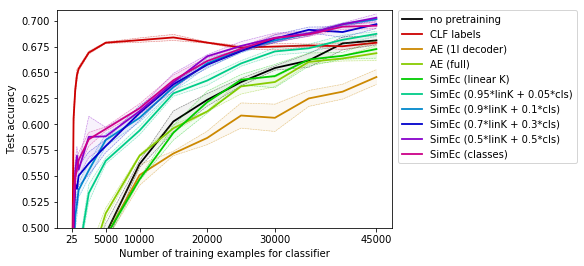

In [20]:
def plot_mean_std(test_accs, c, label):
    data_mean = np.array([t[0] for t in test_accs])
    data_std = np.array([t[1] for t in test_accs])
    plt.plot(n_training_examples, data_mean, color=c, linewidth=1.8, label=label)
    plt.plot(n_training_examples, data_mean+data_std, "--", color=c, linewidth=0.5, alpha=0.5)
    plt.plot(n_training_examples, data_mean-data_std, "--", color=c, linewidth=0.5, alpha=0.5)
    plt.fill_between(n_training_examples, data_mean+data_std, data_mean-data_std, color=c, alpha=0.05)

colors = get_colors(17)
plt.figure()
plot_mean_std(test_accuracies_clf, c="k", label="no pretraining")
plot_mean_std(test_accuracies_clf_pt, c=colors[0], label="CLF labels")
plot_mean_std(test_accuracies_ae1l, c=colors[2], label="AE (1l decoder)")
plot_mean_std(test_accuracies_ae, c=colors[4], label="AE (full)")
plot_mean_std(test_accuracies_se, c=colors[6], label="SimEc (linear K)")
plot_mean_std(test_accuracies_se_t1_mix, c=colors[8], label="SimEc (0.95*linK + 0.05*cls)")
plot_mean_std(test_accuracies_se_t1_mix9, c=colors[10], label="SimEc (0.9*linK + 0.1*cls)")
plot_mean_std(test_accuracies_se_t1_mix7, c=colors[12], label="SimEc (0.7*linK + 0.3*cls)")
plot_mean_std(test_accuracies_se_t1_mix5, c=colors[14], label="SimEc (0.5*linK + 0.5*cls)")
plot_mean_std(test_accuracies_se_t1, c=colors[16], label="SimEc (classes)")
plt.xlabel("Number of training examples for classifier")
plt.xticks([25, 5000, 10000, 20000, 30000, 45000], [25, 5000, 10000, 20000, 30000, 45000])
plt.ylabel("Test accuracy")
plt.ylim(0.5, 0.71)
l = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);
plt.savefig('img_simec.pdf', dpi=300, bbox_inches="tight", bbox_extra_artists=[l])
print("n_training_examples =", n_training_examples)
print("test_accuracies_clf =", test_accuracies_clf)
print("test_accuracies_clf_pt =", test_accuracies_clf_pt)
print("test_accuracies_ae1l =", test_accuracies_ae1l)
print("test_accuracies_ae =", test_accuracies_ae)
print("test_accuracies_se =", test_accuracies_se)
print("test_accuracies_se_t1_mix =", test_accuracies_se_t1_mix)
print("test_accuracies_se_t1_mix9 =", test_accuracies_se_t1_mix9)
print("test_accuracies_se_t1_mix7 =", test_accuracies_se_t1_mix7)
print("test_accuracies_se_t1_mix5 =", test_accuracies_se_t1_mix5)
print("test_accuracies_se_t1 =", test_accuracies_se_t1)

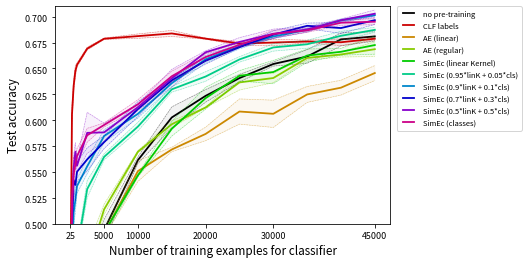

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import colorsys

%matplotlib inline
%load_ext autoreload
%autoreload 2

def get_colors(N=100):
    HSV_tuples = [(x * 1. / (N+1), 1., 0.8) for x in range(N)]
    return [colorsys.hsv_to_rgb(*x) for x in HSV_tuples]


n_training_examples = [25, 50, 100, 250, 500, 750, 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000]
test_accuracies_clf = [(0.1621, 0.007353910524340101), (0.19743333333333332, 0.013557859549189737), (0.21613333333333332, 0.0032293790252754346), (0.3024, 0.018181309083781617), (0.36036666666666667, 0.004135483311805557), (0.3839333333333333, 0.010612675859032392), (0.3823666666666667, 0.010506611674983), (0.44543333333333335, 0.008575287491131437), (0.4940666666666667, 0.010124996570644156), (0.5615333333333333, 0.003229379025275437), (0.6027, 0.010220567498921002), (0.6235666666666666, 0.006104825049818298), (0.6407333333333333, 0.003596603335865075), (0.6543333333333333, 0.0020270394394014224), (0.6615666666666666, 0.006613790306792481), (0.6781, 0.006255131226974115), (0.6809999999999999, 0.0045107279530766245)]
test_accuracies_clf_pt = [(0.3495, 0.07030035561787722), (0.4467666666666667, 0.030813020335926533), (0.49183333333333334, 0.03235164429961619), (0.6055999999999999, 0.009021455906153213), (0.6333666666666667, 0.005349350947129527), (0.6475, 0.00555517776493243), (0.6535666666666667, 0.001878533707147403), (0.6691666666666666, 0.001359738536958064), (0.6787333333333333, 0.0006599663291074202), (0.6812666666666667, 0.002106075866524182), (0.6838333333333333, 0.0029397656747132384), (0.6788333333333334, 0.0005906681715556321), (0.6741333333333334, 0.001763204154058412), (0.6750333333333334, 0.0031510139461590897), (0.6760666666666667, 0.001322455628325146), (0.6753333333333335, 0.003227313984655873), (0.6787666666666666, 0.0014383632673594555)]
test_accuracies_ae1l = [(0.16010000000000002, 0.007904850831398828), (0.19833333333333333, 0.007492366485667638), (0.2097, 0.02154313502410145), (0.2979, 0.008741090702347546), (0.3497333333333333, 0.006593094030035418), (0.35936666666666667, 0.014222361110432947), (0.3884666666666667, 0.008935820549277438), (0.44530000000000003, 0.00382186690854961), (0.4908666666666666, 0.00342960963117118), (0.5509333333333334, 0.009986769024842605), (0.5717666666666666, 0.0021249836600678884), (0.5868, 0.006531462317123172), (0.6084333333333334, 0.012174381115915336), (0.6062333333333333, 0.01318618806007089), (0.6249333333333333, 0.007711607412782962), (0.6314666666666667, 0.007172323348972928), (0.6456, 0.0072475283143059585)]
test_accuracies_ae = [(0.16206666666666666, 0.003700750674600437), (0.19346666666666665, 0.010726084508751966), (0.2132666666666667, 0.01870496072050287), (0.3049, 0.01755961275199428), (0.35969999999999996, 0.0032782108941717815), (0.3760333333333334, 0.009910376156108082), (0.38210000000000005, 0.013364380519375635), (0.4614666666666667, 0.016061617463865703), (0.5139333333333332, 0.005118159391378452), (0.5696333333333333, 0.0010402991022885242), (0.5961666666666666, 0.003402286812653439), (0.6123666666666666, 0.00012472191289250042), (0.6365333333333333, 0.007344083030273811), (0.6408, 0.004490731195102497), (0.6602, 0.002041241452319317), (0.6635333333333333, 0.002456736769691771), (0.6686333333333333, 0.007149048110685038)]
test_accuracies_se = [(0.16116666666666668, 0.002397684067780599), (0.20123333333333335, 0.009722939656068822), (0.20196666666666666, 0.01404215874508697), (0.3123, 0.00899333086236686), (0.35776666666666673, 0.004169998667732246), (0.3734, 0.002290560339014618), (0.3922666666666667, 0.004696334267868461), (0.4425333333333333, 0.00931390835733791), (0.49146666666666666, 0.004759084879353256), (0.5468000000000001, 0.0013490737563231928), (0.5917666666666667, 0.007102268808079687), (0.6213666666666667, 0.01062115289829161), (0.6429333333333334, 0.005067763039273057), (0.6465666666666666, 0.0112422813026934), (0.6625, 0.006328243568848075), (0.6661333333333334, 0.0032826141344293805), (0.6726333333333333, 0.008775850702670127)]
test_accuracies_se_t1_mix = [(0.19193333333333332, 0.009336071027055345), (0.2399, 0.010503650159190699), (0.2615, 0.03592185964005762), (0.39146666666666663, 0.009107262059599585), (0.4502333333333333, 0.009602198822260577), (0.4755, 0.010050207294711204), (0.4744333333333333, 0.004496912521077351), (0.5335000000000001, 0.008472701261502546), (0.5646333333333333, 0.00299592315581616), (0.5939333333333333, 0.004205023450852817), (0.6298666666666667, 0.0027920522121829285), (0.6422333333333333, 0.0046147107770211655), (0.6587333333333334, 0.0026712460679532203), (0.6703333333333333, 0.00356495285928005), (0.6734, 0.0038995726261561534), (0.6815666666666668, 0.004305293898859377), (0.6873, 0.0024124676163629374)]
test_accuracies_se_t1_mix9 = [(0.20783333333333331, 0.02478391055144894), (0.27276666666666666, 0.018329272277486146), (0.3172, 0.048104954699767326), (0.46890000000000004, 0.013075167302944921), (0.511, 0.013209844813622902), (0.5228666666666667, 0.011715042561690595), (0.5364999999999999, 0.007142828571371426), (0.5555333333333333, 0.007191816336797122), (0.5847666666666667, 0.006123905797954626), (0.6062333333333333, 0.004168399639616559), (0.6357666666666666, 0.0037985377303495307), (0.6589666666666667, 0.003587323359956402), (0.6712666666666668, 0.0023271346234276236), (0.6809, 0.001867261809888105), (0.6873, 0.0017281975195754446), (0.6964666666666667, 0.0012657891697364987), (0.7015333333333333, 0.0004988876515698929)]
test_accuracies_se_t1_mix7 = [(0.24783333333333335, 0.01497405163014414), (0.31396666666666667, 0.01790611317089471), (0.3419666666666667, 0.028868475693892948), (0.49720000000000003, 0.009940824915468553), (0.5422333333333333, 0.0075896127847356115), (0.5375333333333333, 0.01539574255724254), (0.5502666666666666, 0.009365658308712523), (0.5621999999999999, 0.011151083654365903), (0.5788666666666668, 0.0062376990059547196), (0.6108333333333333, 0.007202931501980439), (0.6385333333333333, 0.0014055445761538506), (0.6574333333333333, 0.0032887011958454694), (0.6706, 0.0007483314773547949), (0.6827, 0.00374966665185055), (0.6911999999999999, 0.002669581740023454), (0.6890666666666667, 0.005235986588557624), (0.6966666666666667, 0.004187547678003882)]
test_accuracies_se_t1_mix5 = [(0.2627, 0.031073246799564837), (0.3131333333333333, 0.03331159291031011), (0.3578333333333334, 0.05769138198687527), (0.5193333333333333, 0.007969246444231007), (0.5541, 0.012356644636254074), (0.5696666666666667, 0.008625672276537197), (0.5560666666666667, 0.005845416057808791), (0.5878333333333333, 0.019833361344518057), (0.5882999999999999, 0.008819674975114822), (0.6126666666666667, 0.0030728199137310974), (0.6405333333333333, 0.00865653253650419), (0.6656666666666666, 0.0014659088951530438), (0.6756333333333333, 0.004169998667732288), (0.6835, 0.004526219909225183), (0.6876333333333333, 0.0026029897340472752), (0.6966333333333333, 0.001203698005684524), (0.7029, 0.0036175498153676673)]
test_accuracies_se_t1 = [(0.29616666666666663, 0.05793504025103364), (0.3484333333333334, 0.038607800017900824), (0.4068333333333333, 0.04925101239794185), (0.5209333333333334, 0.012211833969101008), (0.5482333333333334, 0.01674720540534715), (0.5569666666666667, 0.003936439451529201), (0.5654333333333333, 0.007271099565326344), (0.5854666666666667, 0.006723259791367729), (0.5954666666666667, 0.00196015872373186), (0.6154, 0.004459446901429227), (0.6425000000000001, 0.005012650662739885), (0.6610999999999999, 0.0036120169803956683), (0.6728333333333333, 0.001948218559493635), (0.6833333333333335, 0.00360123435628522), (0.6867666666666666, 0.0018803073034893679), (0.6942, 0.0024344746182013706), (0.6951999999999999, 0.00296984848098349)]
def plot_mean_std(test_accs, c, label):
    data_mean = np.array([t[0] for t in test_accs])
    data_std = np.array([t[1] for t in test_accs])
    plt.plot(n_training_examples, data_mean, color=c, linewidth=1.8, label=label)
    plt.plot(n_training_examples, data_mean+data_std, "--", color=c, linewidth=0.5, alpha=0.5)
    plt.plot(n_training_examples, data_mean-data_std, "--", color=c, linewidth=0.5, alpha=0.5)
    plt.fill_between(n_training_examples, data_mean+data_std, data_mean-data_std, color=c, alpha=0.05)

colors = get_colors(17)
plt.figure()
plot_mean_std(test_accuracies_clf, c="k", label="no pre-training")
plot_mean_std(test_accuracies_clf_pt, c=colors[0], label="CLF labels")
plot_mean_std(test_accuracies_ae1l, c=colors[2], label="AE (linear)")
plot_mean_std(test_accuracies_ae, c=colors[4], label="AE (regular)")
plot_mean_std(test_accuracies_se, c=colors[6], label="SimEc (linear Kernel)")
plot_mean_std(test_accuracies_se_t1_mix, c=colors[8], label="SimEc (0.95*linK + 0.05*cls)")
plot_mean_std(test_accuracies_se_t1_mix9, c=colors[10], label="SimEc (0.9*linK + 0.1*cls)")
plot_mean_std(test_accuracies_se_t1_mix7, c=colors[12], label="SimEc (0.7*linK + 0.3*cls)")
plot_mean_std(test_accuracies_se_t1_mix5, c=colors[14], label="SimEc (0.5*linK + 0.5*cls)")
plot_mean_std(test_accuracies_se_t1, c=colors[16], label="SimEc (classes)")
plt.xlabel("Number of training examples for classifier", fontsize=13)
plt.xticks([25, 5000, 10000, 20000, 30000, 45000], [25, 5000, 10000, 20000, 30000, 45000])
plt.ylabel("Test accuracy", fontsize=13)
plt.ylim(0.5, 0.71)
l = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);
plt.savefig('img_simec.pdf', dpi=300, bbox_inches="tight", bbox_extra_artists=[l])